# Imports

In [109]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import re
import gc
import sys
import warnings

import torch.utils.data as torch_data
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from keras.preprocessing import text, sequence
import torch.utils.data as data

from gensim.models.fasttext import FastText

from gensim.models.fasttext import FastText

from classifiers import RNNClassifier
from utils import seed_everything, preprocess, pad_text, CommentsDataset, CommentsDatasetTest
from utils import sigmoid
from evaluation import compute_bias_metrics_for_model, get_final_metric
from train import train_classifier
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
random_state = 42

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
torch.cuda.is_available()

True

In [5]:
seed_everything(random_state)

In [6]:
data_folder = 'vk_data/'

# Data Loading

In [7]:
train = pd.read_csv(data_folder + 'train.csv')
test = pd.read_csv(data_folder + 'test.csv')

In [8]:
print(train.shape)
train.head(3)

(1804874, 45)


,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.0,"This is so cool. It's like, 'would you want yo...",0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,0.0,Thank you!! This would make my life a lot less...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
2,59852,0.0,This is such an urgent design problem; kudos t...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4


In [9]:
print(test.shape)
test.head(3)

(97320, 2)


,id,comment_text
0,7097320,[ Integrity means that you pay your debts.]\n\...
1,7097321,This is malfeasance by the Administrator and t...
2,7097322,@Rmiller101 - Spoken like a true elitist. But ...


Prediction will be made only by comment

# Data Analysis

In [10]:
target_columns = ['target', 'severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat']

In [11]:
train[target_columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1804874 entries, 0 to 1804873
Data columns (total 6 columns):
target             float64
severe_toxicity    float64
obscene            float64
identity_attack    float64
insult             float64
threat             float64
dtypes: float64(6)
memory usage: 82.6 MB


In [12]:
train[target_columns].describe()

,target,severe_toxicity,obscene,identity_attack,insult,threat
count,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06
mean,1.030173e-01,4.582099e-03,1.387721e-02,2.263571e-02,8.115273e-02,9.311271e-03
std,1.970757e-01,2.286128e-02,6.460419e-02,7.873156e-02,1.760657e-01,4.942218e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,1.666667e-01,0.000000e+00,0.000000e+00,0.000000e+00,9.090909e-02,0.000000e+00
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


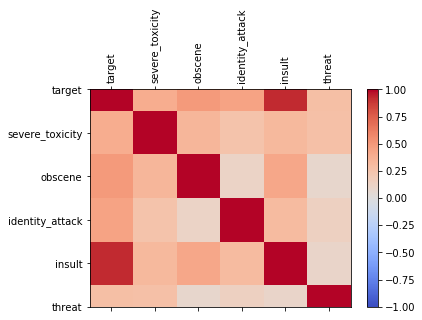

In [13]:
data = train[target_columns]
corr = data.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(data.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(data.columns)
ax.set_yticklabels(data.columns)
plt.show()

#### It seems like insults is the most common type of toxic comments in the Internet, it has a sence

# Data processing

In [14]:
x_train = preprocess(train['comment_text'])
y_train = np.where(train['target'] >= 0.5, 1, 0)
y_aux_train = train[['target', 'severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat']]
x_test = preprocess(test['comment_text'])

In [17]:
x_train = x_train.apply(lambda x: x.split())
x_test = x_test.apply(lambda x: x.split())

In [18]:
lenghts_train = [len(com) for com in x_train]
lenghts_test = [len(com) for com in x_test]
# lenghts_train and lenghts_test will be used in RNN
lenghts = lenghts_train + lenghts_test
print('median:', np.median(lenghts))
print('mean:', np.mean(lenghts))
print('max:', np.max(lenghts))
print('min:', np.min(lenghts))

median: 36.0
mean: 52.87058680660332
max: 323
min: 0


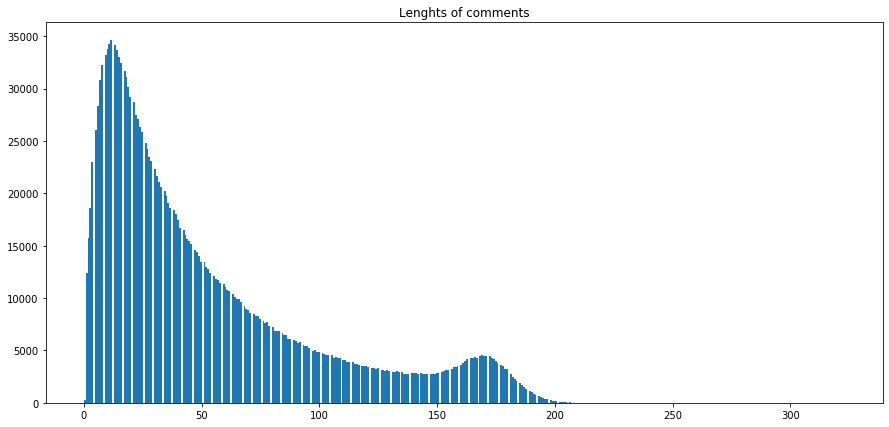

In [19]:
plt.figure(figsize=(15, 7))
plt.hist(lenghts, bins=400)
plt.title("Lenghts of comments")
plt.show()

#### The most of all comments has less than 200 symbols, let's use this number for padding and truncating

In [20]:
MAX_SEN_LEN = 200

#### It seems that using of fast text will be the best, because in Internet comments people often use short forms of words, slang and etc. All this stuff will be out-of-bag cases, but fasttext works with n-grams. So I think that it will perform better encoding ow texts

#### Next cell is comented because I've already pretrained embedding and just load it from disk. Approximate time of one epoch of training is 70 secunds in this configuration

In [62]:
# EMB_SIZE = 70
# embedder = FastText(size=EMB_SIZE, window=5, min_count=30, workers=12, min_n=3, max_n=6, bucket=30000)
# embedder.build_vocab(list(x_train))
# embedder.train(list(x_train), total_examples=embedder.corpus_count, epochs=40)
# print('Total training time:', '%.1f' % embedder.total_train_time, 'sec')

Total training time: 3207.1 sec


In [ ]:
#### Saving and loading models

In [26]:
# embedder.save("vk_models/fast_text_small")
embedder = FastText.load("vk_models/fast_text_small")

In [28]:
# A dictionary from string representations of the model’s memory consuming members to their size in bytes
embedder.estimate_memory()

{'vocab': 20455000,
 'syn0_vocab': 11454800,
 'syn1neg': 11454800,
 'syn0_ngrams': 8386280,
 'buckets_word': 9509488,
 'total': 61260368}

In [38]:
print('Total size of embedder:', '%.2f' % (embedder.estimate_memory()['total'] / 1024 / 1024), 'MB')

Total size of embedder: 58.42 MB


In [42]:
embedder.wv['']

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.], dtype=float32)

#### It seems very natural to pad and truncate sentences by empty strs

In [43]:
x_train = pad_text(x_train, length=MAX_SEN_LEN, sym='')
x_test = pad_text(x_test, length=MAX_SEN_LEN, sym='')

In [44]:
gc.collect()

20

# Training

In [46]:
if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [47]:
y_train = np.hstack([y_train[:, np.newaxis], y_aux_train])

In [48]:
lenghts_train = [l if 0<l<MAX_SEN_LEN else MAX_SEN_LEN for l in lenghts_train]
lenghts_test = [l if l<MAX_SEN_LEN else MAX_SEN_LEN for l in lenghts_test]

In [105]:
train_dataset = CommentsDataset(x_train, y_train, lenghts_train)
test_dataset = CommentsDatasetTest(x_test, lenghts_test)

In [99]:
from classifiers import RNNClassifier
EMB_SIZE = 70
model = RNNClassifier(emb_size=EMB_SIZE, hidden_size=100, num_layers=2,
                      num_aux=y_aux_train.shape[-1], device=device)

test_preds = train_classifier(model, embedder, train_dataset, test_dataset, 
                              output_dim=y_train.shape[-1], loss_fn=nn.BCEWithLogitsLoss(reduction='mean'), 
                              batch_size=256, n_epochs=2, device=device)








  0%|          | 0/7051 [00:00<?, ?it/s]

epoch: 0









  0%|          | 1/7051 [00:01<2:01:17,  1.03s/it]

0th Loss: 0.6864









  0%|          | 2/7051 [00:01<1:55:34,  1.02it/s]






  0%|          | 3/7051 [00:02<1:51:24,  1.05it/s]






  0%|          | 4/7051 [00:03<1:48:23,  1.08it/s]






  0%|          | 5/7051 [00:04<1:46:11,  1.11it/s]






  0%|          | 6/7051 [00:05<1:45:33,  1.11it/s]

5th Loss: 0.6496









  0%|          | 7/7051 [00:06<1:44:39,  1.12it/s]






  0%|          | 8/7051 [00:07<1:43:43,  1.13it/s]






  0%|          | 9/7051 [00:07<1:42:47,  1.14it/s]






  0%|          | 10/7051 [00:08<1:42:27,  1.15it/s]






  0%|          | 11/7051 [00:09<1:42:08,  1.15it/s]

10th Loss: 0.5849









  0%|          | 12/7051 [00:10<1:42:12,  1.15it/s]






  0%|          | 13/7051 [00:11<1:43:23,  1.13it/s]






  0%|          | 14/7051 [00:12<1:42:31,  1.14it/s]






  0%|          | 15/7051 [00:13<1:42:24,  1.15it/s]






  0%|          | 16/7051 [00:14<1:41:50,  1.15it/s]

15th Loss: 0.4538









  0%|          | 17/7051 [00:14<1:41:48,  1.15it/s]






  0%|          | 18/7051 [00:15<1:41:12,  1.16it/s]






  0%|          | 19/7051 [00:16<1:42:12,  1.15it/s]






  0%|          | 20/7051 [00:17<1:42:14,  1.15it/s]






  0%|          | 21/7051 [00:18<1:41:58,  1.15it/s]

20th Loss: 0.2632









  0%|          | 22/7051 [00:19<1:42:41,  1.14it/s]






  0%|          | 23/7051 [00:20<1:42:38,  1.14it/s]






  0%|          | 24/7051 [00:21<1:42:21,  1.14it/s]






  0%|          | 25/7051 [00:21<1:42:14,  1.15it/s]






  0%|          | 26/7051 [00:22<1:42:12,  1.15it/s]

25th Loss: 0.2231









  0%|          | 27/7051 [00:23<1:41:14,  1.16it/s]






  0%|          | 28/7051 [00:24<1:41:27,  1.15it/s]






  0%|          | 29/7051 [00:25<1:41:01,  1.16it/s]






  0%|          | 30/7051 [00:26<1:41:01,  1.16it/s]






  0%|          | 31/7051 [00:27<1:41:06,  1.16it/s]

30th Loss: 0.2459









  0%|          | 32/7051 [00:27<1:41:49,  1.15it/s]






  0%|          | 33/7051 [00:28<1:42:32,  1.14it/s]






  0%|          | 34/7051 [00:29<1:42:26,  1.14it/s]






  0%|          | 35/7051 [00:30<1:42:27,  1.14it/s]






  1%|          | 36/7051 [00:31<1:42:10,  1.14it/s]

35th Loss: 0.1664









  1%|          | 37/7051 [00:32<1:42:34,  1.14it/s]






  1%|          | 38/7051 [00:33<1:44:02,  1.12it/s]






  1%|          | 39/7051 [00:34<1:45:54,  1.10it/s]






  1%|          | 40/7051 [00:35<1:45:11,  1.11it/s]






  1%|          | 41/7051 [00:36<1:44:26,  1.12it/s]

40th Loss: 0.1548









  1%|          | 42/7051 [00:36<1:44:38,  1.12it/s]






  1%|          | 43/7051 [00:37<1:43:24,  1.13it/s]






  1%|          | 44/7051 [00:38<1:42:45,  1.14it/s]






  1%|          | 45/7051 [00:39<1:43:04,  1.13it/s]






  1%|          | 46/7051 [00:40<1:42:23,  1.14it/s]

45th Loss: 0.1834









  1%|          | 47/7051 [00:41<1:42:46,  1.14it/s]






  1%|          | 48/7051 [00:42<1:42:57,  1.13it/s]






  1%|          | 49/7051 [00:43<1:42:40,  1.14it/s]






  1%|          | 50/7051 [00:43<1:42:59,  1.13it/s]






  1%|          | 51/7051 [00:44<1:45:03,  1.11it/s]

50th Loss: 0.1765









  1%|          | 52/7051 [00:45<1:44:42,  1.11it/s]






  1%|          | 53/7051 [00:46<1:43:47,  1.12it/s]






  1%|          | 54/7051 [00:47<1:43:31,  1.13it/s]






  1%|          | 55/7051 [00:48<1:43:12,  1.13it/s]






  1%|          | 56/7051 [00:49<1:43:21,  1.13it/s]

55th Loss: 0.1598









  1%|          | 57/7051 [00:50<1:43:34,  1.13it/s]






  1%|          | 58/7051 [00:51<1:43:14,  1.13it/s]






  1%|          | 59/7051 [00:51<1:43:04,  1.13it/s]






  1%|          | 60/7051 [00:52<1:43:05,  1.13it/s]






  1%|          | 61/7051 [00:53<1:42:51,  1.13it/s]

60th Loss: 0.1496









  1%|          | 62/7051 [00:54<1:42:57,  1.13it/s]






  1%|          | 63/7051 [00:55<1:43:19,  1.13it/s]






  1%|          | 64/7051 [00:56<1:44:01,  1.12it/s]






  1%|          | 65/7051 [00:57<1:44:05,  1.12it/s]






  1%|          | 66/7051 [00:58<1:43:33,  1.12it/s]

65th Loss: 0.1822









  1%|          | 67/7051 [00:59<1:43:30,  1.12it/s]






  1%|          | 68/7051 [00:59<1:42:47,  1.13it/s]






  1%|          | 69/7051 [01:00<1:42:15,  1.14it/s]






  1%|          | 70/7051 [01:01<1:43:34,  1.12it/s]






  1%|          | 71/7051 [01:02<1:43:13,  1.13it/s]

70th Loss: 0.1399









  1%|          | 72/7051 [01:03<1:43:28,  1.12it/s]






  1%|          | 73/7051 [01:04<1:43:35,  1.12it/s]






  1%|          | 74/7051 [01:05<1:43:16,  1.13it/s]






  1%|          | 75/7051 [01:06<1:42:50,  1.13it/s]






  1%|          | 76/7051 [01:07<1:42:53,  1.13it/s]

75th Loss: 0.1589









  1%|          | 77/7051 [01:07<1:43:58,  1.12it/s]






  1%|          | 78/7051 [01:08<1:43:46,  1.12it/s]






  1%|          | 79/7051 [01:09<1:43:41,  1.12it/s]






  1%|          | 80/7051 [01:10<1:43:21,  1.12it/s]






  1%|          | 81/7051 [01:11<1:43:05,  1.13it/s]

80th Loss: 0.1787









  1%|          | 82/7051 [01:12<1:43:05,  1.13it/s]






  1%|          | 83/7051 [01:13<1:44:01,  1.12it/s]






  1%|          | 84/7051 [01:14<1:43:40,  1.12it/s]






  1%|          | 85/7051 [01:15<1:43:07,  1.13it/s]






  1%|          | 86/7051 [01:15<1:43:14,  1.12it/s]

85th Loss: 0.1702









  1%|          | 87/7051 [01:16<1:43:11,  1.12it/s]






  1%|          | 88/7051 [01:17<1:42:56,  1.13it/s]






  1%|▏         | 89/7051 [01:18<1:43:21,  1.12it/s]






  1%|▏         | 90/7051 [01:19<1:45:10,  1.10it/s]






  1%|▏         | 91/7051 [01:20<1:45:21,  1.10it/s]

90th Loss: 0.1640









  1%|▏         | 92/7051 [01:21<1:44:25,  1.11it/s]






  1%|▏         | 93/7051 [01:22<1:43:42,  1.12it/s]






  1%|▏         | 94/7051 [01:23<1:43:24,  1.12it/s]






  1%|▏         | 95/7051 [01:24<1:44:16,  1.11it/s]






  1%|▏         | 96/7051 [01:24<1:43:38,  1.12it/s]

95th Loss: 0.1707









  1%|▏         | 97/7051 [01:25<1:43:13,  1.12it/s]






  1%|▏         | 98/7051 [01:26<1:43:06,  1.12it/s]






  1%|▏         | 99/7051 [01:27<1:42:51,  1.13it/s]






  1%|▏         | 100/7051 [01:28<1:42:34,  1.13it/s]






  1%|▏         | 101/7051 [01:29<1:43:14,  1.12it/s]

100th Loss: 0.1946









  1%|▏         | 102/7051 [01:30<1:43:40,  1.12it/s]






  1%|▏         | 103/7051 [01:31<1:43:21,  1.12it/s]






  1%|▏         | 104/7051 [01:32<1:42:53,  1.13it/s]






  1%|▏         | 105/7051 [01:32<1:42:38,  1.13it/s]






  2%|▏         | 106/7051 [01:33<1:42:07,  1.13it/s]

105th Loss: 0.1512









  2%|▏         | 107/7051 [01:34<1:41:26,  1.14it/s]






  2%|▏         | 108/7051 [01:35<1:42:49,  1.13it/s]






  2%|▏         | 109/7051 [01:36<1:42:51,  1.12it/s]






  2%|▏         | 110/7051 [01:37<1:42:51,  1.12it/s]






  2%|▏         | 111/7051 [01:38<1:42:43,  1.13it/s]

110th Loss: 0.1589









  2%|▏         | 112/7051 [01:39<1:42:36,  1.13it/s]






  2%|▏         | 113/7051 [01:40<1:42:35,  1.13it/s]






  2%|▏         | 114/7051 [01:40<1:44:02,  1.11it/s]






  2%|▏         | 115/7051 [01:41<1:43:56,  1.11it/s]






  2%|▏         | 116/7051 [01:42<1:43:24,  1.12it/s]

115th Loss: 0.1529









  2%|▏         | 117/7051 [01:43<1:42:45,  1.12it/s]






  2%|▏         | 118/7051 [01:44<1:43:06,  1.12it/s]






  2%|▏         | 119/7051 [01:45<1:42:33,  1.13it/s]






  2%|▏         | 120/7051 [01:46<1:42:08,  1.13it/s]






  2%|▏         | 121/7051 [01:47<1:42:48,  1.12it/s]

120th Loss: 0.1559









  2%|▏         | 122/7051 [01:48<1:42:45,  1.12it/s]






  2%|▏         | 123/7051 [01:48<1:42:45,  1.12it/s]






  2%|▏         | 124/7051 [01:49<1:42:32,  1.13it/s]






  2%|▏         | 125/7051 [01:50<1:42:29,  1.13it/s]






  2%|▏         | 126/7051 [01:51<1:42:24,  1.13it/s]

125th Loss: 0.1544









  2%|▏         | 127/7051 [01:52<1:43:21,  1.12it/s]






  2%|▏         | 128/7051 [01:53<1:43:00,  1.12it/s]






  2%|▏         | 129/7051 [01:54<1:42:06,  1.13it/s]






  2%|▏         | 130/7051 [01:55<1:41:50,  1.13it/s]






  2%|▏         | 131/7051 [01:56<1:41:38,  1.13it/s]

130th Loss: 0.1775









  2%|▏         | 132/7051 [01:56<1:41:59,  1.13it/s]






  2%|▏         | 133/7051 [01:57<1:41:58,  1.13it/s]






  2%|▏         | 134/7051 [01:58<1:41:29,  1.14it/s]






  2%|▏         | 135/7051 [01:59<1:41:13,  1.14it/s]






  2%|▏         | 136/7051 [02:00<1:41:02,  1.14it/s]

135th Loss: 0.1604









  2%|▏         | 137/7051 [02:01<1:40:53,  1.14it/s]






  2%|▏         | 138/7051 [02:02<1:40:38,  1.14it/s]






  2%|▏         | 139/7051 [02:03<1:40:25,  1.15it/s]






  2%|▏         | 140/7051 [02:03<1:41:54,  1.13it/s]






  2%|▏         | 141/7051 [02:04<1:40:34,  1.15it/s]

140th Loss: 0.1875









  2%|▏         | 142/7051 [02:05<1:40:18,  1.15it/s]






  2%|▏         | 143/7051 [02:06<1:40:00,  1.15it/s]






  2%|▏         | 144/7051 [02:07<1:39:52,  1.15it/s]






  2%|▏         | 145/7051 [02:08<1:39:22,  1.16it/s]






  2%|▏         | 146/7051 [02:09<1:40:16,  1.15it/s]

145th Loss: 0.1653









  2%|▏         | 147/7051 [02:09<1:40:00,  1.15it/s]






  2%|▏         | 148/7051 [02:10<1:39:58,  1.15it/s]






  2%|▏         | 149/7051 [02:11<1:39:47,  1.15it/s]






  2%|▏         | 150/7051 [02:12<1:40:08,  1.15it/s]






  2%|▏         | 151/7051 [02:13<1:39:46,  1.15it/s]

150th Loss: 0.1451









  2%|▏         | 152/7051 [02:14<1:39:46,  1.15it/s]






  2%|▏         | 153/7051 [02:15<1:40:49,  1.14it/s]






  2%|▏         | 154/7051 [02:16<1:40:15,  1.15it/s]






  2%|▏         | 155/7051 [02:16<1:40:10,  1.15it/s]






  2%|▏         | 156/7051 [02:17<1:39:23,  1.16it/s]

155th Loss: 0.1525









  2%|▏         | 157/7051 [02:18<1:39:32,  1.15it/s]






  2%|▏         | 158/7051 [02:19<1:39:45,  1.15it/s]






  2%|▏         | 159/7051 [02:20<1:40:13,  1.15it/s]






  2%|▏         | 160/7051 [02:21<1:41:03,  1.14it/s]






  2%|▏         | 161/7051 [02:22<1:40:34,  1.14it/s]

160th Loss: 0.1660









  2%|▏         | 162/7051 [02:23<1:39:56,  1.15it/s]






  2%|▏         | 163/7051 [02:23<1:39:42,  1.15it/s]






  2%|▏         | 164/7051 [02:24<1:39:23,  1.15it/s]






  2%|▏         | 165/7051 [02:25<1:39:27,  1.15it/s]






  2%|▏         | 166/7051 [02:26<1:39:52,  1.15it/s]

165th Loss: 0.1584









  2%|▏         | 167/7051 [02:27<1:39:34,  1.15it/s]






  2%|▏         | 168/7051 [02:28<1:39:04,  1.16it/s]






  2%|▏         | 169/7051 [02:29<1:38:45,  1.16it/s]






  2%|▏         | 170/7051 [02:29<1:38:48,  1.16it/s]






  2%|▏         | 171/7051 [02:30<1:38:54,  1.16it/s]

170th Loss: 0.1666









  2%|▏         | 172/7051 [02:31<1:39:55,  1.15it/s]






  2%|▏         | 173/7051 [02:32<1:39:19,  1.15it/s]






  2%|▏         | 174/7051 [02:33<1:38:58,  1.16it/s]






  2%|▏         | 175/7051 [02:34<1:39:08,  1.16it/s]






  2%|▏         | 176/7051 [02:35<1:38:53,  1.16it/s]

175th Loss: 0.1901









  3%|▎         | 177/7051 [02:35<1:38:50,  1.16it/s]






  3%|▎         | 178/7051 [02:36<1:38:50,  1.16it/s]






  3%|▎         | 179/7051 [02:37<1:39:21,  1.15it/s]






  3%|▎         | 180/7051 [02:38<1:39:02,  1.16it/s]






  3%|▎         | 181/7051 [02:39<1:38:55,  1.16it/s]

180th Loss: 0.1902









  3%|▎         | 182/7051 [02:40<1:38:51,  1.16it/s]






  3%|▎         | 183/7051 [02:41<1:38:10,  1.17it/s]






  3%|▎         | 184/7051 [02:42<1:38:24,  1.16it/s]






  3%|▎         | 185/7051 [02:42<1:39:50,  1.15it/s]






  3%|▎         | 186/7051 [02:43<1:39:43,  1.15it/s]

185th Loss: 0.1339









  3%|▎         | 187/7051 [02:44<1:39:29,  1.15it/s]






  3%|▎         | 188/7051 [02:45<1:38:55,  1.16it/s]






  3%|▎         | 189/7051 [02:46<1:39:09,  1.15it/s]






  3%|▎         | 190/7051 [02:47<1:39:03,  1.15it/s]






  3%|▎         | 191/7051 [02:48<1:39:40,  1.15it/s]

190th Loss: 0.1864









  3%|▎         | 192/7051 [02:49<1:39:44,  1.15it/s]






  3%|▎         | 193/7051 [02:49<1:39:23,  1.15it/s]






  3%|▎         | 194/7051 [02:50<1:39:36,  1.15it/s]






  3%|▎         | 195/7051 [02:51<1:39:44,  1.15it/s]






  3%|▎         | 196/7051 [02:52<1:39:33,  1.15it/s]

195th Loss: 0.1652









  3%|▎         | 197/7051 [02:53<1:38:58,  1.15it/s]






  3%|▎         | 198/7051 [02:54<1:39:49,  1.14it/s]






  3%|▎         | 199/7051 [02:55<1:39:49,  1.14it/s]






  3%|▎         | 200/7051 [02:55<1:39:30,  1.15it/s]






  3%|▎         | 201/7051 [02:56<1:39:24,  1.15it/s]

200th Loss: 0.1856









  3%|▎         | 202/7051 [02:57<1:39:47,  1.14it/s]






  3%|▎         | 203/7051 [02:58<1:39:51,  1.14it/s]






  3%|▎         | 204/7051 [02:59<1:39:29,  1.15it/s]






  3%|▎         | 205/7051 [03:00<1:39:22,  1.15it/s]






  3%|▎         | 206/7051 [03:01<1:39:03,  1.15it/s]

205th Loss: 0.1649









  3%|▎         | 207/7051 [03:02<1:38:45,  1.15it/s]






  3%|▎         | 208/7051 [03:02<1:38:43,  1.16it/s]






  3%|▎         | 209/7051 [03:03<1:38:28,  1.16it/s]






  3%|▎         | 210/7051 [03:04<1:38:17,  1.16it/s]






  3%|▎         | 211/7051 [03:05<1:39:04,  1.15it/s]

210th Loss: 0.1759









  3%|▎         | 212/7051 [03:06<1:38:48,  1.15it/s]






  3%|▎         | 213/7051 [03:07<1:38:32,  1.16it/s]






  3%|▎         | 214/7051 [03:08<1:38:31,  1.16it/s]






  3%|▎         | 215/7051 [03:09<1:39:17,  1.15it/s]






  3%|▎         | 216/7051 [03:09<1:40:13,  1.14it/s]

215th Loss: 0.1726









  3%|▎         | 217/7051 [03:10<1:41:12,  1.13it/s]






  3%|▎         | 218/7051 [03:11<1:40:26,  1.13it/s]






  3%|▎         | 219/7051 [03:12<1:39:44,  1.14it/s]






  3%|▎         | 220/7051 [03:13<1:39:20,  1.15it/s]






  3%|▎         | 221/7051 [03:14<1:39:05,  1.15it/s]

220th Loss: 0.1746









  3%|▎         | 222/7051 [03:15<1:38:46,  1.15it/s]






  3%|▎         | 223/7051 [03:16<1:39:22,  1.15it/s]






  3%|▎         | 224/7051 [03:16<1:40:10,  1.14it/s]






  3%|▎         | 225/7051 [03:17<1:39:11,  1.15it/s]






  3%|▎         | 226/7051 [03:18<1:38:58,  1.15it/s]

225th Loss: 0.1609









  3%|▎         | 227/7051 [03:19<1:38:58,  1.15it/s]






  3%|▎         | 228/7051 [03:20<1:38:28,  1.15it/s]






  3%|▎         | 229/7051 [03:21<1:38:40,  1.15it/s]






  3%|▎         | 230/7051 [03:22<1:38:51,  1.15it/s]






  3%|▎         | 231/7051 [03:22<1:39:02,  1.15it/s]

230th Loss: 0.1551









  3%|▎         | 232/7051 [03:23<1:38:54,  1.15it/s]






  3%|▎         | 233/7051 [03:24<1:38:36,  1.15it/s]






  3%|▎         | 234/7051 [03:25<1:38:34,  1.15it/s]






  3%|▎         | 235/7051 [03:26<1:38:20,  1.16it/s]






  3%|▎         | 236/7051 [03:27<1:38:14,  1.16it/s]

235th Loss: 0.1341









  3%|▎         | 237/7051 [03:28<1:42:46,  1.11it/s]






  3%|▎         | 238/7051 [03:29<1:44:32,  1.09it/s]






  3%|▎         | 239/7051 [03:30<1:42:35,  1.11it/s]






  3%|▎         | 240/7051 [03:30<1:41:03,  1.12it/s]






  3%|▎         | 241/7051 [03:31<1:40:00,  1.13it/s]

240th Loss: 0.2080









  3%|▎         | 242/7051 [03:32<1:40:11,  1.13it/s]






  3%|▎         | 243/7051 [03:33<1:40:14,  1.13it/s]






  3%|▎         | 244/7051 [03:34<1:39:35,  1.14it/s]






  3%|▎         | 245/7051 [03:35<1:39:12,  1.14it/s]






  3%|▎         | 246/7051 [03:36<1:38:47,  1.15it/s]

245th Loss: 0.1551









  4%|▎         | 247/7051 [03:37<1:38:25,  1.15it/s]






  4%|▎         | 248/7051 [03:37<1:38:00,  1.16it/s]






  4%|▎         | 249/7051 [03:38<1:38:50,  1.15it/s]






  4%|▎         | 250/7051 [03:39<1:38:39,  1.15it/s]






  4%|▎         | 251/7051 [03:40<1:38:21,  1.15it/s]

250th Loss: 0.1657









  4%|▎         | 252/7051 [03:41<1:37:59,  1.16it/s]






  4%|▎         | 253/7051 [03:42<1:38:03,  1.16it/s]






  4%|▎         | 254/7051 [03:43<1:37:53,  1.16it/s]






  4%|▎         | 255/7051 [03:43<1:37:35,  1.16it/s]






  4%|▎         | 256/7051 [03:44<1:40:23,  1.13it/s]

255th Loss: 0.1729









  4%|▎         | 257/7051 [03:45<1:40:18,  1.13it/s]






  4%|▎         | 258/7051 [03:46<1:39:25,  1.14it/s]






  4%|▎         | 259/7051 [03:47<1:39:02,  1.14it/s]






  4%|▎         | 260/7051 [03:48<1:38:38,  1.15it/s]






  4%|▎         | 261/7051 [03:49<1:38:03,  1.15it/s]

260th Loss: 0.1770









  4%|▎         | 262/7051 [03:50<1:38:12,  1.15it/s]






  4%|▎         | 263/7051 [03:51<1:38:16,  1.15it/s]






  4%|▎         | 264/7051 [03:51<1:38:09,  1.15it/s]






  4%|▍         | 265/7051 [03:52<1:38:19,  1.15it/s]






  4%|▍         | 266/7051 [03:53<1:38:12,  1.15it/s]

265th Loss: 0.1847









  4%|▍         | 267/7051 [03:54<1:37:49,  1.16it/s]






  4%|▍         | 268/7051 [03:55<1:37:32,  1.16it/s]






  4%|▍         | 269/7051 [03:56<1:37:41,  1.16it/s]






  4%|▍         | 270/7051 [03:57<1:37:06,  1.16it/s]






  4%|▍         | 271/7051 [03:57<1:37:13,  1.16it/s]

270th Loss: 0.1885









  4%|▍         | 272/7051 [03:58<1:37:18,  1.16it/s]






  4%|▍         | 273/7051 [03:59<1:37:32,  1.16it/s]






  4%|▍         | 274/7051 [04:00<1:36:57,  1.17it/s]






  4%|▍         | 275/7051 [04:01<1:37:35,  1.16it/s]






  4%|▍         | 276/7051 [04:02<1:37:09,  1.16it/s]

275th Loss: 0.1425









  4%|▍         | 277/7051 [04:03<1:36:58,  1.16it/s]






  4%|▍         | 278/7051 [04:03<1:36:51,  1.17it/s]






  4%|▍         | 279/7051 [04:04<1:36:31,  1.17it/s]






  4%|▍         | 280/7051 [04:05<1:36:35,  1.17it/s]






  4%|▍         | 281/7051 [04:06<1:36:47,  1.17it/s]

280th Loss: 0.1596









  4%|▍         | 282/7051 [04:07<1:37:22,  1.16it/s]






  4%|▍         | 283/7051 [04:08<1:37:35,  1.16it/s]






  4%|▍         | 284/7051 [04:09<1:37:24,  1.16it/s]






  4%|▍         | 285/7051 [04:09<1:37:16,  1.16it/s]






  4%|▍         | 286/7051 [04:10<1:36:45,  1.17it/s]

285th Loss: 0.1480









  4%|▍         | 287/7051 [04:11<1:36:29,  1.17it/s]






  4%|▍         | 288/7051 [04:12<1:37:03,  1.16it/s]






  4%|▍         | 289/7051 [04:13<1:38:30,  1.14it/s]






  4%|▍         | 290/7051 [04:14<1:37:46,  1.15it/s]






  4%|▍         | 291/7051 [04:15<1:37:21,  1.16it/s]

290th Loss: 0.1771









  4%|▍         | 292/7051 [04:15<1:36:51,  1.16it/s]






  4%|▍         | 293/7051 [04:16<1:36:55,  1.16it/s]






  4%|▍         | 294/7051 [04:17<1:36:52,  1.16it/s]






  4%|▍         | 295/7051 [04:18<1:38:25,  1.14it/s]






  4%|▍         | 296/7051 [04:19<1:38:11,  1.15it/s]

295th Loss: 0.1464









  4%|▍         | 297/7051 [04:20<1:37:33,  1.15it/s]






  4%|▍         | 298/7051 [04:21<1:36:59,  1.16it/s]






  4%|▍         | 299/7051 [04:22<1:37:35,  1.15it/s]






  4%|▍         | 300/7051 [04:22<1:37:25,  1.15it/s]






  4%|▍         | 301/7051 [04:23<1:36:53,  1.16it/s]

300th Loss: 0.1659









  4%|▍         | 302/7051 [04:24<1:37:20,  1.16it/s]






  4%|▍         | 303/7051 [04:25<1:37:33,  1.15it/s]






  4%|▍         | 304/7051 [04:26<1:37:49,  1.15it/s]






  4%|▍         | 305/7051 [04:27<1:37:45,  1.15it/s]






  4%|▍         | 306/7051 [04:28<1:38:25,  1.14it/s]

305th Loss: 0.1467









  4%|▍         | 307/7051 [04:29<1:38:22,  1.14it/s]






  4%|▍         | 308/7051 [04:29<1:38:34,  1.14it/s]






  4%|▍         | 309/7051 [04:30<1:38:03,  1.15it/s]






  4%|▍         | 310/7051 [04:31<1:37:21,  1.15it/s]






  4%|▍         | 311/7051 [04:32<1:36:46,  1.16it/s]

310th Loss: 0.1706









  4%|▍         | 312/7051 [04:33<1:36:49,  1.16it/s]






  4%|▍         | 313/7051 [04:34<1:38:10,  1.14it/s]






  4%|▍         | 314/7051 [04:35<1:39:47,  1.13it/s]






  4%|▍         | 315/7051 [04:36<1:39:39,  1.13it/s]






  4%|▍         | 316/7051 [04:36<1:39:35,  1.13it/s]

315th Loss: 0.1425









  4%|▍         | 317/7051 [04:37<1:39:29,  1.13it/s]






  5%|▍         | 318/7051 [04:38<1:39:30,  1.13it/s]






  5%|▍         | 319/7051 [04:39<1:39:22,  1.13it/s]






  5%|▍         | 320/7051 [04:40<1:39:26,  1.13it/s]






  5%|▍         | 321/7051 [04:41<1:40:02,  1.12it/s]

320th Loss: 0.1613









  5%|▍         | 322/7051 [04:42<1:40:07,  1.12it/s]






  5%|▍         | 323/7051 [04:43<1:39:40,  1.13it/s]






  5%|▍         | 324/7051 [04:44<1:39:29,  1.13it/s]






  5%|▍         | 325/7051 [04:44<1:39:40,  1.12it/s]






  5%|▍         | 326/7051 [04:45<1:40:25,  1.12it/s]

325th Loss: 0.1903









  5%|▍         | 327/7051 [04:46<1:41:06,  1.11it/s]






  5%|▍         | 328/7051 [04:47<1:40:08,  1.12it/s]






  5%|▍         | 329/7051 [04:48<1:39:39,  1.12it/s]






  5%|▍         | 330/7051 [04:49<1:39:17,  1.13it/s]






  5%|▍         | 331/7051 [04:50<1:39:19,  1.13it/s]

330th Loss: 0.1983









  5%|▍         | 332/7051 [04:51<1:39:21,  1.13it/s]






  5%|▍         | 333/7051 [04:52<1:39:55,  1.12it/s]






  5%|▍         | 334/7051 [04:52<1:39:35,  1.12it/s]






  5%|▍         | 335/7051 [04:53<1:39:26,  1.13it/s]






  5%|▍         | 336/7051 [04:54<1:38:26,  1.14it/s]

335th Loss: 0.1630









  5%|▍         | 337/7051 [04:55<1:38:23,  1.14it/s]






  5%|▍         | 338/7051 [04:56<1:38:30,  1.14it/s]






  5%|▍         | 339/7051 [04:57<1:39:12,  1.13it/s]






  5%|▍         | 340/7051 [04:58<1:39:10,  1.13it/s]






  5%|▍         | 341/7051 [04:59<1:38:42,  1.13it/s]

340th Loss: 0.1519









  5%|▍         | 342/7051 [05:00<1:38:33,  1.13it/s]






  5%|▍         | 343/7051 [05:00<1:38:31,  1.13it/s]






  5%|▍         | 344/7051 [05:01<1:39:09,  1.13it/s]






  5%|▍         | 345/7051 [05:02<1:38:54,  1.13it/s]






  5%|▍         | 346/7051 [05:03<1:39:14,  1.13it/s]

345th Loss: 0.1586









  5%|▍         | 347/7051 [05:04<1:39:01,  1.13it/s]






  5%|▍         | 348/7051 [05:05<1:38:52,  1.13it/s]






  5%|▍         | 349/7051 [05:06<1:38:15,  1.14it/s]






  5%|▍         | 350/7051 [05:07<1:37:37,  1.14it/s]






  5%|▍         | 351/7051 [05:07<1:36:34,  1.16it/s]

350th Loss: 0.1613









  5%|▍         | 352/7051 [05:08<1:37:47,  1.14it/s]






  5%|▌         | 353/7051 [05:09<1:37:15,  1.15it/s]






  5%|▌         | 354/7051 [05:10<1:36:49,  1.15it/s]






  5%|▌         | 355/7051 [05:11<1:36:16,  1.16it/s]






  5%|▌         | 356/7051 [05:12<1:36:01,  1.16it/s]

355th Loss: 0.1765









  5%|▌         | 357/7051 [05:13<1:36:08,  1.16it/s]






  5%|▌         | 358/7051 [05:13<1:36:02,  1.16it/s]






  5%|▌         | 359/7051 [05:14<1:36:38,  1.15it/s]






  5%|▌         | 360/7051 [05:15<1:36:29,  1.16it/s]






  5%|▌         | 361/7051 [05:16<1:36:28,  1.16it/s]

360th Loss: 0.1505









  5%|▌         | 362/7051 [05:17<1:36:14,  1.16it/s]






  5%|▌         | 363/7051 [05:18<1:36:00,  1.16it/s]






  5%|▌         | 364/7051 [05:19<1:35:57,  1.16it/s]






  5%|▌         | 365/7051 [05:20<1:36:36,  1.15it/s]






  5%|▌         | 366/7051 [05:20<1:36:44,  1.15it/s]

365th Loss: 0.1725









  5%|▌         | 367/7051 [05:21<1:36:27,  1.15it/s]






  5%|▌         | 368/7051 [05:22<1:35:53,  1.16it/s]






  5%|▌         | 369/7051 [05:23<1:35:30,  1.17it/s]






  5%|▌         | 370/7051 [05:24<1:35:21,  1.17it/s]






  5%|▌         | 371/7051 [05:25<1:35:33,  1.17it/s]

370th Loss: 0.1508









  5%|▌         | 372/7051 [05:26<1:36:20,  1.16it/s]






  5%|▌         | 373/7051 [05:26<1:36:17,  1.16it/s]






  5%|▌         | 374/7051 [05:27<1:36:07,  1.16it/s]






  5%|▌         | 375/7051 [05:28<1:35:59,  1.16it/s]






  5%|▌         | 376/7051 [05:29<1:35:57,  1.16it/s]

375th Loss: 0.1785









  5%|▌         | 377/7051 [05:30<1:35:50,  1.16it/s]






  5%|▌         | 378/7051 [05:31<1:36:38,  1.15it/s]






  5%|▌         | 379/7051 [05:32<1:36:13,  1.16it/s]






  5%|▌         | 380/7051 [05:32<1:35:56,  1.16it/s]






  5%|▌         | 381/7051 [05:33<1:35:44,  1.16it/s]

380th Loss: 0.1512









  5%|▌         | 382/7051 [05:34<1:35:42,  1.16it/s]






  5%|▌         | 383/7051 [05:35<1:35:24,  1.16it/s]






  5%|▌         | 384/7051 [05:36<1:35:33,  1.16it/s]






  5%|▌         | 385/7051 [05:37<1:37:57,  1.13it/s]






  5%|▌         | 386/7051 [05:38<1:37:11,  1.14it/s]

385th Loss: 0.1670









  5%|▌         | 387/7051 [05:39<1:36:18,  1.15it/s]






  6%|▌         | 388/7051 [05:39<1:35:57,  1.16it/s]






  6%|▌         | 389/7051 [05:40<1:36:11,  1.15it/s]






  6%|▌         | 390/7051 [05:41<1:35:56,  1.16it/s]






  6%|▌         | 391/7051 [05:42<1:36:33,  1.15it/s]

390th Loss: 0.1611









  6%|▌         | 392/7051 [05:43<1:36:16,  1.15it/s]






  6%|▌         | 393/7051 [05:44<1:35:56,  1.16it/s]






  6%|▌         | 394/7051 [05:45<1:35:56,  1.16it/s]






  6%|▌         | 395/7051 [05:45<1:35:46,  1.16it/s]






  6%|▌         | 396/7051 [05:46<1:36:10,  1.15it/s]

395th Loss: 0.1507









  6%|▌         | 397/7051 [05:47<1:36:06,  1.15it/s]






  6%|▌         | 398/7051 [05:48<1:36:30,  1.15it/s]






  6%|▌         | 399/7051 [05:49<1:35:49,  1.16it/s]






  6%|▌         | 400/7051 [05:50<1:35:41,  1.16it/s]






  6%|▌         | 401/7051 [05:51<1:35:23,  1.16it/s]

400th Loss: 0.1514









  6%|▌         | 402/7051 [05:52<1:35:22,  1.16it/s]






  6%|▌         | 403/7051 [05:52<1:35:04,  1.17it/s]






  6%|▌         | 404/7051 [05:53<1:36:17,  1.15it/s]






  6%|▌         | 405/7051 [05:54<1:36:18,  1.15it/s]






  6%|▌         | 406/7051 [05:55<1:35:35,  1.16it/s]

405th Loss: 0.1860









  6%|▌         | 407/7051 [05:56<1:35:15,  1.16it/s]






  6%|▌         | 408/7051 [05:57<1:34:55,  1.17it/s]






  6%|▌         | 409/7051 [05:58<1:35:08,  1.16it/s]






  6%|▌         | 410/7051 [05:58<1:35:12,  1.16it/s]






  6%|▌         | 411/7051 [05:59<1:35:32,  1.16it/s]

410th Loss: 0.1854









  6%|▌         | 412/7051 [06:00<1:35:11,  1.16it/s]






  6%|▌         | 413/7051 [06:01<1:34:30,  1.17it/s]






  6%|▌         | 414/7051 [06:02<1:34:36,  1.17it/s]






  6%|▌         | 415/7051 [06:03<1:34:53,  1.17it/s]






  6%|▌         | 416/7051 [06:04<1:34:47,  1.17it/s]

415th Loss: 0.2036









  6%|▌         | 417/7051 [06:04<1:36:04,  1.15it/s]






  6%|▌         | 418/7051 [06:05<1:35:34,  1.16it/s]






  6%|▌         | 419/7051 [06:06<1:35:05,  1.16it/s]






  6%|▌         | 420/7051 [06:07<1:36:08,  1.15it/s]






  6%|▌         | 421/7051 [06:08<1:36:11,  1.15it/s]

420th Loss: 0.1823









  6%|▌         | 422/7051 [06:09<1:35:38,  1.16it/s]






  6%|▌         | 423/7051 [06:10<1:35:54,  1.15it/s]






  6%|▌         | 424/7051 [06:10<1:35:46,  1.15it/s]






  6%|▌         | 425/7051 [06:11<1:35:04,  1.16it/s]






  6%|▌         | 426/7051 [06:12<1:36:20,  1.15it/s]

425th Loss: 0.1555









  6%|▌         | 427/7051 [06:13<1:35:40,  1.15it/s]






  6%|▌         | 428/7051 [06:14<1:35:16,  1.16it/s]






  6%|▌         | 429/7051 [06:15<1:35:11,  1.16it/s]






  6%|▌         | 430/7051 [06:16<1:36:08,  1.15it/s]






  6%|▌         | 431/7051 [06:17<1:36:17,  1.15it/s]

430th Loss: 0.1707









  6%|▌         | 432/7051 [06:17<1:35:41,  1.15it/s]






  6%|▌         | 433/7051 [06:18<1:35:10,  1.16it/s]






  6%|▌         | 434/7051 [06:19<1:34:48,  1.16it/s]






  6%|▌         | 435/7051 [06:20<1:34:43,  1.16it/s]






  6%|▌         | 436/7051 [06:21<1:34:59,  1.16it/s]

435th Loss: 0.1446









  6%|▌         | 437/7051 [06:22<1:36:09,  1.15it/s]






  6%|▌         | 438/7051 [06:23<1:36:39,  1.14it/s]






  6%|▌         | 439/7051 [06:24<1:36:05,  1.15it/s]






  6%|▌         | 440/7051 [06:24<1:35:28,  1.15it/s]






  6%|▋         | 441/7051 [06:25<1:35:26,  1.15it/s]

440th Loss: 0.1608









  6%|▋         | 442/7051 [06:26<1:35:10,  1.16it/s]






  6%|▋         | 443/7051 [06:27<1:35:46,  1.15it/s]






  6%|▋         | 444/7051 [06:28<1:36:11,  1.14it/s]






  6%|▋         | 445/7051 [06:29<1:36:45,  1.14it/s]






  6%|▋         | 446/7051 [06:30<1:36:13,  1.14it/s]

445th Loss: 0.1452









  6%|▋         | 447/7051 [06:31<1:39:18,  1.11it/s]






  6%|▋         | 448/7051 [06:31<1:37:45,  1.13it/s]






  6%|▋         | 449/7051 [06:32<1:36:31,  1.14it/s]






  6%|▋         | 450/7051 [06:33<1:37:52,  1.12it/s]






  6%|▋         | 451/7051 [06:34<1:36:21,  1.14it/s]

450th Loss: 0.1761









  6%|▋         | 452/7051 [06:35<1:34:53,  1.16it/s]






  6%|▋         | 453/7051 [06:36<1:34:35,  1.16it/s]






  6%|▋         | 454/7051 [06:37<1:34:06,  1.17it/s]






  6%|▋         | 455/7051 [06:37<1:34:05,  1.17it/s]






  6%|▋         | 456/7051 [06:38<1:34:47,  1.16it/s]

455th Loss: 0.1521









  6%|▋         | 457/7051 [06:39<1:34:32,  1.16it/s]






  6%|▋         | 458/7051 [06:40<1:34:08,  1.17it/s]






  7%|▋         | 459/7051 [06:41<1:34:05,  1.17it/s]






  7%|▋         | 460/7051 [06:42<1:34:13,  1.17it/s]






  7%|▋         | 461/7051 [06:43<1:34:19,  1.16it/s]

460th Loss: 0.1712









  7%|▋         | 462/7051 [06:43<1:34:31,  1.16it/s]






  7%|▋         | 463/7051 [06:44<1:37:34,  1.13it/s]






  7%|▋         | 464/7051 [06:45<1:37:14,  1.13it/s]






  7%|▋         | 465/7051 [06:46<1:36:50,  1.13it/s]






  7%|▋         | 466/7051 [06:47<1:37:21,  1.13it/s]

465th Loss: 0.1728









  7%|▋         | 467/7051 [06:48<1:37:27,  1.13it/s]






  7%|▋         | 468/7051 [06:49<1:36:50,  1.13it/s]






  7%|▋         | 469/7051 [06:50<1:38:49,  1.11it/s]






  7%|▋         | 470/7051 [06:51<1:38:14,  1.12it/s]






  7%|▋         | 471/7051 [06:52<1:37:31,  1.12it/s]

470th Loss: 0.1719









  7%|▋         | 472/7051 [06:52<1:37:04,  1.13it/s]






  7%|▋         | 473/7051 [06:53<1:36:51,  1.13it/s]






  7%|▋         | 474/7051 [06:54<1:36:50,  1.13it/s]






  7%|▋         | 475/7051 [06:55<1:38:16,  1.12it/s]






  7%|▋         | 476/7051 [06:56<1:37:16,  1.13it/s]

475th Loss: 0.1663









  7%|▋         | 477/7051 [06:57<1:36:39,  1.13it/s]






  7%|▋         | 478/7051 [06:58<1:36:49,  1.13it/s]






  7%|▋         | 479/7051 [06:59<1:37:04,  1.13it/s]






  7%|▋         | 480/7051 [06:59<1:37:04,  1.13it/s]






  7%|▋         | 481/7051 [07:00<1:37:06,  1.13it/s]

480th Loss: 0.1528









  7%|▋         | 482/7051 [07:01<1:37:32,  1.12it/s]






  7%|▋         | 483/7051 [07:02<1:36:26,  1.14it/s]






  7%|▋         | 484/7051 [07:03<1:36:18,  1.14it/s]






  7%|▋         | 485/7051 [07:04<1:35:40,  1.14it/s]






  7%|▋         | 486/7051 [07:05<1:35:02,  1.15it/s]

485th Loss: 0.1429









  7%|▋         | 487/7051 [07:06<1:34:49,  1.15it/s]






  7%|▋         | 488/7051 [07:06<1:34:54,  1.15it/s]






  7%|▋         | 489/7051 [07:07<1:35:03,  1.15it/s]






  7%|▋         | 490/7051 [07:08<1:34:43,  1.15it/s]






  7%|▋         | 491/7051 [07:09<1:34:42,  1.15it/s]

490th Loss: 0.1823









  7%|▋         | 492/7051 [07:10<1:34:51,  1.15it/s]






  7%|▋         | 493/7051 [07:11<1:34:40,  1.15it/s]






  7%|▋         | 494/7051 [07:12<1:35:37,  1.14it/s]






  7%|▋         | 495/7051 [07:13<1:35:41,  1.14it/s]






  7%|▋         | 496/7051 [07:13<1:34:51,  1.15it/s]

495th Loss: 0.1408









  7%|▋         | 497/7051 [07:14<1:35:21,  1.15it/s]






  7%|▋         | 498/7051 [07:15<1:35:20,  1.15it/s]






  7%|▋         | 499/7051 [07:16<1:35:52,  1.14it/s]






  7%|▋         | 500/7051 [07:17<1:36:08,  1.14it/s]






  7%|▋         | 501/7051 [07:18<1:38:06,  1.11it/s]

500th Loss: 0.1701









  7%|▋         | 502/7051 [07:19<1:37:24,  1.12it/s]






  7%|▋         | 503/7051 [07:20<1:37:07,  1.12it/s]






  7%|▋         | 504/7051 [07:21<1:36:20,  1.13it/s]






  7%|▋         | 505/7051 [07:21<1:36:01,  1.14it/s]






  7%|▋         | 506/7051 [07:22<1:35:46,  1.14it/s]

505th Loss: 0.1444









  7%|▋         | 507/7051 [07:23<1:36:35,  1.13it/s]






  7%|▋         | 508/7051 [07:24<1:36:28,  1.13it/s]






  7%|▋         | 509/7051 [07:25<1:36:04,  1.13it/s]






  7%|▋         | 510/7051 [07:26<1:36:36,  1.13it/s]






  7%|▋         | 511/7051 [07:27<1:36:15,  1.13it/s]

510th Loss: 0.1529









  7%|▋         | 512/7051 [07:28<1:36:12,  1.13it/s]






  7%|▋         | 513/7051 [07:28<1:36:43,  1.13it/s]






  7%|▋         | 514/7051 [07:29<1:36:47,  1.13it/s]






  7%|▋         | 515/7051 [07:30<1:36:13,  1.13it/s]






  7%|▋         | 516/7051 [07:31<1:36:08,  1.13it/s]

515th Loss: 0.1816









  7%|▋         | 517/7051 [07:32<1:35:39,  1.14it/s]






  7%|▋         | 518/7051 [07:33<1:35:40,  1.14it/s]






  7%|▋         | 519/7051 [07:34<1:35:35,  1.14it/s]






  7%|▋         | 520/7051 [07:35<1:37:05,  1.12it/s]






  7%|▋         | 521/7051 [07:36<1:36:37,  1.13it/s]

520th Loss: 0.1673









  7%|▋         | 522/7051 [07:36<1:36:06,  1.13it/s]






  7%|▋         | 523/7051 [07:37<1:35:59,  1.13it/s]






  7%|▋         | 524/7051 [07:38<1:35:40,  1.14it/s]






  7%|▋         | 525/7051 [07:39<1:35:24,  1.14it/s]






  7%|▋         | 526/7051 [07:40<1:36:12,  1.13it/s]

525th Loss: 0.1802









  7%|▋         | 527/7051 [07:41<1:37:02,  1.12it/s]






  7%|▋         | 528/7051 [07:42<1:36:58,  1.12it/s]






  8%|▊         | 529/7051 [07:43<1:36:46,  1.12it/s]






  8%|▊         | 530/7051 [07:44<1:36:30,  1.13it/s]






  8%|▊         | 531/7051 [07:44<1:36:22,  1.13it/s]

530th Loss: 0.1598









  8%|▊         | 532/7051 [07:45<1:36:28,  1.13it/s]






  8%|▊         | 533/7051 [07:46<1:36:01,  1.13it/s]






  8%|▊         | 534/7051 [07:47<1:35:44,  1.13it/s]






  8%|▊         | 535/7051 [07:48<1:36:19,  1.13it/s]






  8%|▊         | 536/7051 [07:49<1:36:06,  1.13it/s]

535th Loss: 0.1592









  8%|▊         | 537/7051 [07:50<1:36:00,  1.13it/s]






  8%|▊         | 538/7051 [07:51<1:35:48,  1.13it/s]






  8%|▊         | 539/7051 [07:51<1:36:31,  1.12it/s]






  8%|▊         | 540/7051 [07:52<1:35:36,  1.13it/s]






  8%|▊         | 541/7051 [07:53<1:35:00,  1.14it/s]

540th Loss: 0.1421









  8%|▊         | 542/7051 [07:54<1:34:38,  1.15it/s]






  8%|▊         | 543/7051 [07:55<1:34:11,  1.15it/s]






  8%|▊         | 544/7051 [07:56<1:33:42,  1.16it/s]






  8%|▊         | 545/7051 [07:57<1:34:04,  1.15it/s]






  8%|▊         | 546/7051 [07:58<1:34:27,  1.15it/s]

545th Loss: 0.1967









  8%|▊         | 547/7051 [07:58<1:34:56,  1.14it/s]






  8%|▊         | 548/7051 [07:59<1:35:14,  1.14it/s]






  8%|▊         | 549/7051 [08:00<1:35:26,  1.14it/s]






  8%|▊         | 550/7051 [08:01<1:35:22,  1.14it/s]






  8%|▊         | 551/7051 [08:02<1:35:54,  1.13it/s]

550th Loss: 0.1434









  8%|▊         | 552/7051 [08:03<1:37:32,  1.11it/s]






  8%|▊         | 553/7051 [08:04<1:37:21,  1.11it/s]






  8%|▊         | 554/7051 [08:05<1:36:43,  1.12it/s]






  8%|▊         | 555/7051 [08:06<1:36:07,  1.13it/s]






  8%|▊         | 556/7051 [08:06<1:35:55,  1.13it/s]

555th Loss: 0.2299









  8%|▊         | 557/7051 [08:07<1:35:50,  1.13it/s]






  8%|▊         | 558/7051 [08:08<1:36:21,  1.12it/s]






  8%|▊         | 559/7051 [08:09<1:36:38,  1.12it/s]






  8%|▊         | 560/7051 [08:10<1:37:31,  1.11it/s]






  8%|▊         | 561/7051 [08:11<1:37:00,  1.11it/s]

560th Loss: 0.1628









  8%|▊         | 562/7051 [08:12<1:36:26,  1.12it/s]






  8%|▊         | 563/7051 [08:13<1:35:28,  1.13it/s]






  8%|▊         | 564/7051 [08:14<1:35:58,  1.13it/s]






  8%|▊         | 565/7051 [08:14<1:36:26,  1.12it/s]






  8%|▊         | 566/7051 [08:15<1:35:12,  1.14it/s]

565th Loss: 0.1506









  8%|▊         | 567/7051 [08:16<1:34:50,  1.14it/s]






  8%|▊         | 568/7051 [08:17<1:34:20,  1.15it/s]






  8%|▊         | 569/7051 [08:18<1:34:05,  1.15it/s]






  8%|▊         | 570/7051 [08:19<1:33:53,  1.15it/s]






  8%|▊         | 571/7051 [08:20<1:34:48,  1.14it/s]

570th Loss: 0.1524









  8%|▊         | 572/7051 [08:21<1:34:31,  1.14it/s]






  8%|▊         | 573/7051 [08:21<1:34:17,  1.14it/s]






  8%|▊         | 574/7051 [08:22<1:33:51,  1.15it/s]






  8%|▊         | 575/7051 [08:23<1:33:44,  1.15it/s]






  8%|▊         | 576/7051 [08:24<1:33:36,  1.15it/s]

575th Loss: 0.1637









  8%|▊         | 577/7051 [08:25<1:33:48,  1.15it/s]






  8%|▊         | 578/7051 [08:26<1:34:06,  1.15it/s]






  8%|▊         | 579/7051 [08:27<1:33:57,  1.15it/s]






  8%|▊         | 580/7051 [08:28<1:33:58,  1.15it/s]






  8%|▊         | 581/7051 [08:28<1:33:31,  1.15it/s]

580th Loss: 0.1625









  8%|▊         | 582/7051 [08:29<1:33:29,  1.15it/s]






  8%|▊         | 583/7051 [08:30<1:33:38,  1.15it/s]






  8%|▊         | 584/7051 [08:31<1:33:53,  1.15it/s]






  8%|▊         | 585/7051 [08:32<1:33:49,  1.15it/s]






  8%|▊         | 586/7051 [08:33<1:33:22,  1.15it/s]

585th Loss: 0.1487









  8%|▊         | 587/7051 [08:34<1:33:13,  1.16it/s]






  8%|▊         | 588/7051 [08:34<1:33:11,  1.16it/s]






  8%|▊         | 589/7051 [08:35<1:32:53,  1.16it/s]






  8%|▊         | 590/7051 [08:36<1:33:12,  1.16it/s]






  8%|▊         | 591/7051 [08:37<1:33:19,  1.15it/s]

590th Loss: 0.1688









  8%|▊         | 592/7051 [08:38<1:33:06,  1.16it/s]






  8%|▊         | 593/7051 [08:39<1:32:29,  1.16it/s]






  8%|▊         | 594/7051 [08:40<1:32:24,  1.16it/s]






  8%|▊         | 595/7051 [08:40<1:32:39,  1.16it/s]






  8%|▊         | 596/7051 [08:41<1:32:35,  1.16it/s]

595th Loss: 0.1697









  8%|▊         | 597/7051 [08:42<1:33:04,  1.16it/s]






  8%|▊         | 598/7051 [08:43<1:33:12,  1.15it/s]






  8%|▊         | 599/7051 [08:44<1:33:17,  1.15it/s]






  9%|▊         | 600/7051 [08:45<1:32:53,  1.16it/s]






  9%|▊         | 601/7051 [08:46<1:32:44,  1.16it/s]

600th Loss: 0.1695









  9%|▊         | 602/7051 [08:47<1:32:51,  1.16it/s]






  9%|▊         | 603/7051 [08:47<1:33:52,  1.14it/s]






  9%|▊         | 604/7051 [08:48<1:33:03,  1.15it/s]






  9%|▊         | 605/7051 [08:49<1:32:50,  1.16it/s]






  9%|▊         | 606/7051 [08:50<1:32:13,  1.16it/s]

605th Loss: 0.1562









  9%|▊         | 607/7051 [08:51<1:32:17,  1.16it/s]






  9%|▊         | 608/7051 [08:52<1:31:55,  1.17it/s]






  9%|▊         | 609/7051 [08:53<1:32:11,  1.16it/s]






  9%|▊         | 610/7051 [08:53<1:32:41,  1.16it/s]






  9%|▊         | 611/7051 [08:54<1:32:47,  1.16it/s]

610th Loss: 0.1736









  9%|▊         | 612/7051 [08:55<1:32:47,  1.16it/s]






  9%|▊         | 613/7051 [08:56<1:33:32,  1.15it/s]






  9%|▊         | 614/7051 [08:57<1:33:45,  1.14it/s]






  9%|▊         | 615/7051 [08:58<1:33:58,  1.14it/s]






  9%|▊         | 616/7051 [08:59<1:35:58,  1.12it/s]

615th Loss: 0.1651









  9%|▉         | 617/7051 [09:00<1:35:38,  1.12it/s]






  9%|▉         | 618/7051 [09:00<1:34:11,  1.14it/s]






  9%|▉         | 619/7051 [09:01<1:33:16,  1.15it/s]






  9%|▉         | 620/7051 [09:02<1:32:56,  1.15it/s]






  9%|▉         | 621/7051 [09:03<1:32:36,  1.16it/s]

620th Loss: 0.1567









  9%|▉         | 622/7051 [09:04<1:32:32,  1.16it/s]






  9%|▉         | 623/7051 [09:05<1:32:12,  1.16it/s]






  9%|▉         | 624/7051 [09:06<1:31:47,  1.17it/s]






  9%|▉         | 625/7051 [09:06<1:31:49,  1.17it/s]






  9%|▉         | 626/7051 [09:07<1:31:44,  1.17it/s]

625th Loss: 0.1733









  9%|▉         | 627/7051 [09:08<1:31:46,  1.17it/s]






  9%|▉         | 628/7051 [09:09<1:31:42,  1.17it/s]






  9%|▉         | 629/7051 [09:10<1:32:44,  1.15it/s]






  9%|▉         | 630/7051 [09:11<1:32:14,  1.16it/s]






  9%|▉         | 631/7051 [09:12<1:32:11,  1.16it/s]

630th Loss: 0.1668









  9%|▉         | 632/7051 [09:13<1:31:59,  1.16it/s]






  9%|▉         | 633/7051 [09:13<1:32:29,  1.16it/s]






  9%|▉         | 634/7051 [09:14<1:32:59,  1.15it/s]






  9%|▉         | 635/7051 [09:15<1:33:03,  1.15it/s]






  9%|▉         | 636/7051 [09:16<1:33:05,  1.15it/s]

635th Loss: 0.1603









  9%|▉         | 637/7051 [09:17<1:32:54,  1.15it/s]






  9%|▉         | 638/7051 [09:18<1:32:23,  1.16it/s]






  9%|▉         | 639/7051 [09:19<1:32:23,  1.16it/s]






  9%|▉         | 640/7051 [09:19<1:32:11,  1.16it/s]






  9%|▉         | 641/7051 [09:20<1:31:39,  1.17it/s]

640th Loss: 0.1747









  9%|▉         | 642/7051 [09:21<1:32:13,  1.16it/s]






  9%|▉         | 643/7051 [09:22<1:32:09,  1.16it/s]






  9%|▉         | 644/7051 [09:23<1:31:39,  1.17it/s]






  9%|▉         | 645/7051 [09:24<1:31:14,  1.17it/s]






  9%|▉         | 646/7051 [09:25<1:31:01,  1.17it/s]

645th Loss: 0.1711









  9%|▉         | 647/7051 [09:25<1:31:04,  1.17it/s]






  9%|▉         | 648/7051 [09:26<1:31:07,  1.17it/s]






  9%|▉         | 649/7051 [09:27<1:32:02,  1.16it/s]






  9%|▉         | 650/7051 [09:28<1:32:28,  1.15it/s]






  9%|▉         | 651/7051 [09:29<1:31:59,  1.16it/s]

650th Loss: 0.1602









  9%|▉         | 652/7051 [09:30<1:31:36,  1.16it/s]






  9%|▉         | 653/7051 [09:31<1:31:27,  1.17it/s]






  9%|▉         | 654/7051 [09:31<1:31:29,  1.17it/s]






  9%|▉         | 655/7051 [09:32<1:31:19,  1.17it/s]






  9%|▉         | 656/7051 [09:33<1:33:50,  1.14it/s]

655th Loss: 0.1728









  9%|▉         | 657/7051 [09:34<1:32:53,  1.15it/s]






  9%|▉         | 658/7051 [09:35<1:32:38,  1.15it/s]






  9%|▉         | 659/7051 [09:36<1:32:02,  1.16it/s]






  9%|▉         | 660/7051 [09:37<1:31:37,  1.16it/s]






  9%|▉         | 661/7051 [09:38<1:31:18,  1.17it/s]

660th Loss: 0.1726









  9%|▉         | 662/7051 [09:38<1:33:54,  1.13it/s]






  9%|▉         | 663/7051 [09:39<1:33:01,  1.14it/s]






  9%|▉         | 664/7051 [09:40<1:32:12,  1.15it/s]






  9%|▉         | 665/7051 [09:41<1:31:46,  1.16it/s]






  9%|▉         | 666/7051 [09:42<1:31:38,  1.16it/s]

665th Loss: 0.1790









  9%|▉         | 667/7051 [09:43<1:31:29,  1.16it/s]






  9%|▉         | 668/7051 [09:44<1:31:56,  1.16it/s]






  9%|▉         | 669/7051 [09:44<1:31:38,  1.16it/s]






 10%|▉         | 670/7051 [09:45<1:31:16,  1.17it/s]






 10%|▉         | 671/7051 [09:46<1:31:10,  1.17it/s]

670th Loss: 0.1449









 10%|▉         | 672/7051 [09:47<1:31:20,  1.16it/s]






 10%|▉         | 673/7051 [09:48<1:30:53,  1.17it/s]






 10%|▉         | 674/7051 [09:49<1:30:58,  1.17it/s]






 10%|▉         | 675/7051 [09:50<1:31:16,  1.16it/s]






 10%|▉         | 676/7051 [09:50<1:31:01,  1.17it/s]

675th Loss: 0.1537









 10%|▉         | 677/7051 [09:51<1:31:08,  1.17it/s]






 10%|▉         | 678/7051 [09:52<1:31:05,  1.17it/s]






 10%|▉         | 679/7051 [09:53<1:30:39,  1.17it/s]






 10%|▉         | 680/7051 [09:54<1:30:29,  1.17it/s]






 10%|▉         | 681/7051 [09:55<1:31:28,  1.16it/s]

680th Loss: 0.1600









 10%|▉         | 682/7051 [09:56<1:31:38,  1.16it/s]






 10%|▉         | 683/7051 [09:56<1:31:38,  1.16it/s]






 10%|▉         | 684/7051 [09:57<1:32:19,  1.15it/s]






 10%|▉         | 685/7051 [09:58<1:32:10,  1.15it/s]






 10%|▉         | 686/7051 [09:59<1:32:14,  1.15it/s]

685th Loss: 0.1713









 10%|▉         | 687/7051 [10:00<1:31:32,  1.16it/s]






 10%|▉         | 688/7051 [10:01<1:32:16,  1.15it/s]






 10%|▉         | 689/7051 [10:02<1:31:50,  1.15it/s]






 10%|▉         | 690/7051 [10:03<1:31:21,  1.16it/s]






 10%|▉         | 691/7051 [10:03<1:31:21,  1.16it/s]

690th Loss: 0.1575









 10%|▉         | 692/7051 [10:04<1:31:05,  1.16it/s]






 10%|▉         | 693/7051 [10:05<1:30:57,  1.16it/s]






 10%|▉         | 694/7051 [10:06<1:31:27,  1.16it/s]






 10%|▉         | 695/7051 [10:07<1:32:40,  1.14it/s]






 10%|▉         | 696/7051 [10:08<1:32:10,  1.15it/s]

695th Loss: 0.1740









 10%|▉         | 697/7051 [10:09<1:32:03,  1.15it/s]






 10%|▉         | 698/7051 [10:10<1:32:19,  1.15it/s]






 10%|▉         | 699/7051 [10:10<1:32:01,  1.15it/s]






 10%|▉         | 700/7051 [10:11<1:31:25,  1.16it/s]






 10%|▉         | 701/7051 [10:12<1:32:22,  1.15it/s]

700th Loss: 0.1742









 10%|▉         | 702/7051 [10:13<1:32:09,  1.15it/s]






 10%|▉         | 703/7051 [10:14<1:32:25,  1.14it/s]






 10%|▉         | 704/7051 [10:15<1:31:46,  1.15it/s]






 10%|▉         | 705/7051 [10:16<1:31:03,  1.16it/s]






 10%|█         | 706/7051 [10:16<1:30:38,  1.17it/s]

705th Loss: 0.1975









 10%|█         | 707/7051 [10:17<1:31:15,  1.16it/s]






 10%|█         | 708/7051 [10:18<1:32:12,  1.15it/s]






 10%|█         | 709/7051 [10:19<1:32:29,  1.14it/s]






 10%|█         | 710/7051 [10:20<1:32:40,  1.14it/s]






 10%|█         | 711/7051 [10:21<1:32:27,  1.14it/s]

710th Loss: 0.1606









 10%|█         | 712/7051 [10:22<1:32:47,  1.14it/s]






 10%|█         | 713/7051 [10:23<1:32:27,  1.14it/s]






 10%|█         | 714/7051 [10:23<1:33:39,  1.13it/s]






 10%|█         | 715/7051 [10:24<1:33:05,  1.13it/s]






 10%|█         | 716/7051 [10:25<1:32:54,  1.14it/s]

715th Loss: 0.1649









 10%|█         | 717/7051 [10:26<1:33:09,  1.13it/s]






 10%|█         | 718/7051 [10:27<1:32:58,  1.14it/s]






 10%|█         | 719/7051 [10:28<1:33:03,  1.13it/s]






 10%|█         | 720/7051 [10:29<1:33:13,  1.13it/s]






 10%|█         | 721/7051 [10:30<1:33:31,  1.13it/s]

720th Loss: 0.1862









 10%|█         | 722/7051 [10:31<1:33:06,  1.13it/s]






 10%|█         | 723/7051 [10:31<1:33:57,  1.12it/s]






 10%|█         | 724/7051 [10:32<1:33:21,  1.13it/s]






 10%|█         | 725/7051 [10:33<1:32:40,  1.14it/s]






 10%|█         | 726/7051 [10:34<1:33:20,  1.13it/s]

725th Loss: 0.1843









 10%|█         | 727/7051 [10:35<1:32:51,  1.14it/s]






 10%|█         | 728/7051 [10:36<1:32:43,  1.14it/s]






 10%|█         | 729/7051 [10:37<1:32:19,  1.14it/s]






 10%|█         | 730/7051 [10:38<1:32:25,  1.14it/s]






 10%|█         | 731/7051 [10:38<1:32:21,  1.14it/s]

730th Loss: 0.2099









 10%|█         | 732/7051 [10:39<1:32:02,  1.14it/s]






 10%|█         | 733/7051 [10:40<1:32:23,  1.14it/s]






 10%|█         | 734/7051 [10:41<1:32:22,  1.14it/s]






 10%|█         | 735/7051 [10:42<1:32:38,  1.14it/s]






 10%|█         | 736/7051 [10:43<1:32:33,  1.14it/s]

735th Loss: 0.1488









 10%|█         | 737/7051 [10:44<1:32:45,  1.13it/s]






 10%|█         | 738/7051 [10:45<1:33:01,  1.13it/s]






 10%|█         | 739/7051 [10:46<1:33:50,  1.12it/s]






 10%|█         | 740/7051 [10:46<1:33:58,  1.12it/s]






 11%|█         | 741/7051 [10:47<1:32:49,  1.13it/s]

740th Loss: 0.1735









 11%|█         | 742/7051 [10:48<1:32:34,  1.14it/s]






 11%|█         | 743/7051 [10:49<1:31:43,  1.15it/s]






 11%|█         | 744/7051 [10:50<1:31:25,  1.15it/s]






 11%|█         | 745/7051 [10:51<1:31:19,  1.15it/s]






 11%|█         | 746/7051 [10:52<1:31:27,  1.15it/s]

745th Loss: 0.1364









 11%|█         | 747/7051 [10:52<1:30:58,  1.15it/s]






 11%|█         | 748/7051 [10:53<1:30:35,  1.16it/s]






 11%|█         | 749/7051 [10:54<1:30:25,  1.16it/s]






 11%|█         | 750/7051 [10:55<1:30:17,  1.16it/s]






 11%|█         | 751/7051 [10:56<1:29:58,  1.17it/s]

750th Loss: 0.1804









 11%|█         | 752/7051 [10:57<1:31:20,  1.15it/s]






 11%|█         | 753/7051 [10:58<1:30:53,  1.15it/s]






 11%|█         | 754/7051 [10:59<1:30:35,  1.16it/s]






 11%|█         | 755/7051 [10:59<1:30:24,  1.16it/s]






 11%|█         | 756/7051 [11:00<1:30:34,  1.16it/s]

755th Loss: 0.1734









 11%|█         | 757/7051 [11:01<1:30:27,  1.16it/s]






 11%|█         | 758/7051 [11:02<1:30:43,  1.16it/s]






 11%|█         | 759/7051 [11:03<1:30:50,  1.15it/s]






 11%|█         | 760/7051 [11:04<1:30:15,  1.16it/s]






 11%|█         | 761/7051 [11:05<1:30:11,  1.16it/s]

760th Loss: 0.1760









 11%|█         | 762/7051 [11:05<1:29:40,  1.17it/s]






 11%|█         | 763/7051 [11:06<1:29:34,  1.17it/s]






 11%|█         | 764/7051 [11:07<1:29:35,  1.17it/s]






 11%|█         | 765/7051 [11:08<1:31:15,  1.15it/s]






 11%|█         | 766/7051 [11:09<1:30:55,  1.15it/s]

765th Loss: 0.1413









 11%|█         | 767/7051 [11:10<1:30:43,  1.15it/s]






 11%|█         | 768/7051 [11:11<1:30:25,  1.16it/s]






 11%|█         | 769/7051 [11:11<1:30:27,  1.16it/s]






 11%|█         | 770/7051 [11:12<1:29:58,  1.16it/s]






 11%|█         | 771/7051 [11:13<1:29:48,  1.17it/s]

770th Loss: 0.1855









 11%|█         | 772/7051 [11:14<1:30:35,  1.16it/s]






 11%|█         | 773/7051 [11:15<1:30:14,  1.16it/s]






 11%|█         | 774/7051 [11:16<1:29:36,  1.17it/s]






 11%|█         | 775/7051 [11:17<1:29:32,  1.17it/s]






 11%|█         | 776/7051 [11:17<1:29:16,  1.17it/s]

775th Loss: 0.1586









 11%|█         | 777/7051 [11:18<1:29:10,  1.17it/s]






 11%|█         | 778/7051 [11:19<1:30:34,  1.15it/s]






 11%|█         | 779/7051 [11:20<1:30:15,  1.16it/s]






 11%|█         | 780/7051 [11:21<1:30:15,  1.16it/s]






 11%|█         | 781/7051 [11:22<1:29:56,  1.16it/s]

780th Loss: 0.1563









 11%|█         | 782/7051 [11:23<1:29:37,  1.17it/s]






 11%|█         | 783/7051 [11:23<1:29:25,  1.17it/s]






 11%|█         | 784/7051 [11:24<1:29:19,  1.17it/s]






 11%|█         | 785/7051 [11:25<1:30:04,  1.16it/s]






 11%|█         | 786/7051 [11:26<1:29:49,  1.16it/s]

785th Loss: 0.1741









 11%|█         | 787/7051 [11:27<1:29:33,  1.17it/s]






 11%|█         | 788/7051 [11:28<1:29:12,  1.17it/s]






 11%|█         | 789/7051 [11:29<1:29:06,  1.17it/s]






 11%|█         | 790/7051 [11:29<1:29:24,  1.17it/s]






 11%|█         | 791/7051 [11:30<1:30:22,  1.15it/s]

790th Loss: 0.1595









 11%|█         | 792/7051 [11:31<1:31:38,  1.14it/s]






 11%|█         | 793/7051 [11:32<1:31:35,  1.14it/s]






 11%|█▏        | 794/7051 [11:33<1:31:04,  1.15it/s]






 11%|█▏        | 795/7051 [11:34<1:31:09,  1.14it/s]






 11%|█▏        | 796/7051 [11:35<1:31:25,  1.14it/s]

795th Loss: 0.1476









 11%|█▏        | 797/7051 [11:36<1:31:35,  1.14it/s]






 11%|█▏        | 798/7051 [11:37<1:33:41,  1.11it/s]






 11%|█▏        | 799/7051 [11:37<1:32:48,  1.12it/s]






 11%|█▏        | 800/7051 [11:38<1:31:28,  1.14it/s]






 11%|█▏        | 801/7051 [11:39<1:30:59,  1.14it/s]

800th Loss: 0.1605









 11%|█▏        | 802/7051 [11:40<1:31:24,  1.14it/s]






 11%|█▏        | 803/7051 [11:41<1:30:49,  1.15it/s]






 11%|█▏        | 804/7051 [11:42<1:32:13,  1.13it/s]






 11%|█▏        | 805/7051 [11:43<1:31:46,  1.13it/s]






 11%|█▏        | 806/7051 [11:44<1:31:32,  1.14it/s]

805th Loss: 0.1814









 11%|█▏        | 807/7051 [11:44<1:30:56,  1.14it/s]






 11%|█▏        | 808/7051 [11:45<1:30:24,  1.15it/s]






 11%|█▏        | 809/7051 [11:46<1:30:04,  1.15it/s]






 11%|█▏        | 810/7051 [11:47<1:29:57,  1.16it/s]






 12%|█▏        | 811/7051 [11:48<1:29:50,  1.16it/s]

810th Loss: 0.1486









 12%|█▏        | 812/7051 [11:49<1:29:58,  1.16it/s]






 12%|█▏        | 813/7051 [11:50<1:29:45,  1.16it/s]






 12%|█▏        | 814/7051 [11:50<1:29:12,  1.17it/s]






 12%|█▏        | 815/7051 [11:51<1:29:20,  1.16it/s]






 12%|█▏        | 816/7051 [11:52<1:28:49,  1.17it/s]

815th Loss: 0.1431









 12%|█▏        | 817/7051 [11:53<1:29:32,  1.16it/s]






 12%|█▏        | 818/7051 [11:54<1:28:59,  1.17it/s]






 12%|█▏        | 819/7051 [11:55<1:28:53,  1.17it/s]






 12%|█▏        | 820/7051 [11:56<1:29:09,  1.16it/s]






 12%|█▏        | 821/7051 [11:56<1:29:18,  1.16it/s]

820th Loss: 0.1496









 12%|█▏        | 822/7051 [11:57<1:29:41,  1.16it/s]






 12%|█▏        | 823/7051 [11:58<1:30:15,  1.15it/s]






 12%|█▏        | 824/7051 [11:59<1:30:14,  1.15it/s]






 12%|█▏        | 825/7051 [12:00<1:29:55,  1.15it/s]






 12%|█▏        | 826/7051 [12:01<1:29:41,  1.16it/s]

825th Loss: 0.1350









 12%|█▏        | 827/7051 [12:02<1:29:49,  1.15it/s]






 12%|█▏        | 828/7051 [12:03<1:29:22,  1.16it/s]






 12%|█▏        | 829/7051 [12:03<1:29:04,  1.16it/s]






 12%|█▏        | 830/7051 [12:04<1:29:57,  1.15it/s]






 12%|█▏        | 831/7051 [12:05<1:29:15,  1.16it/s]

830th Loss: 0.1586









 12%|█▏        | 832/7051 [12:06<1:29:26,  1.16it/s]






 12%|█▏        | 833/7051 [12:07<1:29:18,  1.16it/s]






 12%|█▏        | 834/7051 [12:08<1:29:15,  1.16it/s]






 12%|█▏        | 835/7051 [12:09<1:29:35,  1.16it/s]






 12%|█▏        | 836/7051 [12:09<1:29:54,  1.15it/s]

835th Loss: 0.1656









 12%|█▏        | 837/7051 [12:10<1:30:09,  1.15it/s]






 12%|█▏        | 838/7051 [12:11<1:29:52,  1.15it/s]






 12%|█▏        | 839/7051 [12:12<1:29:46,  1.15it/s]






 12%|█▏        | 840/7051 [12:13<1:29:37,  1.15it/s]






 12%|█▏        | 841/7051 [12:14<1:29:15,  1.16it/s]

840th Loss: 0.1373









 12%|█▏        | 842/7051 [12:15<1:28:55,  1.16it/s]






 12%|█▏        | 843/7051 [12:15<1:29:24,  1.16it/s]






 12%|█▏        | 844/7051 [12:16<1:28:55,  1.16it/s]






 12%|█▏        | 845/7051 [12:17<1:28:42,  1.17it/s]






 12%|█▏        | 846/7051 [12:18<1:28:33,  1.17it/s]

845th Loss: 0.1513









 12%|█▏        | 847/7051 [12:19<1:28:35,  1.17it/s]






 12%|█▏        | 848/7051 [12:20<1:28:47,  1.16it/s]






 12%|█▏        | 849/7051 [12:21<1:29:09,  1.16it/s]






 12%|█▏        | 850/7051 [12:22<1:31:44,  1.13it/s]






 12%|█▏        | 851/7051 [12:22<1:30:44,  1.14it/s]

850th Loss: 0.1317









 12%|█▏        | 852/7051 [12:23<1:30:13,  1.15it/s]






 12%|█▏        | 853/7051 [12:24<1:29:28,  1.15it/s]






 12%|█▏        | 854/7051 [12:25<1:28:45,  1.16it/s]






 12%|█▏        | 855/7051 [12:26<1:28:40,  1.16it/s]






 12%|█▏        | 856/7051 [12:27<1:29:00,  1.16it/s]

855th Loss: 0.1644









 12%|█▏        | 857/7051 [12:28<1:28:45,  1.16it/s]






 12%|█▏        | 858/7051 [12:28<1:28:49,  1.16it/s]






 12%|█▏        | 859/7051 [12:29<1:28:49,  1.16it/s]






 12%|█▏        | 860/7051 [12:30<1:28:47,  1.16it/s]






 12%|█▏        | 861/7051 [12:31<1:28:25,  1.17it/s]

860th Loss: 0.1631









 12%|█▏        | 862/7051 [12:32<1:28:07,  1.17it/s]






 12%|█▏        | 863/7051 [12:33<1:29:55,  1.15it/s]






 12%|█▏        | 864/7051 [12:34<1:29:13,  1.16it/s]






 12%|█▏        | 865/7051 [12:34<1:28:56,  1.16it/s]






 12%|█▏        | 866/7051 [12:35<1:28:51,  1.16it/s]

865th Loss: 0.1788









 12%|█▏        | 867/7051 [12:36<1:28:23,  1.17it/s]






 12%|█▏        | 868/7051 [12:37<1:28:18,  1.17it/s]






 12%|█▏        | 869/7051 [12:38<1:29:00,  1.16it/s]






 12%|█▏        | 870/7051 [12:39<1:31:01,  1.13it/s]






 12%|█▏        | 871/7051 [12:40<1:30:03,  1.14it/s]

870th Loss: 0.1651









 12%|█▏        | 872/7051 [12:41<1:29:17,  1.15it/s]






 12%|█▏        | 873/7051 [12:41<1:28:46,  1.16it/s]






 12%|█▏        | 874/7051 [12:42<1:28:27,  1.16it/s]






 12%|█▏        | 875/7051 [12:43<1:28:37,  1.16it/s]






 12%|█▏        | 876/7051 [12:44<1:29:55,  1.14it/s]

875th Loss: 0.1552









 12%|█▏        | 877/7051 [12:45<1:29:19,  1.15it/s]






 12%|█▏        | 878/7051 [12:46<1:28:46,  1.16it/s]






 12%|█▏        | 879/7051 [12:47<1:28:52,  1.16it/s]






 12%|█▏        | 880/7051 [12:47<1:28:42,  1.16it/s]






 12%|█▏        | 881/7051 [12:48<1:28:30,  1.16it/s]

880th Loss: 0.1722









 13%|█▎        | 882/7051 [12:49<1:29:26,  1.15it/s]






 13%|█▎        | 883/7051 [12:50<1:28:31,  1.16it/s]






 13%|█▎        | 884/7051 [12:51<1:28:27,  1.16it/s]






 13%|█▎        | 885/7051 [12:52<1:28:52,  1.16it/s]






 13%|█▎        | 886/7051 [12:53<1:28:06,  1.17it/s]

885th Loss: 0.1644









 13%|█▎        | 887/7051 [12:53<1:28:28,  1.16it/s]






 13%|█▎        | 888/7051 [12:54<1:28:37,  1.16it/s]






 13%|█▎        | 889/7051 [12:55<1:28:26,  1.16it/s]






 13%|█▎        | 890/7051 [12:56<1:28:21,  1.16it/s]






 13%|█▎        | 891/7051 [12:57<1:28:00,  1.17it/s]

890th Loss: 0.1734









 13%|█▎        | 892/7051 [12:58<1:27:45,  1.17it/s]






 13%|█▎        | 893/7051 [12:59<1:27:31,  1.17it/s]






 13%|█▎        | 894/7051 [12:59<1:27:55,  1.17it/s]






 13%|█▎        | 895/7051 [13:00<1:29:07,  1.15it/s]






 13%|█▎        | 896/7051 [13:01<1:28:47,  1.16it/s]

895th Loss: 0.1293









 13%|█▎        | 897/7051 [13:02<1:28:50,  1.15it/s]






 13%|█▎        | 898/7051 [13:03<1:28:28,  1.16it/s]






 13%|█▎        | 899/7051 [13:04<1:28:57,  1.15it/s]






 13%|█▎        | 900/7051 [13:05<1:28:08,  1.16it/s]






 13%|█▎        | 901/7051 [13:06<1:28:16,  1.16it/s]

900th Loss: 0.2122









 13%|█▎        | 902/7051 [13:06<1:28:11,  1.16it/s]






 13%|█▎        | 903/7051 [13:07<1:28:10,  1.16it/s]






 13%|█▎        | 904/7051 [13:08<1:28:09,  1.16it/s]






 13%|█▎        | 905/7051 [13:09<1:27:52,  1.17it/s]






 13%|█▎        | 906/7051 [13:10<1:27:43,  1.17it/s]

905th Loss: 0.1717









 13%|█▎        | 907/7051 [13:11<1:27:54,  1.16it/s]






 13%|█▎        | 908/7051 [13:12<1:28:55,  1.15it/s]






 13%|█▎        | 909/7051 [13:12<1:28:43,  1.15it/s]






 13%|█▎        | 910/7051 [13:13<1:28:25,  1.16it/s]






 13%|█▎        | 911/7051 [13:14<1:28:28,  1.16it/s]

910th Loss: 0.1609









 13%|█▎        | 912/7051 [13:15<1:28:39,  1.15it/s]






 13%|█▎        | 913/7051 [13:16<1:28:59,  1.15it/s]






 13%|█▎        | 914/7051 [13:17<1:29:42,  1.14it/s]






 13%|█▎        | 915/7051 [13:18<1:30:00,  1.14it/s]






 13%|█▎        | 916/7051 [13:19<1:29:55,  1.14it/s]

915th Loss: 0.1337









 13%|█▎        | 917/7051 [13:20<1:31:49,  1.11it/s]






 13%|█▎        | 918/7051 [13:20<1:30:33,  1.13it/s]






 13%|█▎        | 919/7051 [13:21<1:29:53,  1.14it/s]






 13%|█▎        | 920/7051 [13:22<1:29:21,  1.14it/s]






 13%|█▎        | 921/7051 [13:23<1:29:35,  1.14it/s]

920th Loss: 0.1533









 13%|█▎        | 922/7051 [13:24<1:28:51,  1.15it/s]






 13%|█▎        | 923/7051 [13:25<1:28:26,  1.15it/s]






 13%|█▎        | 924/7051 [13:26<1:28:01,  1.16it/s]






 13%|█▎        | 925/7051 [13:26<1:27:33,  1.17it/s]






 13%|█▎        | 926/7051 [13:27<1:27:26,  1.17it/s]

925th Loss: 0.1540









 13%|█▎        | 927/7051 [13:28<1:28:00,  1.16it/s]






 13%|█▎        | 928/7051 [13:29<1:28:23,  1.15it/s]






 13%|█▎        | 929/7051 [13:30<1:28:12,  1.16it/s]






 13%|█▎        | 930/7051 [13:31<1:27:55,  1.16it/s]






 13%|█▎        | 931/7051 [13:32<1:27:37,  1.16it/s]

930th Loss: 0.1563









 13%|█▎        | 932/7051 [13:32<1:27:34,  1.16it/s]






 13%|█▎        | 933/7051 [13:33<1:27:35,  1.16it/s]






 13%|█▎        | 934/7051 [13:34<1:28:20,  1.15it/s]






 13%|█▎        | 935/7051 [13:35<1:28:12,  1.16it/s]






 13%|█▎        | 936/7051 [13:36<1:29:07,  1.14it/s]

935th Loss: 0.1775









 13%|█▎        | 937/7051 [13:37<1:29:17,  1.14it/s]






 13%|█▎        | 938/7051 [13:38<1:29:35,  1.14it/s]






 13%|█▎        | 939/7051 [13:39<1:28:41,  1.15it/s]






 13%|█▎        | 940/7051 [13:39<1:28:08,  1.16it/s]






 13%|█▎        | 941/7051 [13:40<1:29:32,  1.14it/s]

940th Loss: 0.1546









 13%|█▎        | 942/7051 [13:41<1:28:50,  1.15it/s]






 13%|█▎        | 943/7051 [13:42<1:28:03,  1.16it/s]






 13%|█▎        | 944/7051 [13:43<1:27:41,  1.16it/s]






 13%|█▎        | 945/7051 [13:44<1:27:39,  1.16it/s]






 13%|█▎        | 946/7051 [13:45<1:27:29,  1.16it/s]

945th Loss: 0.1483









 13%|█▎        | 947/7051 [13:45<1:28:35,  1.15it/s]






 13%|█▎        | 948/7051 [13:46<1:27:57,  1.16it/s]






 13%|█▎        | 949/7051 [13:47<1:28:23,  1.15it/s]






 13%|█▎        | 950/7051 [13:48<1:27:57,  1.16it/s]






 13%|█▎        | 951/7051 [13:49<1:27:50,  1.16it/s]

950th Loss: 0.1698









 14%|█▎        | 952/7051 [13:50<1:27:14,  1.17it/s]






 14%|█▎        | 953/7051 [13:51<1:27:07,  1.17it/s]






 14%|█▎        | 954/7051 [13:51<1:27:07,  1.17it/s]






 14%|█▎        | 955/7051 [13:52<1:27:08,  1.17it/s]






 14%|█▎        | 956/7051 [13:53<1:27:43,  1.16it/s]

955th Loss: 0.1721









 14%|█▎        | 957/7051 [13:54<1:27:54,  1.16it/s]






 14%|█▎        | 958/7051 [13:55<1:27:34,  1.16it/s]






 14%|█▎        | 959/7051 [13:56<1:27:18,  1.16it/s]






 14%|█▎        | 960/7051 [13:57<1:27:22,  1.16it/s]






 14%|█▎        | 961/7051 [13:58<1:27:20,  1.16it/s]

960th Loss: 0.1554









 14%|█▎        | 962/7051 [13:58<1:27:11,  1.16it/s]






 14%|█▎        | 963/7051 [13:59<1:27:16,  1.16it/s]






 14%|█▎        | 964/7051 [14:00<1:27:18,  1.16it/s]






 14%|█▎        | 965/7051 [14:01<1:27:30,  1.16it/s]






 14%|█▎        | 966/7051 [14:02<1:27:54,  1.15it/s]

965th Loss: 0.1682









 14%|█▎        | 967/7051 [14:03<1:27:40,  1.16it/s]






 14%|█▎        | 968/7051 [14:04<1:27:20,  1.16it/s]






 14%|█▎        | 969/7051 [14:04<1:26:56,  1.17it/s]






 14%|█▍        | 970/7051 [14:05<1:26:56,  1.17it/s]






 14%|█▍        | 971/7051 [14:06<1:26:53,  1.17it/s]

970th Loss: 0.1516









 14%|█▍        | 972/7051 [14:07<1:26:53,  1.17it/s]






 14%|█▍        | 973/7051 [14:08<1:27:43,  1.15it/s]






 14%|█▍        | 974/7051 [14:09<1:27:16,  1.16it/s]






 14%|█▍        | 975/7051 [14:10<1:27:15,  1.16it/s]






 14%|█▍        | 976/7051 [14:10<1:27:04,  1.16it/s]

975th Loss: 0.1855









 14%|█▍        | 977/7051 [14:11<1:27:01,  1.16it/s]






 14%|█▍        | 978/7051 [14:12<1:26:36,  1.17it/s]






 14%|█▍        | 979/7051 [14:13<1:27:01,  1.16it/s]






 14%|█▍        | 980/7051 [14:14<1:27:31,  1.16it/s]






 14%|█▍        | 981/7051 [14:15<1:28:10,  1.15it/s]

980th Loss: 0.1531









 14%|█▍        | 982/7051 [14:16<1:27:26,  1.16it/s]






 14%|█▍        | 983/7051 [14:16<1:26:58,  1.16it/s]






 14%|█▍        | 984/7051 [14:17<1:26:36,  1.17it/s]






 14%|█▍        | 985/7051 [14:18<1:26:41,  1.17it/s]






 14%|█▍        | 986/7051 [14:19<1:27:11,  1.16it/s]

985th Loss: 0.1576









 14%|█▍        | 987/7051 [14:20<1:26:26,  1.17it/s]






 14%|█▍        | 988/7051 [14:21<1:26:30,  1.17it/s]






 14%|█▍        | 989/7051 [14:22<1:26:27,  1.17it/s]






 14%|█▍        | 990/7051 [14:22<1:26:31,  1.17it/s]






 14%|█▍        | 991/7051 [14:23<1:27:02,  1.16it/s]

990th Loss: 0.1611









 14%|█▍        | 992/7051 [14:24<1:27:18,  1.16it/s]






 14%|█▍        | 993/7051 [14:25<1:27:16,  1.16it/s]






 14%|█▍        | 994/7051 [14:26<1:27:07,  1.16it/s]






 14%|█▍        | 995/7051 [14:27<1:26:41,  1.16it/s]






 14%|█▍        | 996/7051 [14:28<1:26:47,  1.16it/s]

995th Loss: 0.1573









 14%|█▍        | 997/7051 [14:29<1:26:42,  1.16it/s]






 14%|█▍        | 998/7051 [14:29<1:26:38,  1.16it/s]






 14%|█▍        | 999/7051 [14:30<1:27:09,  1.16it/s]






 14%|█▍        | 1000/7051 [14:31<1:29:16,  1.13it/s]






 14%|█▍        | 1001/7051 [14:32<1:28:40,  1.14it/s]

1000th Loss: 0.1564









 14%|█▍        | 1002/7051 [14:33<1:28:27,  1.14it/s]






 14%|█▍        | 1003/7051 [14:34<1:27:56,  1.15it/s]






 14%|█▍        | 1004/7051 [14:35<1:27:15,  1.16it/s]






 14%|█▍        | 1005/7051 [14:35<1:26:58,  1.16it/s]






 14%|█▍        | 1006/7051 [14:36<1:27:26,  1.15it/s]

1005th Loss: 0.1734









 14%|█▍        | 1007/7051 [14:37<1:27:08,  1.16it/s]






 14%|█▍        | 1008/7051 [14:38<1:27:09,  1.16it/s]






 14%|█▍        | 1009/7051 [14:39<1:26:57,  1.16it/s]






 14%|█▍        | 1010/7051 [14:40<1:27:02,  1.16it/s]






 14%|█▍        | 1011/7051 [14:41<1:26:38,  1.16it/s]

1010th Loss: 0.1548









 14%|█▍        | 1012/7051 [14:42<1:27:25,  1.15it/s]






 14%|█▍        | 1013/7051 [14:42<1:27:14,  1.15it/s]






 14%|█▍        | 1014/7051 [14:43<1:27:03,  1.16it/s]






 14%|█▍        | 1015/7051 [14:44<1:26:50,  1.16it/s]






 14%|█▍        | 1016/7051 [14:45<1:26:43,  1.16it/s]

1015th Loss: 0.1595









 14%|█▍        | 1017/7051 [14:46<1:26:38,  1.16it/s]






 14%|█▍        | 1018/7051 [14:47<1:26:13,  1.17it/s]






 14%|█▍        | 1019/7051 [14:48<1:26:52,  1.16it/s]






 14%|█▍        | 1020/7051 [14:48<1:26:45,  1.16it/s]






 14%|█▍        | 1021/7051 [14:49<1:26:37,  1.16it/s]

1020th Loss: 0.1867









 14%|█▍        | 1022/7051 [14:50<1:26:42,  1.16it/s]






 15%|█▍        | 1023/7051 [14:51<1:26:41,  1.16it/s]






 15%|█▍        | 1024/7051 [14:52<1:26:26,  1.16it/s]






 15%|█▍        | 1025/7051 [14:53<1:27:25,  1.15it/s]






 15%|█▍        | 1026/7051 [14:54<1:27:02,  1.15it/s]

1025th Loss: 0.1692









 15%|█▍        | 1027/7051 [14:55<1:27:12,  1.15it/s]






 15%|█▍        | 1028/7051 [14:55<1:27:06,  1.15it/s]






 15%|█▍        | 1029/7051 [14:56<1:26:37,  1.16it/s]






 15%|█▍        | 1030/7051 [14:57<1:26:26,  1.16it/s]






 15%|█▍        | 1031/7051 [14:58<1:26:45,  1.16it/s]

1030th Loss: 0.1467









 15%|█▍        | 1032/7051 [14:59<1:28:41,  1.13it/s]






 15%|█▍        | 1033/7051 [15:00<1:27:54,  1.14it/s]






 15%|█▍        | 1034/7051 [15:01<1:27:18,  1.15it/s]






 15%|█▍        | 1035/7051 [15:01<1:26:36,  1.16it/s]






 15%|█▍        | 1036/7051 [15:02<1:26:27,  1.16it/s]

1035th Loss: 0.1819









 15%|█▍        | 1037/7051 [15:03<1:26:04,  1.16it/s]






 15%|█▍        | 1038/7051 [15:04<1:27:10,  1.15it/s]






 15%|█▍        | 1039/7051 [15:05<1:26:58,  1.15it/s]






 15%|█▍        | 1040/7051 [15:06<1:26:35,  1.16it/s]






 15%|█▍        | 1041/7051 [15:07<1:26:09,  1.16it/s]

1040th Loss: 0.1415









 15%|█▍        | 1042/7051 [15:08<1:26:19,  1.16it/s]






 15%|█▍        | 1043/7051 [15:08<1:26:07,  1.16it/s]






 15%|█▍        | 1044/7051 [15:09<1:26:00,  1.16it/s]






 15%|█▍        | 1045/7051 [15:10<1:28:11,  1.14it/s]






 15%|█▍        | 1046/7051 [15:11<1:27:21,  1.15it/s]

1045th Loss: 0.1826









 15%|█▍        | 1047/7051 [15:12<1:26:58,  1.15it/s]






 15%|█▍        | 1048/7051 [15:13<1:26:31,  1.16it/s]






 15%|█▍        | 1049/7051 [15:14<1:26:05,  1.16it/s]






 15%|█▍        | 1050/7051 [15:14<1:25:45,  1.17it/s]






 15%|█▍        | 1051/7051 [15:15<1:26:50,  1.15it/s]

1050th Loss: 0.1945









 15%|█▍        | 1052/7051 [15:16<1:26:27,  1.16it/s]






 15%|█▍        | 1053/7051 [15:17<1:26:00,  1.16it/s]






 15%|█▍        | 1054/7051 [15:18<1:26:02,  1.16it/s]






 15%|█▍        | 1055/7051 [15:19<1:25:59,  1.16it/s]






 15%|█▍        | 1056/7051 [15:20<1:26:54,  1.15it/s]

1055th Loss: 0.1739









 15%|█▍        | 1057/7051 [15:21<1:27:08,  1.15it/s]






 15%|█▌        | 1058/7051 [15:21<1:27:47,  1.14it/s]






 15%|█▌        | 1059/7051 [15:22<1:27:51,  1.14it/s]






 15%|█▌        | 1060/7051 [15:23<1:27:58,  1.13it/s]






 15%|█▌        | 1061/7051 [15:24<1:28:04,  1.13it/s]

1060th Loss: 0.1460









 15%|█▌        | 1062/7051 [15:25<1:27:57,  1.13it/s]






 15%|█▌        | 1063/7051 [15:26<1:27:37,  1.14it/s]






 15%|█▌        | 1064/7051 [15:27<1:27:35,  1.14it/s]






 15%|█▌        | 1065/7051 [15:28<1:26:53,  1.15it/s]






 15%|█▌        | 1066/7051 [15:28<1:26:21,  1.16it/s]

1065th Loss: 0.1619









 15%|█▌        | 1067/7051 [15:29<1:25:54,  1.16it/s]






 15%|█▌        | 1068/7051 [15:30<1:25:34,  1.17it/s]






 15%|█▌        | 1069/7051 [15:31<1:25:39,  1.16it/s]






 15%|█▌        | 1070/7051 [15:32<1:26:10,  1.16it/s]






 15%|█▌        | 1071/7051 [15:33<1:25:56,  1.16it/s]

1070th Loss: 0.1559









 15%|█▌        | 1072/7051 [15:34<1:25:53,  1.16it/s]






 15%|█▌        | 1073/7051 [15:34<1:26:01,  1.16it/s]






 15%|█▌        | 1074/7051 [15:35<1:25:25,  1.17it/s]






 15%|█▌        | 1075/7051 [15:36<1:25:10,  1.17it/s]






 15%|█▌        | 1076/7051 [15:37<1:25:10,  1.17it/s]

1075th Loss: 0.1651









 15%|█▌        | 1077/7051 [15:38<1:25:53,  1.16it/s]






 15%|█▌        | 1078/7051 [15:39<1:25:41,  1.16it/s]






 15%|█▌        | 1079/7051 [15:40<1:25:26,  1.16it/s]






 15%|█▌        | 1080/7051 [15:40<1:25:09,  1.17it/s]






 15%|█▌        | 1081/7051 [15:41<1:24:58,  1.17it/s]

1080th Loss: 0.1831









 15%|█▌        | 1082/7051 [15:42<1:24:46,  1.17it/s]






 15%|█▌        | 1083/7051 [15:43<1:25:11,  1.17it/s]






 15%|█▌        | 1084/7051 [15:44<1:26:45,  1.15it/s]






 15%|█▌        | 1085/7051 [15:45<1:26:55,  1.14it/s]






 15%|█▌        | 1086/7051 [15:46<1:27:24,  1.14it/s]

1085th Loss: 0.1610









 15%|█▌        | 1087/7051 [15:47<1:27:11,  1.14it/s]






 15%|█▌        | 1088/7051 [15:47<1:27:29,  1.14it/s]






 15%|█▌        | 1089/7051 [15:48<1:27:34,  1.13it/s]






 15%|█▌        | 1090/7051 [15:49<1:28:45,  1.12it/s]






 15%|█▌        | 1091/7051 [15:50<1:29:07,  1.11it/s]

1090th Loss: 0.1801









 15%|█▌        | 1092/7051 [15:51<1:29:29,  1.11it/s]






 16%|█▌        | 1093/7051 [15:52<1:28:57,  1.12it/s]






 16%|█▌        | 1094/7051 [15:53<1:28:52,  1.12it/s]






 16%|█▌        | 1095/7051 [15:54<1:28:20,  1.12it/s]






 16%|█▌        | 1096/7051 [15:55<1:28:08,  1.13it/s]

1095th Loss: 0.1531









 16%|█▌        | 1097/7051 [15:55<1:28:04,  1.13it/s]






 16%|█▌        | 1098/7051 [15:56<1:28:02,  1.13it/s]






 16%|█▌        | 1099/7051 [15:57<1:28:07,  1.13it/s]






 16%|█▌        | 1100/7051 [15:58<1:28:13,  1.12it/s]






 16%|█▌        | 1101/7051 [15:59<1:28:10,  1.12it/s]

1100th Loss: 0.1573









 16%|█▌        | 1102/7051 [16:00<1:28:25,  1.12it/s]






 16%|█▌        | 1103/7051 [16:01<1:28:18,  1.12it/s]






 16%|█▌        | 1104/7051 [16:02<1:28:22,  1.12it/s]






 16%|█▌        | 1105/7051 [16:03<1:27:57,  1.13it/s]






 16%|█▌        | 1106/7051 [16:03<1:28:07,  1.12it/s]

1105th Loss: 0.1445









 16%|█▌        | 1107/7051 [16:04<1:28:11,  1.12it/s]






 16%|█▌        | 1108/7051 [16:05<1:28:11,  1.12it/s]






 16%|█▌        | 1109/7051 [16:06<1:28:35,  1.12it/s]






 16%|█▌        | 1110/7051 [16:07<1:28:22,  1.12it/s]






 16%|█▌        | 1111/7051 [16:08<1:29:04,  1.11it/s]

1110th Loss: 0.1539









 16%|█▌        | 1112/7051 [16:09<1:28:39,  1.12it/s]






 16%|█▌        | 1113/7051 [16:10<1:28:10,  1.12it/s]






 16%|█▌        | 1114/7051 [16:11<1:28:12,  1.12it/s]






 16%|█▌        | 1115/7051 [16:12<1:29:20,  1.11it/s]






 16%|█▌        | 1116/7051 [16:12<1:29:46,  1.10it/s]

1115th Loss: 0.1689









 16%|█▌        | 1117/7051 [16:13<1:28:45,  1.11it/s]






 16%|█▌        | 1118/7051 [16:14<1:29:00,  1.11it/s]






 16%|█▌        | 1119/7051 [16:15<1:29:55,  1.10it/s]






 16%|█▌        | 1120/7051 [16:16<1:29:23,  1.11it/s]






 16%|█▌        | 1121/7051 [16:17<1:29:58,  1.10it/s]

1120th Loss: 0.1586









 16%|█▌        | 1122/7051 [16:18<1:29:16,  1.11it/s]






 16%|█▌        | 1123/7051 [16:19<1:28:21,  1.12it/s]






 16%|█▌        | 1124/7051 [16:20<1:27:30,  1.13it/s]






 16%|█▌        | 1125/7051 [16:20<1:26:41,  1.14it/s]






 16%|█▌        | 1126/7051 [16:21<1:25:54,  1.15it/s]

1125th Loss: 0.1287









 16%|█▌        | 1127/7051 [16:22<1:25:44,  1.15it/s]






 16%|█▌        | 1128/7051 [16:23<1:25:51,  1.15it/s]






 16%|█▌        | 1129/7051 [16:24<1:25:42,  1.15it/s]






 16%|█▌        | 1130/7051 [16:25<1:25:39,  1.15it/s]






 16%|█▌        | 1131/7051 [16:26<1:25:11,  1.16it/s]

1130th Loss: 0.1644









 16%|█▌        | 1132/7051 [16:27<1:25:20,  1.16it/s]






 16%|█▌        | 1133/7051 [16:27<1:25:08,  1.16it/s]






 16%|█▌        | 1134/7051 [16:28<1:26:47,  1.14it/s]






 16%|█▌        | 1135/7051 [16:29<1:28:15,  1.12it/s]






 16%|█▌        | 1136/7051 [16:30<1:26:52,  1.13it/s]

1135th Loss: 0.1561









 16%|█▌        | 1137/7051 [16:31<1:26:13,  1.14it/s]






 16%|█▌        | 1138/7051 [16:32<1:25:45,  1.15it/s]






 16%|█▌        | 1139/7051 [16:33<1:25:19,  1.15it/s]






 16%|█▌        | 1140/7051 [16:33<1:24:46,  1.16it/s]






 16%|█▌        | 1141/7051 [16:34<1:25:03,  1.16it/s]

1140th Loss: 0.1639









 16%|█▌        | 1142/7051 [16:35<1:25:02,  1.16it/s]






 16%|█▌        | 1143/7051 [16:36<1:24:53,  1.16it/s]






 16%|█▌        | 1144/7051 [16:37<1:24:54,  1.16it/s]






 16%|█▌        | 1145/7051 [16:38<1:24:52,  1.16it/s]






 16%|█▋        | 1146/7051 [16:39<1:24:28,  1.17it/s]

1145th Loss: 0.1505









 16%|█▋        | 1147/7051 [16:40<1:25:11,  1.16it/s]






 16%|█▋        | 1148/7051 [16:40<1:26:39,  1.14it/s]






 16%|█▋        | 1149/7051 [16:41<1:25:57,  1.14it/s]






 16%|█▋        | 1150/7051 [16:42<1:25:38,  1.15it/s]






 16%|█▋        | 1151/7051 [16:43<1:25:19,  1.15it/s]

1150th Loss: 0.1644









 16%|█▋        | 1152/7051 [16:44<1:25:18,  1.15it/s]






 16%|█▋        | 1153/7051 [16:45<1:25:10,  1.15it/s]






 16%|█▋        | 1154/7051 [16:46<1:27:58,  1.12it/s]






 16%|█▋        | 1155/7051 [16:47<1:26:38,  1.13it/s]






 16%|█▋        | 1156/7051 [16:47<1:26:18,  1.14it/s]

1155th Loss: 0.1442









 16%|█▋        | 1157/7051 [16:48<1:25:49,  1.14it/s]






 16%|█▋        | 1158/7051 [16:49<1:25:29,  1.15it/s]






 16%|█▋        | 1159/7051 [16:50<1:25:05,  1.15it/s]






 16%|█▋        | 1160/7051 [16:51<1:25:26,  1.15it/s]






 16%|█▋        | 1161/7051 [16:52<1:26:02,  1.14it/s]

1160th Loss: 0.1481









 16%|█▋        | 1162/7051 [16:53<1:26:01,  1.14it/s]






 16%|█▋        | 1163/7051 [16:54<1:25:54,  1.14it/s]






 17%|█▋        | 1164/7051 [16:54<1:25:43,  1.14it/s]






 17%|█▋        | 1165/7051 [16:55<1:25:31,  1.15it/s]






 17%|█▋        | 1166/7051 [16:56<1:25:31,  1.15it/s]

1165th Loss: 0.1781









 17%|█▋        | 1167/7051 [16:57<1:25:04,  1.15it/s]






 17%|█▋        | 1168/7051 [16:58<1:24:55,  1.15it/s]






 17%|█▋        | 1169/7051 [16:59<1:24:46,  1.16it/s]






 17%|█▋        | 1170/7051 [17:00<1:24:46,  1.16it/s]






 17%|█▋        | 1171/7051 [17:00<1:24:40,  1.16it/s]

1170th Loss: 0.1307









 17%|█▋        | 1172/7051 [17:01<1:24:49,  1.16it/s]






 17%|█▋        | 1173/7051 [17:02<1:25:06,  1.15it/s]






 17%|█▋        | 1174/7051 [17:03<1:24:48,  1.15it/s]






 17%|█▋        | 1175/7051 [17:04<1:24:44,  1.16it/s]






 17%|█▋        | 1176/7051 [17:05<1:24:15,  1.16it/s]

1175th Loss: 0.1592









 17%|█▋        | 1177/7051 [17:06<1:24:11,  1.16it/s]






 17%|█▋        | 1178/7051 [17:07<1:23:57,  1.17it/s]






 17%|█▋        | 1179/7051 [17:07<1:24:37,  1.16it/s]






 17%|█▋        | 1180/7051 [17:08<1:25:21,  1.15it/s]






 17%|█▋        | 1181/7051 [17:09<1:25:40,  1.14it/s]

1180th Loss: 0.1796









 17%|█▋        | 1182/7051 [17:10<1:25:11,  1.15it/s]






 17%|█▋        | 1183/7051 [17:11<1:24:51,  1.15it/s]






 17%|█▋        | 1184/7051 [17:12<1:24:18,  1.16it/s]






 17%|█▋        | 1185/7051 [17:13<1:23:58,  1.16it/s]






 17%|█▋        | 1186/7051 [17:13<1:24:48,  1.15it/s]

1185th Loss: 0.1602









 17%|█▋        | 1187/7051 [17:14<1:24:52,  1.15it/s]






 17%|█▋        | 1188/7051 [17:15<1:24:24,  1.16it/s]






 17%|█▋        | 1189/7051 [17:16<1:24:15,  1.16it/s]






 17%|█▋        | 1190/7051 [17:17<1:23:58,  1.16it/s]






 17%|█▋        | 1191/7051 [17:18<1:23:53,  1.16it/s]

1190th Loss: 0.1653









 17%|█▋        | 1192/7051 [17:19<1:24:24,  1.16it/s]






 17%|█▋        | 1193/7051 [17:20<1:25:01,  1.15it/s]






 17%|█▋        | 1194/7051 [17:20<1:24:54,  1.15it/s]






 17%|█▋        | 1195/7051 [17:21<1:24:37,  1.15it/s]






 17%|█▋        | 1196/7051 [17:22<1:24:27,  1.16it/s]

1195th Loss: 0.1570









 17%|█▋        | 1197/7051 [17:23<1:23:59,  1.16it/s]






 17%|█▋        | 1198/7051 [17:24<1:23:52,  1.16it/s]






 17%|█▋        | 1199/7051 [17:25<1:24:23,  1.16it/s]






 17%|█▋        | 1200/7051 [17:26<1:24:27,  1.15it/s]






 17%|█▋        | 1201/7051 [17:26<1:23:57,  1.16it/s]

1200th Loss: 0.1501









 17%|█▋        | 1202/7051 [17:27<1:23:57,  1.16it/s]






 17%|█▋        | 1203/7051 [17:28<1:23:43,  1.16it/s]






 17%|█▋        | 1204/7051 [17:29<1:23:31,  1.17it/s]






 17%|█▋        | 1205/7051 [17:30<1:24:17,  1.16it/s]






 17%|█▋        | 1206/7051 [17:31<1:24:22,  1.15it/s]

1205th Loss: 0.1621









 17%|█▋        | 1207/7051 [17:32<1:23:59,  1.16it/s]






 17%|█▋        | 1208/7051 [17:32<1:23:41,  1.16it/s]






 17%|█▋        | 1209/7051 [17:33<1:23:27,  1.17it/s]






 17%|█▋        | 1210/7051 [17:34<1:23:25,  1.17it/s]






 17%|█▋        | 1211/7051 [17:35<1:23:14,  1.17it/s]

1210th Loss: 0.1571









 17%|█▋        | 1212/7051 [17:36<1:25:03,  1.14it/s]






 17%|█▋        | 1213/7051 [17:37<1:24:34,  1.15it/s]






 17%|█▋        | 1214/7051 [17:38<1:24:21,  1.15it/s]






 17%|█▋        | 1215/7051 [17:39<1:24:10,  1.16it/s]






 17%|█▋        | 1216/7051 [17:39<1:23:53,  1.16it/s]

1215th Loss: 0.1656









 17%|█▋        | 1217/7051 [17:40<1:23:53,  1.16it/s]






 17%|█▋        | 1218/7051 [17:41<1:23:42,  1.16it/s]






 17%|█▋        | 1219/7051 [17:42<1:24:15,  1.15it/s]






 17%|█▋        | 1220/7051 [17:43<1:24:03,  1.16it/s]






 17%|█▋        | 1221/7051 [17:44<1:23:46,  1.16it/s]

1220th Loss: 0.1579









 17%|█▋        | 1222/7051 [17:45<1:23:14,  1.17it/s]






 17%|█▋        | 1223/7051 [17:45<1:23:34,  1.16it/s]






 17%|█▋        | 1224/7051 [17:46<1:23:18,  1.17it/s]






 17%|█▋        | 1225/7051 [17:47<1:24:24,  1.15it/s]






 17%|█▋        | 1226/7051 [17:48<1:24:01,  1.16it/s]

1225th Loss: 0.1602









 17%|█▋        | 1227/7051 [17:49<1:23:47,  1.16it/s]






 17%|█▋        | 1228/7051 [17:50<1:23:47,  1.16it/s]






 17%|█▋        | 1229/7051 [17:51<1:23:43,  1.16it/s]






 17%|█▋        | 1230/7051 [17:51<1:23:33,  1.16it/s]






 17%|█▋        | 1231/7051 [17:52<1:23:18,  1.16it/s]

1230th Loss: 0.1429









 17%|█▋        | 1232/7051 [17:53<1:25:44,  1.13it/s]






 17%|█▋        | 1233/7051 [17:54<1:25:11,  1.14it/s]






 18%|█▊        | 1234/7051 [17:55<1:24:37,  1.15it/s]






 18%|█▊        | 1235/7051 [17:56<1:24:21,  1.15it/s]






 18%|█▊        | 1236/7051 [17:57<1:23:59,  1.15it/s]

1235th Loss: 0.1503









 18%|█▊        | 1237/7051 [17:58<1:23:39,  1.16it/s]






 18%|█▊        | 1238/7051 [17:58<1:24:40,  1.14it/s]






 18%|█▊        | 1239/7051 [17:59<1:24:02,  1.15it/s]






 18%|█▊        | 1240/7051 [18:00<1:23:50,  1.16it/s]






 18%|█▊        | 1241/7051 [18:01<1:23:34,  1.16it/s]

1240th Loss: 0.1547









 18%|█▊        | 1242/7051 [18:02<1:23:23,  1.16it/s]






 18%|█▊        | 1243/7051 [18:03<1:23:24,  1.16it/s]






 18%|█▊        | 1244/7051 [18:04<1:23:48,  1.15it/s]






 18%|█▊        | 1245/7051 [18:05<1:24:47,  1.14it/s]






 18%|█▊        | 1246/7051 [18:05<1:24:24,  1.15it/s]

1245th Loss: 0.1615









 18%|█▊        | 1247/7051 [18:06<1:24:41,  1.14it/s]






 18%|█▊        | 1248/7051 [18:07<1:24:50,  1.14it/s]






 18%|█▊        | 1249/7051 [18:08<1:26:01,  1.12it/s]






 18%|█▊        | 1250/7051 [18:09<1:25:56,  1.13it/s]






 18%|█▊        | 1251/7051 [18:10<1:28:03,  1.10it/s]

1250th Loss: 0.1428









 18%|█▊        | 1252/7051 [18:11<1:27:03,  1.11it/s]






 18%|█▊        | 1253/7051 [18:12<1:25:29,  1.13it/s]






 18%|█▊        | 1254/7051 [18:12<1:24:44,  1.14it/s]






 18%|█▊        | 1255/7051 [18:13<1:23:51,  1.15it/s]






 18%|█▊        | 1256/7051 [18:14<1:23:43,  1.15it/s]

1255th Loss: 0.1614









 18%|█▊        | 1257/7051 [18:15<1:24:24,  1.14it/s]






 18%|█▊        | 1258/7051 [18:16<1:23:54,  1.15it/s]






 18%|█▊        | 1259/7051 [18:17<1:23:32,  1.16it/s]






 18%|█▊        | 1260/7051 [18:18<1:23:33,  1.16it/s]






 18%|█▊        | 1261/7051 [18:19<1:23:14,  1.16it/s]

1260th Loss: 0.1794









 18%|█▊        | 1262/7051 [18:19<1:23:48,  1.15it/s]






 18%|█▊        | 1263/7051 [18:20<1:23:35,  1.15it/s]






 18%|█▊        | 1264/7051 [18:21<1:23:25,  1.16it/s]






 18%|█▊        | 1265/7051 [18:22<1:23:13,  1.16it/s]






 18%|█▊        | 1266/7051 [18:23<1:22:40,  1.17it/s]

1265th Loss: 0.1608









 18%|█▊        | 1267/7051 [18:24<1:22:37,  1.17it/s]






 18%|█▊        | 1268/7051 [18:25<1:22:21,  1.17it/s]






 18%|█▊        | 1269/7051 [18:25<1:21:58,  1.18it/s]






 18%|█▊        | 1270/7051 [18:26<1:22:40,  1.17it/s]






 18%|█▊        | 1271/7051 [18:27<1:22:20,  1.17it/s]

1270th Loss: 0.1807









 18%|█▊        | 1272/7051 [18:28<1:22:13,  1.17it/s]






 18%|█▊        | 1273/7051 [18:29<1:22:02,  1.17it/s]






 18%|█▊        | 1274/7051 [18:30<1:22:12,  1.17it/s]






 18%|█▊        | 1275/7051 [18:31<1:22:21,  1.17it/s]






 18%|█▊        | 1276/7051 [18:31<1:22:40,  1.16it/s]

1275th Loss: 0.1648









 18%|█▊        | 1277/7051 [18:32<1:22:41,  1.16it/s]






 18%|█▊        | 1278/7051 [18:33<1:22:26,  1.17it/s]






 18%|█▊        | 1279/7051 [18:34<1:22:20,  1.17it/s]






 18%|█▊        | 1280/7051 [18:35<1:22:22,  1.17it/s]






 18%|█▊        | 1281/7051 [18:36<1:22:19,  1.17it/s]

1280th Loss: 0.1921









 18%|█▊        | 1282/7051 [18:37<1:22:28,  1.17it/s]






 18%|█▊        | 1283/7051 [18:37<1:23:21,  1.15it/s]






 18%|█▊        | 1284/7051 [18:38<1:24:48,  1.13it/s]






 18%|█▊        | 1285/7051 [18:39<1:24:10,  1.14it/s]






 18%|█▊        | 1286/7051 [18:40<1:23:50,  1.15it/s]

1285th Loss: 0.1570









 18%|█▊        | 1287/7051 [18:41<1:23:53,  1.15it/s]






 18%|█▊        | 1288/7051 [18:42<1:23:28,  1.15it/s]






 18%|█▊        | 1289/7051 [18:43<1:23:26,  1.15it/s]






 18%|█▊        | 1290/7051 [18:44<1:25:10,  1.13it/s]






 18%|█▊        | 1291/7051 [18:44<1:24:35,  1.13it/s]

1290th Loss: 0.1379









 18%|█▊        | 1292/7051 [18:45<1:24:00,  1.14it/s]






 18%|█▊        | 1293/7051 [18:46<1:23:41,  1.15it/s]






 18%|█▊        | 1294/7051 [18:47<1:23:17,  1.15it/s]






 18%|█▊        | 1295/7051 [18:48<1:23:06,  1.15it/s]






 18%|█▊        | 1296/7051 [18:49<1:23:22,  1.15it/s]

1295th Loss: 0.1520









 18%|█▊        | 1297/7051 [18:50<1:23:37,  1.15it/s]






 18%|█▊        | 1298/7051 [18:51<1:23:24,  1.15it/s]






 18%|█▊        | 1299/7051 [18:51<1:23:08,  1.15it/s]






 18%|█▊        | 1300/7051 [18:52<1:23:05,  1.15it/s]






 18%|█▊        | 1301/7051 [18:53<1:22:52,  1.16it/s]

1300th Loss: 0.1732









 18%|█▊        | 1302/7051 [18:54<1:22:46,  1.16it/s]






 18%|█▊        | 1303/7051 [18:55<1:23:15,  1.15it/s]






 18%|█▊        | 1304/7051 [18:56<1:23:00,  1.15it/s]






 19%|█▊        | 1305/7051 [18:57<1:22:44,  1.16it/s]






 19%|█▊        | 1306/7051 [18:57<1:22:30,  1.16it/s]

1305th Loss: 0.1740









 19%|█▊        | 1307/7051 [18:58<1:22:33,  1.16it/s]






 19%|█▊        | 1308/7051 [18:59<1:22:21,  1.16it/s]






 19%|█▊        | 1309/7051 [19:00<1:22:45,  1.16it/s]






 19%|█▊        | 1310/7051 [19:01<1:22:38,  1.16it/s]






 19%|█▊        | 1311/7051 [19:02<1:22:18,  1.16it/s]

1310th Loss: 0.1634









 19%|█▊        | 1312/7051 [19:03<1:22:05,  1.17it/s]






 19%|█▊        | 1313/7051 [19:03<1:22:13,  1.16it/s]






 19%|█▊        | 1314/7051 [19:04<1:22:16,  1.16it/s]






 19%|█▊        | 1315/7051 [19:05<1:22:15,  1.16it/s]






 19%|█▊        | 1316/7051 [19:06<1:22:35,  1.16it/s]

1315th Loss: 0.1835









 19%|█▊        | 1317/7051 [19:07<1:22:38,  1.16it/s]






 19%|█▊        | 1318/7051 [19:08<1:22:35,  1.16it/s]






 19%|█▊        | 1319/7051 [19:09<1:22:53,  1.15it/s]






 19%|█▊        | 1320/7051 [19:10<1:22:31,  1.16it/s]






 19%|█▊        | 1321/7051 [19:10<1:22:54,  1.15it/s]

1320th Loss: 0.1532









 19%|█▊        | 1322/7051 [19:11<1:23:15,  1.15it/s]






 19%|█▉        | 1323/7051 [19:12<1:22:34,  1.16it/s]






 19%|█▉        | 1324/7051 [19:13<1:22:24,  1.16it/s]






 19%|█▉        | 1325/7051 [19:14<1:22:18,  1.16it/s]






 19%|█▉        | 1326/7051 [19:15<1:22:23,  1.16it/s]

1325th Loss: 0.1247









 19%|█▉        | 1327/7051 [19:16<1:22:29,  1.16it/s]






 19%|█▉        | 1328/7051 [19:16<1:22:57,  1.15it/s]






 19%|█▉        | 1329/7051 [19:17<1:23:05,  1.15it/s]






 19%|█▉        | 1330/7051 [19:18<1:23:22,  1.14it/s]






 19%|█▉        | 1331/7051 [19:19<1:23:18,  1.14it/s]

1330th Loss: 0.1374









 19%|█▉        | 1332/7051 [19:20<1:23:18,  1.14it/s]






 19%|█▉        | 1333/7051 [19:21<1:23:04,  1.15it/s]






 19%|█▉        | 1334/7051 [19:22<1:23:01,  1.15it/s]






 19%|█▉        | 1335/7051 [19:23<1:23:09,  1.15it/s]






 19%|█▉        | 1336/7051 [19:23<1:22:54,  1.15it/s]

1335th Loss: 0.1386









 19%|█▉        | 1337/7051 [19:24<1:22:05,  1.16it/s]






 19%|█▉        | 1338/7051 [19:25<1:21:58,  1.16it/s]






 19%|█▉        | 1339/7051 [19:26<1:21:56,  1.16it/s]






 19%|█▉        | 1340/7051 [19:27<1:21:47,  1.16it/s]






 19%|█▉        | 1341/7051 [19:28<1:22:20,  1.16it/s]

1340th Loss: 0.1302









 19%|█▉        | 1342/7051 [19:29<1:22:28,  1.15it/s]






 19%|█▉        | 1343/7051 [19:29<1:22:21,  1.16it/s]






 19%|█▉        | 1344/7051 [19:30<1:22:09,  1.16it/s]






 19%|█▉        | 1345/7051 [19:31<1:22:12,  1.16it/s]






 19%|█▉        | 1346/7051 [19:32<1:21:48,  1.16it/s]

1345th Loss: 0.1593









 19%|█▉        | 1347/7051 [19:33<1:21:30,  1.17it/s]






 19%|█▉        | 1348/7051 [19:34<1:22:16,  1.16it/s]






 19%|█▉        | 1349/7051 [19:35<1:22:16,  1.16it/s]






 19%|█▉        | 1350/7051 [19:36<1:22:18,  1.15it/s]






 19%|█▉        | 1351/7051 [19:36<1:22:23,  1.15it/s]

1350th Loss: 0.1632









 19%|█▉        | 1352/7051 [19:37<1:22:27,  1.15it/s]






 19%|█▉        | 1353/7051 [19:38<1:22:01,  1.16it/s]






 19%|█▉        | 1354/7051 [19:39<1:22:18,  1.15it/s]






 19%|█▉        | 1355/7051 [19:40<1:22:45,  1.15it/s]






 19%|█▉        | 1356/7051 [19:41<1:22:22,  1.15it/s]

1355th Loss: 0.1680









 19%|█▉        | 1357/7051 [19:42<1:22:30,  1.15it/s]






 19%|█▉        | 1358/7051 [19:42<1:22:19,  1.15it/s]






 19%|█▉        | 1359/7051 [19:43<1:21:49,  1.16it/s]






 19%|█▉        | 1360/7051 [19:44<1:21:40,  1.16it/s]






 19%|█▉        | 1361/7051 [19:45<1:22:21,  1.15it/s]

1360th Loss: 0.1720









 19%|█▉        | 1362/7051 [19:46<1:22:04,  1.16it/s]






 19%|█▉        | 1363/7051 [19:47<1:22:01,  1.16it/s]






 19%|█▉        | 1364/7051 [19:48<1:21:50,  1.16it/s]






 19%|█▉        | 1365/7051 [19:48<1:21:31,  1.16it/s]






 19%|█▉        | 1366/7051 [19:49<1:21:38,  1.16it/s]

1365th Loss: 0.1526









 19%|█▉        | 1367/7051 [19:50<1:21:51,  1.16it/s]






 19%|█▉        | 1368/7051 [19:51<1:22:16,  1.15it/s]






 19%|█▉        | 1369/7051 [19:52<1:21:56,  1.16it/s]






 19%|█▉        | 1370/7051 [19:53<1:21:39,  1.16it/s]






 19%|█▉        | 1371/7051 [19:54<1:21:15,  1.16it/s]

1370th Loss: 0.1734









 19%|█▉        | 1372/7051 [19:55<1:21:22,  1.16it/s]






 19%|█▉        | 1373/7051 [19:55<1:21:09,  1.17it/s]






 19%|█▉        | 1374/7051 [19:56<1:21:48,  1.16it/s]






 20%|█▉        | 1375/7051 [19:57<1:21:42,  1.16it/s]






 20%|█▉        | 1376/7051 [19:58<1:21:31,  1.16it/s]

1375th Loss: 0.1669









 20%|█▉        | 1377/7051 [19:59<1:21:29,  1.16it/s]






 20%|█▉        | 1378/7051 [20:00<1:21:27,  1.16it/s]






 20%|█▉        | 1379/7051 [20:01<1:21:41,  1.16it/s]






 20%|█▉        | 1380/7051 [20:01<1:21:48,  1.16it/s]






 20%|█▉        | 1381/7051 [20:02<1:21:40,  1.16it/s]

1380th Loss: 0.1829









 20%|█▉        | 1382/7051 [20:03<1:21:25,  1.16it/s]






 20%|█▉        | 1383/7051 [20:04<1:21:21,  1.16it/s]






 20%|█▉        | 1384/7051 [20:05<1:21:07,  1.16it/s]






 20%|█▉        | 1385/7051 [20:06<1:21:19,  1.16it/s]






 20%|█▉        | 1386/7051 [20:07<1:21:23,  1.16it/s]

1385th Loss: 0.2095









 20%|█▉        | 1387/7051 [20:07<1:21:45,  1.15it/s]






 20%|█▉        | 1388/7051 [20:08<1:21:57,  1.15it/s]






 20%|█▉        | 1389/7051 [20:09<1:21:37,  1.16it/s]






 20%|█▉        | 1390/7051 [20:10<1:21:18,  1.16it/s]






 20%|█▉        | 1391/7051 [20:11<1:21:23,  1.16it/s]

1390th Loss: 0.1427









 20%|█▉        | 1392/7051 [20:12<1:21:24,  1.16it/s]






 20%|█▉        | 1393/7051 [20:13<1:21:44,  1.15it/s]






 20%|█▉        | 1394/7051 [20:14<1:21:40,  1.15it/s]






 20%|█▉        | 1395/7051 [20:14<1:22:05,  1.15it/s]






 20%|█▉        | 1396/7051 [20:15<1:21:57,  1.15it/s]

1395th Loss: 0.1610









 20%|█▉        | 1397/7051 [20:16<1:22:41,  1.14it/s]






 20%|█▉        | 1398/7051 [20:17<1:23:03,  1.13it/s]






 20%|█▉        | 1399/7051 [20:18<1:23:29,  1.13it/s]






 20%|█▉        | 1400/7051 [20:19<1:23:53,  1.12it/s]






 20%|█▉        | 1401/7051 [20:20<1:23:33,  1.13it/s]

1400th Loss: 0.1472









 20%|█▉        | 1402/7051 [20:21<1:23:26,  1.13it/s]






 20%|█▉        | 1403/7051 [20:22<1:23:38,  1.13it/s]






 20%|█▉        | 1404/7051 [20:22<1:23:36,  1.13it/s]






 20%|█▉        | 1405/7051 [20:23<1:23:34,  1.13it/s]






 20%|█▉        | 1406/7051 [20:24<1:24:32,  1.11it/s]

1405th Loss: 0.1772









 20%|█▉        | 1407/7051 [20:25<1:24:19,  1.12it/s]






 20%|█▉        | 1408/7051 [20:26<1:24:28,  1.11it/s]






 20%|█▉        | 1409/7051 [20:27<1:24:19,  1.12it/s]






 20%|█▉        | 1410/7051 [20:28<1:23:53,  1.12it/s]






 20%|██        | 1411/7051 [20:29<1:23:42,  1.12it/s]

1410th Loss: 0.2062









 20%|██        | 1412/7051 [20:30<1:24:31,  1.11it/s]






 20%|██        | 1413/7051 [20:30<1:24:07,  1.12it/s]






 20%|██        | 1414/7051 [20:31<1:24:01,  1.12it/s]






 20%|██        | 1415/7051 [20:32<1:23:31,  1.12it/s]






 20%|██        | 1416/7051 [20:33<1:23:35,  1.12it/s]

1415th Loss: 0.1561









 20%|██        | 1417/7051 [20:34<1:23:21,  1.13it/s]






 20%|██        | 1418/7051 [20:35<1:23:24,  1.13it/s]






 20%|██        | 1419/7051 [20:36<1:22:41,  1.14it/s]






 20%|██        | 1420/7051 [20:37<1:22:13,  1.14it/s]






 20%|██        | 1421/7051 [20:38<1:21:52,  1.15it/s]

1420th Loss: 0.2027









 20%|██        | 1422/7051 [20:38<1:21:32,  1.15it/s]






 20%|██        | 1423/7051 [20:39<1:21:13,  1.15it/s]






 20%|██        | 1424/7051 [20:40<1:20:44,  1.16it/s]






 20%|██        | 1425/7051 [20:41<1:24:16,  1.11it/s]






 20%|██        | 1426/7051 [20:42<1:23:35,  1.12it/s]

1425th Loss: 0.1639









 20%|██        | 1427/7051 [20:43<1:22:44,  1.13it/s]






 20%|██        | 1428/7051 [20:44<1:22:40,  1.13it/s]






 20%|██        | 1429/7051 [20:45<1:22:36,  1.13it/s]






 20%|██        | 1430/7051 [20:45<1:22:22,  1.14it/s]






 20%|██        | 1431/7051 [20:46<1:23:59,  1.12it/s]

1430th Loss: 0.1750









 20%|██        | 1432/7051 [20:47<1:24:51,  1.10it/s]






 20%|██        | 1433/7051 [20:48<1:23:52,  1.12it/s]






 20%|██        | 1434/7051 [20:49<1:23:14,  1.12it/s]






 20%|██        | 1435/7051 [20:50<1:22:53,  1.13it/s]






 20%|██        | 1436/7051 [20:51<1:22:32,  1.13it/s]

1435th Loss: 0.1404









 20%|██        | 1437/7051 [20:52<1:22:13,  1.14it/s]






 20%|██        | 1438/7051 [20:53<1:22:52,  1.13it/s]






 20%|██        | 1439/7051 [20:53<1:21:51,  1.14it/s]






 20%|██        | 1440/7051 [20:54<1:21:13,  1.15it/s]






 20%|██        | 1441/7051 [20:55<1:20:57,  1.15it/s]

1440th Loss: 0.1831









 20%|██        | 1442/7051 [20:56<1:20:31,  1.16it/s]






 20%|██        | 1443/7051 [20:57<1:20:32,  1.16it/s]






 20%|██        | 1444/7051 [20:58<1:21:16,  1.15it/s]






 20%|██        | 1445/7051 [20:59<1:20:42,  1.16it/s]






 21%|██        | 1446/7051 [20:59<1:20:31,  1.16it/s]

1445th Loss: 0.1264









 21%|██        | 1447/7051 [21:00<1:20:28,  1.16it/s]






 21%|██        | 1448/7051 [21:01<1:20:11,  1.16it/s]






 21%|██        | 1449/7051 [21:02<1:20:12,  1.16it/s]






 21%|██        | 1450/7051 [21:03<1:20:40,  1.16it/s]






 21%|██        | 1451/7051 [21:04<1:20:42,  1.16it/s]

1450th Loss: 0.2009









 21%|██        | 1452/7051 [21:05<1:20:53,  1.15it/s]






 21%|██        | 1453/7051 [21:06<1:21:18,  1.15it/s]






 21%|██        | 1454/7051 [21:06<1:21:25,  1.15it/s]






 21%|██        | 1455/7051 [21:07<1:21:21,  1.15it/s]






 21%|██        | 1456/7051 [21:08<1:20:55,  1.15it/s]

1455th Loss: 0.1746









 21%|██        | 1457/7051 [21:09<1:21:17,  1.15it/s]






 21%|██        | 1458/7051 [21:10<1:21:03,  1.15it/s]






 21%|██        | 1459/7051 [21:11<1:20:42,  1.15it/s]






 21%|██        | 1460/7051 [21:12<1:20:34,  1.16it/s]






 21%|██        | 1461/7051 [21:12<1:19:57,  1.17it/s]

1460th Loss: 0.1638









 21%|██        | 1462/7051 [21:13<1:20:03,  1.16it/s]






 21%|██        | 1463/7051 [21:14<1:20:28,  1.16it/s]






 21%|██        | 1464/7051 [21:15<1:20:34,  1.16it/s]






 21%|██        | 1465/7051 [21:16<1:20:33,  1.16it/s]






 21%|██        | 1466/7051 [21:17<1:20:14,  1.16it/s]

1465th Loss: 0.1839









 21%|██        | 1467/7051 [21:18<1:20:17,  1.16it/s]






 21%|██        | 1468/7051 [21:18<1:20:04,  1.16it/s]






 21%|██        | 1469/7051 [21:19<1:20:02,  1.16it/s]






 21%|██        | 1470/7051 [21:20<1:20:57,  1.15it/s]






 21%|██        | 1471/7051 [21:21<1:20:47,  1.15it/s]

1470th Loss: 0.1815









 21%|██        | 1472/7051 [21:22<1:20:34,  1.15it/s]






 21%|██        | 1473/7051 [21:23<1:20:29,  1.16it/s]






 21%|██        | 1474/7051 [21:24<1:20:06,  1.16it/s]






 21%|██        | 1475/7051 [21:25<1:20:35,  1.15it/s]






 21%|██        | 1476/7051 [21:25<1:21:04,  1.15it/s]

1475th Loss: 0.1336









 21%|██        | 1477/7051 [21:26<1:22:54,  1.12it/s]






 21%|██        | 1478/7051 [21:27<1:22:19,  1.13it/s]






 21%|██        | 1479/7051 [21:28<1:21:54,  1.13it/s]






 21%|██        | 1480/7051 [21:29<1:21:30,  1.14it/s]






 21%|██        | 1481/7051 [21:30<1:21:32,  1.14it/s]

1480th Loss: 0.1937









 21%|██        | 1482/7051 [21:31<1:21:24,  1.14it/s]






 21%|██        | 1483/7051 [21:32<1:23:18,  1.11it/s]






 21%|██        | 1484/7051 [21:33<1:22:53,  1.12it/s]






 21%|██        | 1485/7051 [21:33<1:22:12,  1.13it/s]






 21%|██        | 1486/7051 [21:34<1:21:51,  1.13it/s]

1485th Loss: 0.1364









 21%|██        | 1487/7051 [21:35<1:21:45,  1.13it/s]






 21%|██        | 1488/7051 [21:36<1:21:38,  1.14it/s]






 21%|██        | 1489/7051 [21:37<1:22:32,  1.12it/s]






 21%|██        | 1490/7051 [21:38<1:22:16,  1.13it/s]






 21%|██        | 1491/7051 [21:39<1:21:54,  1.13it/s]

1490th Loss: 0.1729









 21%|██        | 1492/7051 [21:40<1:22:50,  1.12it/s]






 21%|██        | 1493/7051 [21:41<1:22:08,  1.13it/s]






 21%|██        | 1494/7051 [21:41<1:22:00,  1.13it/s]






 21%|██        | 1495/7051 [21:42<1:22:27,  1.12it/s]






 21%|██        | 1496/7051 [21:43<1:23:55,  1.10it/s]

1495th Loss: 0.1623









 21%|██        | 1497/7051 [21:44<1:23:32,  1.11it/s]






 21%|██        | 1498/7051 [21:45<1:23:05,  1.11it/s]






 21%|██▏       | 1499/7051 [21:46<1:23:13,  1.11it/s]






 21%|██▏       | 1500/7051 [21:47<1:22:38,  1.12it/s]






 21%|██▏       | 1501/7051 [21:48<1:22:18,  1.12it/s]

1500th Loss: 0.1599









 21%|██▏       | 1502/7051 [21:49<1:22:48,  1.12it/s]






 21%|██▏       | 1503/7051 [21:49<1:22:46,  1.12it/s]






 21%|██▏       | 1504/7051 [21:50<1:22:28,  1.12it/s]






 21%|██▏       | 1505/7051 [21:51<1:21:54,  1.13it/s]






 21%|██▏       | 1506/7051 [21:52<1:21:40,  1.13it/s]

1505th Loss: 0.1484









 21%|██▏       | 1507/7051 [21:53<1:21:44,  1.13it/s]






 21%|██▏       | 1508/7051 [21:54<1:22:30,  1.12it/s]






 21%|██▏       | 1509/7051 [21:55<1:21:38,  1.13it/s]






 21%|██▏       | 1510/7051 [21:56<1:21:33,  1.13it/s]






 21%|██▏       | 1511/7051 [21:57<1:21:53,  1.13it/s]

1510th Loss: 0.1763









 21%|██▏       | 1512/7051 [21:57<1:21:28,  1.13it/s]






 21%|██▏       | 1513/7051 [21:58<1:21:12,  1.14it/s]






 21%|██▏       | 1514/7051 [21:59<1:21:07,  1.14it/s]






 21%|██▏       | 1515/7051 [22:00<1:21:24,  1.13it/s]






 22%|██▏       | 1516/7051 [22:01<1:21:36,  1.13it/s]

1515th Loss: 0.1911









 22%|██▏       | 1517/7051 [22:02<1:21:52,  1.13it/s]






 22%|██▏       | 1518/7051 [22:03<1:21:40,  1.13it/s]






 22%|██▏       | 1519/7051 [22:04<1:21:48,  1.13it/s]






 22%|██▏       | 1520/7051 [22:05<1:21:55,  1.13it/s]






 22%|██▏       | 1521/7051 [22:05<1:21:55,  1.13it/s]

1520th Loss: 0.1505









 22%|██▏       | 1522/7051 [22:06<1:22:07,  1.12it/s]






 22%|██▏       | 1523/7051 [22:07<1:22:01,  1.12it/s]






 22%|██▏       | 1524/7051 [22:08<1:21:37,  1.13it/s]






 22%|██▏       | 1525/7051 [22:09<1:20:42,  1.14it/s]






 22%|██▏       | 1526/7051 [22:10<1:21:15,  1.13it/s]

1525th Loss: 0.1578









 22%|██▏       | 1527/7051 [22:11<1:21:32,  1.13it/s]






 22%|██▏       | 1528/7051 [22:12<1:21:26,  1.13it/s]






 22%|██▏       | 1529/7051 [22:12<1:21:21,  1.13it/s]






 22%|██▏       | 1530/7051 [22:13<1:21:18,  1.13it/s]






 22%|██▏       | 1531/7051 [22:14<1:21:09,  1.13it/s]

1530th Loss: 0.1888









 22%|██▏       | 1532/7051 [22:15<1:20:56,  1.14it/s]






 22%|██▏       | 1533/7051 [22:16<1:21:21,  1.13it/s]






 22%|██▏       | 1534/7051 [22:17<1:22:16,  1.12it/s]






 22%|██▏       | 1535/7051 [22:18<1:22:04,  1.12it/s]






 22%|██▏       | 1536/7051 [22:19<1:22:23,  1.12it/s]

1535th Loss: 0.1540









 22%|██▏       | 1537/7051 [22:20<1:21:48,  1.12it/s]






 22%|██▏       | 1538/7051 [22:21<1:22:00,  1.12it/s]






 22%|██▏       | 1539/7051 [22:21<1:21:43,  1.12it/s]






 22%|██▏       | 1540/7051 [22:22<1:21:50,  1.12it/s]






 22%|██▏       | 1541/7051 [22:23<1:21:33,  1.13it/s]

1540th Loss: 0.1778









 22%|██▏       | 1542/7051 [22:24<1:21:26,  1.13it/s]






 22%|██▏       | 1543/7051 [22:25<1:21:29,  1.13it/s]






 22%|██▏       | 1544/7051 [22:26<1:21:02,  1.13it/s]






 22%|██▏       | 1545/7051 [22:27<1:21:02,  1.13it/s]






 22%|██▏       | 1546/7051 [22:28<1:21:36,  1.12it/s]

1545th Loss: 0.1649









 22%|██▏       | 1547/7051 [22:28<1:21:04,  1.13it/s]






 22%|██▏       | 1548/7051 [22:29<1:21:06,  1.13it/s]






 22%|██▏       | 1549/7051 [22:30<1:20:47,  1.14it/s]






 22%|██▏       | 1550/7051 [22:31<1:20:57,  1.13it/s]






 22%|██▏       | 1551/7051 [22:32<1:21:06,  1.13it/s]

1550th Loss: 0.1533









 22%|██▏       | 1552/7051 [22:33<1:22:01,  1.12it/s]






 22%|██▏       | 1553/7051 [22:34<1:21:47,  1.12it/s]






 22%|██▏       | 1554/7051 [22:35<1:21:11,  1.13it/s]






 22%|██▏       | 1555/7051 [22:36<1:21:30,  1.12it/s]






 22%|██▏       | 1556/7051 [22:36<1:21:42,  1.12it/s]

1555th Loss: 0.1381









 22%|██▏       | 1557/7051 [22:37<1:21:49,  1.12it/s]






 22%|██▏       | 1558/7051 [22:38<1:21:55,  1.12it/s]






 22%|██▏       | 1559/7051 [22:39<1:21:26,  1.12it/s]






 22%|██▏       | 1560/7051 [22:40<1:21:05,  1.13it/s]






 22%|██▏       | 1561/7051 [22:41<1:20:52,  1.13it/s]

1560th Loss: 0.1470









 22%|██▏       | 1562/7051 [22:42<1:20:38,  1.13it/s]






 22%|██▏       | 1563/7051 [22:43<1:20:42,  1.13it/s]






 22%|██▏       | 1564/7051 [22:44<1:20:29,  1.14it/s]






 22%|██▏       | 1565/7051 [22:44<1:21:42,  1.12it/s]






 22%|██▏       | 1566/7051 [22:45<1:22:10,  1.11it/s]

1565th Loss: 0.1804









 22%|██▏       | 1567/7051 [22:46<1:21:32,  1.12it/s]






 22%|██▏       | 1568/7051 [22:47<1:20:57,  1.13it/s]






 22%|██▏       | 1569/7051 [22:48<1:20:21,  1.14it/s]






 22%|██▏       | 1570/7051 [22:49<1:20:14,  1.14it/s]






 22%|██▏       | 1571/7051 [22:50<1:21:41,  1.12it/s]

1570th Loss: 0.1533









 22%|██▏       | 1572/7051 [22:51<1:22:07,  1.11it/s]






 22%|██▏       | 1573/7051 [22:52<1:21:08,  1.13it/s]






 22%|██▏       | 1574/7051 [22:52<1:20:42,  1.13it/s]






 22%|██▏       | 1575/7051 [22:53<1:20:37,  1.13it/s]






 22%|██▏       | 1576/7051 [22:54<1:20:22,  1.14it/s]

1575th Loss: 0.1642









 22%|██▏       | 1577/7051 [22:55<1:20:13,  1.14it/s]






 22%|██▏       | 1578/7051 [22:56<1:21:30,  1.12it/s]






 22%|██▏       | 1579/7051 [22:57<1:21:06,  1.12it/s]






 22%|██▏       | 1580/7051 [22:58<1:20:36,  1.13it/s]






 22%|██▏       | 1581/7051 [22:59<1:19:59,  1.14it/s]

1580th Loss: 0.1704









 22%|██▏       | 1582/7051 [22:59<1:20:03,  1.14it/s]






 22%|██▏       | 1583/7051 [23:00<1:19:41,  1.14it/s]






 22%|██▏       | 1584/7051 [23:01<1:20:11,  1.14it/s]






 22%|██▏       | 1585/7051 [23:02<1:21:11,  1.12it/s]






 22%|██▏       | 1586/7051 [23:03<1:20:53,  1.13it/s]

1585th Loss: 0.1902









 23%|██▎       | 1587/7051 [23:04<1:20:40,  1.13it/s]






 23%|██▎       | 1588/7051 [23:05<1:20:05,  1.14it/s]






 23%|██▎       | 1589/7051 [23:06<1:20:06,  1.14it/s]






 23%|██▎       | 1590/7051 [23:07<1:20:12,  1.13it/s]






 23%|██▎       | 1591/7051 [23:08<1:22:04,  1.11it/s]

1590th Loss: 0.1859









 23%|██▎       | 1592/7051 [23:08<1:20:46,  1.13it/s]






 23%|██▎       | 1593/7051 [23:09<1:20:37,  1.13it/s]






 23%|██▎       | 1594/7051 [23:10<1:20:18,  1.13it/s]






 23%|██▎       | 1595/7051 [23:11<1:20:06,  1.14it/s]






 23%|██▎       | 1596/7051 [23:12<1:19:54,  1.14it/s]

1595th Loss: 0.1931









 23%|██▎       | 1597/7051 [23:13<1:20:34,  1.13it/s]






 23%|██▎       | 1598/7051 [23:14<1:20:30,  1.13it/s]






 23%|██▎       | 1599/7051 [23:15<1:20:29,  1.13it/s]






 23%|██▎       | 1600/7051 [23:15<1:20:02,  1.14it/s]






 23%|██▎       | 1601/7051 [23:16<1:19:58,  1.14it/s]

1600th Loss: 0.1675









 23%|██▎       | 1602/7051 [23:17<1:19:59,  1.14it/s]






 23%|██▎       | 1603/7051 [23:18<1:20:50,  1.12it/s]






 23%|██▎       | 1604/7051 [23:19<1:20:03,  1.13it/s]






 23%|██▎       | 1605/7051 [23:20<1:19:50,  1.14it/s]






 23%|██▎       | 1606/7051 [23:21<1:19:58,  1.13it/s]

1605th Loss: 0.1264









 23%|██▎       | 1607/7051 [23:22<1:19:48,  1.14it/s]






 23%|██▎       | 1608/7051 [23:22<1:19:36,  1.14it/s]






 23%|██▎       | 1609/7051 [23:23<1:19:52,  1.14it/s]






 23%|██▎       | 1610/7051 [23:24<1:20:35,  1.13it/s]






 23%|██▎       | 1611/7051 [23:25<1:20:24,  1.13it/s]

1610th Loss: 0.1627









 23%|██▎       | 1612/7051 [23:26<1:20:18,  1.13it/s]






 23%|██▎       | 1613/7051 [23:27<1:20:05,  1.13it/s]






 23%|██▎       | 1614/7051 [23:28<1:19:48,  1.14it/s]






 23%|██▎       | 1615/7051 [23:29<1:19:45,  1.14it/s]






 23%|██▎       | 1616/7051 [23:30<1:20:15,  1.13it/s]

1615th Loss: 0.1617









 23%|██▎       | 1617/7051 [23:30<1:20:32,  1.12it/s]






 23%|██▎       | 1618/7051 [23:31<1:19:46,  1.13it/s]






 23%|██▎       | 1619/7051 [23:32<1:19:16,  1.14it/s]






 23%|██▎       | 1620/7051 [23:33<1:18:55,  1.15it/s]






 23%|██▎       | 1621/7051 [23:34<1:18:26,  1.15it/s]

1620th Loss: 0.1749









 23%|██▎       | 1622/7051 [23:35<1:19:10,  1.14it/s]






 23%|██▎       | 1623/7051 [23:36<1:18:36,  1.15it/s]






 23%|██▎       | 1624/7051 [23:36<1:18:07,  1.16it/s]






 23%|██▎       | 1625/7051 [23:37<1:18:01,  1.16it/s]






 23%|██▎       | 1626/7051 [23:38<1:17:35,  1.17it/s]

1625th Loss: 0.1735









 23%|██▎       | 1627/7051 [23:39<1:17:37,  1.16it/s]






 23%|██▎       | 1628/7051 [23:40<1:17:49,  1.16it/s]






 23%|██▎       | 1629/7051 [23:41<1:18:03,  1.16it/s]






 23%|██▎       | 1630/7051 [23:42<1:18:18,  1.15it/s]






 23%|██▎       | 1631/7051 [23:43<1:17:47,  1.16it/s]

1630th Loss: 0.1487









 23%|██▎       | 1632/7051 [23:43<1:17:34,  1.16it/s]






 23%|██▎       | 1633/7051 [23:44<1:17:30,  1.16it/s]






 23%|██▎       | 1634/7051 [23:45<1:17:40,  1.16it/s]






 23%|██▎       | 1635/7051 [23:46<1:18:18,  1.15it/s]






 23%|██▎       | 1636/7051 [23:47<1:18:51,  1.14it/s]

1635th Loss: 0.1484









 23%|██▎       | 1637/7051 [23:48<1:18:51,  1.14it/s]






 23%|██▎       | 1638/7051 [23:49<1:18:10,  1.15it/s]






 23%|██▎       | 1639/7051 [23:49<1:18:15,  1.15it/s]






 23%|██▎       | 1640/7051 [23:50<1:17:49,  1.16it/s]






 23%|██▎       | 1641/7051 [23:51<1:17:58,  1.16it/s]

1640th Loss: 0.1659









 23%|██▎       | 1642/7051 [23:52<1:18:20,  1.15it/s]






 23%|██▎       | 1643/7051 [23:53<1:18:11,  1.15it/s]






 23%|██▎       | 1644/7051 [23:54<1:18:15,  1.15it/s]






 23%|██▎       | 1645/7051 [23:55<1:18:01,  1.15it/s]






 23%|██▎       | 1646/7051 [23:56<1:17:56,  1.16it/s]

1645th Loss: 0.1536









 23%|██▎       | 1647/7051 [23:56<1:17:50,  1.16it/s]






 23%|██▎       | 1648/7051 [23:57<1:18:29,  1.15it/s]






 23%|██▎       | 1649/7051 [23:58<1:18:10,  1.15it/s]






 23%|██▎       | 1650/7051 [23:59<1:18:09,  1.15it/s]






 23%|██▎       | 1651/7051 [24:00<1:17:49,  1.16it/s]

1650th Loss: 0.1612









 23%|██▎       | 1652/7051 [24:01<1:17:22,  1.16it/s]






 23%|██▎       | 1653/7051 [24:02<1:17:36,  1.16it/s]






 23%|██▎       | 1654/7051 [24:02<1:17:18,  1.16it/s]






 23%|██▎       | 1655/7051 [24:03<1:18:01,  1.15it/s]






 23%|██▎       | 1656/7051 [24:04<1:17:26,  1.16it/s]

1655th Loss: 0.1901









 24%|██▎       | 1657/7051 [24:05<1:17:37,  1.16it/s]






 24%|██▎       | 1658/7051 [24:06<1:17:20,  1.16it/s]






 24%|██▎       | 1659/7051 [24:07<1:16:59,  1.17it/s]






 24%|██▎       | 1660/7051 [24:08<1:17:06,  1.17it/s]






 24%|██▎       | 1661/7051 [24:08<1:18:18,  1.15it/s]

1660th Loss: 0.1760









 24%|██▎       | 1662/7051 [24:09<1:19:09,  1.13it/s]






 24%|██▎       | 1663/7051 [24:10<1:18:38,  1.14it/s]






 24%|██▎       | 1664/7051 [24:11<1:17:47,  1.15it/s]






 24%|██▎       | 1665/7051 [24:12<1:17:41,  1.16it/s]






 24%|██▎       | 1666/7051 [24:13<1:18:10,  1.15it/s]

1665th Loss: 0.1494









 24%|██▎       | 1667/7051 [24:14<1:17:56,  1.15it/s]






 24%|██▎       | 1668/7051 [24:15<1:17:41,  1.15it/s]






 24%|██▎       | 1669/7051 [24:15<1:17:22,  1.16it/s]






 24%|██▎       | 1670/7051 [24:16<1:16:59,  1.16it/s]






 24%|██▎       | 1671/7051 [24:17<1:16:49,  1.17it/s]

1670th Loss: 0.1530









 24%|██▎       | 1672/7051 [24:18<1:16:40,  1.17it/s]






 24%|██▎       | 1673/7051 [24:19<1:16:48,  1.17it/s]






 24%|██▎       | 1674/7051 [24:20<1:17:50,  1.15it/s]






 24%|██▍       | 1675/7051 [24:21<1:17:28,  1.16it/s]






 24%|██▍       | 1676/7051 [24:21<1:17:13,  1.16it/s]

1675th Loss: 0.1396









 24%|██▍       | 1677/7051 [24:22<1:17:18,  1.16it/s]






 24%|██▍       | 1678/7051 [24:23<1:17:15,  1.16it/s]






 24%|██▍       | 1679/7051 [24:24<1:17:16,  1.16it/s]






 24%|██▍       | 1680/7051 [24:25<1:16:56,  1.16it/s]






 24%|██▍       | 1681/7051 [24:26<1:17:01,  1.16it/s]

1680th Loss: 0.2007









 24%|██▍       | 1682/7051 [24:27<1:16:58,  1.16it/s]






 24%|██▍       | 1683/7051 [24:27<1:16:59,  1.16it/s]






 24%|██▍       | 1684/7051 [24:28<1:16:49,  1.16it/s]






 24%|██▍       | 1685/7051 [24:29<1:16:43,  1.17it/s]






 24%|██▍       | 1686/7051 [24:30<1:16:30,  1.17it/s]

1685th Loss: 0.1651









 24%|██▍       | 1687/7051 [24:31<1:16:52,  1.16it/s]






 24%|██▍       | 1688/7051 [24:32<1:16:52,  1.16it/s]






 24%|██▍       | 1689/7051 [24:33<1:16:45,  1.16it/s]






 24%|██▍       | 1690/7051 [24:33<1:16:45,  1.16it/s]






 24%|██▍       | 1691/7051 [24:34<1:17:14,  1.16it/s]

1690th Loss: 0.1456









 24%|██▍       | 1692/7051 [24:35<1:16:41,  1.16it/s]






 24%|██▍       | 1693/7051 [24:36<1:16:56,  1.16it/s]






 24%|██▍       | 1694/7051 [24:37<1:17:17,  1.16it/s]






 24%|██▍       | 1695/7051 [24:38<1:17:05,  1.16it/s]






 24%|██▍       | 1696/7051 [24:39<1:16:52,  1.16it/s]

1695th Loss: 0.1946









 24%|██▍       | 1697/7051 [24:40<1:16:50,  1.16it/s]






 24%|██▍       | 1698/7051 [24:40<1:16:51,  1.16it/s]






 24%|██▍       | 1699/7051 [24:41<1:16:58,  1.16it/s]






 24%|██▍       | 1700/7051 [24:42<1:17:31,  1.15it/s]






 24%|██▍       | 1701/7051 [24:43<1:17:18,  1.15it/s]

1700th Loss: 0.1474









 24%|██▍       | 1702/7051 [24:44<1:17:01,  1.16it/s]






 24%|██▍       | 1703/7051 [24:45<1:16:53,  1.16it/s]






 24%|██▍       | 1704/7051 [24:46<1:17:03,  1.16it/s]






 24%|██▍       | 1705/7051 [24:46<1:17:13,  1.15it/s]






 24%|██▍       | 1706/7051 [24:47<1:17:02,  1.16it/s]

1705th Loss: 0.1684









 24%|██▍       | 1707/7051 [24:48<1:18:17,  1.14it/s]






 24%|██▍       | 1708/7051 [24:49<1:17:46,  1.15it/s]






 24%|██▍       | 1709/7051 [24:50<1:17:22,  1.15it/s]






 24%|██▍       | 1710/7051 [24:51<1:17:17,  1.15it/s]






 24%|██▍       | 1711/7051 [24:52<1:17:04,  1.15it/s]

1710th Loss: 0.1258









 24%|██▍       | 1712/7051 [24:53<1:16:52,  1.16it/s]






 24%|██▍       | 1713/7051 [24:53<1:17:14,  1.15it/s]






 24%|██▍       | 1714/7051 [24:54<1:17:30,  1.15it/s]






 24%|██▍       | 1715/7051 [24:55<1:16:57,  1.16it/s]






 24%|██▍       | 1716/7051 [24:56<1:16:47,  1.16it/s]

1715th Loss: 0.1514









 24%|██▍       | 1717/7051 [24:57<1:16:22,  1.16it/s]






 24%|██▍       | 1718/7051 [24:58<1:16:57,  1.16it/s]






 24%|██▍       | 1719/7051 [24:59<1:16:46,  1.16it/s]






 24%|██▍       | 1720/7051 [24:59<1:17:39,  1.14it/s]






 24%|██▍       | 1721/7051 [25:00<1:16:56,  1.15it/s]

1720th Loss: 0.1756









 24%|██▍       | 1722/7051 [25:01<1:16:22,  1.16it/s]






 24%|██▍       | 1723/7051 [25:02<1:16:23,  1.16it/s]






 24%|██▍       | 1724/7051 [25:03<1:16:20,  1.16it/s]






 24%|██▍       | 1725/7051 [25:04<1:16:27,  1.16it/s]






 24%|██▍       | 1726/7051 [25:05<1:16:16,  1.16it/s]

1725th Loss: 0.1457









 24%|██▍       | 1727/7051 [25:05<1:16:23,  1.16it/s]






 25%|██▍       | 1728/7051 [25:06<1:16:18,  1.16it/s]






 25%|██▍       | 1729/7051 [25:07<1:16:01,  1.17it/s]






 25%|██▍       | 1730/7051 [25:08<1:16:00,  1.17it/s]






 25%|██▍       | 1731/7051 [25:09<1:15:53,  1.17it/s]

1730th Loss: 0.1758









 25%|██▍       | 1732/7051 [25:10<1:16:09,  1.16it/s]






 25%|██▍       | 1733/7051 [25:11<1:16:27,  1.16it/s]






 25%|██▍       | 1734/7051 [25:12<1:16:19,  1.16it/s]






 25%|██▍       | 1735/7051 [25:12<1:16:15,  1.16it/s]






 25%|██▍       | 1736/7051 [25:13<1:15:37,  1.17it/s]

1735th Loss: 0.1890









 25%|██▍       | 1737/7051 [25:14<1:15:43,  1.17it/s]






 25%|██▍       | 1738/7051 [25:15<1:15:55,  1.17it/s]






 25%|██▍       | 1739/7051 [25:16<1:16:11,  1.16it/s]






 25%|██▍       | 1740/7051 [25:17<1:16:55,  1.15it/s]






 25%|██▍       | 1741/7051 [25:18<1:16:44,  1.15it/s]

1740th Loss: 0.1441









 25%|██▍       | 1742/7051 [25:18<1:16:22,  1.16it/s]






 25%|██▍       | 1743/7051 [25:19<1:16:14,  1.16it/s]






 25%|██▍       | 1744/7051 [25:20<1:16:20,  1.16it/s]






 25%|██▍       | 1745/7051 [25:21<1:16:17,  1.16it/s]






 25%|██▍       | 1746/7051 [25:22<1:16:37,  1.15it/s]

1745th Loss: 0.1774









 25%|██▍       | 1747/7051 [25:23<1:16:27,  1.16it/s]






 25%|██▍       | 1748/7051 [25:24<1:16:43,  1.15it/s]






 25%|██▍       | 1749/7051 [25:24<1:16:38,  1.15it/s]






 25%|██▍       | 1750/7051 [25:25<1:16:10,  1.16it/s]






 25%|██▍       | 1751/7051 [25:26<1:15:59,  1.16it/s]

1750th Loss: 0.1812









 25%|██▍       | 1752/7051 [25:27<1:16:27,  1.16it/s]






 25%|██▍       | 1753/7051 [25:28<1:16:08,  1.16it/s]






 25%|██▍       | 1754/7051 [25:29<1:16:19,  1.16it/s]






 25%|██▍       | 1755/7051 [25:30<1:16:02,  1.16it/s]






 25%|██▍       | 1756/7051 [25:30<1:15:35,  1.17it/s]

1755th Loss: 0.1805









 25%|██▍       | 1757/7051 [25:31<1:15:45,  1.16it/s]






 25%|██▍       | 1758/7051 [25:32<1:15:35,  1.17it/s]






 25%|██▍       | 1759/7051 [25:33<1:17:56,  1.13it/s]






 25%|██▍       | 1760/7051 [25:34<1:17:05,  1.14it/s]






 25%|██▍       | 1761/7051 [25:35<1:16:47,  1.15it/s]

1760th Loss: 0.1633









 25%|██▍       | 1762/7051 [25:36<1:16:28,  1.15it/s]






 25%|██▌       | 1763/7051 [25:37<1:16:19,  1.15it/s]






 25%|██▌       | 1764/7051 [25:37<1:15:37,  1.17it/s]






 25%|██▌       | 1765/7051 [25:38<1:16:06,  1.16it/s]






 25%|██▌       | 1766/7051 [25:39<1:16:12,  1.16it/s]

1765th Loss: 0.1653









 25%|██▌       | 1767/7051 [25:40<1:15:59,  1.16it/s]






 25%|██▌       | 1768/7051 [25:41<1:15:48,  1.16it/s]






 25%|██▌       | 1769/7051 [25:42<1:15:40,  1.16it/s]






 25%|██▌       | 1770/7051 [25:43<1:15:32,  1.17it/s]






 25%|██▌       | 1771/7051 [25:43<1:16:07,  1.16it/s]

1770th Loss: 0.1503









 25%|██▌       | 1772/7051 [25:44<1:16:26,  1.15it/s]






 25%|██▌       | 1773/7051 [25:45<1:15:51,  1.16it/s]






 25%|██▌       | 1774/7051 [25:46<1:15:48,  1.16it/s]






 25%|██▌       | 1775/7051 [25:47<1:16:01,  1.16it/s]






 25%|██▌       | 1776/7051 [25:48<1:15:32,  1.16it/s]

1775th Loss: 0.1834









 25%|██▌       | 1777/7051 [25:49<1:15:25,  1.17it/s]






 25%|██▌       | 1778/7051 [25:50<1:16:08,  1.15it/s]






 25%|██▌       | 1779/7051 [25:50<1:16:31,  1.15it/s]






 25%|██▌       | 1780/7051 [25:51<1:16:24,  1.15it/s]






 25%|██▌       | 1781/7051 [25:52<1:16:08,  1.15it/s]

1780th Loss: 0.1431









 25%|██▌       | 1782/7051 [25:53<1:16:02,  1.15it/s]






 25%|██▌       | 1783/7051 [25:54<1:16:03,  1.15it/s]






 25%|██▌       | 1784/7051 [25:55<1:16:24,  1.15it/s]






 25%|██▌       | 1785/7051 [25:56<1:17:14,  1.14it/s]






 25%|██▌       | 1786/7051 [25:57<1:17:11,  1.14it/s]

1785th Loss: 0.1595









 25%|██▌       | 1787/7051 [25:57<1:17:12,  1.14it/s]






 25%|██▌       | 1788/7051 [25:58<1:17:05,  1.14it/s]






 25%|██▌       | 1789/7051 [25:59<1:16:59,  1.14it/s]






 25%|██▌       | 1790/7051 [26:00<1:16:51,  1.14it/s]






 25%|██▌       | 1791/7051 [26:01<1:17:05,  1.14it/s]

1790th Loss: 0.1767









 25%|██▌       | 1792/7051 [26:02<1:19:05,  1.11it/s]






 25%|██▌       | 1793/7051 [26:03<1:18:09,  1.12it/s]






 25%|██▌       | 1794/7051 [26:04<1:17:54,  1.12it/s]






 25%|██▌       | 1795/7051 [26:04<1:17:07,  1.14it/s]






 25%|██▌       | 1796/7051 [26:05<1:16:44,  1.14it/s]

1795th Loss: 0.1667









 25%|██▌       | 1797/7051 [26:06<1:16:14,  1.15it/s]






 25%|██▌       | 1798/7051 [26:07<1:16:48,  1.14it/s]






 26%|██▌       | 1799/7051 [26:08<1:17:05,  1.14it/s]






 26%|██▌       | 1800/7051 [26:09<1:16:58,  1.14it/s]






 26%|██▌       | 1801/7051 [26:10<1:16:56,  1.14it/s]

1800th Loss: 0.1420









 26%|██▌       | 1802/7051 [26:11<1:17:00,  1.14it/s]






 26%|██▌       | 1803/7051 [26:11<1:17:13,  1.13it/s]






 26%|██▌       | 1804/7051 [26:12<1:17:54,  1.12it/s]






 26%|██▌       | 1805/7051 [26:13<1:17:29,  1.13it/s]






 26%|██▌       | 1806/7051 [26:14<1:17:17,  1.13it/s]

1805th Loss: 0.1487









 26%|██▌       | 1807/7051 [26:15<1:17:16,  1.13it/s]






 26%|██▌       | 1808/7051 [26:16<1:17:08,  1.13it/s]






 26%|██▌       | 1809/7051 [26:17<1:17:11,  1.13it/s]






 26%|██▌       | 1810/7051 [26:18<1:17:36,  1.13it/s]






 26%|██▌       | 1811/7051 [26:19<1:17:25,  1.13it/s]

1810th Loss: 0.1834









 26%|██▌       | 1812/7051 [26:19<1:17:14,  1.13it/s]






 26%|██▌       | 1813/7051 [26:20<1:17:22,  1.13it/s]






 26%|██▌       | 1814/7051 [26:21<1:17:34,  1.13it/s]






 26%|██▌       | 1815/7051 [26:22<1:17:19,  1.13it/s]






 26%|██▌       | 1816/7051 [26:23<1:17:07,  1.13it/s]

1815th Loss: 0.2061









 26%|██▌       | 1817/7051 [26:24<1:16:57,  1.13it/s]






 26%|██▌       | 1818/7051 [26:25<1:16:35,  1.14it/s]






 26%|██▌       | 1819/7051 [26:26<1:16:29,  1.14it/s]






 26%|██▌       | 1820/7051 [26:27<1:16:14,  1.14it/s]






 26%|██▌       | 1821/7051 [26:27<1:17:28,  1.13it/s]

1820th Loss: 0.1392









 26%|██▌       | 1822/7051 [26:28<1:17:06,  1.13it/s]






 26%|██▌       | 1823/7051 [26:29<1:17:10,  1.13it/s]






 26%|██▌       | 1824/7051 [26:30<1:16:40,  1.14it/s]






 26%|██▌       | 1825/7051 [26:31<1:16:23,  1.14it/s]






 26%|██▌       | 1826/7051 [26:32<1:16:12,  1.14it/s]

1825th Loss: 0.1521









 26%|██▌       | 1827/7051 [26:33<1:16:15,  1.14it/s]






 26%|██▌       | 1828/7051 [26:34<1:16:14,  1.14it/s]






 26%|██▌       | 1829/7051 [26:34<1:16:38,  1.14it/s]






 26%|██▌       | 1830/7051 [26:35<1:17:32,  1.12it/s]






 26%|██▌       | 1831/7051 [26:36<1:17:10,  1.13it/s]

1830th Loss: 0.1747









 26%|██▌       | 1832/7051 [26:37<1:16:21,  1.14it/s]






 26%|██▌       | 1833/7051 [26:38<1:15:46,  1.15it/s]






 26%|██▌       | 1834/7051 [26:39<1:15:41,  1.15it/s]






 26%|██▌       | 1835/7051 [26:40<1:14:58,  1.16it/s]






 26%|██▌       | 1836/7051 [26:41<1:15:25,  1.15it/s]

1835th Loss: 0.1627









 26%|██▌       | 1837/7051 [26:41<1:14:58,  1.16it/s]






 26%|██▌       | 1838/7051 [26:42<1:15:04,  1.16it/s]






 26%|██▌       | 1839/7051 [26:43<1:14:36,  1.16it/s]






 26%|██▌       | 1840/7051 [26:44<1:14:27,  1.17it/s]






 26%|██▌       | 1841/7051 [26:45<1:14:16,  1.17it/s]

1840th Loss: 0.1678









 26%|██▌       | 1842/7051 [26:46<1:14:36,  1.16it/s]






 26%|██▌       | 1843/7051 [26:47<1:15:01,  1.16it/s]






 26%|██▌       | 1844/7051 [26:47<1:15:00,  1.16it/s]






 26%|██▌       | 1845/7051 [26:48<1:14:51,  1.16it/s]






 26%|██▌       | 1846/7051 [26:49<1:14:55,  1.16it/s]

1845th Loss: 0.1849









 26%|██▌       | 1847/7051 [26:50<1:14:37,  1.16it/s]






 26%|██▌       | 1848/7051 [26:51<1:14:23,  1.17it/s]






 26%|██▌       | 1849/7051 [26:52<1:15:18,  1.15it/s]






 26%|██▌       | 1850/7051 [26:53<1:15:03,  1.15it/s]






 26%|██▋       | 1851/7051 [26:53<1:14:34,  1.16it/s]

1850th Loss: 0.1593









 26%|██▋       | 1852/7051 [26:54<1:14:35,  1.16it/s]






 26%|██▋       | 1853/7051 [26:55<1:14:21,  1.17it/s]






 26%|██▋       | 1854/7051 [26:56<1:14:18,  1.17it/s]






 26%|██▋       | 1855/7051 [26:57<1:14:03,  1.17it/s]






 26%|██▋       | 1856/7051 [26:58<1:14:18,  1.17it/s]

1855th Loss: 0.1667









 26%|██▋       | 1857/7051 [26:59<1:14:11,  1.17it/s]






 26%|██▋       | 1858/7051 [26:59<1:13:52,  1.17it/s]






 26%|██▋       | 1859/7051 [27:00<1:13:48,  1.17it/s]






 26%|██▋       | 1860/7051 [27:01<1:13:57,  1.17it/s]






 26%|██▋       | 1861/7051 [27:02<1:14:36,  1.16it/s]

1860th Loss: 0.1649









 26%|██▋       | 1862/7051 [27:03<1:14:52,  1.16it/s]






 26%|██▋       | 1863/7051 [27:04<1:15:34,  1.14it/s]






 26%|██▋       | 1864/7051 [27:05<1:15:37,  1.14it/s]






 26%|██▋       | 1865/7051 [27:06<1:15:41,  1.14it/s]






 26%|██▋       | 1866/7051 [27:06<1:14:55,  1.15it/s]

1865th Loss: 0.1584









 26%|██▋       | 1867/7051 [27:07<1:14:43,  1.16it/s]






 26%|██▋       | 1868/7051 [27:08<1:14:29,  1.16it/s]






 27%|██▋       | 1869/7051 [27:09<1:14:41,  1.16it/s]






 27%|██▋       | 1870/7051 [27:10<1:14:34,  1.16it/s]






 27%|██▋       | 1871/7051 [27:11<1:14:16,  1.16it/s]

1870th Loss: 0.1726









 27%|██▋       | 1872/7051 [27:12<1:14:03,  1.17it/s]






 27%|██▋       | 1873/7051 [27:12<1:14:01,  1.17it/s]






 27%|██▋       | 1874/7051 [27:13<1:13:42,  1.17it/s]






 27%|██▋       | 1875/7051 [27:14<1:14:35,  1.16it/s]






 27%|██▋       | 1876/7051 [27:15<1:14:16,  1.16it/s]

1875th Loss: 0.1620









 27%|██▋       | 1877/7051 [27:16<1:14:17,  1.16it/s]






 27%|██▋       | 1878/7051 [27:17<1:14:00,  1.16it/s]






 27%|██▋       | 1879/7051 [27:18<1:13:41,  1.17it/s]






 27%|██▋       | 1880/7051 [27:18<1:13:35,  1.17it/s]






 27%|██▋       | 1881/7051 [27:19<1:13:48,  1.17it/s]

1880th Loss: 0.1453









 27%|██▋       | 1882/7051 [27:20<1:14:09,  1.16it/s]






 27%|██▋       | 1883/7051 [27:21<1:14:07,  1.16it/s]






 27%|██▋       | 1884/7051 [27:22<1:13:44,  1.17it/s]






 27%|██▋       | 1885/7051 [27:23<1:13:37,  1.17it/s]






 27%|██▋       | 1886/7051 [27:24<1:13:32,  1.17it/s]

1885th Loss: 0.1796









 27%|██▋       | 1887/7051 [27:24<1:13:40,  1.17it/s]






 27%|██▋       | 1888/7051 [27:25<1:14:52,  1.15it/s]






 27%|██▋       | 1889/7051 [27:26<1:15:03,  1.15it/s]






 27%|██▋       | 1890/7051 [27:27<1:14:33,  1.15it/s]






 27%|██▋       | 1891/7051 [27:28<1:14:08,  1.16it/s]

1890th Loss: 0.1683









 27%|██▋       | 1892/7051 [27:29<1:13:47,  1.17it/s]






 27%|██▋       | 1893/7051 [27:30<1:13:47,  1.16it/s]






 27%|██▋       | 1894/7051 [27:30<1:13:53,  1.16it/s]






 27%|██▋       | 1895/7051 [27:31<1:13:51,  1.16it/s]






 27%|██▋       | 1896/7051 [27:32<1:13:24,  1.17it/s]

1895th Loss: 0.1665









 27%|██▋       | 1897/7051 [27:33<1:13:25,  1.17it/s]






 27%|██▋       | 1898/7051 [27:34<1:13:24,  1.17it/s]






 27%|██▋       | 1899/7051 [27:35<1:13:18,  1.17it/s]






 27%|██▋       | 1900/7051 [27:36<1:13:09,  1.17it/s]






 27%|██▋       | 1901/7051 [27:36<1:13:42,  1.16it/s]

1900th Loss: 0.1840









 27%|██▋       | 1902/7051 [27:37<1:13:42,  1.16it/s]






 27%|██▋       | 1903/7051 [27:38<1:13:23,  1.17it/s]






 27%|██▋       | 1904/7051 [27:39<1:13:31,  1.17it/s]






 27%|██▋       | 1905/7051 [27:40<1:13:07,  1.17it/s]






 27%|██▋       | 1906/7051 [27:41<1:13:04,  1.17it/s]

1905th Loss: 0.1819









 27%|██▋       | 1907/7051 [27:42<1:13:22,  1.17it/s]






 27%|██▋       | 1908/7051 [27:42<1:13:30,  1.17it/s]






 27%|██▋       | 1909/7051 [27:43<1:13:36,  1.16it/s]






 27%|██▋       | 1910/7051 [27:44<1:13:49,  1.16it/s]






 27%|██▋       | 1911/7051 [27:45<1:13:59,  1.16it/s]

1910th Loss: 0.1810









 27%|██▋       | 1912/7051 [27:46<1:14:01,  1.16it/s]






 27%|██▋       | 1913/7051 [27:47<1:13:50,  1.16it/s]






 27%|██▋       | 1914/7051 [27:48<1:14:27,  1.15it/s]






 27%|██▋       | 1915/7051 [27:49<1:14:18,  1.15it/s]






 27%|██▋       | 1916/7051 [27:49<1:14:11,  1.15it/s]

1915th Loss: 0.1719









 27%|██▋       | 1917/7051 [27:50<1:14:11,  1.15it/s]






 27%|██▋       | 1918/7051 [27:51<1:14:18,  1.15it/s]






 27%|██▋       | 1919/7051 [27:52<1:14:12,  1.15it/s]






 27%|██▋       | 1920/7051 [27:53<1:14:17,  1.15it/s]






 27%|██▋       | 1921/7051 [27:54<1:15:10,  1.14it/s]

1920th Loss: 0.1593









 27%|██▋       | 1922/7051 [27:55<1:14:28,  1.15it/s]






 27%|██▋       | 1923/7051 [27:55<1:14:19,  1.15it/s]






 27%|██▋       | 1924/7051 [27:56<1:14:00,  1.15it/s]






 27%|██▋       | 1925/7051 [27:57<1:13:43,  1.16it/s]






 27%|██▋       | 1926/7051 [27:58<1:13:15,  1.17it/s]

1925th Loss: 0.1599









 27%|██▋       | 1927/7051 [27:59<1:13:55,  1.16it/s]






 27%|██▋       | 1928/7051 [28:00<1:13:56,  1.15it/s]






 27%|██▋       | 1929/7051 [28:01<1:13:41,  1.16it/s]






 27%|██▋       | 1930/7051 [28:01<1:13:03,  1.17it/s]






 27%|██▋       | 1931/7051 [28:02<1:13:11,  1.17it/s]

1930th Loss: 0.1668









 27%|██▋       | 1932/7051 [28:03<1:13:04,  1.17it/s]






 27%|██▋       | 1933/7051 [28:04<1:12:48,  1.17it/s]






 27%|██▋       | 1934/7051 [28:05<1:13:23,  1.16it/s]






 27%|██▋       | 1935/7051 [28:06<1:13:02,  1.17it/s]






 27%|██▋       | 1936/7051 [28:07<1:12:55,  1.17it/s]

1935th Loss: 0.1519









 27%|██▋       | 1937/7051 [28:07<1:13:03,  1.17it/s]






 27%|██▋       | 1938/7051 [28:08<1:12:54,  1.17it/s]






 27%|██▋       | 1939/7051 [28:09<1:12:40,  1.17it/s]






 28%|██▊       | 1940/7051 [28:10<1:13:09,  1.16it/s]






 28%|██▊       | 1941/7051 [28:11<1:13:23,  1.16it/s]

1940th Loss: 0.1916









 28%|██▊       | 1942/7051 [28:12<1:13:11,  1.16it/s]






 28%|██▊       | 1943/7051 [28:13<1:13:21,  1.16it/s]






 28%|██▊       | 1944/7051 [28:14<1:13:21,  1.16it/s]






 28%|██▊       | 1945/7051 [28:14<1:13:07,  1.16it/s]






 28%|██▊       | 1946/7051 [28:15<1:13:09,  1.16it/s]

1945th Loss: 0.1917









 28%|██▊       | 1947/7051 [28:16<1:13:13,  1.16it/s]






 28%|██▊       | 1948/7051 [28:17<1:13:16,  1.16it/s]






 28%|██▊       | 1949/7051 [28:18<1:13:03,  1.16it/s]






 28%|██▊       | 1950/7051 [28:19<1:12:47,  1.17it/s]






 28%|██▊       | 1951/7051 [28:20<1:12:40,  1.17it/s]

1950th Loss: 0.1541









 28%|██▊       | 1952/7051 [28:20<1:12:34,  1.17it/s]






 28%|██▊       | 1953/7051 [28:21<1:12:51,  1.17it/s]






 28%|██▊       | 1954/7051 [28:22<1:12:47,  1.17it/s]






 28%|██▊       | 1955/7051 [28:23<1:12:46,  1.17it/s]






 28%|██▊       | 1956/7051 [28:24<1:12:29,  1.17it/s]

1955th Loss: 0.1571









 28%|██▊       | 1957/7051 [28:25<1:12:29,  1.17it/s]






 28%|██▊       | 1958/7051 [28:25<1:12:29,  1.17it/s]






 28%|██▊       | 1959/7051 [28:26<1:12:29,  1.17it/s]






 28%|██▊       | 1960/7051 [28:27<1:12:55,  1.16it/s]






 28%|██▊       | 1961/7051 [28:28<1:12:45,  1.17it/s]

1960th Loss: 0.1272









 28%|██▊       | 1962/7051 [28:29<1:12:33,  1.17it/s]






 28%|██▊       | 1963/7051 [28:30<1:12:17,  1.17it/s]






 28%|██▊       | 1964/7051 [28:31<1:12:26,  1.17it/s]






 28%|██▊       | 1965/7051 [28:31<1:12:26,  1.17it/s]






 28%|██▊       | 1966/7051 [28:32<1:12:50,  1.16it/s]

1965th Loss: 0.1672









 28%|██▊       | 1967/7051 [28:33<1:12:58,  1.16it/s]






 28%|██▊       | 1968/7051 [28:34<1:12:58,  1.16it/s]






 28%|██▊       | 1969/7051 [28:35<1:14:19,  1.14it/s]






 28%|██▊       | 1970/7051 [28:36<1:13:41,  1.15it/s]






 28%|██▊       | 1971/7051 [28:37<1:12:57,  1.16it/s]

1970th Loss: 0.1663









 28%|██▊       | 1972/7051 [28:38<1:12:39,  1.17it/s]






 28%|██▊       | 1973/7051 [28:38<1:13:06,  1.16it/s]






 28%|██▊       | 1974/7051 [28:39<1:13:22,  1.15it/s]






 28%|██▊       | 1975/7051 [28:40<1:13:45,  1.15it/s]






 28%|██▊       | 1976/7051 [28:41<1:13:45,  1.15it/s]

1975th Loss: 0.2041









 28%|██▊       | 1977/7051 [28:42<1:13:41,  1.15it/s]






 28%|██▊       | 1978/7051 [28:43<1:13:52,  1.14it/s]






 28%|██▊       | 1979/7051 [28:44<1:14:48,  1.13it/s]






 28%|██▊       | 1980/7051 [28:45<1:14:49,  1.13it/s]






 28%|██▊       | 1981/7051 [28:45<1:14:34,  1.13it/s]

1980th Loss: 0.1666









 28%|██▊       | 1982/7051 [28:46<1:14:25,  1.14it/s]






 28%|██▊       | 1983/7051 [28:47<1:14:13,  1.14it/s]






 28%|██▊       | 1984/7051 [28:48<1:14:13,  1.14it/s]






 28%|██▊       | 1985/7051 [28:49<1:14:22,  1.14it/s]






 28%|██▊       | 1986/7051 [28:50<1:15:09,  1.12it/s]

1985th Loss: 0.2114









 28%|██▊       | 1987/7051 [28:51<1:15:06,  1.12it/s]






 28%|██▊       | 1988/7051 [28:52<1:14:41,  1.13it/s]






 28%|██▊       | 1989/7051 [28:53<1:14:22,  1.13it/s]






 28%|██▊       | 1990/7051 [28:53<1:14:19,  1.13it/s]






 28%|██▊       | 1991/7051 [28:54<1:13:52,  1.14it/s]

1990th Loss: 0.1574









 28%|██▊       | 1992/7051 [28:55<1:14:47,  1.13it/s]






 28%|██▊       | 1993/7051 [28:56<1:15:38,  1.11it/s]






 28%|██▊       | 1994/7051 [28:57<1:15:05,  1.12it/s]






 28%|██▊       | 1995/7051 [28:58<1:14:59,  1.12it/s]






 28%|██▊       | 1996/7051 [28:59<1:14:49,  1.13it/s]

1995th Loss: 0.1674









 28%|██▊       | 1997/7051 [29:00<1:14:36,  1.13it/s]






 28%|██▊       | 1998/7051 [29:01<1:14:18,  1.13it/s]






 28%|██▊       | 1999/7051 [29:01<1:14:45,  1.13it/s]






 28%|██▊       | 2000/7051 [29:02<1:14:10,  1.13it/s]






 28%|██▊       | 2001/7051 [29:03<1:13:30,  1.14it/s]

2000th Loss: 0.1538









 28%|██▊       | 2002/7051 [29:04<1:12:49,  1.16it/s]






 28%|██▊       | 2003/7051 [29:05<1:12:41,  1.16it/s]






 28%|██▊       | 2004/7051 [29:06<1:12:26,  1.16it/s]






 28%|██▊       | 2005/7051 [29:07<1:13:19,  1.15it/s]






 28%|██▊       | 2006/7051 [29:08<1:16:10,  1.10it/s]

2005th Loss: 0.1908









 28%|██▊       | 2007/7051 [29:08<1:15:45,  1.11it/s]






 28%|██▊       | 2008/7051 [29:09<1:15:38,  1.11it/s]






 28%|██▊       | 2009/7051 [29:10<1:15:13,  1.12it/s]






 29%|██▊       | 2010/7051 [29:11<1:15:00,  1.12it/s]






 29%|██▊       | 2011/7051 [29:12<1:15:44,  1.11it/s]

2010th Loss: 0.1530









 29%|██▊       | 2012/7051 [29:13<1:15:13,  1.12it/s]






 29%|██▊       | 2013/7051 [29:14<1:14:48,  1.12it/s]






 29%|██▊       | 2014/7051 [29:15<1:14:26,  1.13it/s]






 29%|██▊       | 2015/7051 [29:16<1:14:06,  1.13it/s]






 29%|██▊       | 2016/7051 [29:16<1:13:56,  1.13it/s]

2015th Loss: 0.1698









 29%|██▊       | 2017/7051 [29:17<1:13:49,  1.14it/s]






 29%|██▊       | 2018/7051 [29:18<1:13:57,  1.13it/s]






 29%|██▊       | 2019/7051 [29:19<1:13:50,  1.14it/s]






 29%|██▊       | 2020/7051 [29:20<1:14:05,  1.13it/s]






 29%|██▊       | 2021/7051 [29:21<1:13:52,  1.13it/s]

2020th Loss: 0.1879









 29%|██▊       | 2022/7051 [29:22<1:13:57,  1.13it/s]






 29%|██▊       | 2023/7051 [29:23<1:13:43,  1.14it/s]






 29%|██▊       | 2024/7051 [29:24<1:14:38,  1.12it/s]






 29%|██▊       | 2025/7051 [29:24<1:13:59,  1.13it/s]






 29%|██▊       | 2026/7051 [29:25<1:13:41,  1.14it/s]

2025th Loss: 0.1808









 29%|██▊       | 2027/7051 [29:26<1:14:06,  1.13it/s]






 29%|██▉       | 2028/7051 [29:27<1:14:13,  1.13it/s]






 29%|██▉       | 2029/7051 [29:28<1:14:09,  1.13it/s]






 29%|██▉       | 2030/7051 [29:29<1:14:12,  1.13it/s]






 29%|██▉       | 2031/7051 [29:30<1:14:34,  1.12it/s]

2030th Loss: 0.1347









 29%|██▉       | 2032/7051 [29:31<1:14:13,  1.13it/s]






 29%|██▉       | 2033/7051 [29:32<1:15:52,  1.10it/s]






 29%|██▉       | 2034/7051 [29:32<1:14:55,  1.12it/s]






 29%|██▉       | 2035/7051 [29:33<1:14:58,  1.11it/s]






 29%|██▉       | 2036/7051 [29:34<1:15:40,  1.10it/s]

2035th Loss: 0.1726









 29%|██▉       | 2037/7051 [29:35<1:15:30,  1.11it/s]






 29%|██▉       | 2038/7051 [29:36<1:14:59,  1.11it/s]






 29%|██▉       | 2039/7051 [29:37<1:14:41,  1.12it/s]






 29%|██▉       | 2040/7051 [29:38<1:14:56,  1.11it/s]






 29%|██▉       | 2041/7051 [29:39<1:15:59,  1.10it/s]

2040th Loss: 0.1718









 29%|██▉       | 2042/7051 [29:40<1:15:15,  1.11it/s]






 29%|██▉       | 2043/7051 [29:41<1:15:53,  1.10it/s]






 29%|██▉       | 2044/7051 [29:41<1:15:42,  1.10it/s]






 29%|██▉       | 2045/7051 [29:42<1:15:30,  1.10it/s]






 29%|██▉       | 2046/7051 [29:43<1:14:57,  1.11it/s]

2045th Loss: 0.1683









 29%|██▉       | 2047/7051 [29:44<1:14:13,  1.12it/s]






 29%|██▉       | 2048/7051 [29:45<1:13:54,  1.13it/s]






 29%|██▉       | 2049/7051 [29:46<1:14:05,  1.13it/s]






 29%|██▉       | 2050/7051 [29:47<1:14:09,  1.12it/s]






 29%|██▉       | 2051/7051 [29:48<1:14:27,  1.12it/s]

2050th Loss: 0.1556









 29%|██▉       | 2052/7051 [29:49<1:13:49,  1.13it/s]






 29%|██▉       | 2053/7051 [29:49<1:13:59,  1.13it/s]






 29%|██▉       | 2054/7051 [29:50<1:14:09,  1.12it/s]






 29%|██▉       | 2055/7051 [29:51<1:16:30,  1.09it/s]






 29%|██▉       | 2056/7051 [29:52<1:16:26,  1.09it/s]

2055th Loss: 0.1561









 29%|██▉       | 2057/7051 [29:53<1:15:54,  1.10it/s]






 29%|██▉       | 2058/7051 [29:54<1:15:34,  1.10it/s]






 29%|██▉       | 2059/7051 [29:55<1:15:00,  1.11it/s]






 29%|██▉       | 2060/7051 [29:56<1:14:45,  1.11it/s]






 29%|██▉       | 2061/7051 [29:57<1:14:20,  1.12it/s]

2060th Loss: 0.1450









 29%|██▉       | 2062/7051 [29:58<1:15:21,  1.10it/s]






 29%|██▉       | 2063/7051 [29:59<1:14:38,  1.11it/s]






 29%|██▉       | 2064/7051 [29:59<1:14:08,  1.12it/s]






 29%|██▉       | 2065/7051 [30:00<1:14:20,  1.12it/s]






 29%|██▉       | 2066/7051 [30:01<1:14:38,  1.11it/s]

2065th Loss: 0.1730









 29%|██▉       | 2067/7051 [30:02<1:14:00,  1.12it/s]






 29%|██▉       | 2068/7051 [30:03<1:15:39,  1.10it/s]






 29%|██▉       | 2069/7051 [30:04<1:14:30,  1.11it/s]






 29%|██▉       | 2070/7051 [30:05<1:14:04,  1.12it/s]






 29%|██▉       | 2071/7051 [30:06<1:13:47,  1.12it/s]

2070th Loss: 0.1517









 29%|██▉       | 2072/7051 [30:07<1:14:05,  1.12it/s]






 29%|██▉       | 2073/7051 [30:07<1:13:45,  1.12it/s]






 29%|██▉       | 2074/7051 [30:08<1:14:14,  1.12it/s]






 29%|██▉       | 2075/7051 [30:09<1:13:52,  1.12it/s]






 29%|██▉       | 2076/7051 [30:10<1:13:15,  1.13it/s]

2075th Loss: 0.1955









 29%|██▉       | 2077/7051 [30:11<1:13:41,  1.12it/s]






 29%|██▉       | 2078/7051 [30:12<1:14:00,  1.12it/s]






 29%|██▉       | 2079/7051 [30:13<1:14:12,  1.12it/s]






 29%|██▉       | 2080/7051 [30:14<1:14:12,  1.12it/s]






 30%|██▉       | 2081/7051 [30:15<1:14:42,  1.11it/s]

2080th Loss: 0.1816









 30%|██▉       | 2082/7051 [30:16<1:14:22,  1.11it/s]






 30%|██▉       | 2083/7051 [30:16<1:14:10,  1.12it/s]






 30%|██▉       | 2084/7051 [30:17<1:13:49,  1.12it/s]






 30%|██▉       | 2085/7051 [30:18<1:14:05,  1.12it/s]






 30%|██▉       | 2086/7051 [30:19<1:14:04,  1.12it/s]

2085th Loss: 0.1720









 30%|██▉       | 2087/7051 [30:20<1:14:04,  1.12it/s]






 30%|██▉       | 2088/7051 [30:21<1:13:36,  1.12it/s]






 30%|██▉       | 2089/7051 [30:22<1:13:29,  1.13it/s]






 30%|██▉       | 2090/7051 [30:23<1:13:52,  1.12it/s]






 30%|██▉       | 2091/7051 [30:24<1:13:32,  1.12it/s]

2090th Loss: 0.1815









 30%|██▉       | 2092/7051 [30:24<1:14:16,  1.11it/s]






 30%|██▉       | 2093/7051 [30:25<1:14:21,  1.11it/s]






 30%|██▉       | 2094/7051 [30:26<1:14:15,  1.11it/s]






 30%|██▉       | 2095/7051 [30:27<1:14:04,  1.12it/s]






 30%|██▉       | 2096/7051 [30:28<1:14:02,  1.12it/s]

2095th Loss: 0.1519









 30%|██▉       | 2097/7051 [30:29<1:13:50,  1.12it/s]






 30%|██▉       | 2098/7051 [30:30<1:14:34,  1.11it/s]






 30%|██▉       | 2099/7051 [30:31<1:14:47,  1.10it/s]






 30%|██▉       | 2100/7051 [30:32<1:14:42,  1.10it/s]






 30%|██▉       | 2101/7051 [30:33<1:14:03,  1.11it/s]

2100th Loss: 0.1578









 30%|██▉       | 2102/7051 [30:33<1:13:46,  1.12it/s]






 30%|██▉       | 2103/7051 [30:34<1:14:11,  1.11it/s]






 30%|██▉       | 2104/7051 [30:35<1:14:03,  1.11it/s]






 30%|██▉       | 2105/7051 [30:36<1:14:20,  1.11it/s]






 30%|██▉       | 2106/7051 [30:37<1:13:34,  1.12it/s]

2105th Loss: 0.1673









 30%|██▉       | 2107/7051 [30:38<1:13:35,  1.12it/s]






 30%|██▉       | 2108/7051 [30:39<1:12:55,  1.13it/s]






 30%|██▉       | 2109/7051 [30:40<1:12:55,  1.13it/s]






 30%|██▉       | 2110/7051 [30:41<1:12:38,  1.13it/s]






 30%|██▉       | 2111/7051 [30:41<1:12:52,  1.13it/s]

2110th Loss: 0.1718









 30%|██▉       | 2112/7051 [30:42<1:13:06,  1.13it/s]






 30%|██▉       | 2113/7051 [30:43<1:12:35,  1.13it/s]






 30%|██▉       | 2114/7051 [30:44<1:12:31,  1.13it/s]






 30%|██▉       | 2115/7051 [30:45<1:12:19,  1.14it/s]






 30%|███       | 2116/7051 [30:46<1:12:00,  1.14it/s]

2115th Loss: 0.1799









 30%|███       | 2117/7051 [30:47<1:12:00,  1.14it/s]






 30%|███       | 2118/7051 [30:48<1:12:12,  1.14it/s]






 30%|███       | 2119/7051 [30:48<1:11:44,  1.15it/s]






 30%|███       | 2120/7051 [30:49<1:11:24,  1.15it/s]






 30%|███       | 2121/7051 [30:50<1:11:03,  1.16it/s]

2120th Loss: 0.1713









 30%|███       | 2122/7051 [30:51<1:10:55,  1.16it/s]






 30%|███       | 2123/7051 [30:52<1:10:41,  1.16it/s]






 30%|███       | 2124/7051 [30:53<1:11:12,  1.15it/s]






 30%|███       | 2125/7051 [30:54<1:11:07,  1.15it/s]






 30%|███       | 2126/7051 [30:54<1:10:55,  1.16it/s]

2125th Loss: 0.1561









 30%|███       | 2127/7051 [30:55<1:10:51,  1.16it/s]






 30%|███       | 2128/7051 [30:56<1:10:17,  1.17it/s]






 30%|███       | 2129/7051 [30:57<1:10:03,  1.17it/s]






 30%|███       | 2130/7051 [30:58<1:10:01,  1.17it/s]






 30%|███       | 2131/7051 [30:59<1:11:01,  1.15it/s]

2130th Loss: 0.1554









 30%|███       | 2132/7051 [31:00<1:10:43,  1.16it/s]






 30%|███       | 2133/7051 [31:00<1:10:11,  1.17it/s]






 30%|███       | 2134/7051 [31:01<1:10:13,  1.17it/s]






 30%|███       | 2135/7051 [31:02<1:09:57,  1.17it/s]






 30%|███       | 2136/7051 [31:03<1:10:05,  1.17it/s]

2135th Loss: 0.1532









 30%|███       | 2137/7051 [31:04<1:10:03,  1.17it/s]






 30%|███       | 2138/7051 [31:05<1:11:12,  1.15it/s]






 30%|███       | 2139/7051 [31:06<1:11:26,  1.15it/s]






 30%|███       | 2140/7051 [31:07<1:11:15,  1.15it/s]






 30%|███       | 2141/7051 [31:07<1:11:45,  1.14it/s]

2140th Loss: 0.1606









 30%|███       | 2142/7051 [31:08<1:11:38,  1.14it/s]






 30%|███       | 2143/7051 [31:09<1:11:56,  1.14it/s]






 30%|███       | 2144/7051 [31:10<1:12:38,  1.13it/s]






 30%|███       | 2145/7051 [31:11<1:12:25,  1.13it/s]






 30%|███       | 2146/7051 [31:12<1:12:11,  1.13it/s]

2145th Loss: 0.1603









 30%|███       | 2147/7051 [31:13<1:11:54,  1.14it/s]






 30%|███       | 2148/7051 [31:14<1:11:56,  1.14it/s]






 30%|███       | 2149/7051 [31:14<1:11:44,  1.14it/s]






 30%|███       | 2150/7051 [31:15<1:12:39,  1.12it/s]






 31%|███       | 2151/7051 [31:16<1:13:34,  1.11it/s]

2150th Loss: 0.1632









 31%|███       | 2152/7051 [31:17<1:13:08,  1.12it/s]






 31%|███       | 2153/7051 [31:18<1:12:22,  1.13it/s]






 31%|███       | 2154/7051 [31:19<1:12:10,  1.13it/s]






 31%|███       | 2155/7051 [31:20<1:11:56,  1.13it/s]






 31%|███       | 2156/7051 [31:21<1:11:47,  1.14it/s]

2155th Loss: 0.1401









 31%|███       | 2157/7051 [31:22<1:13:27,  1.11it/s]






 31%|███       | 2158/7051 [31:23<1:12:46,  1.12it/s]






 31%|███       | 2159/7051 [31:23<1:13:40,  1.11it/s]






 31%|███       | 2160/7051 [31:24<1:13:56,  1.10it/s]






 31%|███       | 2161/7051 [31:25<1:14:06,  1.10it/s]

2160th Loss: 0.1932









 31%|███       | 2162/7051 [31:26<1:14:08,  1.10it/s]






 31%|███       | 2163/7051 [31:27<1:13:50,  1.10it/s]






 31%|███       | 2164/7051 [31:28<1:13:50,  1.10it/s]






 31%|███       | 2165/7051 [31:29<1:13:49,  1.10it/s]






 31%|███       | 2166/7051 [31:30<1:14:03,  1.10it/s]

2165th Loss: 0.1629









 31%|███       | 2167/7051 [31:31<1:13:47,  1.10it/s]






 31%|███       | 2168/7051 [31:32<1:13:30,  1.11it/s]






 31%|███       | 2169/7051 [31:33<1:15:07,  1.08it/s]






 31%|███       | 2170/7051 [31:34<1:14:45,  1.09it/s]






 31%|███       | 2171/7051 [31:34<1:14:14,  1.10it/s]

2170th Loss: 0.1327









 31%|███       | 2172/7051 [31:35<1:14:23,  1.09it/s]






 31%|███       | 2173/7051 [31:36<1:14:00,  1.10it/s]






 31%|███       | 2174/7051 [31:37<1:13:46,  1.10it/s]






 31%|███       | 2175/7051 [31:38<1:14:10,  1.10it/s]






 31%|███       | 2176/7051 [31:39<1:13:17,  1.11it/s]

2175th Loss: 0.1533









 31%|███       | 2177/7051 [31:40<1:12:40,  1.12it/s]






 31%|███       | 2178/7051 [31:41<1:12:29,  1.12it/s]






 31%|███       | 2179/7051 [31:42<1:12:06,  1.13it/s]






 31%|███       | 2180/7051 [31:42<1:11:52,  1.13it/s]






 31%|███       | 2181/7051 [31:43<1:12:29,  1.12it/s]

2180th Loss: 0.1387









 31%|███       | 2182/7051 [31:44<1:13:20,  1.11it/s]






 31%|███       | 2183/7051 [31:45<1:12:38,  1.12it/s]






 31%|███       | 2184/7051 [31:46<1:11:44,  1.13it/s]






 31%|███       | 2185/7051 [31:47<1:11:21,  1.14it/s]






 31%|███       | 2186/7051 [31:48<1:10:46,  1.15it/s]

2185th Loss: 0.1474









 31%|███       | 2187/7051 [31:49<1:11:26,  1.13it/s]






 31%|███       | 2188/7051 [31:50<1:13:04,  1.11it/s]






 31%|███       | 2189/7051 [31:50<1:12:16,  1.12it/s]






 31%|███       | 2190/7051 [31:51<1:11:32,  1.13it/s]






 31%|███       | 2191/7051 [31:52<1:11:40,  1.13it/s]

2190th Loss: 0.1490









 31%|███       | 2192/7051 [31:53<1:10:57,  1.14it/s]






 31%|███       | 2193/7051 [31:54<1:10:36,  1.15it/s]






 31%|███       | 2194/7051 [31:55<1:12:17,  1.12it/s]






 31%|███       | 2195/7051 [31:56<1:11:56,  1.12it/s]






 31%|███       | 2196/7051 [31:57<1:11:33,  1.13it/s]

2195th Loss: 0.1724









 31%|███       | 2197/7051 [31:58<1:11:18,  1.13it/s]






 31%|███       | 2198/7051 [31:58<1:11:12,  1.14it/s]






 31%|███       | 2199/7051 [31:59<1:11:20,  1.13it/s]






 31%|███       | 2200/7051 [32:00<1:12:03,  1.12it/s]






 31%|███       | 2201/7051 [32:01<1:12:08,  1.12it/s]

2200th Loss: 0.1746









 31%|███       | 2202/7051 [32:02<1:11:48,  1.13it/s]






 31%|███       | 2203/7051 [32:03<1:11:36,  1.13it/s]






 31%|███▏      | 2204/7051 [32:04<1:11:43,  1.13it/s]






 31%|███▏      | 2205/7051 [32:05<1:12:08,  1.12it/s]






 31%|███▏      | 2206/7051 [32:06<1:11:55,  1.12it/s]

2205th Loss: 0.1772









 31%|███▏      | 2207/7051 [32:06<1:12:48,  1.11it/s]






 31%|███▏      | 2208/7051 [32:07<1:12:03,  1.12it/s]






 31%|███▏      | 2209/7051 [32:08<1:11:41,  1.13it/s]






 31%|███▏      | 2210/7051 [32:09<1:11:23,  1.13it/s]






 31%|███▏      | 2211/7051 [32:10<1:11:07,  1.13it/s]

2210th Loss: 0.1456









 31%|███▏      | 2212/7051 [32:11<1:10:48,  1.14it/s]






 31%|███▏      | 2213/7051 [32:12<1:11:38,  1.13it/s]






 31%|███▏      | 2214/7051 [32:13<1:10:57,  1.14it/s]






 31%|███▏      | 2215/7051 [32:13<1:10:42,  1.14it/s]






 31%|███▏      | 2216/7051 [32:14<1:10:31,  1.14it/s]

2215th Loss: 0.1844









 31%|███▏      | 2217/7051 [32:15<1:10:29,  1.14it/s]






 31%|███▏      | 2218/7051 [32:16<1:10:31,  1.14it/s]






 31%|███▏      | 2219/7051 [32:17<1:10:31,  1.14it/s]






 31%|███▏      | 2220/7051 [32:18<1:12:14,  1.11it/s]






 31%|███▏      | 2221/7051 [32:19<1:12:00,  1.12it/s]

2220th Loss: 0.1330









 32%|███▏      | 2222/7051 [32:20<1:11:37,  1.12it/s]






 32%|███▏      | 2223/7051 [32:21<1:11:08,  1.13it/s]






 32%|███▏      | 2224/7051 [32:21<1:10:41,  1.14it/s]






 32%|███▏      | 2225/7051 [32:22<1:10:37,  1.14it/s]






 32%|███▏      | 2226/7051 [32:23<1:12:06,  1.12it/s]

2225th Loss: 0.1431









 32%|███▏      | 2227/7051 [32:24<1:11:05,  1.13it/s]






 32%|███▏      | 2228/7051 [32:25<1:11:24,  1.13it/s]






 32%|███▏      | 2229/7051 [32:26<1:11:59,  1.12it/s]






 32%|███▏      | 2230/7051 [32:27<1:11:12,  1.13it/s]






 32%|███▏      | 2231/7051 [32:28<1:11:08,  1.13it/s]

2230th Loss: 0.1669









 32%|███▏      | 2232/7051 [32:29<1:11:37,  1.12it/s]






 32%|███▏      | 2233/7051 [32:29<1:11:07,  1.13it/s]






 32%|███▏      | 2234/7051 [32:30<1:10:35,  1.14it/s]






 32%|███▏      | 2235/7051 [32:31<1:10:23,  1.14it/s]






 32%|███▏      | 2236/7051 [32:32<1:10:21,  1.14it/s]

2235th Loss: 0.1629









 32%|███▏      | 2237/7051 [32:33<1:10:17,  1.14it/s]






 32%|███▏      | 2238/7051 [32:34<1:10:52,  1.13it/s]






 32%|███▏      | 2239/7051 [32:35<1:11:26,  1.12it/s]






 32%|███▏      | 2240/7051 [32:36<1:10:49,  1.13it/s]






 32%|███▏      | 2241/7051 [32:36<1:10:37,  1.14it/s]

2240th Loss: 0.1662









 32%|███▏      | 2242/7051 [32:37<1:10:22,  1.14it/s]






 32%|███▏      | 2243/7051 [32:38<1:10:28,  1.14it/s]






 32%|███▏      | 2244/7051 [32:39<1:10:09,  1.14it/s]






 32%|███▏      | 2245/7051 [32:40<1:10:07,  1.14it/s]






 32%|███▏      | 2246/7051 [32:41<1:10:01,  1.14it/s]

2245th Loss: 0.1375









 32%|███▏      | 2247/7051 [32:42<1:10:07,  1.14it/s]






 32%|███▏      | 2248/7051 [32:43<1:09:55,  1.14it/s]






 32%|███▏      | 2249/7051 [32:43<1:09:57,  1.14it/s]






 32%|███▏      | 2250/7051 [32:44<1:10:01,  1.14it/s]






 32%|███▏      | 2251/7051 [32:45<1:10:42,  1.13it/s]

2250th Loss: 0.1572









 32%|███▏      | 2252/7051 [32:46<1:10:53,  1.13it/s]






 32%|███▏      | 2253/7051 [32:47<1:10:42,  1.13it/s]






 32%|███▏      | 2254/7051 [32:48<1:10:49,  1.13it/s]






 32%|███▏      | 2255/7051 [32:49<1:10:28,  1.13it/s]






 32%|███▏      | 2256/7051 [32:50<1:10:45,  1.13it/s]

2255th Loss: 0.1663









 32%|███▏      | 2257/7051 [32:51<1:11:02,  1.12it/s]






 32%|███▏      | 2258/7051 [32:51<1:11:10,  1.12it/s]






 32%|███▏      | 2259/7051 [32:52<1:10:55,  1.13it/s]






 32%|███▏      | 2260/7051 [32:53<1:10:38,  1.13it/s]






 32%|███▏      | 2261/7051 [32:54<1:10:18,  1.14it/s]

2260th Loss: 0.1697









 32%|███▏      | 2262/7051 [32:55<1:10:12,  1.14it/s]






 32%|███▏      | 2263/7051 [32:56<1:10:11,  1.14it/s]






 32%|███▏      | 2264/7051 [32:57<1:10:28,  1.13it/s]






 32%|███▏      | 2265/7051 [32:58<1:10:19,  1.13it/s]






 32%|███▏      | 2266/7051 [32:58<1:10:20,  1.13it/s]

2265th Loss: 0.1631









 32%|███▏      | 2267/7051 [32:59<1:10:12,  1.14it/s]






 32%|███▏      | 2268/7051 [33:00<1:09:49,  1.14it/s]






 32%|███▏      | 2269/7051 [33:01<1:09:56,  1.14it/s]






 32%|███▏      | 2270/7051 [33:02<1:09:42,  1.14it/s]






 32%|███▏      | 2271/7051 [33:03<1:09:48,  1.14it/s]

2270th Loss: 0.1874









 32%|███▏      | 2272/7051 [33:04<1:09:46,  1.14it/s]






 32%|███▏      | 2273/7051 [33:05<1:09:45,  1.14it/s]






 32%|███▏      | 2274/7051 [33:05<1:09:49,  1.14it/s]






 32%|███▏      | 2275/7051 [33:06<1:10:12,  1.13it/s]






 32%|███▏      | 2276/7051 [33:07<1:10:26,  1.13it/s]

2275th Loss: 0.1683









 32%|███▏      | 2277/7051 [33:08<1:10:47,  1.12it/s]






 32%|███▏      | 2278/7051 [33:09<1:10:55,  1.12it/s]






 32%|███▏      | 2279/7051 [33:10<1:10:26,  1.13it/s]






 32%|███▏      | 2280/7051 [33:11<1:10:20,  1.13it/s]






 32%|███▏      | 2281/7051 [33:12<1:10:40,  1.12it/s]

2280th Loss: 0.1891









 32%|███▏      | 2282/7051 [33:13<1:10:23,  1.13it/s]






 32%|███▏      | 2283/7051 [33:14<1:11:14,  1.12it/s]






 32%|███▏      | 2284/7051 [33:14<1:11:14,  1.12it/s]






 32%|███▏      | 2285/7051 [33:15<1:11:22,  1.11it/s]






 32%|███▏      | 2286/7051 [33:16<1:11:31,  1.11it/s]

2285th Loss: 0.1685









 32%|███▏      | 2287/7051 [33:17<1:11:04,  1.12it/s]






 32%|███▏      | 2288/7051 [33:18<1:10:30,  1.13it/s]






 32%|███▏      | 2289/7051 [33:19<1:10:33,  1.12it/s]






 32%|███▏      | 2290/7051 [33:20<1:10:45,  1.12it/s]






 32%|███▏      | 2291/7051 [33:21<1:10:34,  1.12it/s]

2290th Loss: 0.1676









 33%|███▎      | 2292/7051 [33:22<1:10:08,  1.13it/s]






 33%|███▎      | 2293/7051 [33:22<1:09:50,  1.14it/s]






 33%|███▎      | 2294/7051 [33:23<1:10:17,  1.13it/s]






 33%|███▎      | 2295/7051 [33:24<1:10:02,  1.13it/s]






 33%|███▎      | 2296/7051 [33:25<1:10:13,  1.13it/s]

2295th Loss: 0.1908









 33%|███▎      | 2297/7051 [33:26<1:10:19,  1.13it/s]






 33%|███▎      | 2298/7051 [33:27<1:10:01,  1.13it/s]






 33%|███▎      | 2299/7051 [33:28<1:09:45,  1.14it/s]






 33%|███▎      | 2300/7051 [33:29<1:09:52,  1.13it/s]






 33%|███▎      | 2301/7051 [33:29<1:09:20,  1.14it/s]

2300th Loss: 0.1689









 33%|███▎      | 2302/7051 [33:30<1:09:54,  1.13it/s]






 33%|███▎      | 2303/7051 [33:31<1:09:32,  1.14it/s]






 33%|███▎      | 2304/7051 [33:32<1:09:36,  1.14it/s]






 33%|███▎      | 2305/7051 [33:33<1:09:22,  1.14it/s]






 33%|███▎      | 2306/7051 [33:34<1:09:57,  1.13it/s]

2305th Loss: 0.1654









 33%|███▎      | 2307/7051 [33:35<1:10:07,  1.13it/s]






 33%|███▎      | 2308/7051 [33:36<1:10:29,  1.12it/s]






 33%|███▎      | 2309/7051 [33:37<1:10:15,  1.12it/s]






 33%|███▎      | 2310/7051 [33:37<1:09:58,  1.13it/s]






 33%|███▎      | 2311/7051 [33:38<1:09:46,  1.13it/s]

2310th Loss: 0.1556









 33%|███▎      | 2312/7051 [33:39<1:09:43,  1.13it/s]






 33%|███▎      | 2313/7051 [33:40<1:09:40,  1.13it/s]






 33%|███▎      | 2314/7051 [33:41<1:09:31,  1.14it/s]






 33%|███▎      | 2315/7051 [33:42<1:09:57,  1.13it/s]






 33%|███▎      | 2316/7051 [33:43<1:09:59,  1.13it/s]

2315th Loss: 0.1845









 33%|███▎      | 2317/7051 [33:44<1:09:40,  1.13it/s]






 33%|███▎      | 2318/7051 [33:44<1:09:30,  1.13it/s]






 33%|███▎      | 2319/7051 [33:45<1:09:24,  1.14it/s]






 33%|███▎      | 2320/7051 [33:46<1:09:30,  1.13it/s]






 33%|███▎      | 2321/7051 [33:47<1:10:40,  1.12it/s]

2320th Loss: 0.1526









 33%|███▎      | 2322/7051 [33:48<1:10:07,  1.12it/s]






 33%|███▎      | 2323/7051 [33:49<1:09:47,  1.13it/s]






 33%|███▎      | 2324/7051 [33:50<1:09:44,  1.13it/s]






 33%|███▎      | 2325/7051 [33:51<1:09:09,  1.14it/s]






 33%|███▎      | 2326/7051 [33:52<1:09:15,  1.14it/s]

2325th Loss: 0.1702









 33%|███▎      | 2327/7051 [33:52<1:09:38,  1.13it/s]






 33%|███▎      | 2328/7051 [33:53<1:09:22,  1.13it/s]






 33%|███▎      | 2329/7051 [33:54<1:08:54,  1.14it/s]






 33%|███▎      | 2330/7051 [33:55<1:08:43,  1.15it/s]






 33%|███▎      | 2331/7051 [33:56<1:08:42,  1.15it/s]

2330th Loss: 0.1538









 33%|███▎      | 2332/7051 [33:57<1:08:40,  1.15it/s]






 33%|███▎      | 2333/7051 [33:58<1:08:38,  1.15it/s]






 33%|███▎      | 2334/7051 [33:59<1:09:06,  1.14it/s]






 33%|███▎      | 2335/7051 [33:59<1:09:09,  1.14it/s]






 33%|███▎      | 2336/7051 [34:00<1:08:51,  1.14it/s]

2335th Loss: 0.1588









 33%|███▎      | 2337/7051 [34:01<1:09:04,  1.14it/s]






 33%|███▎      | 2338/7051 [34:02<1:08:59,  1.14it/s]






 33%|███▎      | 2339/7051 [34:03<1:08:45,  1.14it/s]






 33%|███▎      | 2340/7051 [34:04<1:09:30,  1.13it/s]






 33%|███▎      | 2341/7051 [34:05<1:10:56,  1.11it/s]

2340th Loss: 0.1502









 33%|███▎      | 2342/7051 [34:06<1:10:10,  1.12it/s]






 33%|███▎      | 2343/7051 [34:07<1:09:54,  1.12it/s]






 33%|███▎      | 2344/7051 [34:07<1:09:27,  1.13it/s]






 33%|███▎      | 2345/7051 [34:08<1:09:20,  1.13it/s]






 33%|███▎      | 2346/7051 [34:09<1:08:59,  1.14it/s]

2345th Loss: 0.1827









 33%|███▎      | 2347/7051 [34:10<1:09:38,  1.13it/s]






 33%|███▎      | 2348/7051 [34:11<1:09:40,  1.12it/s]






 33%|███▎      | 2349/7051 [34:12<1:09:53,  1.12it/s]






 33%|███▎      | 2350/7051 [34:13<1:09:31,  1.13it/s]






 33%|███▎      | 2351/7051 [34:14<1:09:03,  1.13it/s]

2350th Loss: 0.1441









 33%|███▎      | 2352/7051 [34:15<1:08:59,  1.14it/s]






 33%|███▎      | 2353/7051 [34:15<1:09:52,  1.12it/s]






 33%|███▎      | 2354/7051 [34:16<1:09:25,  1.13it/s]






 33%|███▎      | 2355/7051 [34:17<1:09:08,  1.13it/s]






 33%|███▎      | 2356/7051 [34:18<1:09:10,  1.13it/s]

2355th Loss: 0.1571









 33%|███▎      | 2357/7051 [34:19<1:08:58,  1.13it/s]






 33%|███▎      | 2358/7051 [34:20<1:08:40,  1.14it/s]






 33%|███▎      | 2359/7051 [34:21<1:09:41,  1.12it/s]






 33%|███▎      | 2360/7051 [34:22<1:09:58,  1.12it/s]






 33%|███▎      | 2361/7051 [34:23<1:09:51,  1.12it/s]

2360th Loss: 0.1541









 33%|███▎      | 2362/7051 [34:23<1:09:00,  1.13it/s]






 34%|███▎      | 2363/7051 [34:24<1:08:36,  1.14it/s]






 34%|███▎      | 2364/7051 [34:25<1:08:07,  1.15it/s]






 34%|███▎      | 2365/7051 [34:26<1:07:48,  1.15it/s]






 34%|███▎      | 2366/7051 [34:27<1:09:17,  1.13it/s]

2365th Loss: 0.1649









 34%|███▎      | 2367/7051 [34:28<1:09:11,  1.13it/s]






 34%|███▎      | 2368/7051 [34:29<1:08:48,  1.13it/s]






 34%|███▎      | 2369/7051 [34:30<1:08:32,  1.14it/s]






 34%|███▎      | 2370/7051 [34:30<1:08:09,  1.14it/s]






 34%|███▎      | 2371/7051 [34:31<1:07:38,  1.15it/s]

2370th Loss: 0.1784









 34%|███▎      | 2372/7051 [34:32<1:08:47,  1.13it/s]






 34%|███▎      | 2373/7051 [34:33<1:08:27,  1.14it/s]






 34%|███▎      | 2374/7051 [34:34<1:08:26,  1.14it/s]






 34%|███▎      | 2375/7051 [34:35<1:08:15,  1.14it/s]






 34%|███▎      | 2376/7051 [34:36<1:08:09,  1.14it/s]

2375th Loss: 0.1552









 34%|███▎      | 2377/7051 [34:37<1:07:54,  1.15it/s]






 34%|███▎      | 2378/7051 [34:37<1:08:24,  1.14it/s]






 34%|███▎      | 2379/7051 [34:38<1:08:08,  1.14it/s]






 34%|███▍      | 2380/7051 [34:39<1:07:52,  1.15it/s]






 34%|███▍      | 2381/7051 [34:40<1:07:44,  1.15it/s]

2380th Loss: 0.1766









 34%|███▍      | 2382/7051 [34:41<1:07:41,  1.15it/s]






 34%|███▍      | 2383/7051 [34:42<1:07:33,  1.15it/s]






 34%|███▍      | 2384/7051 [34:43<1:07:23,  1.15it/s]






 34%|███▍      | 2385/7051 [34:44<1:09:06,  1.13it/s]






 34%|███▍      | 2386/7051 [34:44<1:07:57,  1.14it/s]

2385th Loss: 0.1516









 34%|███▍      | 2387/7051 [34:45<1:07:28,  1.15it/s]






 34%|███▍      | 2388/7051 [34:46<1:07:37,  1.15it/s]






 34%|███▍      | 2389/7051 [34:47<1:07:14,  1.16it/s]






 34%|███▍      | 2390/7051 [34:48<1:06:47,  1.16it/s]






 34%|███▍      | 2391/7051 [34:49<1:07:05,  1.16it/s]

2390th Loss: 0.1638









 34%|███▍      | 2392/7051 [34:50<1:09:02,  1.12it/s]






 34%|███▍      | 2393/7051 [34:50<1:08:11,  1.14it/s]






 34%|███▍      | 2394/7051 [34:51<1:07:52,  1.14it/s]






 34%|███▍      | 2395/7051 [34:52<1:07:35,  1.15it/s]






 34%|███▍      | 2396/7051 [34:53<1:07:22,  1.15it/s]

2395th Loss: 0.1443









 34%|███▍      | 2397/7051 [34:54<1:07:25,  1.15it/s]






 34%|███▍      | 2398/7051 [34:55<1:07:34,  1.15it/s]






 34%|███▍      | 2399/7051 [34:56<1:07:21,  1.15it/s]






 34%|███▍      | 2400/7051 [34:57<1:07:16,  1.15it/s]






 34%|███▍      | 2401/7051 [34:57<1:06:57,  1.16it/s]

2400th Loss: 0.1923









 34%|███▍      | 2402/7051 [34:58<1:06:59,  1.16it/s]






 34%|███▍      | 2403/7051 [34:59<1:06:59,  1.16it/s]






 34%|███▍      | 2404/7051 [35:00<1:07:25,  1.15it/s]






 34%|███▍      | 2405/7051 [35:01<1:09:02,  1.12it/s]






 34%|███▍      | 2406/7051 [35:02<1:08:25,  1.13it/s]

2405th Loss: 0.1579









 34%|███▍      | 2407/7051 [35:03<1:07:42,  1.14it/s]






 34%|███▍      | 2408/7051 [35:04<1:06:54,  1.16it/s]






 34%|███▍      | 2409/7051 [35:04<1:06:37,  1.16it/s]






 34%|███▍      | 2410/7051 [35:05<1:06:40,  1.16it/s]






 34%|███▍      | 2411/7051 [35:06<1:08:19,  1.13it/s]

2410th Loss: 0.1822









 34%|███▍      | 2412/7051 [35:07<1:08:18,  1.13it/s]






 34%|███▍      | 2413/7051 [35:08<1:07:43,  1.14it/s]






 34%|███▍      | 2414/7051 [35:09<1:07:34,  1.14it/s]






 34%|███▍      | 2415/7051 [35:10<1:07:27,  1.15it/s]






 34%|███▍      | 2416/7051 [35:11<1:07:19,  1.15it/s]

2415th Loss: 0.1788









 34%|███▍      | 2417/7051 [35:11<1:07:34,  1.14it/s]






 34%|███▍      | 2418/7051 [35:12<1:08:18,  1.13it/s]






 34%|███▍      | 2419/7051 [35:13<1:07:43,  1.14it/s]






 34%|███▍      | 2420/7051 [35:14<1:07:14,  1.15it/s]






 34%|███▍      | 2421/7051 [35:15<1:07:01,  1.15it/s]

2420th Loss: 0.1327









 34%|███▍      | 2422/7051 [35:16<1:06:43,  1.16it/s]






 34%|███▍      | 2423/7051 [35:17<1:06:43,  1.16it/s]






 34%|███▍      | 2424/7051 [35:18<1:07:06,  1.15it/s]






 34%|███▍      | 2425/7051 [35:18<1:06:44,  1.16it/s]






 34%|███▍      | 2426/7051 [35:19<1:06:38,  1.16it/s]

2425th Loss: 0.1268









 34%|███▍      | 2427/7051 [35:20<1:06:34,  1.16it/s]






 34%|███▍      | 2428/7051 [35:21<1:06:47,  1.15it/s]






 34%|███▍      | 2429/7051 [35:22<1:06:37,  1.16it/s]






 34%|███▍      | 2430/7051 [35:23<1:06:59,  1.15it/s]






 34%|███▍      | 2431/7051 [35:24<1:06:55,  1.15it/s]

2430th Loss: 0.1522









 34%|███▍      | 2432/7051 [35:24<1:06:55,  1.15it/s]






 35%|███▍      | 2433/7051 [35:25<1:07:08,  1.15it/s]






 35%|███▍      | 2434/7051 [35:26<1:07:07,  1.15it/s]






 35%|███▍      | 2435/7051 [35:27<1:07:10,  1.15it/s]






 35%|███▍      | 2436/7051 [35:28<1:07:41,  1.14it/s]

2435th Loss: 0.1609









 35%|███▍      | 2437/7051 [35:29<1:08:20,  1.13it/s]






 35%|███▍      | 2438/7051 [35:30<1:08:10,  1.13it/s]






 35%|███▍      | 2439/7051 [35:31<1:08:04,  1.13it/s]






 35%|███▍      | 2440/7051 [35:32<1:08:00,  1.13it/s]






 35%|███▍      | 2441/7051 [35:32<1:07:33,  1.14it/s]

2440th Loss: 0.1484









 35%|███▍      | 2442/7051 [35:33<1:08:09,  1.13it/s]






 35%|███▍      | 2443/7051 [35:34<1:08:29,  1.12it/s]






 35%|███▍      | 2444/7051 [35:35<1:08:21,  1.12it/s]






 35%|███▍      | 2445/7051 [35:36<1:08:44,  1.12it/s]






 35%|███▍      | 2446/7051 [35:37<1:08:33,  1.12it/s]

2445th Loss: 0.1613









 35%|███▍      | 2447/7051 [35:38<1:09:02,  1.11it/s]






 35%|███▍      | 2448/7051 [35:39<1:09:05,  1.11it/s]






 35%|███▍      | 2449/7051 [35:40<1:10:00,  1.10it/s]






 35%|███▍      | 2450/7051 [35:41<1:09:30,  1.10it/s]






 35%|███▍      | 2451/7051 [35:41<1:08:59,  1.11it/s]

2450th Loss: 0.1352









 35%|███▍      | 2452/7051 [35:42<1:08:37,  1.12it/s]






 35%|███▍      | 2453/7051 [35:43<1:08:05,  1.13it/s]






 35%|███▍      | 2454/7051 [35:44<1:08:11,  1.12it/s]






 35%|███▍      | 2455/7051 [35:45<1:09:11,  1.11it/s]






 35%|███▍      | 2456/7051 [35:46<1:09:35,  1.10it/s]

2455th Loss: 0.1493









 35%|███▍      | 2457/7051 [35:47<1:09:02,  1.11it/s]






 35%|███▍      | 2458/7051 [35:48<1:08:30,  1.12it/s]






 35%|███▍      | 2459/7051 [35:49<1:08:01,  1.13it/s]






 35%|███▍      | 2460/7051 [35:49<1:08:29,  1.12it/s]






 35%|███▍      | 2461/7051 [35:50<1:08:27,  1.12it/s]

2460th Loss: 0.1640









 35%|███▍      | 2462/7051 [35:51<1:08:24,  1.12it/s]






 35%|███▍      | 2463/7051 [35:52<1:08:06,  1.12it/s]






 35%|███▍      | 2464/7051 [35:53<1:07:48,  1.13it/s]






 35%|███▍      | 2465/7051 [35:54<1:07:39,  1.13it/s]






 35%|███▍      | 2466/7051 [35:55<1:07:23,  1.13it/s]

2465th Loss: 0.2168









 35%|███▍      | 2467/7051 [35:56<1:07:18,  1.14it/s]






 35%|███▌      | 2468/7051 [35:57<1:07:28,  1.13it/s]






 35%|███▌      | 2469/7051 [35:57<1:07:42,  1.13it/s]






 35%|███▌      | 2470/7051 [35:58<1:07:29,  1.13it/s]






 35%|███▌      | 2471/7051 [35:59<1:07:04,  1.14it/s]

2470th Loss: 0.2020









 35%|███▌      | 2472/7051 [36:00<1:07:17,  1.13it/s]






 35%|███▌      | 2473/7051 [36:01<1:07:21,  1.13it/s]






 35%|███▌      | 2474/7051 [36:02<1:08:10,  1.12it/s]






 35%|███▌      | 2475/7051 [36:03<1:08:11,  1.12it/s]






 35%|███▌      | 2476/7051 [36:04<1:08:10,  1.12it/s]

2475th Loss: 0.1605









 35%|███▌      | 2477/7051 [36:05<1:07:38,  1.13it/s]






 35%|███▌      | 2478/7051 [36:05<1:07:56,  1.12it/s]






 35%|███▌      | 2479/7051 [36:06<1:07:49,  1.12it/s]






 35%|███▌      | 2480/7051 [36:07<1:07:39,  1.13it/s]






 35%|███▌      | 2481/7051 [36:08<1:07:53,  1.12it/s]

2480th Loss: 0.1493









 35%|███▌      | 2482/7051 [36:09<1:07:31,  1.13it/s]






 35%|███▌      | 2483/7051 [36:10<1:07:20,  1.13it/s]






 35%|███▌      | 2484/7051 [36:11<1:07:31,  1.13it/s]






 35%|███▌      | 2485/7051 [36:12<1:07:13,  1.13it/s]






 35%|███▌      | 2486/7051 [36:13<1:07:20,  1.13it/s]

2485th Loss: 0.1858









 35%|███▌      | 2487/7051 [36:13<1:08:05,  1.12it/s]






 35%|███▌      | 2488/7051 [36:14<1:07:44,  1.12it/s]






 35%|███▌      | 2489/7051 [36:15<1:07:07,  1.13it/s]






 35%|███▌      | 2490/7051 [36:16<1:07:25,  1.13it/s]






 35%|███▌      | 2491/7051 [36:17<1:07:29,  1.13it/s]

2490th Loss: 0.1750









 35%|███▌      | 2492/7051 [36:18<1:07:27,  1.13it/s]






 35%|███▌      | 2493/7051 [36:19<1:07:45,  1.12it/s]






 35%|███▌      | 2494/7051 [36:20<1:08:35,  1.11it/s]






 35%|███▌      | 2495/7051 [36:21<1:08:10,  1.11it/s]






 35%|███▌      | 2496/7051 [36:21<1:07:53,  1.12it/s]

2495th Loss: 0.1523









 35%|███▌      | 2497/7051 [36:22<1:07:52,  1.12it/s]






 35%|███▌      | 2498/7051 [36:23<1:07:37,  1.12it/s]






 35%|███▌      | 2499/7051 [36:24<1:07:13,  1.13it/s]






 35%|███▌      | 2500/7051 [36:25<1:08:53,  1.10it/s]






 35%|███▌      | 2501/7051 [36:26<1:08:25,  1.11it/s]

2500th Loss: 0.1727









 35%|███▌      | 2502/7051 [36:27<1:07:50,  1.12it/s]






 35%|███▌      | 2503/7051 [36:28<1:07:51,  1.12it/s]






 36%|███▌      | 2504/7051 [36:29<1:07:29,  1.12it/s]






 36%|███▌      | 2505/7051 [36:29<1:07:10,  1.13it/s]






 36%|███▌      | 2506/7051 [36:30<1:07:37,  1.12it/s]

2505th Loss: 0.1684









 36%|███▌      | 2507/7051 [36:31<1:07:21,  1.12it/s]






 36%|███▌      | 2508/7051 [36:32<1:06:59,  1.13it/s]






 36%|███▌      | 2509/7051 [36:33<1:06:48,  1.13it/s]






 36%|███▌      | 2510/7051 [36:34<1:06:29,  1.14it/s]






 36%|███▌      | 2511/7051 [36:35<1:06:43,  1.13it/s]

2510th Loss: 0.1585









 36%|███▌      | 2512/7051 [36:36<1:07:30,  1.12it/s]






 36%|███▌      | 2513/7051 [36:37<1:07:14,  1.12it/s]






 36%|███▌      | 2514/7051 [36:37<1:06:48,  1.13it/s]






 36%|███▌      | 2515/7051 [36:38<1:07:02,  1.13it/s]






 36%|███▌      | 2516/7051 [36:39<1:06:58,  1.13it/s]

2515th Loss: 0.1402









 36%|███▌      | 2517/7051 [36:40<1:07:30,  1.12it/s]






 36%|███▌      | 2518/7051 [36:41<1:07:57,  1.11it/s]






 36%|███▌      | 2519/7051 [36:42<1:07:23,  1.12it/s]






 36%|███▌      | 2520/7051 [36:43<1:07:48,  1.11it/s]






 36%|███▌      | 2521/7051 [36:44<1:07:42,  1.12it/s]

2520th Loss: 0.1426









 36%|███▌      | 2522/7051 [36:45<1:07:22,  1.12it/s]






 36%|███▌      | 2523/7051 [36:45<1:06:56,  1.13it/s]






 36%|███▌      | 2524/7051 [36:46<1:06:35,  1.13it/s]






 36%|███▌      | 2525/7051 [36:47<1:07:07,  1.12it/s]






 36%|███▌      | 2526/7051 [36:48<1:06:47,  1.13it/s]

2525th Loss: 0.1365









 36%|███▌      | 2527/7051 [36:49<1:06:38,  1.13it/s]






 36%|███▌      | 2528/7051 [36:50<1:06:37,  1.13it/s]






 36%|███▌      | 2529/7051 [36:51<1:06:55,  1.13it/s]






 36%|███▌      | 2530/7051 [36:52<1:06:52,  1.13it/s]






 36%|███▌      | 2531/7051 [36:53<1:07:57,  1.11it/s]

2530th Loss: 0.1819









 36%|███▌      | 2532/7051 [36:53<1:07:03,  1.12it/s]






 36%|███▌      | 2533/7051 [36:54<1:06:49,  1.13it/s]






 36%|███▌      | 2534/7051 [36:55<1:06:29,  1.13it/s]






 36%|███▌      | 2535/7051 [36:56<1:06:46,  1.13it/s]






 36%|███▌      | 2536/7051 [36:57<1:06:28,  1.13it/s]

2535th Loss: 0.1956









 36%|███▌      | 2537/7051 [36:58<1:06:52,  1.12it/s]






 36%|███▌      | 2538/7051 [36:59<1:07:06,  1.12it/s]






 36%|███▌      | 2539/7051 [37:00<1:06:48,  1.13it/s]






 36%|███▌      | 2540/7051 [37:01<1:06:38,  1.13it/s]






 36%|███▌      | 2541/7051 [37:01<1:06:36,  1.13it/s]

2540th Loss: 0.1878









 36%|███▌      | 2542/7051 [37:02<1:06:30,  1.13it/s]






 36%|███▌      | 2543/7051 [37:03<1:06:30,  1.13it/s]






 36%|███▌      | 2544/7051 [37:04<1:07:42,  1.11it/s]






 36%|███▌      | 2545/7051 [37:05<1:07:25,  1.11it/s]






 36%|███▌      | 2546/7051 [37:06<1:06:59,  1.12it/s]

2545th Loss: 0.1952









 36%|███▌      | 2547/7051 [37:07<1:06:52,  1.12it/s]






 36%|███▌      | 2548/7051 [37:08<1:06:46,  1.12it/s]






 36%|███▌      | 2549/7051 [37:09<1:06:44,  1.12it/s]






 36%|███▌      | 2550/7051 [37:10<1:07:09,  1.12it/s]






 36%|███▌      | 2551/7051 [37:10<1:08:15,  1.10it/s]

2550th Loss: 0.1797









 36%|███▌      | 2552/7051 [37:11<1:07:36,  1.11it/s]






 36%|███▌      | 2553/7051 [37:12<1:06:40,  1.12it/s]






 36%|███▌      | 2554/7051 [37:13<1:05:56,  1.14it/s]






 36%|███▌      | 2555/7051 [37:14<1:05:27,  1.14it/s]






 36%|███▋      | 2556/7051 [37:15<1:04:53,  1.15it/s]

2555th Loss: 0.1714









 36%|███▋      | 2557/7051 [37:16<1:04:59,  1.15it/s]






 36%|███▋      | 2558/7051 [37:16<1:04:33,  1.16it/s]






 36%|███▋      | 2559/7051 [37:17<1:04:33,  1.16it/s]






 36%|███▋      | 2560/7051 [37:18<1:04:35,  1.16it/s]






 36%|███▋      | 2561/7051 [37:19<1:04:14,  1.16it/s]

2560th Loss: 0.1573









 36%|███▋      | 2562/7051 [37:20<1:04:11,  1.17it/s]






 36%|███▋      | 2563/7051 [37:21<1:04:45,  1.16it/s]






 36%|███▋      | 2564/7051 [37:22<1:04:42,  1.16it/s]






 36%|███▋      | 2565/7051 [37:23<1:04:17,  1.16it/s]






 36%|███▋      | 2566/7051 [37:23<1:04:00,  1.17it/s]

2565th Loss: 0.1561









 36%|███▋      | 2567/7051 [37:24<1:03:54,  1.17it/s]






 36%|███▋      | 2568/7051 [37:25<1:03:42,  1.17it/s]






 36%|███▋      | 2569/7051 [37:26<1:03:54,  1.17it/s]






 36%|███▋      | 2570/7051 [37:27<1:04:12,  1.16it/s]






 36%|███▋      | 2571/7051 [37:28<1:04:12,  1.16it/s]

2570th Loss: 0.1729









 36%|███▋      | 2572/7051 [37:29<1:04:11,  1.16it/s]






 36%|███▋      | 2573/7051 [37:29<1:04:04,  1.16it/s]






 37%|███▋      | 2574/7051 [37:30<1:04:00,  1.17it/s]






 37%|███▋      | 2575/7051 [37:31<1:04:06,  1.16it/s]






 37%|███▋      | 2576/7051 [37:32<1:04:45,  1.15it/s]

2575th Loss: 0.1591









 37%|███▋      | 2577/7051 [37:33<1:04:11,  1.16it/s]






 37%|███▋      | 2578/7051 [37:34<1:03:54,  1.17it/s]






 37%|███▋      | 2579/7051 [37:35<1:03:52,  1.17it/s]






 37%|███▋      | 2580/7051 [37:35<1:03:39,  1.17it/s]






 37%|███▋      | 2581/7051 [37:36<1:03:38,  1.17it/s]

2580th Loss: 0.1757









 37%|███▋      | 2582/7051 [37:37<1:03:30,  1.17it/s]






 37%|███▋      | 2583/7051 [37:38<1:03:53,  1.17it/s]






 37%|███▋      | 2584/7051 [37:39<1:04:05,  1.16it/s]






 37%|███▋      | 2585/7051 [37:40<1:03:51,  1.17it/s]






 37%|███▋      | 2586/7051 [37:41<1:03:53,  1.16it/s]

2585th Loss: 0.1747









 37%|███▋      | 2587/7051 [37:41<1:03:45,  1.17it/s]






 37%|███▋      | 2588/7051 [37:42<1:03:36,  1.17it/s]






 37%|███▋      | 2589/7051 [37:43<1:04:20,  1.16it/s]






 37%|███▋      | 2590/7051 [37:44<1:04:02,  1.16it/s]






 37%|███▋      | 2591/7051 [37:45<1:03:44,  1.17it/s]

2590th Loss: 0.1575









 37%|███▋      | 2592/7051 [37:46<1:03:47,  1.17it/s]






 37%|███▋      | 2593/7051 [37:47<1:03:41,  1.17it/s]






 37%|███▋      | 2594/7051 [37:47<1:03:43,  1.17it/s]






 37%|███▋      | 2595/7051 [37:48<1:03:37,  1.17it/s]






 37%|███▋      | 2596/7051 [37:49<1:03:46,  1.16it/s]

2595th Loss: 0.1621









 37%|███▋      | 2597/7051 [37:50<1:03:45,  1.16it/s]






 37%|███▋      | 2598/7051 [37:51<1:03:37,  1.17it/s]






 37%|███▋      | 2599/7051 [37:52<1:03:42,  1.16it/s]






 37%|███▋      | 2600/7051 [37:53<1:03:52,  1.16it/s]






 37%|███▋      | 2601/7051 [37:53<1:03:33,  1.17it/s]

2600th Loss: 0.1589









 37%|███▋      | 2602/7051 [37:54<1:04:00,  1.16it/s]






 37%|███▋      | 2603/7051 [37:55<1:04:47,  1.14it/s]






 37%|███▋      | 2604/7051 [37:56<1:05:00,  1.14it/s]






 37%|███▋      | 2605/7051 [37:57<1:05:11,  1.14it/s]






 37%|███▋      | 2606/7051 [37:58<1:05:06,  1.14it/s]

2605th Loss: 0.1449









 37%|███▋      | 2607/7051 [37:59<1:05:21,  1.13it/s]






 37%|███▋      | 2608/7051 [38:00<1:05:25,  1.13it/s]






 37%|███▋      | 2609/7051 [38:00<1:05:11,  1.14it/s]






 37%|███▋      | 2610/7051 [38:01<1:04:47,  1.14it/s]






 37%|███▋      | 2611/7051 [38:02<1:04:00,  1.16it/s]

2610th Loss: 0.1970









 37%|███▋      | 2612/7051 [38:03<1:03:36,  1.16it/s]






 37%|███▋      | 2613/7051 [38:04<1:03:55,  1.16it/s]






 37%|███▋      | 2614/7051 [38:05<1:03:47,  1.16it/s]






 37%|███▋      | 2615/7051 [38:06<1:04:44,  1.14it/s]






 37%|███▋      | 2616/7051 [38:07<1:04:17,  1.15it/s]

2615th Loss: 0.1599









 37%|███▋      | 2617/7051 [38:07<1:03:49,  1.16it/s]






 37%|███▋      | 2618/7051 [38:08<1:04:00,  1.15it/s]






 37%|███▋      | 2619/7051 [38:09<1:04:34,  1.14it/s]






 37%|███▋      | 2620/7051 [38:10<1:05:00,  1.14it/s]






 37%|███▋      | 2621/7051 [38:11<1:05:16,  1.13it/s]

2620th Loss: 0.1587









 37%|███▋      | 2622/7051 [38:12<1:05:41,  1.12it/s]






 37%|███▋      | 2623/7051 [38:13<1:05:49,  1.12it/s]






 37%|███▋      | 2624/7051 [38:14<1:05:40,  1.12it/s]






 37%|███▋      | 2625/7051 [38:14<1:05:34,  1.12it/s]






 37%|███▋      | 2626/7051 [38:15<1:06:24,  1.11it/s]

2625th Loss: 0.1863









 37%|███▋      | 2627/7051 [38:16<1:06:17,  1.11it/s]






 37%|███▋      | 2628/7051 [38:17<1:06:19,  1.11it/s]






 37%|███▋      | 2629/7051 [38:18<1:05:51,  1.12it/s]






 37%|███▋      | 2630/7051 [38:19<1:05:00,  1.13it/s]






 37%|███▋      | 2631/7051 [38:20<1:04:34,  1.14it/s]

2630th Loss: 0.1578









 37%|███▋      | 2632/7051 [38:21<1:04:21,  1.14it/s]






 37%|███▋      | 2633/7051 [38:22<1:04:04,  1.15it/s]






 37%|███▋      | 2634/7051 [38:22<1:04:22,  1.14it/s]






 37%|███▋      | 2635/7051 [38:23<1:03:54,  1.15it/s]






 37%|███▋      | 2636/7051 [38:24<1:03:38,  1.16it/s]

2635th Loss: 0.1514









 37%|███▋      | 2637/7051 [38:25<1:03:39,  1.16it/s]






 37%|███▋      | 2638/7051 [38:26<1:03:28,  1.16it/s]






 37%|███▋      | 2639/7051 [38:27<1:03:06,  1.17it/s]






 37%|███▋      | 2640/7051 [38:28<1:03:06,  1.16it/s]






 37%|███▋      | 2641/7051 [38:28<1:03:45,  1.15it/s]

2640th Loss: 0.1527









 37%|███▋      | 2642/7051 [38:29<1:03:57,  1.15it/s]






 37%|███▋      | 2643/7051 [38:30<1:04:10,  1.14it/s]






 37%|███▋      | 2644/7051 [38:31<1:03:43,  1.15it/s]






 38%|███▊      | 2645/7051 [38:32<1:03:24,  1.16it/s]






 38%|███▊      | 2646/7051 [38:33<1:03:13,  1.16it/s]

2645th Loss: 0.1802









 38%|███▊      | 2647/7051 [38:34<1:03:36,  1.15it/s]






 38%|███▊      | 2648/7051 [38:35<1:03:38,  1.15it/s]






 38%|███▊      | 2649/7051 [38:35<1:03:21,  1.16it/s]






 38%|███▊      | 2650/7051 [38:36<1:03:13,  1.16it/s]






 38%|███▊      | 2651/7051 [38:37<1:03:05,  1.16it/s]

2650th Loss: 0.1417









 38%|███▊      | 2652/7051 [38:38<1:02:58,  1.16it/s]






 38%|███▊      | 2653/7051 [38:39<1:02:53,  1.17it/s]






 38%|███▊      | 2654/7051 [38:40<1:03:16,  1.16it/s]






 38%|███▊      | 2655/7051 [38:41<1:03:15,  1.16it/s]






 38%|███▊      | 2656/7051 [38:41<1:02:57,  1.16it/s]

2655th Loss: 0.1626









 38%|███▊      | 2657/7051 [38:42<1:02:52,  1.16it/s]






 38%|███▊      | 2658/7051 [38:43<1:02:45,  1.17it/s]






 38%|███▊      | 2659/7051 [38:44<1:02:49,  1.17it/s]






 38%|███▊      | 2660/7051 [38:45<1:03:40,  1.15it/s]






 38%|███▊      | 2661/7051 [38:46<1:03:58,  1.14it/s]

2660th Loss: 0.1671









 38%|███▊      | 2662/7051 [38:47<1:03:25,  1.15it/s]






 38%|███▊      | 2663/7051 [38:47<1:03:10,  1.16it/s]






 38%|███▊      | 2664/7051 [38:48<1:03:07,  1.16it/s]






 38%|███▊      | 2665/7051 [38:49<1:03:06,  1.16it/s]






 38%|███▊      | 2666/7051 [38:50<1:03:15,  1.16it/s]

2665th Loss: 0.1698









 38%|███▊      | 2667/7051 [38:51<1:03:28,  1.15it/s]






 38%|███▊      | 2668/7051 [38:52<1:03:02,  1.16it/s]






 38%|███▊      | 2669/7051 [38:53<1:03:06,  1.16it/s]






 38%|███▊      | 2670/7051 [38:54<1:03:00,  1.16it/s]






 38%|███▊      | 2671/7051 [38:54<1:03:02,  1.16it/s]

2670th Loss: 0.1357









 38%|███▊      | 2672/7051 [38:55<1:03:00,  1.16it/s]






 38%|███▊      | 2673/7051 [38:56<1:03:52,  1.14it/s]






 38%|███▊      | 2674/7051 [38:57<1:03:42,  1.14it/s]






 38%|███▊      | 2675/7051 [38:58<1:03:31,  1.15it/s]






 38%|███▊      | 2676/7051 [38:59<1:03:09,  1.15it/s]

2675th Loss: 0.1926









 38%|███▊      | 2677/7051 [39:00<1:03:06,  1.16it/s]






 38%|███▊      | 2678/7051 [39:00<1:03:15,  1.15it/s]






 38%|███▊      | 2679/7051 [39:01<1:03:07,  1.15it/s]






 38%|███▊      | 2680/7051 [39:02<1:03:25,  1.15it/s]






 38%|███▊      | 2681/7051 [39:03<1:03:13,  1.15it/s]

2680th Loss: 0.1730









 38%|███▊      | 2682/7051 [39:04<1:03:14,  1.15it/s]






 38%|███▊      | 2683/7051 [39:05<1:03:13,  1.15it/s]






 38%|███▊      | 2684/7051 [39:06<1:02:54,  1.16it/s]






 38%|███▊      | 2685/7051 [39:07<1:02:43,  1.16it/s]






 38%|███▊      | 2686/7051 [39:07<1:03:18,  1.15it/s]

2685th Loss: 0.1487









 38%|███▊      | 2687/7051 [39:08<1:03:17,  1.15it/s]






 38%|███▊      | 2688/7051 [39:09<1:03:10,  1.15it/s]






 38%|███▊      | 2689/7051 [39:10<1:02:54,  1.16it/s]






 38%|███▊      | 2690/7051 [39:11<1:02:55,  1.16it/s]






 38%|███▊      | 2691/7051 [39:12<1:02:53,  1.16it/s]

2690th Loss: 0.1826









 38%|███▊      | 2692/7051 [39:13<1:03:15,  1.15it/s]






 38%|███▊      | 2693/7051 [39:14<1:03:39,  1.14it/s]






 38%|███▊      | 2694/7051 [39:14<1:03:42,  1.14it/s]






 38%|███▊      | 2695/7051 [39:15<1:04:07,  1.13it/s]






 38%|███▊      | 2696/7051 [39:16<1:04:06,  1.13it/s]

2695th Loss: 0.1640









 38%|███▊      | 2697/7051 [39:17<1:04:07,  1.13it/s]






 38%|███▊      | 2698/7051 [39:18<1:04:01,  1.13it/s]






 38%|███▊      | 2699/7051 [39:19<1:04:23,  1.13it/s]






 38%|███▊      | 2700/7051 [39:20<1:04:27,  1.13it/s]






 38%|███▊      | 2701/7051 [39:21<1:03:57,  1.13it/s]

2700th Loss: 0.1217









 38%|███▊      | 2702/7051 [39:21<1:03:44,  1.14it/s]






 38%|███▊      | 2703/7051 [39:22<1:03:23,  1.14it/s]






 38%|███▊      | 2704/7051 [39:23<1:03:12,  1.15it/s]






 38%|███▊      | 2705/7051 [39:24<1:03:06,  1.15it/s]






 38%|███▊      | 2706/7051 [39:25<1:05:00,  1.11it/s]

2705th Loss: 0.1748









 38%|███▊      | 2707/7051 [39:26<1:04:58,  1.11it/s]






 38%|███▊      | 2708/7051 [39:27<1:04:01,  1.13it/s]






 38%|███▊      | 2709/7051 [39:28<1:03:25,  1.14it/s]






 38%|███▊      | 2710/7051 [39:28<1:03:03,  1.15it/s]






 38%|███▊      | 2711/7051 [39:29<1:03:02,  1.15it/s]

2710th Loss: 0.1472









 38%|███▊      | 2712/7051 [39:30<1:04:12,  1.13it/s]






 38%|███▊      | 2713/7051 [39:31<1:03:56,  1.13it/s]






 38%|███▊      | 2714/7051 [39:32<1:03:38,  1.14it/s]






 39%|███▊      | 2715/7051 [39:33<1:03:16,  1.14it/s]






 39%|███▊      | 2716/7051 [39:34<1:03:02,  1.15it/s]

2715th Loss: 0.1681









 39%|███▊      | 2717/7051 [39:35<1:02:49,  1.15it/s]






 39%|███▊      | 2718/7051 [39:36<1:03:08,  1.14it/s]






 39%|███▊      | 2719/7051 [39:36<1:02:47,  1.15it/s]






 39%|███▊      | 2720/7051 [39:37<1:02:36,  1.15it/s]






 39%|███▊      | 2721/7051 [39:38<1:02:28,  1.16it/s]

2720th Loss: 0.1445









 39%|███▊      | 2722/7051 [39:39<1:02:38,  1.15it/s]






 39%|███▊      | 2723/7051 [39:40<1:02:39,  1.15it/s]






 39%|███▊      | 2724/7051 [39:41<1:02:26,  1.15it/s]






 39%|███▊      | 2725/7051 [39:42<1:04:24,  1.12it/s]






 39%|███▊      | 2726/7051 [39:43<1:03:44,  1.13it/s]

2725th Loss: 0.1903









 39%|███▊      | 2727/7051 [39:43<1:03:04,  1.14it/s]






 39%|███▊      | 2728/7051 [39:44<1:02:10,  1.16it/s]






 39%|███▊      | 2729/7051 [39:45<1:02:03,  1.16it/s]






 39%|███▊      | 2730/7051 [39:46<1:01:51,  1.16it/s]






 39%|███▊      | 2731/7051 [39:47<1:02:18,  1.16it/s]

2730th Loss: 0.1640









 39%|███▊      | 2732/7051 [39:48<1:02:16,  1.16it/s]






 39%|███▉      | 2733/7051 [39:49<1:02:46,  1.15it/s]






 39%|███▉      | 2734/7051 [39:49<1:02:40,  1.15it/s]






 39%|███▉      | 2735/7051 [39:50<1:02:41,  1.15it/s]






 39%|███▉      | 2736/7051 [39:51<1:02:23,  1.15it/s]

2735th Loss: 0.1661









 39%|███▉      | 2737/7051 [39:52<1:02:10,  1.16it/s]






 39%|███▉      | 2738/7051 [39:53<1:02:23,  1.15it/s]






 39%|███▉      | 2739/7051 [39:54<1:02:14,  1.15it/s]






 39%|███▉      | 2740/7051 [39:55<1:02:12,  1.15it/s]






 39%|███▉      | 2741/7051 [39:55<1:02:02,  1.16it/s]

2740th Loss: 0.1710









 39%|███▉      | 2742/7051 [39:56<1:02:01,  1.16it/s]






 39%|███▉      | 2743/7051 [39:57<1:01:50,  1.16it/s]






 39%|███▉      | 2744/7051 [39:58<1:02:21,  1.15it/s]






 39%|███▉      | 2745/7051 [39:59<1:02:11,  1.15it/s]






 39%|███▉      | 2746/7051 [40:00<1:02:19,  1.15it/s]

2745th Loss: 0.1583









 39%|███▉      | 2747/7051 [40:01<1:02:07,  1.15it/s]






 39%|███▉      | 2748/7051 [40:02<1:02:28,  1.15it/s]






 39%|███▉      | 2749/7051 [40:02<1:02:15,  1.15it/s]






 39%|███▉      | 2750/7051 [40:03<1:02:44,  1.14it/s]






 39%|███▉      | 2751/7051 [40:04<1:02:42,  1.14it/s]

2750th Loss: 0.1908









 39%|███▉      | 2752/7051 [40:05<1:02:51,  1.14it/s]






 39%|███▉      | 2753/7051 [40:06<1:02:37,  1.14it/s]






 39%|███▉      | 2754/7051 [40:07<1:02:54,  1.14it/s]






 39%|███▉      | 2755/7051 [40:08<1:02:42,  1.14it/s]






 39%|███▉      | 2756/7051 [40:09<1:02:53,  1.14it/s]

2755th Loss: 0.1582









 39%|███▉      | 2757/7051 [40:09<1:03:33,  1.13it/s]






 39%|███▉      | 2758/7051 [40:10<1:03:08,  1.13it/s]






 39%|███▉      | 2759/7051 [40:11<1:02:38,  1.14it/s]






 39%|███▉      | 2760/7051 [40:12<1:02:39,  1.14it/s]






 39%|███▉      | 2761/7051 [40:13<1:02:22,  1.15it/s]

2760th Loss: 0.1476









 39%|███▉      | 2762/7051 [40:14<1:02:30,  1.14it/s]






 39%|███▉      | 2763/7051 [40:15<1:02:27,  1.14it/s]






 39%|███▉      | 2764/7051 [40:16<1:04:41,  1.10it/s]






 39%|███▉      | 2765/7051 [40:17<1:04:06,  1.11it/s]






 39%|███▉      | 2766/7051 [40:17<1:03:31,  1.12it/s]

2765th Loss: 0.1737









 39%|███▉      | 2767/7051 [40:18<1:03:04,  1.13it/s]






 39%|███▉      | 2768/7051 [40:19<1:02:24,  1.14it/s]






 39%|███▉      | 2769/7051 [40:20<1:02:32,  1.14it/s]






 39%|███▉      | 2770/7051 [40:21<1:03:24,  1.13it/s]






 39%|███▉      | 2771/7051 [40:22<1:02:35,  1.14it/s]

2770th Loss: 0.1758









 39%|███▉      | 2772/7051 [40:23<1:02:19,  1.14it/s]






 39%|███▉      | 2773/7051 [40:24<1:02:02,  1.15it/s]






 39%|███▉      | 2774/7051 [40:24<1:01:42,  1.16it/s]






 39%|███▉      | 2775/7051 [40:25<1:01:34,  1.16it/s]






 39%|███▉      | 2776/7051 [40:26<1:01:50,  1.15it/s]

2775th Loss: 0.1607









 39%|███▉      | 2777/7051 [40:27<1:01:46,  1.15it/s]






 39%|███▉      | 2778/7051 [40:28<1:01:44,  1.15it/s]






 39%|███▉      | 2779/7051 [40:29<1:01:37,  1.16it/s]






 39%|███▉      | 2780/7051 [40:30<1:01:34,  1.16it/s]






 39%|███▉      | 2781/7051 [40:30<1:01:21,  1.16it/s]

2780th Loss: 0.1632









 39%|███▉      | 2782/7051 [40:31<1:01:29,  1.16it/s]






 39%|███▉      | 2783/7051 [40:32<1:02:04,  1.15it/s]






 39%|███▉      | 2784/7051 [40:33<1:01:44,  1.15it/s]






 39%|███▉      | 2785/7051 [40:34<1:01:34,  1.15it/s]






 40%|███▉      | 2786/7051 [40:35<1:01:47,  1.15it/s]

2785th Loss: 0.1632









 40%|███▉      | 2787/7051 [40:36<1:01:43,  1.15it/s]






 40%|███▉      | 2788/7051 [40:37<1:01:28,  1.16it/s]






 40%|███▉      | 2789/7051 [40:37<1:01:40,  1.15it/s]






 40%|███▉      | 2790/7051 [40:38<1:01:51,  1.15it/s]






 40%|███▉      | 2791/7051 [40:39<1:01:58,  1.15it/s]

2790th Loss: 0.1722









 40%|███▉      | 2792/7051 [40:40<1:02:18,  1.14it/s]






 40%|███▉      | 2793/7051 [40:41<1:02:28,  1.14it/s]






 40%|███▉      | 2794/7051 [40:42<1:02:09,  1.14it/s]






 40%|███▉      | 2795/7051 [40:43<1:01:46,  1.15it/s]






 40%|███▉      | 2796/7051 [40:44<1:02:11,  1.14it/s]

2795th Loss: 0.1800









 40%|███▉      | 2797/7051 [40:44<1:01:57,  1.14it/s]






 40%|███▉      | 2798/7051 [40:45<1:01:51,  1.15it/s]






 40%|███▉      | 2799/7051 [40:46<1:01:36,  1.15it/s]






 40%|███▉      | 2800/7051 [40:47<1:01:27,  1.15it/s]






 40%|███▉      | 2801/7051 [40:48<1:01:14,  1.16it/s]

2800th Loss: 0.1391









 40%|███▉      | 2802/7051 [40:49<1:02:30,  1.13it/s]






 40%|███▉      | 2803/7051 [40:50<1:01:59,  1.14it/s]






 40%|███▉      | 2804/7051 [40:51<1:01:42,  1.15it/s]






 40%|███▉      | 2805/7051 [40:51<1:01:24,  1.15it/s]






 40%|███▉      | 2806/7051 [40:52<1:01:29,  1.15it/s]

2805th Loss: 0.1445









 40%|███▉      | 2807/7051 [40:53<1:01:31,  1.15it/s]






 40%|███▉      | 2808/7051 [40:54<1:01:38,  1.15it/s]






 40%|███▉      | 2809/7051 [40:55<1:02:46,  1.13it/s]






 40%|███▉      | 2810/7051 [40:56<1:02:53,  1.12it/s]






 40%|███▉      | 2811/7051 [40:57<1:02:30,  1.13it/s]

2810th Loss: 0.1694









 40%|███▉      | 2812/7051 [40:58<1:02:03,  1.14it/s]






 40%|███▉      | 2813/7051 [40:58<1:01:43,  1.14it/s]






 40%|███▉      | 2814/7051 [40:59<1:01:41,  1.14it/s]






 40%|███▉      | 2815/7051 [41:00<1:02:45,  1.13it/s]






 40%|███▉      | 2816/7051 [41:01<1:02:40,  1.13it/s]

2815th Loss: 0.1751









 40%|███▉      | 2817/7051 [41:02<1:02:11,  1.13it/s]






 40%|███▉      | 2818/7051 [41:03<1:01:49,  1.14it/s]






 40%|███▉      | 2819/7051 [41:04<1:01:34,  1.15it/s]






 40%|███▉      | 2820/7051 [41:05<1:01:25,  1.15it/s]






 40%|████      | 2821/7051 [41:05<1:01:48,  1.14it/s]

2820th Loss: 0.1356









 40%|████      | 2822/7051 [41:06<1:01:37,  1.14it/s]






 40%|████      | 2823/7051 [41:07<1:01:18,  1.15it/s]






 40%|████      | 2824/7051 [41:08<1:00:56,  1.16it/s]






 40%|████      | 2825/7051 [41:09<1:00:55,  1.16it/s]






 40%|████      | 2826/7051 [41:10<1:00:37,  1.16it/s]

2825th Loss: 0.1470









 40%|████      | 2827/7051 [41:11<1:00:52,  1.16it/s]






 40%|████      | 2828/7051 [41:12<1:01:21,  1.15it/s]






 40%|████      | 2829/7051 [41:12<1:01:10,  1.15it/s]






 40%|████      | 2830/7051 [41:13<1:01:09,  1.15it/s]






 40%|████      | 2831/7051 [41:14<1:01:08,  1.15it/s]

2830th Loss: 0.1575









 40%|████      | 2832/7051 [41:15<1:00:48,  1.16it/s]






 40%|████      | 2833/7051 [41:16<1:00:50,  1.16it/s]






 40%|████      | 2834/7051 [41:17<1:01:16,  1.15it/s]






 40%|████      | 2835/7051 [41:18<1:01:13,  1.15it/s]






 40%|████      | 2836/7051 [41:18<1:00:41,  1.16it/s]

2835th Loss: 0.1589









 40%|████      | 2837/7051 [41:19<1:00:40,  1.16it/s]






 40%|████      | 2838/7051 [41:20<1:00:39,  1.16it/s]






 40%|████      | 2839/7051 [41:21<1:00:50,  1.15it/s]






 40%|████      | 2840/7051 [41:22<1:00:17,  1.16it/s]






 40%|████      | 2841/7051 [41:23<1:01:01,  1.15it/s]

2840th Loss: 0.1788









 40%|████      | 2842/7051 [41:24<1:00:53,  1.15it/s]






 40%|████      | 2843/7051 [41:24<1:00:46,  1.15it/s]






 40%|████      | 2844/7051 [41:25<1:01:07,  1.15it/s]






 40%|████      | 2845/7051 [41:26<1:01:28,  1.14it/s]






 40%|████      | 2846/7051 [41:27<1:01:44,  1.14it/s]

2845th Loss: 0.1806









 40%|████      | 2847/7051 [41:28<1:01:17,  1.14it/s]






 40%|████      | 2848/7051 [41:29<1:01:34,  1.14it/s]






 40%|████      | 2849/7051 [41:30<1:00:45,  1.15it/s]






 40%|████      | 2850/7051 [41:31<1:00:37,  1.16it/s]






 40%|████      | 2851/7051 [41:31<1:00:29,  1.16it/s]

2850th Loss: 0.1614









 40%|████      | 2852/7051 [41:32<1:00:06,  1.16it/s]






 40%|████      | 2853/7051 [41:33<1:00:04,  1.16it/s]






 40%|████      | 2854/7051 [41:34<1:00:32,  1.16it/s]






 40%|████      | 2855/7051 [41:35<1:00:53,  1.15it/s]






 41%|████      | 2856/7051 [41:36<1:00:24,  1.16it/s]

2855th Loss: 0.1580









 41%|████      | 2857/7051 [41:37<1:00:25,  1.16it/s]






 41%|████      | 2858/7051 [41:38<1:00:33,  1.15it/s]






 41%|████      | 2859/7051 [41:38<1:00:05,  1.16it/s]






 41%|████      | 2860/7051 [41:39<1:00:09,  1.16it/s]






 41%|████      | 2861/7051 [41:40<1:00:13,  1.16it/s]

2860th Loss: 0.1638









 41%|████      | 2862/7051 [41:41<1:00:01,  1.16it/s]






 41%|████      | 2863/7051 [41:42<1:00:00,  1.16it/s]






 41%|████      | 2864/7051 [41:43<59:47,  1.17it/s]  






 41%|████      | 2865/7051 [41:44<59:51,  1.17it/s]






 41%|████      | 2866/7051 [41:44<59:31,  1.17it/s]

2865th Loss: 0.1673









 41%|████      | 2867/7051 [41:45<59:57,  1.16it/s]






 41%|████      | 2868/7051 [41:46<1:00:01,  1.16it/s]






 41%|████      | 2869/7051 [41:47<1:00:21,  1.15it/s]






 41%|████      | 2870/7051 [41:48<1:00:53,  1.14it/s]






 41%|████      | 2871/7051 [41:49<1:01:14,  1.14it/s]

2870th Loss: 0.1739









 41%|████      | 2872/7051 [41:50<1:01:20,  1.14it/s]






 41%|████      | 2873/7051 [41:51<1:02:03,  1.12it/s]






 41%|████      | 2874/7051 [41:51<1:02:14,  1.12it/s]






 41%|████      | 2875/7051 [41:52<1:01:54,  1.12it/s]






 41%|████      | 2876/7051 [41:53<1:01:45,  1.13it/s]

2875th Loss: 0.1587









 41%|████      | 2877/7051 [41:54<1:01:41,  1.13it/s]






 41%|████      | 2878/7051 [41:55<1:01:37,  1.13it/s]






 41%|████      | 2879/7051 [41:56<1:02:15,  1.12it/s]






 41%|████      | 2880/7051 [41:57<1:03:36,  1.09it/s]






 41%|████      | 2881/7051 [41:58<1:02:45,  1.11it/s]

2880th Loss: 0.1316









 41%|████      | 2882/7051 [41:59<1:03:04,  1.10it/s]






 41%|████      | 2883/7051 [42:00<1:02:39,  1.11it/s]






 41%|████      | 2884/7051 [42:00<1:02:10,  1.12it/s]






 41%|████      | 2885/7051 [42:01<1:01:51,  1.12it/s]






 41%|████      | 2886/7051 [42:02<1:02:09,  1.12it/s]

2885th Loss: 0.1835









 41%|████      | 2887/7051 [42:03<1:01:28,  1.13it/s]






 41%|████      | 2888/7051 [42:04<1:01:07,  1.14it/s]






 41%|████      | 2889/7051 [42:05<1:00:50,  1.14it/s]






 41%|████      | 2890/7051 [42:06<1:00:31,  1.15it/s]






 41%|████      | 2891/7051 [42:07<1:00:10,  1.15it/s]

2890th Loss: 0.1421









 41%|████      | 2892/7051 [42:07<1:00:16,  1.15it/s]






 41%|████      | 2893/7051 [42:08<59:57,  1.16it/s]  






 41%|████      | 2894/7051 [42:09<59:45,  1.16it/s]






 41%|████      | 2895/7051 [42:10<59:41,  1.16it/s]






 41%|████      | 2896/7051 [42:11<59:36,  1.16it/s]

2895th Loss: 0.1746









 41%|████      | 2897/7051 [42:12<59:46,  1.16it/s]






 41%|████      | 2898/7051 [42:13<1:00:02,  1.15it/s]






 41%|████      | 2899/7051 [42:13<1:00:18,  1.15it/s]






 41%|████      | 2900/7051 [42:14<1:00:35,  1.14it/s]






 41%|████      | 2901/7051 [42:15<1:00:41,  1.14it/s]

2900th Loss: 0.1859









 41%|████      | 2902/7051 [42:16<1:00:52,  1.14it/s]






 41%|████      | 2903/7051 [42:17<1:01:27,  1.12it/s]






 41%|████      | 2904/7051 [42:18<1:01:32,  1.12it/s]






 41%|████      | 2905/7051 [42:19<1:01:40,  1.12it/s]






 41%|████      | 2906/7051 [42:20<1:01:00,  1.13it/s]

2905th Loss: 0.1699









 41%|████      | 2907/7051 [42:21<1:00:50,  1.14it/s]






 41%|████      | 2908/7051 [42:21<1:00:13,  1.15it/s]






 41%|████▏     | 2909/7051 [42:22<1:00:08,  1.15it/s]






 41%|████▏     | 2910/7051 [42:23<1:00:07,  1.15it/s]






 41%|████▏     | 2911/7051 [42:24<1:00:07,  1.15it/s]

2910th Loss: 0.1615









 41%|████▏     | 2912/7051 [42:25<1:00:06,  1.15it/s]






 41%|████▏     | 2913/7051 [42:26<59:48,  1.15it/s]  






 41%|████▏     | 2914/7051 [42:27<59:32,  1.16it/s]






 41%|████▏     | 2915/7051 [42:27<59:27,  1.16it/s]






 41%|████▏     | 2916/7051 [42:28<59:20,  1.16it/s]

2915th Loss: 0.1707









 41%|████▏     | 2917/7051 [42:29<59:06,  1.17it/s]






 41%|████▏     | 2918/7051 [42:30<59:56,  1.15it/s]






 41%|████▏     | 2919/7051 [42:31<59:31,  1.16it/s]






 41%|████▏     | 2920/7051 [42:32<59:08,  1.16it/s]






 41%|████▏     | 2921/7051 [42:33<58:57,  1.17it/s]

2920th Loss: 0.1559









 41%|████▏     | 2922/7051 [42:33<59:15,  1.16it/s]






 41%|████▏     | 2923/7051 [42:34<59:12,  1.16it/s]






 41%|████▏     | 2924/7051 [42:35<59:22,  1.16it/s]






 41%|████▏     | 2925/7051 [42:36<59:28,  1.16it/s]






 41%|████▏     | 2926/7051 [42:37<59:27,  1.16it/s]

2925th Loss: 0.1756









 42%|████▏     | 2927/7051 [42:38<59:36,  1.15it/s]






 42%|████▏     | 2928/7051 [42:39<1:00:00,  1.15it/s]






 42%|████▏     | 2929/7051 [42:40<1:00:09,  1.14it/s]






 42%|████▏     | 2930/7051 [42:40<59:48,  1.15it/s]  






 42%|████▏     | 2931/7051 [42:41<1:00:18,  1.14it/s]

2930th Loss: 0.1721









 42%|████▏     | 2932/7051 [42:42<1:00:23,  1.14it/s]






 42%|████▏     | 2933/7051 [42:43<1:01:32,  1.12it/s]






 42%|████▏     | 2934/7051 [42:44<1:00:52,  1.13it/s]






 42%|████▏     | 2935/7051 [42:45<1:00:45,  1.13it/s]






 42%|████▏     | 2936/7051 [42:46<1:01:13,  1.12it/s]

2935th Loss: 0.1785









 42%|████▏     | 2937/7051 [42:47<1:02:10,  1.10it/s]






 42%|████▏     | 2938/7051 [42:48<1:02:25,  1.10it/s]






 42%|████▏     | 2939/7051 [42:49<1:01:27,  1.11it/s]






 42%|████▏     | 2940/7051 [42:49<1:00:49,  1.13it/s]






 42%|████▏     | 2941/7051 [42:50<1:00:06,  1.14it/s]

2940th Loss: 0.1529









 42%|████▏     | 2942/7051 [42:51<1:00:01,  1.14it/s]






 42%|████▏     | 2943/7051 [42:52<59:42,  1.15it/s]  






 42%|████▏     | 2944/7051 [42:53<59:31,  1.15it/s]






 42%|████▏     | 2945/7051 [42:54<59:33,  1.15it/s]






 42%|████▏     | 2946/7051 [42:55<1:01:29,  1.11it/s]

2945th Loss: 0.1756









 42%|████▏     | 2947/7051 [42:56<1:01:16,  1.12it/s]






 42%|████▏     | 2948/7051 [42:56<1:00:40,  1.13it/s]






 42%|████▏     | 2949/7051 [42:57<1:00:29,  1.13it/s]






 42%|████▏     | 2950/7051 [42:58<1:00:21,  1.13it/s]






 42%|████▏     | 2951/7051 [42:59<1:00:11,  1.14it/s]

2950th Loss: 0.1739









 42%|████▏     | 2952/7051 [43:00<1:00:55,  1.12it/s]






 42%|████▏     | 2953/7051 [43:01<1:00:24,  1.13it/s]






 42%|████▏     | 2954/7051 [43:02<1:00:09,  1.14it/s]






 42%|████▏     | 2955/7051 [43:03<1:00:00,  1.14it/s]






 42%|████▏     | 2956/7051 [43:04<59:56,  1.14it/s]  

2955th Loss: 0.1988









 42%|████▏     | 2957/7051 [43:04<1:00:25,  1.13it/s]






 42%|████▏     | 2958/7051 [43:05<1:00:13,  1.13it/s]






 42%|████▏     | 2959/7051 [43:06<1:00:29,  1.13it/s]






 42%|████▏     | 2960/7051 [43:07<1:00:06,  1.13it/s]






 42%|████▏     | 2961/7051 [43:08<1:00:00,  1.14it/s]

2960th Loss: 0.1748









 42%|████▏     | 2962/7051 [43:09<1:00:05,  1.13it/s]






 42%|████▏     | 2963/7051 [43:10<1:00:03,  1.13it/s]






 42%|████▏     | 2964/7051 [43:11<59:55,  1.14it/s]  






 42%|████▏     | 2965/7051 [43:11<1:00:01,  1.13it/s]






 42%|████▏     | 2966/7051 [43:12<59:47,  1.14it/s]  

2965th Loss: 0.1706









 42%|████▏     | 2967/7051 [43:13<59:55,  1.14it/s]






 42%|████▏     | 2968/7051 [43:14<59:46,  1.14it/s]






 42%|████▏     | 2969/7051 [43:15<59:55,  1.14it/s]






 42%|████▏     | 2970/7051 [43:16<1:00:00,  1.13it/s]






 42%|████▏     | 2971/7051 [43:17<1:00:45,  1.12it/s]

2970th Loss: 0.1810









 42%|████▏     | 2972/7051 [43:18<1:00:18,  1.13it/s]






 42%|████▏     | 2973/7051 [43:19<1:00:37,  1.12it/s]






 42%|████▏     | 2974/7051 [43:19<1:00:01,  1.13it/s]






 42%|████▏     | 2975/7051 [43:20<59:42,  1.14it/s]  






 42%|████▏     | 2976/7051 [43:21<59:36,  1.14it/s]

2975th Loss: 0.1420









 42%|████▏     | 2977/7051 [43:22<59:46,  1.14it/s]






 42%|████▏     | 2978/7051 [43:23<1:00:07,  1.13it/s]






 42%|████▏     | 2979/7051 [43:24<1:00:08,  1.13it/s]






 42%|████▏     | 2980/7051 [43:25<59:51,  1.13it/s]  






 42%|████▏     | 2981/7051 [43:26<59:49,  1.13it/s]

2980th Loss: 0.1673









 42%|████▏     | 2982/7051 [43:26<1:00:18,  1.12it/s]






 42%|████▏     | 2983/7051 [43:27<1:00:01,  1.13it/s]






 42%|████▏     | 2984/7051 [43:28<1:00:59,  1.11it/s]






 42%|████▏     | 2985/7051 [43:29<1:00:51,  1.11it/s]






 42%|████▏     | 2986/7051 [43:30<1:00:29,  1.12it/s]

2985th Loss: 0.1737









 42%|████▏     | 2987/7051 [43:31<1:00:16,  1.12it/s]






 42%|████▏     | 2988/7051 [43:32<1:00:19,  1.12it/s]






 42%|████▏     | 2989/7051 [43:33<1:00:02,  1.13it/s]






 42%|████▏     | 2990/7051 [43:34<1:00:26,  1.12it/s]






 42%|████▏     | 2991/7051 [43:35<1:01:00,  1.11it/s]

2990th Loss: 0.1479









 42%|████▏     | 2992/7051 [43:35<1:00:47,  1.11it/s]






 42%|████▏     | 2993/7051 [43:36<1:00:24,  1.12it/s]






 42%|████▏     | 2994/7051 [43:37<1:00:22,  1.12it/s]






 42%|████▏     | 2995/7051 [43:38<1:00:27,  1.12it/s]






 42%|████▏     | 2996/7051 [43:39<1:00:16,  1.12it/s]

2995th Loss: 0.1744









 43%|████▎     | 2997/7051 [43:40<59:50,  1.13it/s]  






 43%|████▎     | 2998/7051 [43:41<59:31,  1.13it/s]






 43%|████▎     | 2999/7051 [43:42<59:09,  1.14it/s]






 43%|████▎     | 3000/7051 [43:42<59:08,  1.14it/s]






 43%|████▎     | 3001/7051 [43:43<59:03,  1.14it/s]

3000th Loss: 0.1487









 43%|████▎     | 3002/7051 [43:44<59:03,  1.14it/s]






 43%|████▎     | 3003/7051 [43:45<59:15,  1.14it/s]






 43%|████▎     | 3004/7051 [43:46<59:21,  1.14it/s]






 43%|████▎     | 3005/7051 [43:47<58:48,  1.15it/s]






 43%|████▎     | 3006/7051 [43:48<58:27,  1.15it/s]

3005th Loss: 0.1566









 43%|████▎     | 3007/7051 [43:49<58:04,  1.16it/s]






 43%|████▎     | 3008/7051 [43:49<58:09,  1.16it/s]






 43%|████▎     | 3009/7051 [43:50<58:12,  1.16it/s]






 43%|████▎     | 3010/7051 [43:51<58:27,  1.15it/s]






 43%|████▎     | 3011/7051 [43:52<58:21,  1.15it/s]

3010th Loss: 0.1941









 43%|████▎     | 3012/7051 [43:53<58:13,  1.16it/s]






 43%|████▎     | 3013/7051 [43:54<58:03,  1.16it/s]






 43%|████▎     | 3014/7051 [43:55<57:52,  1.16it/s]






 43%|████▎     | 3015/7051 [43:55<57:36,  1.17it/s]






 43%|████▎     | 3016/7051 [43:56<58:01,  1.16it/s]

3015th Loss: 0.1711









 43%|████▎     | 3017/7051 [43:57<57:54,  1.16it/s]






 43%|████▎     | 3018/7051 [43:58<57:42,  1.16it/s]






 43%|████▎     | 3019/7051 [43:59<57:30,  1.17it/s]






 43%|████▎     | 3020/7051 [44:00<57:29,  1.17it/s]






 43%|████▎     | 3021/7051 [44:01<57:20,  1.17it/s]

3020th Loss: 0.1694









 43%|████▎     | 3022/7051 [44:01<57:45,  1.16it/s]






 43%|████▎     | 3023/7051 [44:02<57:51,  1.16it/s]






 43%|████▎     | 3024/7051 [44:03<57:49,  1.16it/s]






 43%|████▎     | 3025/7051 [44:04<58:08,  1.15it/s]






 43%|████▎     | 3026/7051 [44:05<57:58,  1.16it/s]

3025th Loss: 0.1573









 43%|████▎     | 3027/7051 [44:06<57:54,  1.16it/s]






 43%|████▎     | 3028/7051 [44:07<57:40,  1.16it/s]






 43%|████▎     | 3029/7051 [44:08<58:07,  1.15it/s]






 43%|████▎     | 3030/7051 [44:08<58:01,  1.16it/s]






 43%|████▎     | 3031/7051 [44:09<57:43,  1.16it/s]

3030th Loss: 0.1572









 43%|████▎     | 3032/7051 [44:10<57:56,  1.16it/s]






 43%|████▎     | 3033/7051 [44:11<57:59,  1.15it/s]






 43%|████▎     | 3034/7051 [44:12<58:34,  1.14it/s]






 43%|████▎     | 3035/7051 [44:13<58:57,  1.14it/s]






 43%|████▎     | 3036/7051 [44:14<58:34,  1.14it/s]

3035th Loss: 0.1657









 43%|████▎     | 3037/7051 [44:15<58:16,  1.15it/s]






 43%|████▎     | 3038/7051 [44:15<57:50,  1.16it/s]






 43%|████▎     | 3039/7051 [44:16<57:38,  1.16it/s]






 43%|████▎     | 3040/7051 [44:17<57:42,  1.16it/s]






 43%|████▎     | 3041/7051 [44:18<57:45,  1.16it/s]

3040th Loss: 0.1650









 43%|████▎     | 3042/7051 [44:19<59:18,  1.13it/s]






 43%|████▎     | 3043/7051 [44:20<58:51,  1.13it/s]






 43%|████▎     | 3044/7051 [44:21<58:53,  1.13it/s]






 43%|████▎     | 3045/7051 [44:22<58:48,  1.14it/s]






 43%|████▎     | 3046/7051 [44:22<58:26,  1.14it/s]

3045th Loss: 0.1781









 43%|████▎     | 3047/7051 [44:23<58:50,  1.13it/s]






 43%|████▎     | 3048/7051 [44:24<59:16,  1.13it/s]






 43%|████▎     | 3049/7051 [44:25<1:00:34,  1.10it/s]






 43%|████▎     | 3050/7051 [44:26<59:54,  1.11it/s]  






 43%|████▎     | 3051/7051 [44:27<59:33,  1.12it/s]

3050th Loss: 0.1632









 43%|████▎     | 3052/7051 [44:28<59:13,  1.13it/s]






 43%|████▎     | 3053/7051 [44:29<59:22,  1.12it/s]






 43%|████▎     | 3054/7051 [44:30<59:22,  1.12it/s]






 43%|████▎     | 3055/7051 [44:30<59:48,  1.11it/s]






 43%|████▎     | 3056/7051 [44:31<59:10,  1.13it/s]

3055th Loss: 0.1315









 43%|████▎     | 3057/7051 [44:32<58:31,  1.14it/s]






 43%|████▎     | 3058/7051 [44:33<58:20,  1.14it/s]






 43%|████▎     | 3059/7051 [44:34<57:55,  1.15it/s]






 43%|████▎     | 3060/7051 [44:35<57:46,  1.15it/s]






 43%|████▎     | 3061/7051 [44:36<58:25,  1.14it/s]

3060th Loss: 0.1802









 43%|████▎     | 3062/7051 [44:37<57:55,  1.15it/s]






 43%|████▎     | 3063/7051 [44:37<57:34,  1.15it/s]






 43%|████▎     | 3064/7051 [44:38<57:39,  1.15it/s]






 43%|████▎     | 3065/7051 [44:39<57:30,  1.16it/s]






 43%|████▎     | 3066/7051 [44:40<57:16,  1.16it/s]

3065th Loss: 0.1581









 43%|████▎     | 3067/7051 [44:41<57:17,  1.16it/s]






 44%|████▎     | 3068/7051 [44:42<57:31,  1.15it/s]






 44%|████▎     | 3069/7051 [44:43<57:35,  1.15it/s]






 44%|████▎     | 3070/7051 [44:43<57:29,  1.15it/s]






 44%|████▎     | 3071/7051 [44:44<57:27,  1.15it/s]

3070th Loss: 0.1364









 44%|████▎     | 3072/7051 [44:45<57:27,  1.15it/s]






 44%|████▎     | 3073/7051 [44:46<57:13,  1.16it/s]






 44%|████▎     | 3074/7051 [44:47<57:33,  1.15it/s]






 44%|████▎     | 3075/7051 [44:48<57:29,  1.15it/s]






 44%|████▎     | 3076/7051 [44:49<57:11,  1.16it/s]

3075th Loss: 0.1172









 44%|████▎     | 3077/7051 [44:50<57:09,  1.16it/s]






 44%|████▎     | 3078/7051 [44:50<57:07,  1.16it/s]






 44%|████▎     | 3079/7051 [44:51<56:50,  1.16it/s]






 44%|████▎     | 3080/7051 [44:52<57:27,  1.15it/s]






 44%|████▎     | 3081/7051 [44:53<57:13,  1.16it/s]

3080th Loss: 0.1678









 44%|████▎     | 3082/7051 [44:54<57:10,  1.16it/s]






 44%|████▎     | 3083/7051 [44:55<57:09,  1.16it/s]






 44%|████▎     | 3084/7051 [44:56<57:09,  1.16it/s]






 44%|████▍     | 3085/7051 [44:56<57:00,  1.16it/s]






 44%|████▍     | 3086/7051 [44:57<56:47,  1.16it/s]

3085th Loss: 0.1453









 44%|████▍     | 3087/7051 [44:58<57:02,  1.16it/s]






 44%|████▍     | 3088/7051 [44:59<56:55,  1.16it/s]






 44%|████▍     | 3089/7051 [45:00<57:02,  1.16it/s]






 44%|████▍     | 3090/7051 [45:01<57:09,  1.16it/s]






 44%|████▍     | 3091/7051 [45:02<56:45,  1.16it/s]

3090th Loss: 0.1862









 44%|████▍     | 3092/7051 [45:02<56:32,  1.17it/s]






 44%|████▍     | 3093/7051 [45:03<56:59,  1.16it/s]






 44%|████▍     | 3094/7051 [45:04<57:02,  1.16it/s]






 44%|████▍     | 3095/7051 [45:05<56:49,  1.16it/s]






 44%|████▍     | 3096/7051 [45:06<56:51,  1.16it/s]

3095th Loss: 0.1632









 44%|████▍     | 3097/7051 [45:07<56:51,  1.16it/s]






 44%|████▍     | 3098/7051 [45:08<56:49,  1.16it/s]






 44%|████▍     | 3099/7051 [45:08<56:39,  1.16it/s]






 44%|████▍     | 3100/7051 [45:09<57:04,  1.15it/s]






 44%|████▍     | 3101/7051 [45:10<56:53,  1.16it/s]

3100th Loss: 0.1465









 44%|████▍     | 3102/7051 [45:11<56:58,  1.16it/s]






 44%|████▍     | 3103/7051 [45:12<57:03,  1.15it/s]






 44%|████▍     | 3104/7051 [45:13<57:03,  1.15it/s]






 44%|████▍     | 3105/7051 [45:14<56:48,  1.16it/s]






 44%|████▍     | 3106/7051 [45:15<57:06,  1.15it/s]

3105th Loss: 0.1730









 44%|████▍     | 3107/7051 [45:15<56:53,  1.16it/s]






 44%|████▍     | 3108/7051 [45:16<58:45,  1.12it/s]






 44%|████▍     | 3109/7051 [45:17<58:55,  1.11it/s]






 44%|████▍     | 3110/7051 [45:18<58:47,  1.12it/s]






 44%|████▍     | 3111/7051 [45:19<58:29,  1.12it/s]

3110th Loss: 0.1844









 44%|████▍     | 3112/7051 [45:20<58:42,  1.12it/s]






 44%|████▍     | 3113/7051 [45:21<58:26,  1.12it/s]






 44%|████▍     | 3114/7051 [45:22<58:16,  1.13it/s]






 44%|████▍     | 3115/7051 [45:23<58:23,  1.12it/s]






 44%|████▍     | 3116/7051 [45:24<58:30,  1.12it/s]

3115th Loss: 0.1882









 44%|████▍     | 3117/7051 [45:24<58:33,  1.12it/s]






 44%|████▍     | 3118/7051 [45:25<58:09,  1.13it/s]






 44%|████▍     | 3119/7051 [45:26<58:38,  1.12it/s]






 44%|████▍     | 3120/7051 [45:27<58:07,  1.13it/s]






 44%|████▍     | 3121/7051 [45:28<58:02,  1.13it/s]

3120th Loss: 0.1580









 44%|████▍     | 3122/7051 [45:29<57:50,  1.13it/s]






 44%|████▍     | 3123/7051 [45:30<57:43,  1.13it/s]






 44%|████▍     | 3124/7051 [45:31<57:35,  1.14it/s]






 44%|████▍     | 3125/7051 [45:31<57:41,  1.13it/s]






 44%|████▍     | 3126/7051 [45:32<58:42,  1.11it/s]

3125th Loss: 0.1524









 44%|████▍     | 3127/7051 [45:33<58:41,  1.11it/s]






 44%|████▍     | 3128/7051 [45:34<58:07,  1.12it/s]






 44%|████▍     | 3129/7051 [45:35<57:52,  1.13it/s]






 44%|████▍     | 3130/7051 [45:36<57:48,  1.13it/s]






 44%|████▍     | 3131/7051 [45:37<57:56,  1.13it/s]

3130th Loss: 0.1720









 44%|████▍     | 3132/7051 [45:38<58:31,  1.12it/s]






 44%|████▍     | 3133/7051 [45:39<57:58,  1.13it/s]






 44%|████▍     | 3134/7051 [45:39<57:39,  1.13it/s]






 44%|████▍     | 3135/7051 [45:40<57:27,  1.14it/s]






 44%|████▍     | 3136/7051 [45:41<57:35,  1.13it/s]

3135th Loss: 0.1555









 44%|████▍     | 3137/7051 [45:42<57:38,  1.13it/s]






 45%|████▍     | 3138/7051 [45:43<58:00,  1.12it/s]






 45%|████▍     | 3139/7051 [45:44<57:51,  1.13it/s]






 45%|████▍     | 3140/7051 [45:45<57:43,  1.13it/s]






 45%|████▍     | 3141/7051 [45:46<57:33,  1.13it/s]

3140th Loss: 0.1565









 45%|████▍     | 3142/7051 [45:47<57:31,  1.13it/s]






 45%|████▍     | 3143/7051 [45:47<57:27,  1.13it/s]






 45%|████▍     | 3144/7051 [45:48<57:58,  1.12it/s]






 45%|████▍     | 3145/7051 [45:49<57:40,  1.13it/s]






 45%|████▍     | 3146/7051 [45:50<57:39,  1.13it/s]

3145th Loss: 0.1487









 45%|████▍     | 3147/7051 [45:51<57:37,  1.13it/s]






 45%|████▍     | 3148/7051 [45:52<57:46,  1.13it/s]






 45%|████▍     | 3149/7051 [45:53<57:30,  1.13it/s]






 45%|████▍     | 3150/7051 [45:54<57:27,  1.13it/s]






 45%|████▍     | 3151/7051 [45:55<58:08,  1.12it/s]

3150th Loss: 0.1851









 45%|████▍     | 3152/7051 [45:55<57:55,  1.12it/s]






 45%|████▍     | 3153/7051 [45:56<57:51,  1.12it/s]






 45%|████▍     | 3154/7051 [45:57<57:24,  1.13it/s]






 45%|████▍     | 3155/7051 [45:58<57:15,  1.13it/s]






 45%|████▍     | 3156/7051 [45:59<57:05,  1.14it/s]

3155th Loss: 0.1619









 45%|████▍     | 3157/7051 [46:00<57:52,  1.12it/s]






 45%|████▍     | 3158/7051 [46:01<57:42,  1.12it/s]






 45%|████▍     | 3159/7051 [46:02<57:28,  1.13it/s]






 45%|████▍     | 3160/7051 [46:03<57:20,  1.13it/s]






 45%|████▍     | 3161/7051 [46:03<57:31,  1.13it/s]

3160th Loss: 0.1982









 45%|████▍     | 3162/7051 [46:04<57:33,  1.13it/s]






 45%|████▍     | 3163/7051 [46:05<58:09,  1.11it/s]






 45%|████▍     | 3164/7051 [46:06<57:39,  1.12it/s]






 45%|████▍     | 3165/7051 [46:07<57:30,  1.13it/s]






 45%|████▍     | 3166/7051 [46:08<57:19,  1.13it/s]

3165th Loss: 0.1619









 45%|████▍     | 3167/7051 [46:09<56:58,  1.14it/s]






 45%|████▍     | 3168/7051 [46:10<57:03,  1.13it/s]






 45%|████▍     | 3169/7051 [46:10<57:06,  1.13it/s]






 45%|████▍     | 3170/7051 [46:11<58:20,  1.11it/s]






 45%|████▍     | 3171/7051 [46:12<57:44,  1.12it/s]

3170th Loss: 0.1823









 45%|████▍     | 3172/7051 [46:13<57:23,  1.13it/s]






 45%|████▌     | 3173/7051 [46:14<56:48,  1.14it/s]






 45%|████▌     | 3174/7051 [46:15<56:29,  1.14it/s]






 45%|████▌     | 3175/7051 [46:16<55:54,  1.16it/s]






 45%|████▌     | 3176/7051 [46:17<56:06,  1.15it/s]

3175th Loss: 0.1505









 45%|████▌     | 3177/7051 [46:17<56:02,  1.15it/s]






 45%|████▌     | 3178/7051 [46:18<56:01,  1.15it/s]






 45%|████▌     | 3179/7051 [46:19<56:02,  1.15it/s]






 45%|████▌     | 3180/7051 [46:20<55:32,  1.16it/s]






 45%|████▌     | 3181/7051 [46:21<55:24,  1.16it/s]

3180th Loss: 0.1577









 45%|████▌     | 3182/7051 [46:22<55:41,  1.16it/s]






 45%|████▌     | 3183/7051 [46:23<55:47,  1.16it/s]






 45%|████▌     | 3184/7051 [46:24<55:47,  1.16it/s]






 45%|████▌     | 3185/7051 [46:24<55:30,  1.16it/s]






 45%|████▌     | 3186/7051 [46:25<55:29,  1.16it/s]

3185th Loss: 0.1506









 45%|████▌     | 3187/7051 [46:26<55:40,  1.16it/s]






 45%|████▌     | 3188/7051 [46:27<55:08,  1.17it/s]






 45%|████▌     | 3189/7051 [46:28<56:08,  1.15it/s]






 45%|████▌     | 3190/7051 [46:29<55:54,  1.15it/s]






 45%|████▌     | 3191/7051 [46:30<55:47,  1.15it/s]

3190th Loss: 0.1775









 45%|████▌     | 3192/7051 [46:30<55:44,  1.15it/s]






 45%|████▌     | 3193/7051 [46:31<55:30,  1.16it/s]






 45%|████▌     | 3194/7051 [46:32<55:21,  1.16it/s]






 45%|████▌     | 3195/7051 [46:33<55:18,  1.16it/s]






 45%|████▌     | 3196/7051 [46:34<55:30,  1.16it/s]

3195th Loss: 0.1568









 45%|████▌     | 3197/7051 [46:35<55:20,  1.16it/s]






 45%|████▌     | 3198/7051 [46:36<55:10,  1.16it/s]






 45%|████▌     | 3199/7051 [46:36<54:50,  1.17it/s]






 45%|████▌     | 3200/7051 [46:37<54:48,  1.17it/s]






 45%|████▌     | 3201/7051 [46:38<54:59,  1.17it/s]

3200th Loss: 0.1690









 45%|████▌     | 3202/7051 [46:39<55:50,  1.15it/s]






 45%|████▌     | 3203/7051 [46:40<56:12,  1.14it/s]






 45%|████▌     | 3204/7051 [46:41<56:10,  1.14it/s]






 45%|████▌     | 3205/7051 [46:42<56:15,  1.14it/s]






 45%|████▌     | 3206/7051 [46:43<56:21,  1.14it/s]

3205th Loss: 0.1707









 45%|████▌     | 3207/7051 [46:44<56:34,  1.13it/s]






 45%|████▌     | 3208/7051 [46:44<57:08,  1.12it/s]






 46%|████▌     | 3209/7051 [46:45<57:46,  1.11it/s]






 46%|████▌     | 3210/7051 [46:46<57:00,  1.12it/s]






 46%|████▌     | 3211/7051 [46:47<56:23,  1.13it/s]

3210th Loss: 0.2053









 46%|████▌     | 3212/7051 [46:48<55:44,  1.15it/s]






 46%|████▌     | 3213/7051 [46:49<55:19,  1.16it/s]






 46%|████▌     | 3214/7051 [46:50<54:59,  1.16it/s]






 46%|████▌     | 3215/7051 [46:51<55:36,  1.15it/s]






 46%|████▌     | 3216/7051 [46:51<55:21,  1.15it/s]

3215th Loss: 0.1782









 46%|████▌     | 3217/7051 [46:52<55:08,  1.16it/s]






 46%|████▌     | 3218/7051 [46:53<54:44,  1.17it/s]






 46%|████▌     | 3219/7051 [46:54<54:38,  1.17it/s]






 46%|████▌     | 3220/7051 [46:55<54:54,  1.16it/s]






 46%|████▌     | 3221/7051 [46:56<55:45,  1.14it/s]

3220th Loss: 0.1694









 46%|████▌     | 3222/7051 [46:57<55:41,  1.15it/s]






 46%|████▌     | 3223/7051 [46:57<55:28,  1.15it/s]






 46%|████▌     | 3224/7051 [46:58<55:20,  1.15it/s]






 46%|████▌     | 3225/7051 [46:59<55:23,  1.15it/s]






 46%|████▌     | 3226/7051 [47:00<55:51,  1.14it/s]

3225th Loss: 0.1956









 46%|████▌     | 3227/7051 [47:01<56:03,  1.14it/s]






 46%|████▌     | 3228/7051 [47:02<56:02,  1.14it/s]






 46%|████▌     | 3229/7051 [47:03<55:28,  1.15it/s]






 46%|████▌     | 3230/7051 [47:04<55:15,  1.15it/s]






 46%|████▌     | 3231/7051 [47:04<54:52,  1.16it/s]

3230th Loss: 0.1539









 46%|████▌     | 3232/7051 [47:05<54:39,  1.16it/s]






 46%|████▌     | 3233/7051 [47:06<54:41,  1.16it/s]






 46%|████▌     | 3234/7051 [47:07<55:34,  1.14it/s]






 46%|████▌     | 3235/7051 [47:08<55:04,  1.15it/s]






 46%|████▌     | 3236/7051 [47:09<55:06,  1.15it/s]

3235th Loss: 0.1491









 46%|████▌     | 3237/7051 [47:10<55:05,  1.15it/s]






 46%|████▌     | 3238/7051 [47:10<55:08,  1.15it/s]






 46%|████▌     | 3239/7051 [47:11<54:55,  1.16it/s]






 46%|████▌     | 3240/7051 [47:12<55:08,  1.15it/s]






 46%|████▌     | 3241/7051 [47:13<55:08,  1.15it/s]

3240th Loss: 0.1546









 46%|████▌     | 3242/7051 [47:14<55:33,  1.14it/s]






 46%|████▌     | 3243/7051 [47:15<56:07,  1.13it/s]






 46%|████▌     | 3244/7051 [47:16<55:34,  1.14it/s]






 46%|████▌     | 3245/7051 [47:17<55:23,  1.15it/s]






 46%|████▌     | 3246/7051 [47:17<55:28,  1.14it/s]

3245th Loss: 0.1867









 46%|████▌     | 3247/7051 [47:18<56:03,  1.13it/s]






 46%|████▌     | 3248/7051 [47:19<55:45,  1.14it/s]






 46%|████▌     | 3249/7051 [47:20<55:41,  1.14it/s]






 46%|████▌     | 3250/7051 [47:21<55:39,  1.14it/s]






 46%|████▌     | 3251/7051 [47:22<55:23,  1.14it/s]

3250th Loss: 0.1708









 46%|████▌     | 3252/7051 [47:23<55:23,  1.14it/s]






 46%|████▌     | 3253/7051 [47:24<55:24,  1.14it/s]






 46%|████▌     | 3254/7051 [47:24<55:18,  1.14it/s]






 46%|████▌     | 3255/7051 [47:25<54:58,  1.15it/s]






 46%|████▌     | 3256/7051 [47:26<54:44,  1.16it/s]

3255th Loss: 0.1503









 46%|████▌     | 3257/7051 [47:27<54:41,  1.16it/s]






 46%|████▌     | 3258/7051 [47:28<54:30,  1.16it/s]






 46%|████▌     | 3259/7051 [47:29<54:19,  1.16it/s]






 46%|████▌     | 3260/7051 [47:30<55:02,  1.15it/s]






 46%|████▌     | 3261/7051 [47:31<54:40,  1.16it/s]

3260th Loss: 0.1761









 46%|████▋     | 3262/7051 [47:31<54:42,  1.15it/s]






 46%|████▋     | 3263/7051 [47:32<54:41,  1.15it/s]






 46%|████▋     | 3264/7051 [47:33<54:29,  1.16it/s]






 46%|████▋     | 3265/7051 [47:34<54:17,  1.16it/s]






 46%|████▋     | 3266/7051 [47:35<54:23,  1.16it/s]

3265th Loss: 0.1596









 46%|████▋     | 3267/7051 [47:36<54:20,  1.16it/s]






 46%|████▋     | 3268/7051 [47:37<54:23,  1.16it/s]






 46%|████▋     | 3269/7051 [47:37<54:09,  1.16it/s]






 46%|████▋     | 3270/7051 [47:38<53:53,  1.17it/s]






 46%|████▋     | 3271/7051 [47:39<53:47,  1.17it/s]

3270th Loss: 0.1724









 46%|████▋     | 3272/7051 [47:40<53:47,  1.17it/s]






 46%|████▋     | 3273/7051 [47:41<53:58,  1.17it/s]






 46%|████▋     | 3274/7051 [47:42<53:52,  1.17it/s]






 46%|████▋     | 3275/7051 [47:43<53:50,  1.17it/s]






 46%|████▋     | 3276/7051 [47:43<54:22,  1.16it/s]

3275th Loss: 0.1749









 46%|████▋     | 3277/7051 [47:44<54:10,  1.16it/s]






 46%|████▋     | 3278/7051 [47:45<53:57,  1.17it/s]






 47%|████▋     | 3279/7051 [47:46<53:53,  1.17it/s]






 47%|████▋     | 3280/7051 [47:47<53:55,  1.17it/s]






 47%|████▋     | 3281/7051 [47:48<53:43,  1.17it/s]

3280th Loss: 0.1586









 47%|████▋     | 3282/7051 [47:49<53:30,  1.17it/s]






 47%|████▋     | 3283/7051 [47:49<54:02,  1.16it/s]






 47%|████▋     | 3284/7051 [47:50<54:15,  1.16it/s]






 47%|████▋     | 3285/7051 [47:51<54:17,  1.16it/s]






 47%|████▋     | 3286/7051 [47:52<54:24,  1.15it/s]

3285th Loss: 0.1703









 47%|████▋     | 3287/7051 [47:53<54:06,  1.16it/s]






 47%|████▋     | 3288/7051 [47:54<53:58,  1.16it/s]






 47%|████▋     | 3289/7051 [47:55<53:56,  1.16it/s]






 47%|████▋     | 3290/7051 [47:55<53:49,  1.16it/s]






 47%|████▋     | 3291/7051 [47:56<53:30,  1.17it/s]

3290th Loss: 0.1697









 47%|████▋     | 3292/7051 [47:57<53:48,  1.16it/s]






 47%|████▋     | 3293/7051 [47:58<54:14,  1.15it/s]






 47%|████▋     | 3294/7051 [47:59<55:37,  1.13it/s]






 47%|████▋     | 3295/7051 [48:00<55:03,  1.14it/s]






 47%|████▋     | 3296/7051 [48:01<54:33,  1.15it/s]

3295th Loss: 0.1752









 47%|████▋     | 3297/7051 [48:02<54:08,  1.16it/s]






 47%|████▋     | 3298/7051 [48:02<53:42,  1.16it/s]






 47%|████▋     | 3299/7051 [48:03<54:07,  1.16it/s]






 47%|████▋     | 3300/7051 [48:04<53:52,  1.16it/s]






 47%|████▋     | 3301/7051 [48:05<53:40,  1.16it/s]

3300th Loss: 0.1862









 47%|████▋     | 3302/7051 [48:06<53:41,  1.16it/s]






 47%|████▋     | 3303/7051 [48:07<53:35,  1.17it/s]






 47%|████▋     | 3304/7051 [48:08<53:30,  1.17it/s]






 47%|████▋     | 3305/7051 [48:08<53:49,  1.16it/s]






 47%|████▋     | 3306/7051 [48:09<53:59,  1.16it/s]

3305th Loss: 0.2026









 47%|████▋     | 3307/7051 [48:10<54:17,  1.15it/s]






 47%|████▋     | 3308/7051 [48:11<53:54,  1.16it/s]






 47%|████▋     | 3309/7051 [48:12<53:41,  1.16it/s]






 47%|████▋     | 3310/7051 [48:13<53:41,  1.16it/s]






 47%|████▋     | 3311/7051 [48:14<53:42,  1.16it/s]

3310th Loss: 0.1651









 47%|████▋     | 3312/7051 [48:14<54:18,  1.15it/s]






 47%|████▋     | 3313/7051 [48:15<54:07,  1.15it/s]






 47%|████▋     | 3314/7051 [48:16<53:41,  1.16it/s]






 47%|████▋     | 3315/7051 [48:17<53:54,  1.15it/s]






 47%|████▋     | 3316/7051 [48:18<53:51,  1.16it/s]

3315th Loss: 0.1592









 47%|████▋     | 3317/7051 [48:19<53:48,  1.16it/s]






 47%|████▋     | 3318/7051 [48:20<53:48,  1.16it/s]






 47%|████▋     | 3319/7051 [48:21<53:38,  1.16it/s]






 47%|████▋     | 3320/7051 [48:21<53:31,  1.16it/s]






 47%|████▋     | 3321/7051 [48:22<53:32,  1.16it/s]

3320th Loss: 0.1595









 47%|████▋     | 3322/7051 [48:23<53:33,  1.16it/s]






 47%|████▋     | 3323/7051 [48:24<53:32,  1.16it/s]






 47%|████▋     | 3324/7051 [48:25<53:23,  1.16it/s]






 47%|████▋     | 3325/7051 [48:26<53:38,  1.16it/s]






 47%|████▋     | 3326/7051 [48:27<53:38,  1.16it/s]

3325th Loss: 0.1730









 47%|████▋     | 3327/7051 [48:27<53:25,  1.16it/s]






 47%|████▋     | 3328/7051 [48:28<53:29,  1.16it/s]






 47%|████▋     | 3329/7051 [48:29<53:31,  1.16it/s]






 47%|████▋     | 3330/7051 [48:30<53:21,  1.16it/s]






 47%|████▋     | 3331/7051 [48:31<53:27,  1.16it/s]

3330th Loss: 0.1467









 47%|████▋     | 3332/7051 [48:32<53:57,  1.15it/s]






 47%|████▋     | 3333/7051 [48:33<53:42,  1.15it/s]






 47%|████▋     | 3334/7051 [48:33<53:14,  1.16it/s]






 47%|████▋     | 3335/7051 [48:34<53:13,  1.16it/s]






 47%|████▋     | 3336/7051 [48:35<53:08,  1.16it/s]

3335th Loss: 0.1450









 47%|████▋     | 3337/7051 [48:36<53:11,  1.16it/s]






 47%|████▋     | 3338/7051 [48:37<53:36,  1.15it/s]






 47%|████▋     | 3339/7051 [48:38<53:15,  1.16it/s]






 47%|████▋     | 3340/7051 [48:39<53:22,  1.16it/s]






 47%|████▋     | 3341/7051 [48:39<53:25,  1.16it/s]

3340th Loss: 0.1665









 47%|████▋     | 3342/7051 [48:40<53:24,  1.16it/s]






 47%|████▋     | 3343/7051 [48:41<53:21,  1.16it/s]






 47%|████▋     | 3344/7051 [48:42<53:13,  1.16it/s]






 47%|████▋     | 3345/7051 [48:43<53:22,  1.16it/s]






 47%|████▋     | 3346/7051 [48:44<53:14,  1.16it/s]

3345th Loss: 0.1663









 47%|████▋     | 3347/7051 [48:45<53:08,  1.16it/s]






 47%|████▋     | 3348/7051 [48:46<53:11,  1.16it/s]






 47%|████▋     | 3349/7051 [48:46<53:06,  1.16it/s]






 48%|████▊     | 3350/7051 [48:47<52:56,  1.17it/s]






 48%|████▊     | 3351/7051 [48:48<53:15,  1.16it/s]

3350th Loss: 0.1683









 48%|████▊     | 3352/7051 [48:49<53:22,  1.15it/s]






 48%|████▊     | 3353/7051 [48:50<53:14,  1.16it/s]






 48%|████▊     | 3354/7051 [48:51<53:05,  1.16it/s]






 48%|████▊     | 3355/7051 [48:52<52:49,  1.17it/s]






 48%|████▊     | 3356/7051 [48:52<52:55,  1.16it/s]

3355th Loss: 0.1690









 48%|████▊     | 3357/7051 [48:53<52:55,  1.16it/s]






 48%|████▊     | 3358/7051 [48:54<52:58,  1.16it/s]






 48%|████▊     | 3359/7051 [48:55<53:02,  1.16it/s]






 48%|████▊     | 3360/7051 [48:56<52:55,  1.16it/s]






 48%|████▊     | 3361/7051 [48:57<52:48,  1.16it/s]

3360th Loss: 0.1491









 48%|████▊     | 3362/7051 [48:58<52:53,  1.16it/s]






 48%|████▊     | 3363/7051 [48:58<52:52,  1.16it/s]






 48%|████▊     | 3364/7051 [48:59<53:34,  1.15it/s]






 48%|████▊     | 3365/7051 [49:00<53:26,  1.15it/s]






 48%|████▊     | 3366/7051 [49:01<53:08,  1.16it/s]

3365th Loss: 0.1438









 48%|████▊     | 3367/7051 [49:02<52:56,  1.16it/s]






 48%|████▊     | 3368/7051 [49:03<52:46,  1.16it/s]






 48%|████▊     | 3369/7051 [49:04<52:35,  1.17it/s]






 48%|████▊     | 3370/7051 [49:04<52:34,  1.17it/s]






 48%|████▊     | 3371/7051 [49:05<52:53,  1.16it/s]

3370th Loss: 0.1405









 48%|████▊     | 3372/7051 [49:06<52:51,  1.16it/s]






 48%|████▊     | 3373/7051 [49:07<53:13,  1.15it/s]






 48%|████▊     | 3374/7051 [49:08<53:30,  1.15it/s]






 48%|████▊     | 3375/7051 [49:09<53:20,  1.15it/s]






 48%|████▊     | 3376/7051 [49:10<52:57,  1.16it/s]

3375th Loss: 0.1602









 48%|████▊     | 3377/7051 [49:11<53:28,  1.14it/s]






 48%|████▊     | 3378/7051 [49:11<53:12,  1.15it/s]






 48%|████▊     | 3379/7051 [49:12<52:46,  1.16it/s]






 48%|████▊     | 3380/7051 [49:13<52:49,  1.16it/s]






 48%|████▊     | 3381/7051 [49:14<52:17,  1.17it/s]

3380th Loss: 0.2019









 48%|████▊     | 3382/7051 [49:15<52:14,  1.17it/s]






 48%|████▊     | 3383/7051 [49:16<52:28,  1.17it/s]






 48%|████▊     | 3384/7051 [49:17<52:34,  1.16it/s]






 48%|████▊     | 3385/7051 [49:17<52:27,  1.16it/s]






 48%|████▊     | 3386/7051 [49:18<52:23,  1.17it/s]

3385th Loss: 0.1548









 48%|████▊     | 3387/7051 [49:19<52:28,  1.16it/s]






 48%|████▊     | 3388/7051 [49:20<52:17,  1.17it/s]






 48%|████▊     | 3389/7051 [49:21<52:17,  1.17it/s]






 48%|████▊     | 3390/7051 [49:22<52:48,  1.16it/s]






 48%|████▊     | 3391/7051 [49:23<52:36,  1.16it/s]

3390th Loss: 0.1322









 48%|████▊     | 3392/7051 [49:23<52:34,  1.16it/s]






 48%|████▊     | 3393/7051 [49:24<52:21,  1.16it/s]






 48%|████▊     | 3394/7051 [49:25<52:23,  1.16it/s]






 48%|████▊     | 3395/7051 [49:26<52:22,  1.16it/s]






 48%|████▊     | 3396/7051 [49:27<52:29,  1.16it/s]

3395th Loss: 0.1406









 48%|████▊     | 3397/7051 [49:28<52:47,  1.15it/s]






 48%|████▊     | 3398/7051 [49:29<52:48,  1.15it/s]






 48%|████▊     | 3399/7051 [49:29<52:36,  1.16it/s]






 48%|████▊     | 3400/7051 [49:30<52:30,  1.16it/s]






 48%|████▊     | 3401/7051 [49:31<52:06,  1.17it/s]

3400th Loss: 0.1816









 48%|████▊     | 3402/7051 [49:32<52:04,  1.17it/s]






 48%|████▊     | 3403/7051 [49:33<52:13,  1.16it/s]






 48%|████▊     | 3404/7051 [49:34<52:20,  1.16it/s]






 48%|████▊     | 3405/7051 [49:35<52:12,  1.16it/s]






 48%|████▊     | 3406/7051 [49:35<52:11,  1.16it/s]

3405th Loss: 0.1418









 48%|████▊     | 3407/7051 [49:36<52:11,  1.16it/s]






 48%|████▊     | 3408/7051 [49:37<52:17,  1.16it/s]






 48%|████▊     | 3409/7051 [49:38<52:55,  1.15it/s]






 48%|████▊     | 3410/7051 [49:39<53:32,  1.13it/s]






 48%|████▊     | 3411/7051 [49:40<53:06,  1.14it/s]

3410th Loss: 0.1609









 48%|████▊     | 3412/7051 [49:41<52:35,  1.15it/s]






 48%|████▊     | 3413/7051 [49:42<52:25,  1.16it/s]






 48%|████▊     | 3414/7051 [49:42<52:19,  1.16it/s]






 48%|████▊     | 3415/7051 [49:43<52:41,  1.15it/s]






 48%|████▊     | 3416/7051 [49:44<52:36,  1.15it/s]

3415th Loss: 0.1747









 48%|████▊     | 3417/7051 [49:45<52:56,  1.14it/s]






 48%|████▊     | 3418/7051 [49:46<52:36,  1.15it/s]






 48%|████▊     | 3419/7051 [49:47<52:18,  1.16it/s]






 49%|████▊     | 3420/7051 [49:48<52:09,  1.16it/s]






 49%|████▊     | 3421/7051 [49:48<51:51,  1.17it/s]

3420th Loss: 0.1509









 49%|████▊     | 3422/7051 [49:49<52:08,  1.16it/s]






 49%|████▊     | 3423/7051 [49:50<52:04,  1.16it/s]






 49%|████▊     | 3424/7051 [49:51<52:06,  1.16it/s]






 49%|████▊     | 3425/7051 [49:52<52:09,  1.16it/s]






 49%|████▊     | 3426/7051 [49:53<52:01,  1.16it/s]

3425th Loss: 0.1620









 49%|████▊     | 3427/7051 [49:54<51:59,  1.16it/s]






 49%|████▊     | 3428/7051 [49:55<52:21,  1.15it/s]






 49%|████▊     | 3429/7051 [49:55<52:29,  1.15it/s]






 49%|████▊     | 3430/7051 [49:56<52:12,  1.16it/s]






 49%|████▊     | 3431/7051 [49:57<51:49,  1.16it/s]

3430th Loss: 0.1566









 49%|████▊     | 3432/7051 [49:58<51:48,  1.16it/s]






 49%|████▊     | 3433/7051 [49:59<51:57,  1.16it/s]






 49%|████▊     | 3434/7051 [50:00<51:52,  1.16it/s]






 49%|████▊     | 3435/7051 [50:01<51:59,  1.16it/s]






 49%|████▊     | 3436/7051 [50:01<51:50,  1.16it/s]

3435th Loss: 0.1630









 49%|████▊     | 3437/7051 [50:02<51:44,  1.16it/s]






 49%|████▉     | 3438/7051 [50:03<51:41,  1.17it/s]






 49%|████▉     | 3439/7051 [50:04<51:42,  1.16it/s]






 49%|████▉     | 3440/7051 [50:05<51:43,  1.16it/s]






 49%|████▉     | 3441/7051 [50:06<52:21,  1.15it/s]

3440th Loss: 0.1702









 49%|████▉     | 3442/7051 [50:07<51:58,  1.16it/s]






 49%|████▉     | 3443/7051 [50:07<51:50,  1.16it/s]






 49%|████▉     | 3444/7051 [50:08<51:40,  1.16it/s]






 49%|████▉     | 3445/7051 [50:09<51:36,  1.16it/s]






 49%|████▉     | 3446/7051 [50:10<51:21,  1.17it/s]

3445th Loss: 0.1820









 49%|████▉     | 3447/7051 [50:11<51:30,  1.17it/s]






 49%|████▉     | 3448/7051 [50:12<51:46,  1.16it/s]






 49%|████▉     | 3449/7051 [50:13<51:52,  1.16it/s]






 49%|████▉     | 3450/7051 [50:13<51:42,  1.16it/s]






 49%|████▉     | 3451/7051 [50:14<51:40,  1.16it/s]

3450th Loss: 0.1438









 49%|████▉     | 3452/7051 [50:15<51:36,  1.16it/s]






 49%|████▉     | 3453/7051 [50:16<51:43,  1.16it/s]






 49%|████▉     | 3454/7051 [50:17<52:15,  1.15it/s]






 49%|████▉     | 3455/7051 [50:18<52:05,  1.15it/s]






 49%|████▉     | 3456/7051 [50:19<51:57,  1.15it/s]

3455th Loss: 0.1849









 49%|████▉     | 3457/7051 [50:20<51:51,  1.16it/s]






 49%|████▉     | 3458/7051 [50:20<51:42,  1.16it/s]






 49%|████▉     | 3459/7051 [50:21<51:33,  1.16it/s]






 49%|████▉     | 3460/7051 [50:22<51:34,  1.16it/s]






 49%|████▉     | 3461/7051 [50:23<51:36,  1.16it/s]

3460th Loss: 0.1534









 49%|████▉     | 3462/7051 [50:24<51:28,  1.16it/s]






 49%|████▉     | 3463/7051 [50:25<51:45,  1.16it/s]






 49%|████▉     | 3464/7051 [50:26<51:58,  1.15it/s]






 49%|████▉     | 3465/7051 [50:26<52:01,  1.15it/s]






 49%|████▉     | 3466/7051 [50:27<51:57,  1.15it/s]

3465th Loss: 0.1765









 49%|████▉     | 3467/7051 [50:28<52:38,  1.13it/s]






 49%|████▉     | 3468/7051 [50:29<52:27,  1.14it/s]






 49%|████▉     | 3469/7051 [50:30<52:13,  1.14it/s]






 49%|████▉     | 3470/7051 [50:31<52:04,  1.15it/s]






 49%|████▉     | 3471/7051 [50:32<52:13,  1.14it/s]

3470th Loss: 0.1489









 49%|████▉     | 3472/7051 [50:33<52:09,  1.14it/s]






 49%|████▉     | 3473/7051 [50:33<52:01,  1.15it/s]






 49%|████▉     | 3474/7051 [50:34<51:58,  1.15it/s]






 49%|████▉     | 3475/7051 [50:35<52:16,  1.14it/s]






 49%|████▉     | 3476/7051 [50:36<51:57,  1.15it/s]

3475th Loss: 0.1765









 49%|████▉     | 3477/7051 [50:37<51:58,  1.15it/s]






 49%|████▉     | 3478/7051 [50:38<51:47,  1.15it/s]






 49%|████▉     | 3479/7051 [50:39<51:40,  1.15it/s]






 49%|████▉     | 3480/7051 [50:40<51:36,  1.15it/s]






 49%|████▉     | 3481/7051 [50:40<51:44,  1.15it/s]

3480th Loss: 0.1482









 49%|████▉     | 3482/7051 [50:41<51:40,  1.15it/s]






 49%|████▉     | 3483/7051 [50:42<51:30,  1.15it/s]






 49%|████▉     | 3484/7051 [50:43<51:19,  1.16it/s]






 49%|████▉     | 3485/7051 [50:44<51:17,  1.16it/s]






 49%|████▉     | 3486/7051 [50:45<51:34,  1.15it/s]

3485th Loss: 0.1677









 49%|████▉     | 3487/7051 [50:46<51:26,  1.15it/s]






 49%|████▉     | 3488/7051 [50:47<51:42,  1.15it/s]






 49%|████▉     | 3489/7051 [50:47<51:32,  1.15it/s]






 49%|████▉     | 3490/7051 [50:48<51:17,  1.16it/s]






 50%|████▉     | 3491/7051 [50:49<51:11,  1.16it/s]

3490th Loss: 0.1577









 50%|████▉     | 3492/7051 [50:50<51:42,  1.15it/s]






 50%|████▉     | 3493/7051 [50:51<51:18,  1.16it/s]






 50%|████▉     | 3494/7051 [50:52<51:08,  1.16it/s]






 50%|████▉     | 3495/7051 [50:53<50:43,  1.17it/s]






 50%|████▉     | 3496/7051 [50:53<50:29,  1.17it/s]

3495th Loss: 0.1622









 50%|████▉     | 3497/7051 [50:54<50:30,  1.17it/s]






 50%|████▉     | 3498/7051 [50:55<50:43,  1.17it/s]






 50%|████▉     | 3499/7051 [50:56<50:51,  1.16it/s]






 50%|████▉     | 3500/7051 [50:57<50:30,  1.17it/s]






 50%|████▉     | 3501/7051 [50:58<50:34,  1.17it/s]

3500th Loss: 0.1412









 50%|████▉     | 3502/7051 [50:59<50:42,  1.17it/s]






 50%|████▉     | 3503/7051 [50:59<50:49,  1.16it/s]






 50%|████▉     | 3504/7051 [51:00<50:45,  1.16it/s]






 50%|████▉     | 3505/7051 [51:01<51:04,  1.16it/s]






 50%|████▉     | 3506/7051 [51:02<51:01,  1.16it/s]

3505th Loss: 0.1591









 50%|████▉     | 3507/7051 [51:03<51:02,  1.16it/s]






 50%|████▉     | 3508/7051 [51:04<50:54,  1.16it/s]






 50%|████▉     | 3509/7051 [51:05<50:55,  1.16it/s]






 50%|████▉     | 3510/7051 [51:05<50:55,  1.16it/s]






 50%|████▉     | 3511/7051 [51:06<51:01,  1.16it/s]

3510th Loss: 0.1411









 50%|████▉     | 3512/7051 [51:07<51:06,  1.15it/s]






 50%|████▉     | 3513/7051 [51:08<51:03,  1.15it/s]






 50%|████▉     | 3514/7051 [51:09<51:04,  1.15it/s]






 50%|████▉     | 3515/7051 [51:10<51:02,  1.15it/s]






 50%|████▉     | 3516/7051 [51:11<51:03,  1.15it/s]

3515th Loss: 0.1541









 50%|████▉     | 3517/7051 [51:12<51:07,  1.15it/s]






 50%|████▉     | 3518/7051 [51:12<51:38,  1.14it/s]






 50%|████▉     | 3519/7051 [51:13<51:16,  1.15it/s]






 50%|████▉     | 3520/7051 [51:14<51:42,  1.14it/s]






 50%|████▉     | 3521/7051 [51:15<51:23,  1.14it/s]

3520th Loss: 0.1473









 50%|████▉     | 3522/7051 [51:16<51:07,  1.15it/s]






 50%|████▉     | 3523/7051 [51:17<51:03,  1.15it/s]






 50%|████▉     | 3524/7051 [51:18<51:06,  1.15it/s]






 50%|████▉     | 3525/7051 [51:18<51:08,  1.15it/s]






 50%|█████     | 3526/7051 [51:19<51:10,  1.15it/s]

3525th Loss: 0.1470









 50%|█████     | 3527/7051 [51:20<51:06,  1.15it/s]






 50%|█████     | 3528/7051 [51:21<50:54,  1.15it/s]






 50%|█████     | 3529/7051 [51:22<50:37,  1.16it/s]






 50%|█████     | 3530/7051 [51:23<50:32,  1.16it/s]






 50%|█████     | 3531/7051 [51:24<50:45,  1.16it/s]

3530th Loss: 0.2166









 50%|█████     | 3532/7051 [51:25<50:40,  1.16it/s]






 50%|█████     | 3533/7051 [51:25<50:39,  1.16it/s]






 50%|█████     | 3534/7051 [51:26<50:36,  1.16it/s]






 50%|█████     | 3535/7051 [51:27<50:26,  1.16it/s]






 50%|█████     | 3536/7051 [51:28<50:02,  1.17it/s]

3535th Loss: 0.1694









 50%|█████     | 3537/7051 [51:29<50:38,  1.16it/s]






 50%|█████     | 3538/7051 [51:30<50:42,  1.15it/s]






 50%|█████     | 3539/7051 [51:31<50:28,  1.16it/s]






 50%|█████     | 3540/7051 [51:31<50:25,  1.16it/s]






 50%|█████     | 3541/7051 [51:32<50:34,  1.16it/s]

3540th Loss: 0.1520









 50%|█████     | 3542/7051 [51:33<50:21,  1.16it/s]






 50%|█████     | 3543/7051 [51:34<50:20,  1.16it/s]






 50%|█████     | 3544/7051 [51:35<50:28,  1.16it/s]






 50%|█████     | 3545/7051 [51:36<50:19,  1.16it/s]






 50%|█████     | 3546/7051 [51:37<50:23,  1.16it/s]

3545th Loss: 0.1616









 50%|█████     | 3547/7051 [51:37<50:10,  1.16it/s]






 50%|█████     | 3548/7051 [51:38<49:59,  1.17it/s]






 50%|█████     | 3549/7051 [51:39<49:43,  1.17it/s]






 50%|█████     | 3550/7051 [51:40<50:15,  1.16it/s]






 50%|█████     | 3551/7051 [51:41<50:10,  1.16it/s]

3550th Loss: 0.1740









 50%|█████     | 3552/7051 [51:42<50:06,  1.16it/s]






 50%|█████     | 3553/7051 [51:43<50:08,  1.16it/s]






 50%|█████     | 3554/7051 [51:43<50:03,  1.16it/s]






 50%|█████     | 3555/7051 [51:44<49:55,  1.17it/s]






 50%|█████     | 3556/7051 [51:45<49:59,  1.17it/s]

3555th Loss: 0.1966









 50%|█████     | 3557/7051 [51:46<50:46,  1.15it/s]






 50%|█████     | 3558/7051 [51:47<50:40,  1.15it/s]






 50%|█████     | 3559/7051 [51:48<50:10,  1.16it/s]






 50%|█████     | 3560/7051 [51:49<49:56,  1.17it/s]






 51%|█████     | 3561/7051 [51:49<49:47,  1.17it/s]

3560th Loss: 0.1825









 51%|█████     | 3562/7051 [51:50<49:46,  1.17it/s]






 51%|█████     | 3563/7051 [51:51<49:43,  1.17it/s]






 51%|█████     | 3564/7051 [51:52<49:55,  1.16it/s]






 51%|█████     | 3565/7051 [51:53<49:43,  1.17it/s]






 51%|█████     | 3566/7051 [51:54<49:42,  1.17it/s]

3565th Loss: 0.1527









 51%|█████     | 3567/7051 [51:55<49:37,  1.17it/s]






 51%|█████     | 3568/7051 [51:55<49:43,  1.17it/s]






 51%|█████     | 3569/7051 [51:56<49:37,  1.17it/s]






 51%|█████     | 3570/7051 [51:57<50:06,  1.16it/s]






 51%|█████     | 3571/7051 [51:58<49:55,  1.16it/s]

3570th Loss: 0.1721









 51%|█████     | 3572/7051 [51:59<49:53,  1.16it/s]






 51%|█████     | 3573/7051 [52:00<49:38,  1.17it/s]






 51%|█████     | 3574/7051 [52:01<49:32,  1.17it/s]






 51%|█████     | 3575/7051 [52:01<49:21,  1.17it/s]






 51%|█████     | 3576/7051 [52:02<49:29,  1.17it/s]

3575th Loss: 0.1505









 51%|█████     | 3577/7051 [52:03<49:43,  1.16it/s]






 51%|█████     | 3578/7051 [52:04<49:39,  1.17it/s]






 51%|█████     | 3579/7051 [52:05<49:40,  1.17it/s]






 51%|█████     | 3580/7051 [52:06<49:33,  1.17it/s]






 51%|█████     | 3581/7051 [52:07<49:35,  1.17it/s]

3580th Loss: 0.1751









 51%|█████     | 3582/7051 [52:07<49:32,  1.17it/s]






 51%|█████     | 3583/7051 [52:08<49:51,  1.16it/s]






 51%|█████     | 3584/7051 [52:09<49:49,  1.16it/s]






 51%|█████     | 3585/7051 [52:10<49:31,  1.17it/s]






 51%|█████     | 3586/7051 [52:11<49:21,  1.17it/s]

3585th Loss: 0.1496









 51%|█████     | 3587/7051 [52:12<49:18,  1.17it/s]






 51%|█████     | 3588/7051 [52:13<49:12,  1.17it/s]






 51%|█████     | 3589/7051 [52:13<49:24,  1.17it/s]






 51%|█████     | 3590/7051 [52:14<49:37,  1.16it/s]






 51%|█████     | 3591/7051 [52:15<49:16,  1.17it/s]

3590th Loss: 0.2131









 51%|█████     | 3592/7051 [52:16<49:22,  1.17it/s]






 51%|█████     | 3593/7051 [52:17<49:13,  1.17it/s]






 51%|█████     | 3594/7051 [52:18<49:23,  1.17it/s]






 51%|█████     | 3595/7051 [52:19<49:33,  1.16it/s]






 51%|█████     | 3596/7051 [52:20<49:53,  1.15it/s]

3595th Loss: 0.1439









 51%|█████     | 3597/7051 [52:20<49:58,  1.15it/s]






 51%|█████     | 3598/7051 [52:21<49:47,  1.16it/s]






 51%|█████     | 3599/7051 [52:22<49:42,  1.16it/s]






 51%|█████     | 3600/7051 [52:23<49:52,  1.15it/s]






 51%|█████     | 3601/7051 [52:24<49:52,  1.15it/s]

3600th Loss: 0.1813









 51%|█████     | 3602/7051 [52:25<49:25,  1.16it/s]






 51%|█████     | 3603/7051 [52:26<49:48,  1.15it/s]






 51%|█████     | 3604/7051 [52:26<49:48,  1.15it/s]






 51%|█████     | 3605/7051 [52:27<49:37,  1.16it/s]






 51%|█████     | 3606/7051 [52:28<49:46,  1.15it/s]

3605th Loss: 0.1662









 51%|█████     | 3607/7051 [52:29<49:39,  1.16it/s]






 51%|█████     | 3608/7051 [52:30<49:40,  1.16it/s]






 51%|█████     | 3609/7051 [52:31<49:56,  1.15it/s]






 51%|█████     | 3610/7051 [52:32<50:14,  1.14it/s]






 51%|█████     | 3611/7051 [52:33<50:18,  1.14it/s]

3610th Loss: 0.1539









 51%|█████     | 3612/7051 [52:33<50:31,  1.13it/s]






 51%|█████     | 3613/7051 [52:34<50:27,  1.14it/s]






 51%|█████▏    | 3614/7051 [52:35<50:19,  1.14it/s]






 51%|█████▏    | 3615/7051 [52:36<50:33,  1.13it/s]






 51%|█████▏    | 3616/7051 [52:37<50:18,  1.14it/s]

3615th Loss: 0.1397









 51%|█████▏    | 3617/7051 [52:38<49:56,  1.15it/s]






 51%|█████▏    | 3618/7051 [52:39<49:38,  1.15it/s]






 51%|█████▏    | 3619/7051 [52:40<50:05,  1.14it/s]






 51%|█████▏    | 3620/7051 [52:40<50:18,  1.14it/s]






 51%|█████▏    | 3621/7051 [52:41<50:26,  1.13it/s]

3620th Loss: 0.1349









 51%|█████▏    | 3622/7051 [52:42<51:49,  1.10it/s]






 51%|█████▏    | 3623/7051 [52:43<51:21,  1.11it/s]






 51%|█████▏    | 3624/7051 [52:44<50:57,  1.12it/s]






 51%|█████▏    | 3625/7051 [52:45<50:41,  1.13it/s]






 51%|█████▏    | 3626/7051 [52:46<50:23,  1.13it/s]

3625th Loss: 0.1958









 51%|█████▏    | 3627/7051 [52:47<50:14,  1.14it/s]






 51%|█████▏    | 3628/7051 [52:48<50:51,  1.12it/s]






 51%|█████▏    | 3629/7051 [52:49<51:52,  1.10it/s]






 51%|█████▏    | 3630/7051 [52:49<51:05,  1.12it/s]






 51%|█████▏    | 3631/7051 [52:50<50:45,  1.12it/s]

3630th Loss: 0.1544









 52%|█████▏    | 3632/7051 [52:51<50:37,  1.13it/s]






 52%|█████▏    | 3633/7051 [52:52<50:23,  1.13it/s]






 52%|█████▏    | 3634/7051 [52:53<50:12,  1.13it/s]






 52%|█████▏    | 3635/7051 [52:54<50:21,  1.13it/s]






 52%|█████▏    | 3636/7051 [52:55<50:07,  1.14it/s]

3635th Loss: 0.1817









 52%|█████▏    | 3637/7051 [52:56<49:56,  1.14it/s]






 52%|█████▏    | 3638/7051 [52:56<50:04,  1.14it/s]






 52%|█████▏    | 3639/7051 [52:57<50:01,  1.14it/s]






 52%|█████▏    | 3640/7051 [52:58<49:53,  1.14it/s]






 52%|█████▏    | 3641/7051 [52:59<50:33,  1.12it/s]

3640th Loss: 0.1325









 52%|█████▏    | 3642/7051 [53:00<50:45,  1.12it/s]






 52%|█████▏    | 3643/7051 [53:01<50:20,  1.13it/s]






 52%|█████▏    | 3644/7051 [53:02<50:19,  1.13it/s]






 52%|█████▏    | 3645/7051 [53:03<50:16,  1.13it/s]






 52%|█████▏    | 3646/7051 [53:04<50:05,  1.13it/s]

3645th Loss: 0.1692









 52%|█████▏    | 3647/7051 [53:04<50:13,  1.13it/s]






 52%|█████▏    | 3648/7051 [53:05<50:31,  1.12it/s]






 52%|█████▏    | 3649/7051 [53:06<50:10,  1.13it/s]






 52%|█████▏    | 3650/7051 [53:07<49:59,  1.13it/s]






 52%|█████▏    | 3651/7051 [53:08<49:43,  1.14it/s]

3650th Loss: 0.1681









 52%|█████▏    | 3652/7051 [53:09<49:45,  1.14it/s]






 52%|█████▏    | 3653/7051 [53:10<49:28,  1.14it/s]






 52%|█████▏    | 3654/7051 [53:11<49:10,  1.15it/s]






 52%|█████▏    | 3655/7051 [53:11<48:53,  1.16it/s]






 52%|█████▏    | 3656/7051 [53:12<48:42,  1.16it/s]

3655th Loss: 0.1801









 52%|█████▏    | 3657/7051 [53:13<48:34,  1.16it/s]






 52%|█████▏    | 3658/7051 [53:14<48:27,  1.17it/s]






 52%|█████▏    | 3659/7051 [53:15<48:32,  1.16it/s]






 52%|█████▏    | 3660/7051 [53:16<48:35,  1.16it/s]






 52%|█████▏    | 3661/7051 [53:17<48:37,  1.16it/s]

3660th Loss: 0.1658









 52%|█████▏    | 3662/7051 [53:17<48:16,  1.17it/s]






 52%|█████▏    | 3663/7051 [53:18<48:33,  1.16it/s]






 52%|█████▏    | 3664/7051 [53:19<48:26,  1.17it/s]






 52%|█████▏    | 3665/7051 [53:20<48:18,  1.17it/s]






 52%|█████▏    | 3666/7051 [53:21<48:17,  1.17it/s]

3665th Loss: 0.1653









 52%|█████▏    | 3667/7051 [53:22<48:48,  1.16it/s]






 52%|█████▏    | 3668/7051 [53:23<48:39,  1.16it/s]






 52%|█████▏    | 3669/7051 [53:23<48:46,  1.16it/s]






 52%|█████▏    | 3670/7051 [53:24<48:34,  1.16it/s]






 52%|█████▏    | 3671/7051 [53:25<48:30,  1.16it/s]

3670th Loss: 0.1942









 52%|█████▏    | 3672/7051 [53:26<48:20,  1.17it/s]






 52%|█████▏    | 3673/7051 [53:27<48:44,  1.16it/s]






 52%|█████▏    | 3674/7051 [53:28<48:41,  1.16it/s]






 52%|█████▏    | 3675/7051 [53:29<48:32,  1.16it/s]






 52%|█████▏    | 3676/7051 [53:29<48:24,  1.16it/s]

3675th Loss: 0.1775









 52%|█████▏    | 3677/7051 [53:30<48:18,  1.16it/s]






 52%|█████▏    | 3678/7051 [53:31<48:11,  1.17it/s]






 52%|█████▏    | 3679/7051 [53:32<48:22,  1.16it/s]






 52%|█████▏    | 3680/7051 [53:33<48:43,  1.15it/s]






 52%|█████▏    | 3681/7051 [53:34<48:30,  1.16it/s]

3680th Loss: 0.1824









 52%|█████▏    | 3682/7051 [53:35<48:50,  1.15it/s]






 52%|█████▏    | 3683/7051 [53:36<49:09,  1.14it/s]






 52%|█████▏    | 3684/7051 [53:36<48:57,  1.15it/s]






 52%|█████▏    | 3685/7051 [53:37<48:38,  1.15it/s]






 52%|█████▏    | 3686/7051 [53:38<48:56,  1.15it/s]

3685th Loss: 0.1484









 52%|█████▏    | 3687/7051 [53:39<49:28,  1.13it/s]






 52%|█████▏    | 3688/7051 [53:40<50:15,  1.12it/s]






 52%|█████▏    | 3689/7051 [53:41<50:49,  1.10it/s]






 52%|█████▏    | 3690/7051 [53:42<51:31,  1.09it/s]






 52%|█████▏    | 3691/7051 [53:43<51:09,  1.09it/s]

3690th Loss: 0.1403









 52%|█████▏    | 3692/7051 [53:44<51:00,  1.10it/s]






 52%|█████▏    | 3693/7051 [53:45<51:02,  1.10it/s]






 52%|█████▏    | 3694/7051 [53:45<50:32,  1.11it/s]






 52%|█████▏    | 3695/7051 [53:46<50:13,  1.11it/s]






 52%|█████▏    | 3696/7051 [53:47<50:27,  1.11it/s]

3695th Loss: 0.1516









 52%|█████▏    | 3697/7051 [53:48<50:02,  1.12it/s]






 52%|█████▏    | 3698/7051 [53:49<49:42,  1.12it/s]






 52%|█████▏    | 3699/7051 [53:50<50:30,  1.11it/s]






 52%|█████▏    | 3700/7051 [53:51<50:08,  1.11it/s]






 52%|█████▏    | 3701/7051 [53:52<50:18,  1.11it/s]

3700th Loss: 0.1590









 53%|█████▎    | 3702/7051 [53:53<50:10,  1.11it/s]






 53%|█████▎    | 3703/7051 [53:54<50:00,  1.12it/s]






 53%|█████▎    | 3704/7051 [53:54<49:51,  1.12it/s]






 53%|█████▎    | 3705/7051 [53:55<49:41,  1.12it/s]






 53%|█████▎    | 3706/7051 [53:56<50:12,  1.11it/s]

3705th Loss: 0.1666









 53%|█████▎    | 3707/7051 [53:57<49:56,  1.12it/s]






 53%|█████▎    | 3708/7051 [53:58<49:42,  1.12it/s]






 53%|█████▎    | 3709/7051 [53:59<49:29,  1.13it/s]






 53%|█████▎    | 3710/7051 [54:00<49:35,  1.12it/s]






 53%|█████▎    | 3711/7051 [54:01<49:44,  1.12it/s]

3710th Loss: 0.1608









 53%|█████▎    | 3712/7051 [54:02<49:50,  1.12it/s]






 53%|█████▎    | 3713/7051 [54:02<49:50,  1.12it/s]






 53%|█████▎    | 3714/7051 [54:03<49:46,  1.12it/s]






 53%|█████▎    | 3715/7051 [54:04<49:34,  1.12it/s]






 53%|█████▎    | 3716/7051 [54:05<49:36,  1.12it/s]

3715th Loss: 0.1483









 53%|█████▎    | 3717/7051 [54:06<49:31,  1.12it/s]






 53%|█████▎    | 3718/7051 [54:07<50:45,  1.09it/s]






 53%|█████▎    | 3719/7051 [54:08<50:23,  1.10it/s]






 53%|█████▎    | 3720/7051 [54:09<50:11,  1.11it/s]






 53%|█████▎    | 3721/7051 [54:10<49:55,  1.11it/s]

3720th Loss: 0.1672









 53%|█████▎    | 3722/7051 [54:11<49:41,  1.12it/s]






 53%|█████▎    | 3723/7051 [54:11<49:47,  1.11it/s]






 53%|█████▎    | 3724/7051 [54:12<50:31,  1.10it/s]






 53%|█████▎    | 3725/7051 [54:13<50:19,  1.10it/s]






 53%|█████▎    | 3726/7051 [54:14<50:08,  1.11it/s]

3725th Loss: 0.1626









 53%|█████▎    | 3727/7051 [54:15<49:46,  1.11it/s]






 53%|█████▎    | 3728/7051 [54:16<49:34,  1.12it/s]






 53%|█████▎    | 3729/7051 [54:17<49:52,  1.11it/s]






 53%|█████▎    | 3730/7051 [54:18<50:10,  1.10it/s]






 53%|█████▎    | 3731/7051 [54:19<49:55,  1.11it/s]

3730th Loss: 0.1363









 53%|█████▎    | 3732/7051 [54:20<49:21,  1.12it/s]






 53%|█████▎    | 3733/7051 [54:20<49:10,  1.12it/s]






 53%|█████▎    | 3734/7051 [54:21<49:10,  1.12it/s]






 53%|█████▎    | 3735/7051 [54:22<49:10,  1.12it/s]






 53%|█████▎    | 3736/7051 [54:23<49:30,  1.12it/s]

3735th Loss: 0.1609









 53%|█████▎    | 3737/7051 [54:24<50:16,  1.10it/s]






 53%|█████▎    | 3738/7051 [54:25<49:56,  1.11it/s]






 53%|█████▎    | 3739/7051 [54:26<49:48,  1.11it/s]






 53%|█████▎    | 3740/7051 [54:27<49:07,  1.12it/s]






 53%|█████▎    | 3741/7051 [54:28<49:00,  1.13it/s]

3740th Loss: 0.1668









 53%|█████▎    | 3742/7051 [54:29<48:57,  1.13it/s]






 53%|█████▎    | 3743/7051 [54:29<49:09,  1.12it/s]






 53%|█████▎    | 3744/7051 [54:30<48:57,  1.13it/s]






 53%|█████▎    | 3745/7051 [54:31<48:37,  1.13it/s]






 53%|█████▎    | 3746/7051 [54:32<48:29,  1.14it/s]

3745th Loss: 0.1549









 53%|█████▎    | 3747/7051 [54:33<48:10,  1.14it/s]






 53%|█████▎    | 3748/7051 [54:34<48:12,  1.14it/s]






 53%|█████▎    | 3749/7051 [54:35<48:20,  1.14it/s]






 53%|█████▎    | 3750/7051 [54:36<48:10,  1.14it/s]






 53%|█████▎    | 3751/7051 [54:36<48:00,  1.15it/s]

3750th Loss: 0.1544









 53%|█████▎    | 3752/7051 [54:37<47:54,  1.15it/s]






 53%|█████▎    | 3753/7051 [54:38<47:50,  1.15it/s]






 53%|█████▎    | 3754/7051 [54:39<47:51,  1.15it/s]






 53%|█████▎    | 3755/7051 [54:40<48:01,  1.14it/s]






 53%|█████▎    | 3756/7051 [54:41<47:56,  1.15it/s]

3755th Loss: 0.1547









 53%|█████▎    | 3757/7051 [54:42<47:40,  1.15it/s]






 53%|█████▎    | 3758/7051 [54:43<47:50,  1.15it/s]






 53%|█████▎    | 3759/7051 [54:43<47:38,  1.15it/s]






 53%|█████▎    | 3760/7051 [54:44<47:23,  1.16it/s]






 53%|█████▎    | 3761/7051 [54:45<47:14,  1.16it/s]

3760th Loss: 0.1925









 53%|█████▎    | 3762/7051 [54:46<47:40,  1.15it/s]






 53%|█████▎    | 3763/7051 [54:47<47:37,  1.15it/s]






 53%|█████▎    | 3764/7051 [54:48<47:26,  1.15it/s]






 53%|█████▎    | 3765/7051 [54:49<47:24,  1.16it/s]






 53%|█████▎    | 3766/7051 [54:49<47:08,  1.16it/s]

3765th Loss: 0.1422









 53%|█████▎    | 3767/7051 [54:50<47:10,  1.16it/s]






 53%|█████▎    | 3768/7051 [54:51<47:41,  1.15it/s]






 53%|█████▎    | 3769/7051 [54:52<47:52,  1.14it/s]






 53%|█████▎    | 3770/7051 [54:53<47:38,  1.15it/s]






 53%|█████▎    | 3771/7051 [54:54<47:26,  1.15it/s]

3770th Loss: 0.1704









 53%|█████▎    | 3772/7051 [54:55<47:21,  1.15it/s]






 54%|█████▎    | 3773/7051 [54:55<47:08,  1.16it/s]






 54%|█████▎    | 3774/7051 [54:56<47:07,  1.16it/s]






 54%|█████▎    | 3775/7051 [54:57<47:33,  1.15it/s]






 54%|█████▎    | 3776/7051 [54:58<47:27,  1.15it/s]

3775th Loss: 0.1617









 54%|█████▎    | 3777/7051 [54:59<47:11,  1.16it/s]






 54%|█████▎    | 3778/7051 [55:00<47:00,  1.16it/s]






 54%|█████▎    | 3779/7051 [55:01<46:53,  1.16it/s]






 54%|█████▎    | 3780/7051 [55:02<46:51,  1.16it/s]






 54%|█████▎    | 3781/7051 [55:02<46:57,  1.16it/s]

3780th Loss: 0.1436









 54%|█████▎    | 3782/7051 [55:03<47:21,  1.15it/s]






 54%|█████▎    | 3783/7051 [55:04<47:52,  1.14it/s]






 54%|█████▎    | 3784/7051 [55:05<48:22,  1.13it/s]






 54%|█████▎    | 3785/7051 [55:06<48:14,  1.13it/s]






 54%|█████▎    | 3786/7051 [55:07<47:57,  1.13it/s]

3785th Loss: 0.1784









 54%|█████▎    | 3787/7051 [55:08<47:25,  1.15it/s]






 54%|█████▎    | 3788/7051 [55:09<47:29,  1.14it/s]






 54%|█████▎    | 3789/7051 [55:09<47:13,  1.15it/s]






 54%|█████▍    | 3790/7051 [55:10<47:05,  1.15it/s]






 54%|█████▍    | 3791/7051 [55:11<47:11,  1.15it/s]

3790th Loss: 0.1488









 54%|█████▍    | 3792/7051 [55:12<47:01,  1.16it/s]






 54%|█████▍    | 3793/7051 [55:13<46:56,  1.16it/s]






 54%|█████▍    | 3794/7051 [55:14<46:54,  1.16it/s]






 54%|█████▍    | 3795/7051 [55:15<47:25,  1.14it/s]






 54%|█████▍    | 3796/7051 [55:16<47:21,  1.15it/s]

3795th Loss: 0.1689









 54%|█████▍    | 3797/7051 [55:16<47:43,  1.14it/s]






 54%|█████▍    | 3798/7051 [55:17<47:55,  1.13it/s]






 54%|█████▍    | 3799/7051 [55:18<47:44,  1.14it/s]






 54%|█████▍    | 3800/7051 [55:19<47:56,  1.13it/s]






 54%|█████▍    | 3801/7051 [55:20<48:10,  1.12it/s]

3800th Loss: 0.1682









 54%|█████▍    | 3802/7051 [55:21<47:47,  1.13it/s]






 54%|█████▍    | 3803/7051 [55:22<47:23,  1.14it/s]






 54%|█████▍    | 3804/7051 [55:23<47:09,  1.15it/s]






 54%|█████▍    | 3805/7051 [55:23<46:58,  1.15it/s]






 54%|█████▍    | 3806/7051 [55:24<46:49,  1.16it/s]

3805th Loss: 0.1677









 54%|█████▍    | 3807/7051 [55:25<48:15,  1.12it/s]






 54%|█████▍    | 3808/7051 [55:26<47:43,  1.13it/s]






 54%|█████▍    | 3809/7051 [55:27<47:30,  1.14it/s]






 54%|█████▍    | 3810/7051 [55:28<47:10,  1.15it/s]






 54%|█████▍    | 3811/7051 [55:29<47:01,  1.15it/s]

3810th Loss: 0.1698









 54%|█████▍    | 3812/7051 [55:30<47:00,  1.15it/s]






 54%|█████▍    | 3813/7051 [55:30<46:57,  1.15it/s]






 54%|█████▍    | 3814/7051 [55:31<46:59,  1.15it/s]






 54%|█████▍    | 3815/7051 [55:32<46:42,  1.15it/s]






 54%|█████▍    | 3816/7051 [55:33<46:38,  1.16it/s]

3815th Loss: 0.1770









 54%|█████▍    | 3817/7051 [55:34<46:32,  1.16it/s]






 54%|█████▍    | 3818/7051 [55:35<46:29,  1.16it/s]






 54%|█████▍    | 3819/7051 [55:36<46:10,  1.17it/s]






 54%|█████▍    | 3820/7051 [55:36<46:38,  1.15it/s]






 54%|█████▍    | 3821/7051 [55:37<46:36,  1.16it/s]

3820th Loss: 0.1754









 54%|█████▍    | 3822/7051 [55:38<46:26,  1.16it/s]






 54%|█████▍    | 3823/7051 [55:39<46:28,  1.16it/s]






 54%|█████▍    | 3824/7051 [55:40<46:23,  1.16it/s]






 54%|█████▍    | 3825/7051 [55:41<46:10,  1.16it/s]






 54%|█████▍    | 3826/7051 [55:42<46:40,  1.15it/s]

3825th Loss: 0.1940









 54%|█████▍    | 3827/7051 [55:43<46:33,  1.15it/s]






 54%|█████▍    | 3828/7051 [55:43<46:30,  1.16it/s]






 54%|█████▍    | 3829/7051 [55:44<46:23,  1.16it/s]






 54%|█████▍    | 3830/7051 [55:45<46:21,  1.16it/s]






 54%|█████▍    | 3831/7051 [55:46<46:31,  1.15it/s]

3830th Loss: 0.1901









 54%|█████▍    | 3832/7051 [55:47<46:22,  1.16it/s]






 54%|█████▍    | 3833/7051 [55:48<46:32,  1.15it/s]






 54%|█████▍    | 3834/7051 [55:49<46:21,  1.16it/s]






 54%|█████▍    | 3835/7051 [55:49<46:23,  1.16it/s]






 54%|█████▍    | 3836/7051 [55:50<46:03,  1.16it/s]

3835th Loss: 0.1472









 54%|█████▍    | 3837/7051 [55:51<46:15,  1.16it/s]






 54%|█████▍    | 3838/7051 [55:52<46:23,  1.15it/s]






 54%|█████▍    | 3839/7051 [55:53<47:00,  1.14it/s]






 54%|█████▍    | 3840/7051 [55:54<47:03,  1.14it/s]






 54%|█████▍    | 3841/7051 [55:55<46:34,  1.15it/s]

3840th Loss: 0.1611









 54%|█████▍    | 3842/7051 [55:56<46:25,  1.15it/s]






 55%|█████▍    | 3843/7051 [55:56<46:12,  1.16it/s]






 55%|█████▍    | 3844/7051 [55:57<46:20,  1.15it/s]






 55%|█████▍    | 3845/7051 [55:58<46:26,  1.15it/s]






 55%|█████▍    | 3846/7051 [55:59<46:56,  1.14it/s]

3845th Loss: 0.1483









 55%|█████▍    | 3847/7051 [56:00<46:36,  1.15it/s]






 55%|█████▍    | 3848/7051 [56:01<46:23,  1.15it/s]






 55%|█████▍    | 3849/7051 [56:02<46:09,  1.16it/s]






 55%|█████▍    | 3850/7051 [56:02<46:08,  1.16it/s]






 55%|█████▍    | 3851/7051 [56:03<46:03,  1.16it/s]

3850th Loss: 0.1512









 55%|█████▍    | 3852/7051 [56:04<46:08,  1.16it/s]






 55%|█████▍    | 3853/7051 [56:05<47:28,  1.12it/s]






 55%|█████▍    | 3854/7051 [56:06<47:31,  1.12it/s]






 55%|█████▍    | 3855/7051 [56:07<47:57,  1.11it/s]






 55%|█████▍    | 3856/7051 [56:08<47:34,  1.12it/s]

3855th Loss: 0.1651









 55%|█████▍    | 3857/7051 [56:09<47:12,  1.13it/s]






 55%|█████▍    | 3858/7051 [56:10<47:02,  1.13it/s]






 55%|█████▍    | 3859/7051 [56:10<46:54,  1.13it/s]






 55%|█████▍    | 3860/7051 [56:11<46:36,  1.14it/s]






 55%|█████▍    | 3861/7051 [56:12<46:12,  1.15it/s]

3860th Loss: 0.1591









 55%|█████▍    | 3862/7051 [56:13<46:04,  1.15it/s]






 55%|█████▍    | 3863/7051 [56:14<46:03,  1.15it/s]






 55%|█████▍    | 3864/7051 [56:15<45:56,  1.16it/s]






 55%|█████▍    | 3865/7051 [56:16<46:54,  1.13it/s]






 55%|█████▍    | 3866/7051 [56:17<46:22,  1.14it/s]

3865th Loss: 0.1628









 55%|█████▍    | 3867/7051 [56:17<46:26,  1.14it/s]






 55%|█████▍    | 3868/7051 [56:18<46:13,  1.15it/s]






 55%|█████▍    | 3869/7051 [56:19<46:13,  1.15it/s]






 55%|█████▍    | 3870/7051 [56:20<46:01,  1.15it/s]






 55%|█████▍    | 3871/7051 [56:21<45:59,  1.15it/s]

3870th Loss: 0.1665









 55%|█████▍    | 3872/7051 [56:22<46:01,  1.15it/s]






 55%|█████▍    | 3873/7051 [56:23<46:10,  1.15it/s]






 55%|█████▍    | 3874/7051 [56:24<45:59,  1.15it/s]






 55%|█████▍    | 3875/7051 [56:24<45:50,  1.15it/s]






 55%|█████▍    | 3876/7051 [56:25<45:34,  1.16it/s]

3875th Loss: 0.1475









 55%|█████▍    | 3877/7051 [56:26<45:26,  1.16it/s]






 55%|█████▍    | 3878/7051 [56:27<46:07,  1.15it/s]






 55%|█████▌    | 3879/7051 [56:28<45:54,  1.15it/s]






 55%|█████▌    | 3880/7051 [56:29<45:40,  1.16it/s]






 55%|█████▌    | 3881/7051 [56:30<45:41,  1.16it/s]

3880th Loss: 0.1566









 55%|█████▌    | 3882/7051 [56:30<45:33,  1.16it/s]






 55%|█████▌    | 3883/7051 [56:31<45:30,  1.16it/s]






 55%|█████▌    | 3884/7051 [56:32<45:47,  1.15it/s]






 55%|█████▌    | 3885/7051 [56:33<47:06,  1.12it/s]






 55%|█████▌    | 3886/7051 [56:34<46:43,  1.13it/s]

3885th Loss: 0.1908









 55%|█████▌    | 3887/7051 [56:35<46:22,  1.14it/s]






 55%|█████▌    | 3888/7051 [56:36<46:00,  1.15it/s]






 55%|█████▌    | 3889/7051 [56:37<45:52,  1.15it/s]






 55%|█████▌    | 3890/7051 [56:37<45:41,  1.15it/s]






 55%|█████▌    | 3891/7051 [56:38<45:57,  1.15it/s]

3890th Loss: 0.1718









 55%|█████▌    | 3892/7051 [56:39<45:48,  1.15it/s]






 55%|█████▌    | 3893/7051 [56:40<45:40,  1.15it/s]






 55%|█████▌    | 3894/7051 [56:41<45:32,  1.16it/s]






 55%|█████▌    | 3895/7051 [56:42<45:26,  1.16it/s]






 55%|█████▌    | 3896/7051 [56:43<45:17,  1.16it/s]

3895th Loss: 0.1404









 55%|█████▌    | 3897/7051 [56:43<45:30,  1.16it/s]






 55%|█████▌    | 3898/7051 [56:44<45:33,  1.15it/s]






 55%|█████▌    | 3899/7051 [56:45<45:23,  1.16it/s]






 55%|█████▌    | 3900/7051 [56:46<45:05,  1.16it/s]






 55%|█████▌    | 3901/7051 [56:47<45:24,  1.16it/s]

3900th Loss: 0.1769









 55%|█████▌    | 3902/7051 [56:48<45:14,  1.16it/s]






 55%|█████▌    | 3903/7051 [56:49<45:03,  1.16it/s]






 55%|█████▌    | 3904/7051 [56:50<45:12,  1.16it/s]






 55%|█████▌    | 3905/7051 [56:50<45:20,  1.16it/s]






 55%|█████▌    | 3906/7051 [56:51<45:25,  1.15it/s]

3905th Loss: 0.1934









 55%|█████▌    | 3907/7051 [56:52<45:36,  1.15it/s]






 55%|█████▌    | 3908/7051 [56:53<45:46,  1.14it/s]






 55%|█████▌    | 3909/7051 [56:54<45:56,  1.14it/s]






 55%|█████▌    | 3910/7051 [56:55<46:11,  1.13it/s]






 55%|█████▌    | 3911/7051 [56:56<47:11,  1.11it/s]

3910th Loss: 0.1548









 55%|█████▌    | 3912/7051 [56:57<46:24,  1.13it/s]






 55%|█████▌    | 3913/7051 [56:57<46:08,  1.13it/s]






 56%|█████▌    | 3914/7051 [56:58<45:53,  1.14it/s]






 56%|█████▌    | 3915/7051 [56:59<46:00,  1.14it/s]






 56%|█████▌    | 3916/7051 [57:00<45:56,  1.14it/s]

3915th Loss: 0.1676









 56%|█████▌    | 3917/7051 [57:01<46:12,  1.13it/s]






 56%|█████▌    | 3918/7051 [57:02<46:02,  1.13it/s]






 56%|█████▌    | 3919/7051 [57:03<45:36,  1.14it/s]






 56%|█████▌    | 3920/7051 [57:04<45:20,  1.15it/s]






 56%|█████▌    | 3921/7051 [57:04<45:15,  1.15it/s]

3920th Loss: 0.1708









 56%|█████▌    | 3922/7051 [57:05<45:12,  1.15it/s]






 56%|█████▌    | 3923/7051 [57:06<45:25,  1.15it/s]






 56%|█████▌    | 3924/7051 [57:07<45:27,  1.15it/s]






 56%|█████▌    | 3925/7051 [57:08<45:33,  1.14it/s]






 56%|█████▌    | 3926/7051 [57:09<45:39,  1.14it/s]

3925th Loss: 0.1592









 56%|█████▌    | 3927/7051 [57:10<45:22,  1.15it/s]






 56%|█████▌    | 3928/7051 [57:11<45:16,  1.15it/s]






 56%|█████▌    | 3929/7051 [57:11<45:15,  1.15it/s]






 56%|█████▌    | 3930/7051 [57:12<46:17,  1.12it/s]






 56%|█████▌    | 3931/7051 [57:13<46:25,  1.12it/s]

3930th Loss: 0.1542









 56%|█████▌    | 3932/7051 [57:14<45:57,  1.13it/s]






 56%|█████▌    | 3933/7051 [57:15<45:39,  1.14it/s]






 56%|█████▌    | 3934/7051 [57:16<45:28,  1.14it/s]






 56%|█████▌    | 3935/7051 [57:17<45:28,  1.14it/s]






 56%|█████▌    | 3936/7051 [57:18<45:44,  1.14it/s]

3935th Loss: 0.1528









 56%|█████▌    | 3937/7051 [57:18<45:26,  1.14it/s]






 56%|█████▌    | 3938/7051 [57:19<45:18,  1.15it/s]






 56%|█████▌    | 3939/7051 [57:20<45:17,  1.15it/s]






 56%|█████▌    | 3940/7051 [57:21<45:01,  1.15it/s]






 56%|█████▌    | 3941/7051 [57:22<44:45,  1.16it/s]

3940th Loss: 0.1600









 56%|█████▌    | 3942/7051 [57:23<45:09,  1.15it/s]






 56%|█████▌    | 3943/7051 [57:24<45:46,  1.13it/s]






 56%|█████▌    | 3944/7051 [57:25<45:38,  1.13it/s]






 56%|█████▌    | 3945/7051 [57:26<45:36,  1.13it/s]






 56%|█████▌    | 3946/7051 [57:26<45:32,  1.14it/s]

3945th Loss: 0.1796









 56%|█████▌    | 3947/7051 [57:27<45:32,  1.14it/s]






 56%|█████▌    | 3948/7051 [57:28<45:37,  1.13it/s]






 56%|█████▌    | 3949/7051 [57:29<46:45,  1.11it/s]






 56%|█████▌    | 3950/7051 [57:30<46:05,  1.12it/s]






 56%|█████▌    | 3951/7051 [57:31<45:50,  1.13it/s]

3950th Loss: 0.2147









 56%|█████▌    | 3952/7051 [57:32<45:51,  1.13it/s]






 56%|█████▌    | 3953/7051 [57:33<45:56,  1.12it/s]






 56%|█████▌    | 3954/7051 [57:34<45:53,  1.12it/s]






 56%|█████▌    | 3955/7051 [57:34<46:47,  1.10it/s]






 56%|█████▌    | 3956/7051 [57:35<46:20,  1.11it/s]

3955th Loss: 0.1594









 56%|█████▌    | 3957/7051 [57:36<46:03,  1.12it/s]






 56%|█████▌    | 3958/7051 [57:37<45:58,  1.12it/s]






 56%|█████▌    | 3959/7051 [57:38<45:59,  1.12it/s]






 56%|█████▌    | 3960/7051 [57:39<45:38,  1.13it/s]






 56%|█████▌    | 3961/7051 [57:40<46:23,  1.11it/s]

3960th Loss: 0.1646









 56%|█████▌    | 3962/7051 [57:41<45:59,  1.12it/s]






 56%|█████▌    | 3963/7051 [57:42<45:40,  1.13it/s]






 56%|█████▌    | 3964/7051 [57:42<45:30,  1.13it/s]






 56%|█████▌    | 3965/7051 [57:43<45:17,  1.14it/s]






 56%|█████▌    | 3966/7051 [57:44<45:25,  1.13it/s]

3965th Loss: 0.1949









 56%|█████▋    | 3967/7051 [57:45<45:28,  1.13it/s]






 56%|█████▋    | 3968/7051 [57:46<46:25,  1.11it/s]






 56%|█████▋    | 3969/7051 [57:47<45:55,  1.12it/s]






 56%|█████▋    | 3970/7051 [57:48<45:35,  1.13it/s]






 56%|█████▋    | 3971/7051 [57:49<45:18,  1.13it/s]

3970th Loss: 0.1640









 56%|█████▋    | 3972/7051 [57:50<45:17,  1.13it/s]






 56%|█████▋    | 3973/7051 [57:50<45:46,  1.12it/s]






 56%|█████▋    | 3974/7051 [57:51<46:16,  1.11it/s]






 56%|█████▋    | 3975/7051 [57:52<46:09,  1.11it/s]






 56%|█████▋    | 3976/7051 [57:53<45:59,  1.11it/s]

3975th Loss: 0.1448









 56%|█████▋    | 3977/7051 [57:54<45:38,  1.12it/s]






 56%|█████▋    | 3978/7051 [57:55<45:05,  1.14it/s]






 56%|█████▋    | 3979/7051 [57:56<44:29,  1.15it/s]






 56%|█████▋    | 3980/7051 [57:57<44:56,  1.14it/s]






 56%|█████▋    | 3981/7051 [57:58<44:47,  1.14it/s]

3980th Loss: 0.1585









 56%|█████▋    | 3982/7051 [57:58<44:43,  1.14it/s]






 56%|█████▋    | 3983/7051 [57:59<44:29,  1.15it/s]






 57%|█████▋    | 3984/7051 [58:00<44:19,  1.15it/s]






 57%|█████▋    | 3985/7051 [58:01<44:45,  1.14it/s]






 57%|█████▋    | 3986/7051 [58:02<45:10,  1.13it/s]

3985th Loss: 0.1520









 57%|█████▋    | 3987/7051 [58:03<45:32,  1.12it/s]






 57%|█████▋    | 3988/7051 [58:04<45:08,  1.13it/s]






 57%|█████▋    | 3989/7051 [58:05<44:33,  1.15it/s]






 57%|█████▋    | 3990/7051 [58:05<44:16,  1.15it/s]






 57%|█████▋    | 3991/7051 [58:06<44:08,  1.16it/s]

3990th Loss: 0.1491









 57%|█████▋    | 3992/7051 [58:07<44:00,  1.16it/s]






 57%|█████▋    | 3993/7051 [58:08<44:15,  1.15it/s]






 57%|█████▋    | 3994/7051 [58:09<44:02,  1.16it/s]






 57%|█████▋    | 3995/7051 [58:10<43:56,  1.16it/s]






 57%|█████▋    | 3996/7051 [58:11<43:47,  1.16it/s]

3995th Loss: 0.1448









 57%|█████▋    | 3997/7051 [58:11<43:48,  1.16it/s]






 57%|█████▋    | 3998/7051 [58:12<43:48,  1.16it/s]






 57%|█████▋    | 3999/7051 [58:13<44:02,  1.16it/s]






 57%|█████▋    | 4000/7051 [58:14<44:18,  1.15it/s]






 57%|█████▋    | 4001/7051 [58:15<44:08,  1.15it/s]

4000th Loss: 0.1834









 57%|█████▋    | 4002/7051 [58:16<43:58,  1.16it/s]






 57%|█████▋    | 4003/7051 [58:17<43:47,  1.16it/s]






 57%|█████▋    | 4004/7051 [58:17<43:49,  1.16it/s]






 57%|█████▋    | 4005/7051 [58:18<43:36,  1.16it/s]






 57%|█████▋    | 4006/7051 [58:19<43:55,  1.16it/s]

4005th Loss: 0.1523









 57%|█████▋    | 4007/7051 [58:20<43:45,  1.16it/s]






 57%|█████▋    | 4008/7051 [58:21<43:41,  1.16it/s]






 57%|█████▋    | 4009/7051 [58:22<43:29,  1.17it/s]






 57%|█████▋    | 4010/7051 [58:23<43:31,  1.16it/s]






 57%|█████▋    | 4011/7051 [58:23<43:40,  1.16it/s]

4010th Loss: 0.1483









 57%|█████▋    | 4012/7051 [58:24<43:51,  1.15it/s]






 57%|█████▋    | 4013/7051 [58:25<44:04,  1.15it/s]






 57%|█████▋    | 4014/7051 [58:26<43:55,  1.15it/s]






 57%|█████▋    | 4015/7051 [58:27<43:48,  1.15it/s]






 57%|█████▋    | 4016/7051 [58:28<43:49,  1.15it/s]

4015th Loss: 0.1682









 57%|█████▋    | 4017/7051 [58:29<43:48,  1.15it/s]






 57%|█████▋    | 4018/7051 [58:30<43:40,  1.16it/s]






 57%|█████▋    | 4019/7051 [58:30<44:05,  1.15it/s]






 57%|█████▋    | 4020/7051 [58:31<43:59,  1.15it/s]






 57%|█████▋    | 4021/7051 [58:32<43:53,  1.15it/s]

4020th Loss: 0.1847









 57%|█████▋    | 4022/7051 [58:33<44:24,  1.14it/s]






 57%|█████▋    | 4023/7051 [58:34<44:12,  1.14it/s]






 57%|█████▋    | 4024/7051 [58:35<43:58,  1.15it/s]






 57%|█████▋    | 4025/7051 [58:36<44:15,  1.14it/s]






 57%|█████▋    | 4026/7051 [58:37<43:54,  1.15it/s]

4025th Loss: 0.1674









 57%|█████▋    | 4027/7051 [58:37<43:37,  1.16it/s]






 57%|█████▋    | 4028/7051 [58:38<43:34,  1.16it/s]






 57%|█████▋    | 4029/7051 [58:39<43:31,  1.16it/s]






 57%|█████▋    | 4030/7051 [58:40<43:31,  1.16it/s]






 57%|█████▋    | 4031/7051 [58:41<43:24,  1.16it/s]

4030th Loss: 0.1722









 57%|█████▋    | 4032/7051 [58:42<43:49,  1.15it/s]






 57%|█████▋    | 4033/7051 [58:43<43:40,  1.15it/s]






 57%|█████▋    | 4034/7051 [58:43<43:31,  1.16it/s]






 57%|█████▋    | 4035/7051 [58:44<43:14,  1.16it/s]






 57%|█████▋    | 4036/7051 [58:45<43:09,  1.16it/s]

4035th Loss: 0.1417









 57%|█████▋    | 4037/7051 [58:46<43:04,  1.17it/s]






 57%|█████▋    | 4038/7051 [58:47<43:42,  1.15it/s]






 57%|█████▋    | 4039/7051 [58:48<43:32,  1.15it/s]






 57%|█████▋    | 4040/7051 [58:49<43:29,  1.15it/s]






 57%|█████▋    | 4041/7051 [58:50<43:23,  1.16it/s]

4040th Loss: 0.1524









 57%|█████▋    | 4042/7051 [58:50<43:31,  1.15it/s]






 57%|█████▋    | 4043/7051 [58:51<43:15,  1.16it/s]






 57%|█████▋    | 4044/7051 [58:52<43:15,  1.16it/s]






 57%|█████▋    | 4045/7051 [58:53<43:21,  1.16it/s]






 57%|█████▋    | 4046/7051 [58:54<43:13,  1.16it/s]

4045th Loss: 0.1431









 57%|█████▋    | 4047/7051 [58:55<43:10,  1.16it/s]






 57%|█████▋    | 4048/7051 [58:56<43:11,  1.16it/s]






 57%|█████▋    | 4049/7051 [58:56<43:13,  1.16it/s]






 57%|█████▋    | 4050/7051 [58:57<43:10,  1.16it/s]






 57%|█████▋    | 4051/7051 [58:58<43:36,  1.15it/s]

4050th Loss: 0.1515









 57%|█████▋    | 4052/7051 [58:59<43:46,  1.14it/s]






 57%|█████▋    | 4053/7051 [59:00<43:36,  1.15it/s]






 57%|█████▋    | 4054/7051 [59:01<43:19,  1.15it/s]






 58%|█████▊    | 4055/7051 [59:02<43:14,  1.15it/s]






 58%|█████▊    | 4056/7051 [59:03<43:12,  1.16it/s]

4055th Loss: 0.1619









 58%|█████▊    | 4057/7051 [59:03<43:03,  1.16it/s]






 58%|█████▊    | 4058/7051 [59:04<43:35,  1.14it/s]






 58%|█████▊    | 4059/7051 [59:05<43:19,  1.15it/s]






 58%|█████▊    | 4060/7051 [59:06<43:23,  1.15it/s]






 58%|█████▊    | 4061/7051 [59:07<43:20,  1.15it/s]

4060th Loss: 0.1619









 58%|█████▊    | 4062/7051 [59:08<43:15,  1.15it/s]






 58%|█████▊    | 4063/7051 [59:09<43:23,  1.15it/s]






 58%|█████▊    | 4064/7051 [59:10<43:42,  1.14it/s]






 58%|█████▊    | 4065/7051 [59:10<43:18,  1.15it/s]






 58%|█████▊    | 4066/7051 [59:11<43:16,  1.15it/s]

4065th Loss: 0.2060









 58%|█████▊    | 4067/7051 [59:12<43:15,  1.15it/s]






 58%|█████▊    | 4068/7051 [59:13<42:59,  1.16it/s]






 58%|█████▊    | 4069/7051 [59:14<43:01,  1.15it/s]






 58%|█████▊    | 4070/7051 [59:15<42:58,  1.16it/s]






 58%|█████▊    | 4071/7051 [59:16<44:19,  1.12it/s]

4070th Loss: 0.1516









 58%|█████▊    | 4072/7051 [59:16<43:42,  1.14it/s]






 58%|█████▊    | 4073/7051 [59:17<43:31,  1.14it/s]






 58%|█████▊    | 4074/7051 [59:18<43:20,  1.14it/s]






 58%|█████▊    | 4075/7051 [59:19<43:06,  1.15it/s]






 58%|█████▊    | 4076/7051 [59:20<42:54,  1.16it/s]

4075th Loss: 0.1092









 58%|█████▊    | 4077/7051 [59:21<43:23,  1.14it/s]






 58%|█████▊    | 4078/7051 [59:22<43:11,  1.15it/s]






 58%|█████▊    | 4079/7051 [59:23<42:56,  1.15it/s]






 58%|█████▊    | 4080/7051 [59:23<42:45,  1.16it/s]






 58%|█████▊    | 4081/7051 [59:24<42:46,  1.16it/s]

4080th Loss: 0.2119









 58%|█████▊    | 4082/7051 [59:25<42:42,  1.16it/s]






 58%|█████▊    | 4083/7051 [59:26<42:32,  1.16it/s]






 58%|█████▊    | 4084/7051 [59:27<43:32,  1.14it/s]






 58%|█████▊    | 4085/7051 [59:28<43:38,  1.13it/s]






 58%|█████▊    | 4086/7051 [59:29<43:33,  1.13it/s]

4085th Loss: 0.1609









 58%|█████▊    | 4087/7051 [59:30<43:26,  1.14it/s]






 58%|█████▊    | 4088/7051 [59:30<43:39,  1.13it/s]






 58%|█████▊    | 4089/7051 [59:31<43:19,  1.14it/s]






 58%|█████▊    | 4090/7051 [59:32<43:21,  1.14it/s]






 58%|█████▊    | 4091/7051 [59:33<43:12,  1.14it/s]

4090th Loss: 0.1588









 58%|█████▊    | 4092/7051 [59:34<43:04,  1.14it/s]






 58%|█████▊    | 4093/7051 [59:35<43:00,  1.15it/s]






 58%|█████▊    | 4094/7051 [59:36<42:40,  1.15it/s]






 58%|█████▊    | 4095/7051 [59:37<42:42,  1.15it/s]






 58%|█████▊    | 4096/7051 [59:37<43:06,  1.14it/s]

4095th Loss: 0.1411









 58%|█████▊    | 4097/7051 [59:38<42:53,  1.15it/s]






 58%|█████▊    | 4098/7051 [59:39<42:38,  1.15it/s]






 58%|█████▊    | 4099/7051 [59:40<42:17,  1.16it/s]






 58%|█████▊    | 4100/7051 [59:41<42:21,  1.16it/s]






 58%|█████▊    | 4101/7051 [59:42<42:04,  1.17it/s]

4100th Loss: 0.1465









 58%|█████▊    | 4102/7051 [59:43<42:12,  1.16it/s]






 58%|█████▊    | 4103/7051 [59:43<43:11,  1.14it/s]






 58%|█████▊    | 4104/7051 [59:44<42:47,  1.15it/s]






 58%|█████▊    | 4105/7051 [59:45<42:23,  1.16it/s]






 58%|█████▊    | 4106/7051 [59:46<42:12,  1.16it/s]

4105th Loss: 0.1915









 58%|█████▊    | 4107/7051 [59:47<42:21,  1.16it/s]






 58%|█████▊    | 4108/7051 [59:48<42:21,  1.16it/s]






 58%|█████▊    | 4109/7051 [59:49<42:50,  1.14it/s]






 58%|█████▊    | 4110/7051 [59:50<42:46,  1.15it/s]






 58%|█████▊    | 4111/7051 [59:50<43:11,  1.13it/s]

4110th Loss: 0.1404









 58%|█████▊    | 4112/7051 [59:51<43:24,  1.13it/s]






 58%|█████▊    | 4113/7051 [59:52<42:59,  1.14it/s]






 58%|█████▊    | 4114/7051 [59:53<42:45,  1.14it/s]






 58%|█████▊    | 4115/7051 [59:54<42:54,  1.14it/s]






 58%|█████▊    | 4116/7051 [59:55<43:07,  1.13it/s]

4115th Loss: 0.1503









 58%|█████▊    | 4117/7051 [59:56<42:47,  1.14it/s]






 58%|█████▊    | 4118/7051 [59:57<42:34,  1.15it/s]






 58%|█████▊    | 4119/7051 [59:57<42:26,  1.15it/s]






 58%|█████▊    | 4120/7051 [59:58<42:21,  1.15it/s]






 58%|█████▊    | 4121/7051 [59:59<42:14,  1.16it/s]

4120th Loss: 0.1558









 58%|█████▊    | 4122/7051 [1:00:00<42:51,  1.14it/s]






 58%|█████▊    | 4123/7051 [1:00:01<42:34,  1.15it/s]






 58%|█████▊    | 4124/7051 [1:00:02<42:08,  1.16it/s]






 59%|█████▊    | 4125/7051 [1:00:03<42:13,  1.15it/s]






 59%|█████▊    | 4126/7051 [1:00:04<42:21,  1.15it/s]

4125th Loss: 0.1612









 59%|█████▊    | 4127/7051 [1:00:04<42:38,  1.14it/s]






 59%|█████▊    | 4128/7051 [1:00:05<42:43,  1.14it/s]






 59%|█████▊    | 4129/7051 [1:00:06<42:26,  1.15it/s]






 59%|█████▊    | 4130/7051 [1:00:07<42:09,  1.15it/s]






 59%|█████▊    | 4131/7051 [1:00:08<41:55,  1.16it/s]

4130th Loss: 0.1776









 59%|█████▊    | 4132/7051 [1:00:09<41:42,  1.17it/s]






 59%|█████▊    | 4133/7051 [1:00:10<41:51,  1.16it/s]






 59%|█████▊    | 4134/7051 [1:00:10<41:52,  1.16it/s]






 59%|█████▊    | 4135/7051 [1:00:11<42:15,  1.15it/s]






 59%|█████▊    | 4136/7051 [1:00:12<41:58,  1.16it/s]

4135th Loss: 0.1435









 59%|█████▊    | 4137/7051 [1:00:13<41:57,  1.16it/s]






 59%|█████▊    | 4138/7051 [1:00:14<41:54,  1.16it/s]






 59%|█████▊    | 4139/7051 [1:00:15<41:49,  1.16it/s]






 59%|█████▊    | 4140/7051 [1:00:16<41:48,  1.16it/s]






 59%|█████▊    | 4141/7051 [1:00:16<41:54,  1.16it/s]

4140th Loss: 0.1580









 59%|█████▊    | 4142/7051 [1:00:17<41:53,  1.16it/s]






 59%|█████▉    | 4143/7051 [1:00:18<41:52,  1.16it/s]






 59%|█████▉    | 4144/7051 [1:00:19<41:42,  1.16it/s]






 59%|█████▉    | 4145/7051 [1:00:20<41:37,  1.16it/s]






 59%|█████▉    | 4146/7051 [1:00:21<41:34,  1.16it/s]

4145th Loss: 0.1523









 59%|█████▉    | 4147/7051 [1:00:22<41:38,  1.16it/s]






 59%|█████▉    | 4148/7051 [1:00:23<41:52,  1.16it/s]






 59%|█████▉    | 4149/7051 [1:00:23<41:46,  1.16it/s]






 59%|█████▉    | 4150/7051 [1:00:24<41:44,  1.16it/s]






 59%|█████▉    | 4151/7051 [1:00:25<41:32,  1.16it/s]

4150th Loss: 0.1634









 59%|█████▉    | 4152/7051 [1:00:26<41:32,  1.16it/s]






 59%|█████▉    | 4153/7051 [1:00:27<41:18,  1.17it/s]






 59%|█████▉    | 4154/7051 [1:00:28<41:22,  1.17it/s]






 59%|█████▉    | 4155/7051 [1:00:28<41:17,  1.17it/s]






 59%|█████▉    | 4156/7051 [1:00:29<41:08,  1.17it/s]

4155th Loss: 0.1493









 59%|█████▉    | 4157/7051 [1:00:30<40:57,  1.18it/s]






 59%|█████▉    | 4158/7051 [1:00:31<41:10,  1.17it/s]






 59%|█████▉    | 4159/7051 [1:00:32<41:17,  1.17it/s]






 59%|█████▉    | 4160/7051 [1:00:33<41:18,  1.17it/s]






 59%|█████▉    | 4161/7051 [1:00:34<41:50,  1.15it/s]

4160th Loss: 0.1866









 59%|█████▉    | 4162/7051 [1:00:35<41:37,  1.16it/s]






 59%|█████▉    | 4163/7051 [1:00:35<41:28,  1.16it/s]






 59%|█████▉    | 4164/7051 [1:00:36<41:20,  1.16it/s]






 59%|█████▉    | 4165/7051 [1:00:37<41:25,  1.16it/s]






 59%|█████▉    | 4166/7051 [1:00:38<41:35,  1.16it/s]

4165th Loss: 0.1729









 59%|█████▉    | 4167/7051 [1:00:39<41:39,  1.15it/s]






 59%|█████▉    | 4168/7051 [1:00:40<41:39,  1.15it/s]






 59%|█████▉    | 4169/7051 [1:00:41<41:26,  1.16it/s]






 59%|█████▉    | 4170/7051 [1:00:41<41:22,  1.16it/s]






 59%|█████▉    | 4171/7051 [1:00:42<41:14,  1.16it/s]

4170th Loss: 0.1624









 59%|█████▉    | 4172/7051 [1:00:43<41:31,  1.16it/s]






 59%|█████▉    | 4173/7051 [1:00:44<41:47,  1.15it/s]






 59%|█████▉    | 4174/7051 [1:00:45<42:37,  1.12it/s]






 59%|█████▉    | 4175/7051 [1:00:46<42:34,  1.13it/s]






 59%|█████▉    | 4176/7051 [1:00:47<42:13,  1.13it/s]

4175th Loss: 0.1593









 59%|█████▉    | 4177/7051 [1:00:48<41:51,  1.14it/s]






 59%|█████▉    | 4178/7051 [1:00:48<41:27,  1.15it/s]






 59%|█████▉    | 4179/7051 [1:00:49<41:20,  1.16it/s]






 59%|█████▉    | 4180/7051 [1:00:50<41:22,  1.16it/s]






 59%|█████▉    | 4181/7051 [1:00:51<41:19,  1.16it/s]

4180th Loss: 0.1636









 59%|█████▉    | 4182/7051 [1:00:52<41:12,  1.16it/s]






 59%|█████▉    | 4183/7051 [1:00:53<41:05,  1.16it/s]






 59%|█████▉    | 4184/7051 [1:00:54<40:58,  1.17it/s]






 59%|█████▉    | 4185/7051 [1:00:54<40:46,  1.17it/s]






 59%|█████▉    | 4186/7051 [1:00:55<40:44,  1.17it/s]

4185th Loss: 0.1862









 59%|█████▉    | 4187/7051 [1:00:56<41:09,  1.16it/s]






 59%|█████▉    | 4188/7051 [1:00:57<41:00,  1.16it/s]






 59%|█████▉    | 4189/7051 [1:00:58<41:05,  1.16it/s]






 59%|█████▉    | 4190/7051 [1:00:59<40:56,  1.16it/s]






 59%|█████▉    | 4191/7051 [1:01:00<40:50,  1.17it/s]

4190th Loss: 0.1429









 59%|█████▉    | 4192/7051 [1:01:00<40:51,  1.17it/s]






 59%|█████▉    | 4193/7051 [1:01:01<40:56,  1.16it/s]






 59%|█████▉    | 4194/7051 [1:01:02<41:10,  1.16it/s]






 59%|█████▉    | 4195/7051 [1:01:03<41:06,  1.16it/s]






 60%|█████▉    | 4196/7051 [1:01:04<40:53,  1.16it/s]

4195th Loss: 0.1733









 60%|█████▉    | 4197/7051 [1:01:05<40:52,  1.16it/s]






 60%|█████▉    | 4198/7051 [1:01:06<40:50,  1.16it/s]






 60%|█████▉    | 4199/7051 [1:01:06<40:48,  1.16it/s]






 60%|█████▉    | 4200/7051 [1:01:07<40:52,  1.16it/s]






 60%|█████▉    | 4201/7051 [1:01:08<41:18,  1.15it/s]

4200th Loss: 0.1653









 60%|█████▉    | 4202/7051 [1:01:09<41:06,  1.16it/s]






 60%|█████▉    | 4203/7051 [1:01:10<40:50,  1.16it/s]






 60%|█████▉    | 4204/7051 [1:01:11<40:39,  1.17it/s]






 60%|█████▉    | 4205/7051 [1:01:12<40:45,  1.16it/s]






 60%|█████▉    | 4206/7051 [1:01:12<40:42,  1.16it/s]

4205th Loss: 0.1608









 60%|█████▉    | 4207/7051 [1:01:13<40:56,  1.16it/s]






 60%|█████▉    | 4208/7051 [1:01:14<41:02,  1.15it/s]






 60%|█████▉    | 4209/7051 [1:01:15<40:59,  1.16it/s]






 60%|█████▉    | 4210/7051 [1:01:16<40:57,  1.16it/s]






 60%|█████▉    | 4211/7051 [1:01:17<40:59,  1.15it/s]

4210th Loss: 0.2004









 60%|█████▉    | 4212/7051 [1:01:18<41:08,  1.15it/s]






 60%|█████▉    | 4213/7051 [1:01:19<41:21,  1.14it/s]






 60%|█████▉    | 4214/7051 [1:01:19<41:19,  1.14it/s]






 60%|█████▉    | 4215/7051 [1:01:20<41:01,  1.15it/s]






 60%|█████▉    | 4216/7051 [1:01:21<40:59,  1.15it/s]

4215th Loss: 0.1433









 60%|█████▉    | 4217/7051 [1:01:22<41:53,  1.13it/s]






 60%|█████▉    | 4218/7051 [1:01:23<41:34,  1.14it/s]






 60%|█████▉    | 4219/7051 [1:01:24<41:28,  1.14it/s]






 60%|█████▉    | 4220/7051 [1:01:25<41:17,  1.14it/s]






 60%|█████▉    | 4221/7051 [1:01:26<41:05,  1.15it/s]

4220th Loss: 0.1696









 60%|█████▉    | 4222/7051 [1:01:26<40:59,  1.15it/s]






 60%|█████▉    | 4223/7051 [1:01:27<40:58,  1.15it/s]






 60%|█████▉    | 4224/7051 [1:01:28<40:53,  1.15it/s]






 60%|█████▉    | 4225/7051 [1:01:29<41:09,  1.14it/s]






 60%|█████▉    | 4226/7051 [1:01:30<41:40,  1.13it/s]

4225th Loss: 0.1784









 60%|█████▉    | 4227/7051 [1:01:31<41:42,  1.13it/s]






 60%|█████▉    | 4228/7051 [1:01:32<41:53,  1.12it/s]






 60%|█████▉    | 4229/7051 [1:01:33<41:44,  1.13it/s]






 60%|█████▉    | 4230/7051 [1:01:34<41:41,  1.13it/s]






 60%|██████    | 4231/7051 [1:01:34<41:45,  1.13it/s]

4230th Loss: 0.1478









 60%|██████    | 4232/7051 [1:01:35<42:31,  1.10it/s]






 60%|██████    | 4233/7051 [1:01:36<42:32,  1.10it/s]






 60%|██████    | 4234/7051 [1:01:37<42:14,  1.11it/s]






 60%|██████    | 4235/7051 [1:01:38<41:59,  1.12it/s]






 60%|██████    | 4236/7051 [1:01:39<41:54,  1.12it/s]

4235th Loss: 0.1961









 60%|██████    | 4237/7051 [1:01:40<41:48,  1.12it/s]






 60%|██████    | 4238/7051 [1:01:41<41:43,  1.12it/s]






 60%|██████    | 4239/7051 [1:01:42<41:39,  1.12it/s]






 60%|██████    | 4240/7051 [1:01:42<41:34,  1.13it/s]






 60%|██████    | 4241/7051 [1:01:43<41:32,  1.13it/s]

4240th Loss: 0.1477









 60%|██████    | 4242/7051 [1:01:44<41:21,  1.13it/s]






 60%|██████    | 4243/7051 [1:01:45<41:22,  1.13it/s]






 60%|██████    | 4244/7051 [1:01:46<41:20,  1.13it/s]






 60%|██████    | 4245/7051 [1:01:47<41:56,  1.12it/s]






 60%|██████    | 4246/7051 [1:01:48<42:11,  1.11it/s]

4245th Loss: 0.1515









 60%|██████    | 4247/7051 [1:01:49<41:42,  1.12it/s]






 60%|██████    | 4248/7051 [1:01:50<41:34,  1.12it/s]






 60%|██████    | 4249/7051 [1:01:50<41:14,  1.13it/s]






 60%|██████    | 4250/7051 [1:01:51<41:13,  1.13it/s]






 60%|██████    | 4251/7051 [1:01:52<42:16,  1.10it/s]

4250th Loss: 0.1747









 60%|██████    | 4252/7051 [1:01:53<41:46,  1.12it/s]






 60%|██████    | 4253/7051 [1:01:54<41:41,  1.12it/s]






 60%|██████    | 4254/7051 [1:01:55<41:31,  1.12it/s]






 60%|██████    | 4255/7051 [1:01:56<41:21,  1.13it/s]






 60%|██████    | 4256/7051 [1:01:57<41:12,  1.13it/s]

4255th Loss: 0.1641









 60%|██████    | 4257/7051 [1:01:58<41:35,  1.12it/s]






 60%|██████    | 4258/7051 [1:01:59<42:06,  1.11it/s]






 60%|██████    | 4259/7051 [1:01:59<41:46,  1.11it/s]






 60%|██████    | 4260/7051 [1:02:00<41:26,  1.12it/s]






 60%|██████    | 4261/7051 [1:02:01<41:16,  1.13it/s]

4260th Loss: 0.1608









 60%|██████    | 4262/7051 [1:02:02<41:08,  1.13it/s]






 60%|██████    | 4263/7051 [1:02:03<41:23,  1.12it/s]






 60%|██████    | 4264/7051 [1:02:04<41:51,  1.11it/s]






 60%|██████    | 4265/7051 [1:02:05<41:46,  1.11it/s]






 61%|██████    | 4266/7051 [1:02:06<41:27,  1.12it/s]

4265th Loss: 0.1652









 61%|██████    | 4267/7051 [1:02:07<41:34,  1.12it/s]






 61%|██████    | 4268/7051 [1:02:07<41:24,  1.12it/s]






 61%|██████    | 4269/7051 [1:02:08<41:16,  1.12it/s]






 61%|██████    | 4270/7051 [1:02:09<41:27,  1.12it/s]






 61%|██████    | 4271/7051 [1:02:10<41:16,  1.12it/s]

4270th Loss: 0.1861









 61%|██████    | 4272/7051 [1:02:11<41:05,  1.13it/s]






 61%|██████    | 4273/7051 [1:02:12<41:01,  1.13it/s]






 61%|██████    | 4274/7051 [1:02:13<40:46,  1.14it/s]






 61%|██████    | 4275/7051 [1:02:14<40:43,  1.14it/s]






 61%|██████    | 4276/7051 [1:02:15<40:33,  1.14it/s]

4275th Loss: 0.1813









 61%|██████    | 4277/7051 [1:02:15<40:58,  1.13it/s]






 61%|██████    | 4278/7051 [1:02:16<41:11,  1.12it/s]






 61%|██████    | 4279/7051 [1:02:17<41:20,  1.12it/s]






 61%|██████    | 4280/7051 [1:02:18<41:31,  1.11it/s]






 61%|██████    | 4281/7051 [1:02:19<41:17,  1.12it/s]

4280th Loss: 0.1582









 61%|██████    | 4282/7051 [1:02:20<41:32,  1.11it/s]






 61%|██████    | 4283/7051 [1:02:21<41:21,  1.12it/s]






 61%|██████    | 4284/7051 [1:02:22<41:33,  1.11it/s]






 61%|██████    | 4285/7051 [1:02:23<41:21,  1.11it/s]






 61%|██████    | 4286/7051 [1:02:24<41:06,  1.12it/s]

4285th Loss: 0.1439









 61%|██████    | 4287/7051 [1:02:24<41:16,  1.12it/s]






 61%|██████    | 4288/7051 [1:02:25<41:17,  1.12it/s]






 61%|██████    | 4289/7051 [1:02:26<41:25,  1.11it/s]






 61%|██████    | 4290/7051 [1:02:27<41:47,  1.10it/s]






 61%|██████    | 4291/7051 [1:02:28<41:29,  1.11it/s]

4290th Loss: 0.1723









 61%|██████    | 4292/7051 [1:02:29<41:19,  1.11it/s]






 61%|██████    | 4293/7051 [1:02:30<41:11,  1.12it/s]






 61%|██████    | 4294/7051 [1:02:31<41:02,  1.12it/s]






 61%|██████    | 4295/7051 [1:02:32<40:36,  1.13it/s]






 61%|██████    | 4296/7051 [1:02:32<40:23,  1.14it/s]

4295th Loss: 0.1806









 61%|██████    | 4297/7051 [1:02:33<40:19,  1.14it/s]






 61%|██████    | 4298/7051 [1:02:34<40:03,  1.15it/s]






 61%|██████    | 4299/7051 [1:02:35<40:13,  1.14it/s]






 61%|██████    | 4300/7051 [1:02:36<40:20,  1.14it/s]






 61%|██████    | 4301/7051 [1:02:37<40:09,  1.14it/s]

4300th Loss: 0.1504









 61%|██████    | 4302/7051 [1:02:38<40:06,  1.14it/s]






 61%|██████    | 4303/7051 [1:02:39<40:01,  1.14it/s]






 61%|██████    | 4304/7051 [1:02:39<40:03,  1.14it/s]






 61%|██████    | 4305/7051 [1:02:40<40:05,  1.14it/s]






 61%|██████    | 4306/7051 [1:02:41<40:07,  1.14it/s]

4305th Loss: 0.1529









 61%|██████    | 4307/7051 [1:02:42<40:07,  1.14it/s]






 61%|██████    | 4308/7051 [1:02:43<40:04,  1.14it/s]






 61%|██████    | 4309/7051 [1:02:44<39:51,  1.15it/s]






 61%|██████    | 4310/7051 [1:02:45<39:43,  1.15it/s]






 61%|██████    | 4311/7051 [1:02:46<39:42,  1.15it/s]

4310th Loss: 0.1700









 61%|██████    | 4312/7051 [1:02:46<39:54,  1.14it/s]






 61%|██████    | 4313/7051 [1:02:47<39:55,  1.14it/s]






 61%|██████    | 4314/7051 [1:02:48<40:11,  1.14it/s]






 61%|██████    | 4315/7051 [1:02:49<40:02,  1.14it/s]






 61%|██████    | 4316/7051 [1:02:50<39:59,  1.14it/s]

4315th Loss: 0.1500









 61%|██████    | 4317/7051 [1:02:51<39:49,  1.14it/s]






 61%|██████    | 4318/7051 [1:02:52<40:08,  1.13it/s]






 61%|██████▏   | 4319/7051 [1:02:53<39:51,  1.14it/s]






 61%|██████▏   | 4320/7051 [1:02:53<39:38,  1.15it/s]






 61%|██████▏   | 4321/7051 [1:02:54<39:34,  1.15it/s]

4320th Loss: 0.1326









 61%|██████▏   | 4322/7051 [1:02:55<39:25,  1.15it/s]






 61%|██████▏   | 4323/7051 [1:02:56<39:20,  1.16it/s]






 61%|██████▏   | 4324/7051 [1:02:57<39:25,  1.15it/s]






 61%|██████▏   | 4325/7051 [1:02:58<39:24,  1.15it/s]






 61%|██████▏   | 4326/7051 [1:02:59<39:30,  1.15it/s]

4325th Loss: 0.1575









 61%|██████▏   | 4327/7051 [1:03:00<39:33,  1.15it/s]






 61%|██████▏   | 4328/7051 [1:03:00<39:34,  1.15it/s]






 61%|██████▏   | 4329/7051 [1:03:01<39:46,  1.14it/s]






 61%|██████▏   | 4330/7051 [1:03:02<39:38,  1.14it/s]






 61%|██████▏   | 4331/7051 [1:03:03<39:23,  1.15it/s]

4330th Loss: 0.1791









 61%|██████▏   | 4332/7051 [1:03:04<39:16,  1.15it/s]






 61%|██████▏   | 4333/7051 [1:03:05<39:11,  1.16it/s]






 61%|██████▏   | 4334/7051 [1:03:06<39:12,  1.16it/s]






 61%|██████▏   | 4335/7051 [1:03:06<39:09,  1.16it/s]






 61%|██████▏   | 4336/7051 [1:03:07<39:15,  1.15it/s]

4335th Loss: 0.1378









 62%|██████▏   | 4337/7051 [1:03:08<39:15,  1.15it/s]






 62%|██████▏   | 4338/7051 [1:03:09<39:09,  1.15it/s]






 62%|██████▏   | 4339/7051 [1:03:10<39:10,  1.15it/s]






 62%|██████▏   | 4340/7051 [1:03:11<39:23,  1.15it/s]






 62%|██████▏   | 4341/7051 [1:03:12<39:15,  1.15it/s]

4340th Loss: 0.1575









 62%|██████▏   | 4342/7051 [1:03:13<39:10,  1.15it/s]






 62%|██████▏   | 4343/7051 [1:03:13<39:05,  1.15it/s]






 62%|██████▏   | 4344/7051 [1:03:14<39:01,  1.16it/s]






 62%|██████▏   | 4345/7051 [1:03:15<39:00,  1.16it/s]






 62%|██████▏   | 4346/7051 [1:03:16<39:33,  1.14it/s]

4345th Loss: 0.1736









 62%|██████▏   | 4347/7051 [1:03:17<39:17,  1.15it/s]






 62%|██████▏   | 4348/7051 [1:03:18<39:12,  1.15it/s]






 62%|██████▏   | 4349/7051 [1:03:19<39:11,  1.15it/s]






 62%|██████▏   | 4350/7051 [1:03:20<39:08,  1.15it/s]






 62%|██████▏   | 4351/7051 [1:03:20<38:55,  1.16it/s]

4350th Loss: 0.1763









 62%|██████▏   | 4352/7051 [1:03:21<38:45,  1.16it/s]






 62%|██████▏   | 4353/7051 [1:03:22<38:44,  1.16it/s]






 62%|██████▏   | 4354/7051 [1:03:23<38:42,  1.16it/s]






 62%|██████▏   | 4355/7051 [1:03:24<38:47,  1.16it/s]






 62%|██████▏   | 4356/7051 [1:03:25<38:55,  1.15it/s]

4355th Loss: 0.1960









 62%|██████▏   | 4357/7051 [1:03:26<38:57,  1.15it/s]






 62%|██████▏   | 4358/7051 [1:03:26<39:00,  1.15it/s]






 62%|██████▏   | 4359/7051 [1:03:27<38:56,  1.15it/s]






 62%|██████▏   | 4360/7051 [1:03:28<38:45,  1.16it/s]






 62%|██████▏   | 4361/7051 [1:03:29<38:42,  1.16it/s]

4360th Loss: 0.1598









 62%|██████▏   | 4362/7051 [1:03:30<38:48,  1.15it/s]






 62%|██████▏   | 4363/7051 [1:03:31<38:39,  1.16it/s]






 62%|██████▏   | 4364/7051 [1:03:32<38:32,  1.16it/s]






 62%|██████▏   | 4365/7051 [1:03:32<38:30,  1.16it/s]






 62%|██████▏   | 4366/7051 [1:03:33<38:32,  1.16it/s]

4365th Loss: 0.1723









 62%|██████▏   | 4367/7051 [1:03:34<38:35,  1.16it/s]






 62%|██████▏   | 4368/7051 [1:03:35<38:36,  1.16it/s]






 62%|██████▏   | 4369/7051 [1:03:36<38:31,  1.16it/s]






 62%|██████▏   | 4370/7051 [1:03:37<38:46,  1.15it/s]






 62%|██████▏   | 4371/7051 [1:03:38<38:39,  1.16it/s]

4370th Loss: 0.1474









 62%|██████▏   | 4372/7051 [1:03:39<38:36,  1.16it/s]






 62%|██████▏   | 4373/7051 [1:03:39<39:09,  1.14it/s]






 62%|██████▏   | 4374/7051 [1:03:40<39:13,  1.14it/s]






 62%|██████▏   | 4375/7051 [1:03:41<38:58,  1.14it/s]






 62%|██████▏   | 4376/7051 [1:03:42<38:48,  1.15it/s]

4375th Loss: 0.1812









 62%|██████▏   | 4377/7051 [1:03:43<38:40,  1.15it/s]






 62%|██████▏   | 4378/7051 [1:03:44<38:29,  1.16it/s]






 62%|██████▏   | 4379/7051 [1:03:45<38:34,  1.15it/s]






 62%|██████▏   | 4380/7051 [1:03:45<38:32,  1.16it/s]






 62%|██████▏   | 4381/7051 [1:03:46<38:35,  1.15it/s]

4380th Loss: 0.1611









 62%|██████▏   | 4382/7051 [1:03:47<38:47,  1.15it/s]






 62%|██████▏   | 4383/7051 [1:03:48<38:41,  1.15it/s]






 62%|██████▏   | 4384/7051 [1:03:49<38:31,  1.15it/s]






 62%|██████▏   | 4385/7051 [1:03:50<38:24,  1.16it/s]






 62%|██████▏   | 4386/7051 [1:03:51<38:27,  1.16it/s]

4385th Loss: 0.1524









 62%|██████▏   | 4387/7051 [1:03:52<38:29,  1.15it/s]






 62%|██████▏   | 4388/7051 [1:03:52<38:56,  1.14it/s]






 62%|██████▏   | 4389/7051 [1:03:53<39:12,  1.13it/s]






 62%|██████▏   | 4390/7051 [1:03:54<39:12,  1.13it/s]






 62%|██████▏   | 4391/7051 [1:03:55<38:58,  1.14it/s]

4390th Loss: 0.1653









 62%|██████▏   | 4392/7051 [1:03:56<38:39,  1.15it/s]






 62%|██████▏   | 4393/7051 [1:03:57<38:25,  1.15it/s]






 62%|██████▏   | 4394/7051 [1:03:58<38:17,  1.16it/s]






 62%|██████▏   | 4395/7051 [1:03:59<38:16,  1.16it/s]






 62%|██████▏   | 4396/7051 [1:03:59<38:15,  1.16it/s]

4395th Loss: 0.1603









 62%|██████▏   | 4397/7051 [1:04:00<38:21,  1.15it/s]






 62%|██████▏   | 4398/7051 [1:04:01<38:37,  1.14it/s]






 62%|██████▏   | 4399/7051 [1:04:02<39:43,  1.11it/s]






 62%|██████▏   | 4400/7051 [1:04:03<39:21,  1.12it/s]






 62%|██████▏   | 4401/7051 [1:04:04<39:04,  1.13it/s]

4400th Loss: 0.1596









 62%|██████▏   | 4402/7051 [1:04:05<38:53,  1.13it/s]






 62%|██████▏   | 4403/7051 [1:04:06<38:47,  1.14it/s]






 62%|██████▏   | 4404/7051 [1:04:06<38:39,  1.14it/s]






 62%|██████▏   | 4405/7051 [1:04:07<38:40,  1.14it/s]






 62%|██████▏   | 4406/7051 [1:04:08<38:42,  1.14it/s]

4405th Loss: 0.1633









 63%|██████▎   | 4407/7051 [1:04:09<38:38,  1.14it/s]






 63%|██████▎   | 4408/7051 [1:04:10<38:41,  1.14it/s]






 63%|██████▎   | 4409/7051 [1:04:11<38:44,  1.14it/s]






 63%|██████▎   | 4410/7051 [1:04:12<38:55,  1.13it/s]






 63%|██████▎   | 4411/7051 [1:04:13<39:09,  1.12it/s]

4410th Loss: 0.1863









 63%|██████▎   | 4412/7051 [1:04:14<39:12,  1.12it/s]






 63%|██████▎   | 4413/7051 [1:04:14<39:01,  1.13it/s]






 63%|██████▎   | 4414/7051 [1:04:15<38:41,  1.14it/s]






 63%|██████▎   | 4415/7051 [1:04:16<38:33,  1.14it/s]






 63%|██████▎   | 4416/7051 [1:04:17<38:24,  1.14it/s]

4415th Loss: 0.1338









 63%|██████▎   | 4417/7051 [1:04:18<38:32,  1.14it/s]






 63%|██████▎   | 4418/7051 [1:04:19<38:34,  1.14it/s]






 63%|██████▎   | 4419/7051 [1:04:20<38:31,  1.14it/s]






 63%|██████▎   | 4420/7051 [1:04:21<38:23,  1.14it/s]






 63%|██████▎   | 4421/7051 [1:04:21<38:24,  1.14it/s]

4420th Loss: 0.1617









 63%|██████▎   | 4422/7051 [1:04:22<38:22,  1.14it/s]






 63%|██████▎   | 4423/7051 [1:04:23<38:19,  1.14it/s]






 63%|██████▎   | 4424/7051 [1:04:24<38:25,  1.14it/s]






 63%|██████▎   | 4425/7051 [1:04:25<38:26,  1.14it/s]






 63%|██████▎   | 4426/7051 [1:04:26<38:20,  1.14it/s]

4425th Loss: 0.1419









 63%|██████▎   | 4427/7051 [1:04:27<38:25,  1.14it/s]






 63%|██████▎   | 4428/7051 [1:04:28<38:37,  1.13it/s]






 63%|██████▎   | 4429/7051 [1:04:28<38:29,  1.14it/s]






 63%|██████▎   | 4430/7051 [1:04:29<38:30,  1.13it/s]






 63%|██████▎   | 4431/7051 [1:04:30<38:22,  1.14it/s]

4430th Loss: 0.1326









 63%|██████▎   | 4432/7051 [1:04:31<38:24,  1.14it/s]






 63%|██████▎   | 4433/7051 [1:04:32<38:13,  1.14it/s]






 63%|██████▎   | 4434/7051 [1:04:33<38:10,  1.14it/s]






 63%|██████▎   | 4435/7051 [1:04:34<37:58,  1.15it/s]






 63%|██████▎   | 4436/7051 [1:04:35<38:03,  1.15it/s]

4435th Loss: 0.1583









 63%|██████▎   | 4437/7051 [1:04:35<38:09,  1.14it/s]






 63%|██████▎   | 4438/7051 [1:04:36<38:05,  1.14it/s]






 63%|██████▎   | 4439/7051 [1:04:37<38:00,  1.15it/s]






 63%|██████▎   | 4440/7051 [1:04:38<38:04,  1.14it/s]






 63%|██████▎   | 4441/7051 [1:04:39<38:06,  1.14it/s]

4440th Loss: 0.1453









 63%|██████▎   | 4442/7051 [1:04:40<38:16,  1.14it/s]






 63%|██████▎   | 4443/7051 [1:04:41<38:04,  1.14it/s]






 63%|██████▎   | 4444/7051 [1:04:42<37:56,  1.15it/s]






 63%|██████▎   | 4445/7051 [1:04:42<37:58,  1.14it/s]






 63%|██████▎   | 4446/7051 [1:04:43<37:54,  1.15it/s]

4445th Loss: 0.1747









 63%|██████▎   | 4447/7051 [1:04:44<37:48,  1.15it/s]






 63%|██████▎   | 4448/7051 [1:04:45<37:51,  1.15it/s]






 63%|██████▎   | 4449/7051 [1:04:46<37:58,  1.14it/s]






 63%|██████▎   | 4450/7051 [1:04:47<37:53,  1.14it/s]






 63%|██████▎   | 4451/7051 [1:04:48<37:55,  1.14it/s]

4450th Loss: 0.1882









 63%|██████▎   | 4452/7051 [1:04:49<37:59,  1.14it/s]






 63%|██████▎   | 4453/7051 [1:04:49<37:58,  1.14it/s]






 63%|██████▎   | 4454/7051 [1:04:50<38:01,  1.14it/s]






 63%|██████▎   | 4455/7051 [1:04:51<38:17,  1.13it/s]






 63%|██████▎   | 4456/7051 [1:04:52<39:05,  1.11it/s]

4455th Loss: 0.1549









 63%|██████▎   | 4457/7051 [1:04:53<39:15,  1.10it/s]






 63%|██████▎   | 4458/7051 [1:04:54<38:40,  1.12it/s]






 63%|██████▎   | 4459/7051 [1:04:55<38:26,  1.12it/s]






 63%|██████▎   | 4460/7051 [1:04:56<38:01,  1.14it/s]






 63%|██████▎   | 4461/7051 [1:04:57<38:08,  1.13it/s]

4460th Loss: 0.1445









 63%|██████▎   | 4462/7051 [1:04:57<37:58,  1.14it/s]






 63%|██████▎   | 4463/7051 [1:04:58<37:46,  1.14it/s]






 63%|██████▎   | 4464/7051 [1:04:59<37:45,  1.14it/s]






 63%|██████▎   | 4465/7051 [1:05:00<37:33,  1.15it/s]






 63%|██████▎   | 4466/7051 [1:05:01<37:27,  1.15it/s]

4465th Loss: 0.1651









 63%|██████▎   | 4467/7051 [1:05:02<37:31,  1.15it/s]






 63%|██████▎   | 4468/7051 [1:05:03<37:41,  1.14it/s]






 63%|██████▎   | 4469/7051 [1:05:04<37:36,  1.14it/s]






 63%|██████▎   | 4470/7051 [1:05:04<37:27,  1.15it/s]






 63%|██████▎   | 4471/7051 [1:05:05<37:21,  1.15it/s]

4470th Loss: 0.1728









 63%|██████▎   | 4472/7051 [1:05:06<37:20,  1.15it/s]






 65%|██████▍   | 4580/7051 [1:06:43<37:00,  1.11it/s]






 65%|██████▍   | 4581/7051 [1:06:44<36:39,  1.12it/s]

4580th Loss: 0.1719









 65%|██████▍   | 4582/7051 [1:06:44<36:24,  1.13it/s]






 65%|██████▍   | 4583/7051 [1:06:45<36:07,  1.14it/s]






 65%|██████▌   | 4584/7051 [1:06:46<35:58,  1.14it/s]






 65%|██████▌   | 4585/7051 [1:06:47<35:47,  1.15it/s]






 65%|██████▌   | 4586/7051 [1:06:48<35:55,  1.14it/s]

4585th Loss: 0.1546









 65%|██████▌   | 4587/7051 [1:06:49<35:45,  1.15it/s]






 65%|██████▌   | 4588/7051 [1:06:50<35:39,  1.15it/s]






 65%|██████▌   | 4589/7051 [1:06:51<35:56,  1.14it/s]






 65%|██████▌   | 4590/7051 [1:06:51<35:41,  1.15it/s]






 65%|██████▌   | 4591/7051 [1:06:52<35:37,  1.15it/s]

4590th Loss: 0.1639









 65%|██████▌   | 4592/7051 [1:06:53<35:48,  1.14it/s]






 65%|██████▌   | 4593/7051 [1:06:54<35:52,  1.14it/s]






 65%|██████▌   | 4594/7051 [1:06:55<35:54,  1.14it/s]






 65%|██████▌   | 4595/7051 [1:06:56<35:56,  1.14it/s]






 65%|██████▌   | 4596/7051 [1:06:57<35:44,  1.14it/s]

4595th Loss: 0.1521









 65%|██████▌   | 4597/7051 [1:06:58<35:30,  1.15it/s]






 65%|██████▌   | 4598/7051 [1:06:58<35:24,  1.15it/s]






 65%|██████▌   | 4599/7051 [1:06:59<35:28,  1.15it/s]






 65%|██████▌   | 4600/7051 [1:07:00<35:26,  1.15it/s]






 65%|██████▌   | 4601/7051 [1:07:01<35:28,  1.15it/s]

4600th Loss: 0.1520









 65%|██████▌   | 4602/7051 [1:07:02<35:29,  1.15it/s]






 65%|██████▌   | 4603/7051 [1:07:03<35:32,  1.15it/s]






 65%|██████▌   | 4604/7051 [1:07:04<35:42,  1.14it/s]






 65%|██████▌   | 4605/7051 [1:07:05<35:39,  1.14it/s]






 65%|██████▌   | 4606/7051 [1:07:05<35:31,  1.15it/s]

4605th Loss: 0.1624









 65%|██████▌   | 4607/7051 [1:07:06<35:20,  1.15it/s]






 65%|██████▌   | 4608/7051 [1:07:07<35:18,  1.15it/s]






 65%|██████▌   | 4609/7051 [1:07:08<35:17,  1.15it/s]






 65%|██████▌   | 4610/7051 [1:07:09<35:18,  1.15it/s]






 65%|██████▌   | 4611/7051 [1:07:10<35:14,  1.15it/s]

4610th Loss: 0.1663









 65%|██████▌   | 4612/7051 [1:07:11<35:12,  1.15it/s]






 65%|██████▌   | 4613/7051 [1:07:11<35:04,  1.16it/s]






 65%|██████▌   | 4614/7051 [1:07:12<35:26,  1.15it/s]






 65%|██████▌   | 4615/7051 [1:07:13<35:37,  1.14it/s]






 65%|██████▌   | 4616/7051 [1:07:14<35:58,  1.13it/s]

4615th Loss: 0.1314









 65%|██████▌   | 4617/7051 [1:07:15<36:26,  1.11it/s]






 65%|██████▌   | 4618/7051 [1:07:16<36:30,  1.11it/s]






 66%|██████▌   | 4619/7051 [1:07:17<36:45,  1.10it/s]






 66%|██████▌   | 4620/7051 [1:07:18<36:34,  1.11it/s]






 66%|██████▌   | 4621/7051 [1:07:19<36:18,  1.12it/s]

4620th Loss: 0.1593









 66%|██████▌   | 4622/7051 [1:07:20<36:02,  1.12it/s]






 66%|██████▌   | 4623/7051 [1:07:20<36:03,  1.12it/s]






 66%|██████▌   | 4624/7051 [1:07:21<36:02,  1.12it/s]






 66%|██████▌   | 4625/7051 [1:07:22<35:58,  1.12it/s]






 66%|██████▌   | 4626/7051 [1:07:23<35:47,  1.13it/s]

4625th Loss: 0.1954









 66%|██████▌   | 4627/7051 [1:07:24<36:14,  1.11it/s]






 66%|██████▌   | 4628/7051 [1:07:25<36:10,  1.12it/s]






 66%|██████▌   | 4629/7051 [1:07:26<36:05,  1.12it/s]






 66%|██████▌   | 4630/7051 [1:07:27<35:56,  1.12it/s]






 66%|██████▌   | 4631/7051 [1:07:28<35:52,  1.12it/s]

4630th Loss: 0.1776









 66%|██████▌   | 4632/7051 [1:07:28<35:56,  1.12it/s]






 66%|██████▌   | 4633/7051 [1:07:29<36:17,  1.11it/s]






 66%|██████▌   | 4634/7051 [1:07:30<36:14,  1.11it/s]






 66%|██████▌   | 4635/7051 [1:07:31<36:04,  1.12it/s]






 66%|██████▌   | 4636/7051 [1:07:32<36:04,  1.12it/s]

4635th Loss: 0.1484









 66%|██████▌   | 4637/7051 [1:07:33<36:02,  1.12it/s]






 66%|██████▌   | 4638/7051 [1:07:34<36:05,  1.11it/s]






 66%|██████▌   | 4639/7051 [1:07:35<36:01,  1.12it/s]






 66%|██████▌   | 4640/7051 [1:07:36<35:47,  1.12it/s]






 66%|██████▌   | 4641/7051 [1:07:36<35:41,  1.13it/s]

4640th Loss: 0.1552









 66%|██████▌   | 4642/7051 [1:07:37<35:32,  1.13it/s]






 66%|██████▌   | 4643/7051 [1:07:38<35:39,  1.13it/s]






 66%|██████▌   | 4644/7051 [1:07:39<35:36,  1.13it/s]






 66%|██████▌   | 4645/7051 [1:07:40<35:53,  1.12it/s]






 66%|██████▌   | 4646/7051 [1:07:41<35:59,  1.11it/s]

4645th Loss: 0.1345









 66%|██████▌   | 4647/7051 [1:07:42<35:49,  1.12it/s]






 66%|██████▌   | 4648/7051 [1:07:43<36:00,  1.11it/s]






 66%|██████▌   | 4649/7051 [1:07:44<35:44,  1.12it/s]






 66%|██████▌   | 4650/7051 [1:07:45<35:40,  1.12it/s]






 66%|██████▌   | 4651/7051 [1:07:45<35:38,  1.12it/s]

4650th Loss: 0.1572









 66%|██████▌   | 4652/7051 [1:07:46<35:29,  1.13it/s]






 66%|██████▌   | 4653/7051 [1:07:47<35:26,  1.13it/s]






 66%|██████▌   | 4654/7051 [1:07:48<35:36,  1.12it/s]






 66%|██████▌   | 4655/7051 [1:07:49<35:39,  1.12it/s]






 66%|██████▌   | 4656/7051 [1:07:50<35:48,  1.11it/s]

4655th Loss: 0.1488









 66%|██████▌   | 4657/7051 [1:07:51<35:37,  1.12it/s]






 66%|██████▌   | 4658/7051 [1:07:52<35:30,  1.12it/s]






 66%|██████▌   | 4659/7051 [1:07:53<35:31,  1.12it/s]






 66%|██████▌   | 4660/7051 [1:07:53<35:47,  1.11it/s]






 66%|██████▌   | 4661/7051 [1:07:54<35:35,  1.12it/s]

4660th Loss: 0.1603









 66%|██████▌   | 4662/7051 [1:07:55<35:45,  1.11it/s]






 66%|██████▌   | 4663/7051 [1:07:56<36:00,  1.11it/s]






 66%|██████▌   | 4664/7051 [1:07:57<35:43,  1.11it/s]






 66%|██████▌   | 4665/7051 [1:07:58<35:42,  1.11it/s]






 66%|██████▌   | 4666/7051 [1:07:59<35:38,  1.12it/s]

4665th Loss: 0.1661









 66%|██████▌   | 4667/7051 [1:08:00<35:29,  1.12it/s]






 66%|██████▌   | 4668/7051 [1:08:01<35:42,  1.11it/s]






 66%|██████▌   | 4669/7051 [1:08:02<35:42,  1.11it/s]






 66%|██████▌   | 4670/7051 [1:08:02<35:58,  1.10it/s]






 66%|██████▌   | 4671/7051 [1:08:03<35:56,  1.10it/s]

4670th Loss: 0.1515









 66%|██████▋   | 4672/7051 [1:08:04<36:00,  1.10it/s]






 66%|██████▋   | 4673/7051 [1:08:05<35:45,  1.11it/s]






 66%|██████▋   | 4674/7051 [1:08:06<36:42,  1.08it/s]






 66%|██████▋   | 4675/7051 [1:08:07<36:06,  1.10it/s]






 66%|██████▋   | 4676/7051 [1:08:08<35:51,  1.10it/s]

4675th Loss: 0.1701









 66%|██████▋   | 4677/7051 [1:08:09<35:39,  1.11it/s]






 66%|██████▋   | 4678/7051 [1:08:10<35:21,  1.12it/s]






 66%|██████▋   | 4679/7051 [1:08:11<35:08,  1.13it/s]






 66%|██████▋   | 4680/7051 [1:08:11<35:12,  1.12it/s]






 66%|██████▋   | 4681/7051 [1:08:12<35:43,  1.11it/s]

4680th Loss: 0.1718









 66%|██████▋   | 4682/7051 [1:08:13<35:34,  1.11it/s]






 66%|██████▋   | 4683/7051 [1:08:14<35:23,  1.12it/s]






 66%|██████▋   | 4684/7051 [1:08:15<35:15,  1.12it/s]






 66%|██████▋   | 4685/7051 [1:08:16<35:03,  1.12it/s]






 66%|██████▋   | 4686/7051 [1:08:17<34:51,  1.13it/s]

4685th Loss: 0.1527









 66%|██████▋   | 4687/7051 [1:08:18<34:27,  1.14it/s]






 66%|██████▋   | 4688/7051 [1:08:19<34:22,  1.15it/s]






 67%|██████▋   | 4689/7051 [1:08:19<34:07,  1.15it/s]






 67%|██████▋   | 4690/7051 [1:08:20<34:09,  1.15it/s]






 67%|██████▋   | 4691/7051 [1:08:21<34:07,  1.15it/s]

4690th Loss: 0.1684









 67%|██████▋   | 4692/7051 [1:08:22<33:59,  1.16it/s]






 67%|██████▋   | 4693/7051 [1:08:23<33:55,  1.16it/s]






 67%|██████▋   | 4694/7051 [1:08:24<34:05,  1.15it/s]






 67%|██████▋   | 4695/7051 [1:08:25<34:13,  1.15it/s]






 67%|██████▋   | 4696/7051 [1:08:25<34:04,  1.15it/s]

4695th Loss: 0.1572









 67%|██████▋   | 4697/7051 [1:08:26<33:58,  1.15it/s]






 67%|██████▋   | 4698/7051 [1:08:27<33:55,  1.16it/s]






 67%|██████▋   | 4699/7051 [1:08:28<33:51,  1.16it/s]






 67%|██████▋   | 4700/7051 [1:08:29<33:48,  1.16it/s]






 67%|██████▋   | 4701/7051 [1:08:30<33:56,  1.15it/s]

4700th Loss: 0.1519









 67%|██████▋   | 4702/7051 [1:08:31<34:25,  1.14it/s]






 67%|██████▋   | 4703/7051 [1:08:32<34:16,  1.14it/s]






 67%|██████▋   | 4704/7051 [1:08:32<34:16,  1.14it/s]






 67%|██████▋   | 4705/7051 [1:08:33<34:05,  1.15it/s]






 67%|██████▋   | 4706/7051 [1:08:34<33:52,  1.15it/s]

4705th Loss: 0.1934









 67%|██████▋   | 4707/7051 [1:08:35<33:49,  1.16it/s]






 67%|██████▋   | 4708/7051 [1:08:36<33:38,  1.16it/s]






 67%|██████▋   | 4709/7051 [1:08:37<33:43,  1.16it/s]






 67%|██████▋   | 4710/7051 [1:08:38<33:46,  1.16it/s]






 67%|██████▋   | 4711/7051 [1:08:38<33:45,  1.16it/s]

4710th Loss: 0.1725









 67%|██████▋   | 4712/7051 [1:08:39<33:36,  1.16it/s]






 67%|██████▋   | 4713/7051 [1:08:40<33:48,  1.15it/s]






 67%|██████▋   | 4714/7051 [1:08:41<33:58,  1.15it/s]






 67%|██████▋   | 4715/7051 [1:08:42<33:58,  1.15it/s]






 67%|██████▋   | 4716/7051 [1:08:43<33:58,  1.15it/s]

4715th Loss: 0.1823









 67%|██████▋   | 4717/7051 [1:08:44<33:55,  1.15it/s]






 67%|██████▋   | 4718/7051 [1:08:45<33:59,  1.14it/s]






 67%|██████▋   | 4719/7051 [1:08:45<33:55,  1.15it/s]






 67%|██████▋   | 4720/7051 [1:08:46<33:55,  1.14it/s]






 67%|██████▋   | 4721/7051 [1:08:47<33:53,  1.15it/s]

4720th Loss: 0.1878









 67%|██████▋   | 4722/7051 [1:08:48<33:45,  1.15it/s]






 67%|██████▋   | 4723/7051 [1:08:49<33:42,  1.15it/s]






 67%|██████▋   | 4724/7051 [1:08:50<33:41,  1.15it/s]






 67%|██████▋   | 4725/7051 [1:08:51<33:39,  1.15it/s]






 67%|██████▋   | 4726/7051 [1:08:52<33:35,  1.15it/s]

4725th Loss: 0.1698









 67%|██████▋   | 4727/7051 [1:08:52<33:36,  1.15it/s]






 67%|██████▋   | 4728/7051 [1:08:53<33:40,  1.15it/s]






 67%|██████▋   | 4729/7051 [1:08:54<33:37,  1.15it/s]






 67%|██████▋   | 4730/7051 [1:08:55<33:36,  1.15it/s]






 67%|██████▋   | 4731/7051 [1:08:56<33:32,  1.15it/s]

4730th Loss: 0.1798









 67%|██████▋   | 4732/7051 [1:08:57<33:34,  1.15it/s]






 67%|██████▋   | 4733/7051 [1:08:58<33:34,  1.15it/s]






 67%|██████▋   | 4734/7051 [1:08:59<33:44,  1.14it/s]






 67%|██████▋   | 4735/7051 [1:08:59<33:42,  1.15it/s]






 67%|██████▋   | 4736/7051 [1:09:00<33:32,  1.15it/s]

4735th Loss: 0.1543









 67%|██████▋   | 4737/7051 [1:09:01<33:31,  1.15it/s]






 67%|██████▋   | 4738/7051 [1:09:02<33:25,  1.15it/s]






 67%|██████▋   | 4739/7051 [1:09:03<33:24,  1.15it/s]






 67%|██████▋   | 4740/7051 [1:09:04<33:25,  1.15it/s]






 67%|██████▋   | 4741/7051 [1:09:05<33:14,  1.16it/s]

4740th Loss: 0.1627









 67%|██████▋   | 4742/7051 [1:09:05<33:14,  1.16it/s]






 67%|██████▋   | 4743/7051 [1:09:06<33:25,  1.15it/s]






 67%|██████▋   | 4744/7051 [1:09:07<33:31,  1.15it/s]






 67%|██████▋   | 4745/7051 [1:09:08<33:28,  1.15it/s]






 67%|██████▋   | 4746/7051 [1:09:09<33:17,  1.15it/s]

4745th Loss: 0.1585









 67%|██████▋   | 4747/7051 [1:09:10<33:10,  1.16it/s]






 67%|██████▋   | 4748/7051 [1:09:11<32:56,  1.17it/s]






 67%|██████▋   | 4749/7051 [1:09:11<33:06,  1.16it/s]






 67%|██████▋   | 4750/7051 [1:09:12<32:57,  1.16it/s]






 67%|██████▋   | 4751/7051 [1:09:13<33:06,  1.16it/s]

4750th Loss: 0.1578









 67%|██████▋   | 4752/7051 [1:09:14<33:13,  1.15it/s]






 67%|██████▋   | 4753/7051 [1:09:15<33:01,  1.16it/s]






 67%|██████▋   | 4754/7051 [1:09:16<33:09,  1.15it/s]






 67%|██████▋   | 4755/7051 [1:09:17<33:08,  1.15it/s]






 67%|██████▋   | 4756/7051 [1:09:18<33:05,  1.16it/s]

4755th Loss: 0.1807









 67%|██████▋   | 4757/7051 [1:09:18<33:03,  1.16it/s]






 67%|██████▋   | 4758/7051 [1:09:19<33:07,  1.15it/s]






 67%|██████▋   | 4759/7051 [1:09:20<33:02,  1.16it/s]






 68%|██████▊   | 4760/7051 [1:09:21<33:03,  1.15it/s]






 68%|██████▊   | 4761/7051 [1:09:22<33:04,  1.15it/s]

4760th Loss: 0.1662









 68%|██████▊   | 4762/7051 [1:09:23<33:01,  1.16it/s]






 68%|██████▊   | 4763/7051 [1:09:24<32:53,  1.16it/s]






 68%|██████▊   | 4764/7051 [1:09:24<32:59,  1.16it/s]






 68%|██████▊   | 4765/7051 [1:09:25<33:10,  1.15it/s]






 68%|██████▊   | 4766/7051 [1:09:26<32:56,  1.16it/s]

4765th Loss: 0.1664









 68%|██████▊   | 4767/7051 [1:09:27<32:38,  1.17it/s]






 68%|██████▊   | 4768/7051 [1:09:28<32:39,  1.17it/s]






 68%|██████▊   | 4769/7051 [1:09:29<32:29,  1.17it/s]






 68%|██████▊   | 4770/7051 [1:09:30<32:33,  1.17it/s]






 68%|██████▊   | 4771/7051 [1:09:30<32:38,  1.16it/s]

4770th Loss: 0.1593









 68%|██████▊   | 4772/7051 [1:09:31<32:48,  1.16it/s]






 68%|██████▊   | 4773/7051 [1:09:32<32:42,  1.16it/s]






 68%|██████▊   | 4774/7051 [1:09:33<32:43,  1.16it/s]






 68%|██████▊   | 4775/7051 [1:09:34<32:57,  1.15it/s]






 68%|██████▊   | 4776/7051 [1:09:35<32:43,  1.16it/s]

4775th Loss: 0.1646









 68%|██████▊   | 4777/7051 [1:09:36<32:43,  1.16it/s]






 68%|██████▊   | 4778/7051 [1:09:37<32:28,  1.17it/s]






 68%|██████▊   | 4779/7051 [1:09:37<32:28,  1.17it/s]






 68%|██████▊   | 4780/7051 [1:09:38<32:36,  1.16it/s]






 68%|██████▊   | 4781/7051 [1:09:39<32:47,  1.15it/s]

4780th Loss: 0.1645









 68%|██████▊   | 4782/7051 [1:09:40<32:46,  1.15it/s]






 68%|██████▊   | 4783/7051 [1:09:41<32:41,  1.16it/s]






 68%|██████▊   | 4784/7051 [1:09:42<32:31,  1.16it/s]






 68%|██████▊   | 4785/7051 [1:09:43<32:25,  1.16it/s]






 68%|██████▊   | 4786/7051 [1:09:43<32:41,  1.15it/s]

4785th Loss: 0.1882









 68%|██████▊   | 4787/7051 [1:09:44<32:38,  1.16it/s]






 68%|██████▊   | 4788/7051 [1:09:45<32:35,  1.16it/s]






 68%|██████▊   | 4789/7051 [1:09:46<32:30,  1.16it/s]






 68%|██████▊   | 4790/7051 [1:09:47<33:11,  1.14it/s]






 68%|██████▊   | 4791/7051 [1:09:48<33:17,  1.13it/s]

4790th Loss: 0.1573









 68%|██████▊   | 4792/7051 [1:09:49<33:35,  1.12it/s]






 68%|██████▊   | 4793/7051 [1:09:50<33:24,  1.13it/s]






 68%|██████▊   | 4794/7051 [1:09:51<33:39,  1.12it/s]






 68%|██████▊   | 4795/7051 [1:09:51<33:19,  1.13it/s]






 68%|██████▊   | 4796/7051 [1:09:52<33:17,  1.13it/s]

4795th Loss: 0.1519









 68%|██████▊   | 4797/7051 [1:09:53<33:23,  1.12it/s]






 68%|██████▊   | 4798/7051 [1:09:54<33:24,  1.12it/s]






 68%|██████▊   | 4799/7051 [1:09:55<33:47,  1.11it/s]






 68%|██████▊   | 4800/7051 [1:09:56<33:43,  1.11it/s]






 68%|██████▊   | 4801/7051 [1:09:57<33:47,  1.11it/s]

4800th Loss: 0.1898









 68%|██████▊   | 4802/7051 [1:09:58<33:41,  1.11it/s]






 68%|██████▊   | 4803/7051 [1:09:59<33:36,  1.11it/s]






 68%|██████▊   | 4804/7051 [1:10:00<34:13,  1.09it/s]






 68%|██████▊   | 4805/7051 [1:10:00<34:25,  1.09it/s]






 68%|██████▊   | 4806/7051 [1:10:01<34:06,  1.10it/s]

4805th Loss: 0.1557









 68%|██████▊   | 4807/7051 [1:10:02<33:51,  1.10it/s]






 68%|██████▊   | 4808/7051 [1:10:03<33:43,  1.11it/s]






 68%|██████▊   | 4809/7051 [1:10:04<33:25,  1.12it/s]






 68%|██████▊   | 4810/7051 [1:10:05<33:13,  1.12it/s]






 68%|██████▊   | 4811/7051 [1:10:06<33:09,  1.13it/s]

4810th Loss: 0.1523









 68%|██████▊   | 4812/7051 [1:10:07<33:34,  1.11it/s]






 68%|██████▊   | 4813/7051 [1:10:08<33:35,  1.11it/s]






 68%|██████▊   | 4814/7051 [1:10:09<33:26,  1.11it/s]






 68%|██████▊   | 4815/7051 [1:10:09<33:36,  1.11it/s]






 68%|██████▊   | 4816/7051 [1:10:10<33:31,  1.11it/s]

4815th Loss: 0.2002









 68%|██████▊   | 4817/7051 [1:10:11<33:12,  1.12it/s]






 68%|██████▊   | 4818/7051 [1:10:12<33:05,  1.12it/s]






 68%|██████▊   | 4819/7051 [1:10:13<33:00,  1.13it/s]






 68%|██████▊   | 4820/7051 [1:10:14<33:02,  1.13it/s]






 68%|██████▊   | 4821/7051 [1:10:15<32:56,  1.13it/s]

4820th Loss: 0.1556









 68%|██████▊   | 4822/7051 [1:10:16<33:14,  1.12it/s]






 68%|██████▊   | 4823/7051 [1:10:17<33:26,  1.11it/s]






 68%|██████▊   | 4824/7051 [1:10:17<33:20,  1.11it/s]






 68%|██████▊   | 4825/7051 [1:10:18<33:23,  1.11it/s]






 68%|██████▊   | 4826/7051 [1:10:19<33:18,  1.11it/s]

4825th Loss: 0.1550









 68%|██████▊   | 4827/7051 [1:10:20<33:03,  1.12it/s]






 68%|██████▊   | 4828/7051 [1:10:21<33:00,  1.12it/s]






 68%|██████▊   | 4829/7051 [1:10:22<32:45,  1.13it/s]






 69%|██████▊   | 4830/7051 [1:10:23<32:54,  1.12it/s]






 69%|██████▊   | 4831/7051 [1:10:24<32:51,  1.13it/s]

4830th Loss: 0.1626









 69%|██████▊   | 4832/7051 [1:10:25<32:57,  1.12it/s]






 69%|██████▊   | 4833/7051 [1:10:25<32:51,  1.12it/s]






 69%|██████▊   | 4834/7051 [1:10:26<32:44,  1.13it/s]






 69%|██████▊   | 4835/7051 [1:10:27<33:13,  1.11it/s]






 69%|██████▊   | 4836/7051 [1:10:28<33:11,  1.11it/s]

4835th Loss: 0.1266









 69%|██████▊   | 4837/7051 [1:10:29<33:07,  1.11it/s]






 69%|██████▊   | 4838/7051 [1:10:30<33:03,  1.12it/s]






 69%|██████▊   | 4839/7051 [1:10:31<33:01,  1.12it/s]






 69%|██████▊   | 4840/7051 [1:10:32<32:51,  1.12it/s]






 69%|██████▊   | 4841/7051 [1:10:33<32:45,  1.12it/s]

4840th Loss: 0.1553









 69%|██████▊   | 4842/7051 [1:10:34<32:48,  1.12it/s]






 69%|██████▊   | 4843/7051 [1:10:34<32:45,  1.12it/s]






 69%|██████▊   | 4844/7051 [1:10:35<32:48,  1.12it/s]






 69%|██████▊   | 4845/7051 [1:10:36<33:20,  1.10it/s]






 69%|██████▊   | 4846/7051 [1:10:37<33:48,  1.09it/s]

4845th Loss: 0.1771









 69%|██████▊   | 4847/7051 [1:10:38<33:37,  1.09it/s]






 69%|██████▉   | 4848/7051 [1:10:39<33:02,  1.11it/s]






 69%|██████▉   | 4849/7051 [1:10:40<32:38,  1.12it/s]






 69%|██████▉   | 4850/7051 [1:10:41<32:21,  1.13it/s]






 69%|██████▉   | 4851/7051 [1:10:42<32:10,  1.14it/s]

4850th Loss: 0.1540









 69%|██████▉   | 4852/7051 [1:10:42<32:09,  1.14it/s]






 69%|██████▉   | 4853/7051 [1:10:43<31:54,  1.15it/s]






 69%|██████▉   | 4854/7051 [1:10:44<31:50,  1.15it/s]






 69%|██████▉   | 4855/7051 [1:10:45<31:55,  1.15it/s]






 69%|██████▉   | 4856/7051 [1:10:46<32:04,  1.14it/s]

4855th Loss: 0.1313









 69%|██████▉   | 4857/7051 [1:10:47<32:00,  1.14it/s]






 69%|██████▉   | 4858/7051 [1:10:48<32:01,  1.14it/s]






 69%|██████▉   | 4859/7051 [1:10:49<32:10,  1.14it/s]






 69%|██████▉   | 4860/7051 [1:10:49<32:12,  1.13it/s]






 69%|██████▉   | 4861/7051 [1:10:50<32:11,  1.13it/s]

4860th Loss: 0.1522









 69%|██████▉   | 4862/7051 [1:10:51<32:13,  1.13it/s]






 69%|██████▉   | 4863/7051 [1:10:52<32:17,  1.13it/s]






 69%|██████▉   | 4864/7051 [1:10:53<32:22,  1.13it/s]






 69%|██████▉   | 4865/7051 [1:10:54<32:21,  1.13it/s]






 69%|██████▉   | 4866/7051 [1:10:55<32:18,  1.13it/s]

4865th Loss: 0.1386









 69%|██████▉   | 4867/7051 [1:10:56<32:15,  1.13it/s]






 69%|██████▉   | 4868/7051 [1:10:57<32:19,  1.13it/s]






 69%|██████▉   | 4869/7051 [1:10:57<32:21,  1.12it/s]






 69%|██████▉   | 4870/7051 [1:10:58<32:45,  1.11it/s]






 69%|██████▉   | 4871/7051 [1:10:59<32:51,  1.11it/s]

4870th Loss: 0.1653









 69%|██████▉   | 4872/7051 [1:11:00<32:36,  1.11it/s]






 69%|██████▉   | 4873/7051 [1:11:01<32:34,  1.11it/s]






 69%|██████▉   | 4874/7051 [1:11:02<32:48,  1.11it/s]






 69%|██████▉   | 4875/7051 [1:11:03<32:38,  1.11it/s]






 69%|██████▉   | 4876/7051 [1:11:04<32:36,  1.11it/s]

4875th Loss: 0.1722









 69%|██████▉   | 4877/7051 [1:11:05<32:26,  1.12it/s]






 69%|██████▉   | 4878/7051 [1:11:06<32:14,  1.12it/s]






 69%|██████▉   | 4879/7051 [1:11:06<32:09,  1.13it/s]






 69%|██████▉   | 4880/7051 [1:11:07<32:10,  1.12it/s]






 69%|██████▉   | 4881/7051 [1:11:08<32:20,  1.12it/s]

4880th Loss: 0.1686









 69%|██████▉   | 4882/7051 [1:11:09<32:57,  1.10it/s]






 69%|██████▉   | 4883/7051 [1:11:10<32:27,  1.11it/s]






 69%|██████▉   | 4884/7051 [1:11:11<32:37,  1.11it/s]






 69%|██████▉   | 4885/7051 [1:11:12<32:43,  1.10it/s]






 69%|██████▉   | 4886/7051 [1:11:13<32:58,  1.09it/s]

4885th Loss: 0.1735









 69%|██████▉   | 4887/7051 [1:11:14<32:39,  1.10it/s]






 69%|██████▉   | 4888/7051 [1:11:15<32:25,  1.11it/s]






 69%|██████▉   | 4889/7051 [1:11:15<32:17,  1.12it/s]






 69%|██████▉   | 4890/7051 [1:11:16<32:07,  1.12it/s]






 69%|██████▉   | 4891/7051 [1:11:17<32:01,  1.12it/s]

4890th Loss: 0.1794









 69%|██████▉   | 4892/7051 [1:11:18<32:05,  1.12it/s]






 69%|██████▉   | 4893/7051 [1:11:19<32:39,  1.10it/s]






 69%|██████▉   | 4894/7051 [1:11:20<32:21,  1.11it/s]






 69%|██████▉   | 4895/7051 [1:11:21<32:24,  1.11it/s]






 69%|██████▉   | 4896/7051 [1:11:22<32:18,  1.11it/s]

4895th Loss: 0.1577









 69%|██████▉   | 4897/7051 [1:11:23<32:08,  1.12it/s]






 69%|██████▉   | 4898/7051 [1:11:24<32:04,  1.12it/s]






 69%|██████▉   | 4899/7051 [1:11:24<31:58,  1.12it/s]






 69%|██████▉   | 4900/7051 [1:11:25<32:05,  1.12it/s]






 70%|██████▉   | 4901/7051 [1:11:26<31:59,  1.12it/s]

4900th Loss: 0.1477









 70%|██████▉   | 4902/7051 [1:11:27<31:58,  1.12it/s]






 70%|██████▉   | 4903/7051 [1:11:28<31:58,  1.12it/s]






 70%|██████▉   | 4904/7051 [1:11:29<31:53,  1.12it/s]






 70%|██████▉   | 4905/7051 [1:11:30<32:06,  1.11it/s]






 70%|██████▉   | 4906/7051 [1:11:31<31:55,  1.12it/s]

4905th Loss: 0.1672









 70%|██████▉   | 4907/7051 [1:11:32<31:37,  1.13it/s]






 70%|██████▉   | 4908/7051 [1:11:32<31:25,  1.14it/s]






 70%|██████▉   | 4909/7051 [1:11:33<31:15,  1.14it/s]






 70%|██████▉   | 4910/7051 [1:11:34<31:06,  1.15it/s]






 70%|██████▉   | 4911/7051 [1:11:35<31:03,  1.15it/s]

4910th Loss: 0.1586









 70%|██████▉   | 4912/7051 [1:11:36<30:57,  1.15it/s]






 70%|██████▉   | 4913/7051 [1:11:37<30:54,  1.15it/s]






 70%|██████▉   | 4914/7051 [1:11:38<30:52,  1.15it/s]






 70%|██████▉   | 4915/7051 [1:11:38<30:56,  1.15it/s]






 70%|██████▉   | 4916/7051 [1:11:39<30:56,  1.15it/s]

4915th Loss: 0.1912









 70%|██████▉   | 4917/7051 [1:11:40<31:10,  1.14it/s]






 70%|██████▉   | 4918/7051 [1:11:41<31:08,  1.14it/s]






 70%|██████▉   | 4919/7051 [1:11:42<31:09,  1.14it/s]






 70%|██████▉   | 4920/7051 [1:11:43<31:08,  1.14it/s]






 70%|██████▉   | 4921/7051 [1:11:44<31:05,  1.14it/s]

4920th Loss: 0.1583









 70%|██████▉   | 4922/7051 [1:11:45<31:19,  1.13it/s]






 70%|██████▉   | 4923/7051 [1:11:45<31:11,  1.14it/s]






 70%|██████▉   | 4924/7051 [1:11:46<31:31,  1.12it/s]






 70%|██████▉   | 4925/7051 [1:11:47<31:27,  1.13it/s]






 70%|██████▉   | 4926/7051 [1:11:48<31:29,  1.12it/s]

4925th Loss: 0.1879









 70%|██████▉   | 4927/7051 [1:11:49<31:50,  1.11it/s]






 70%|██████▉   | 4928/7051 [1:11:50<31:56,  1.11it/s]






 70%|██████▉   | 4929/7051 [1:11:51<31:36,  1.12it/s]






 70%|██████▉   | 4930/7051 [1:11:52<31:39,  1.12it/s]






 70%|██████▉   | 4931/7051 [1:11:53<31:24,  1.12it/s]

4930th Loss: 0.1517









 70%|██████▉   | 4932/7051 [1:11:54<31:16,  1.13it/s]






 70%|██████▉   | 4933/7051 [1:11:54<31:01,  1.14it/s]






 70%|██████▉   | 4934/7051 [1:11:55<30:49,  1.14it/s]






 70%|██████▉   | 4935/7051 [1:11:56<30:51,  1.14it/s]






 70%|███████   | 4936/7051 [1:11:57<30:44,  1.15it/s]

4935th Loss: 0.1596









 70%|███████   | 4937/7051 [1:11:58<30:54,  1.14it/s]






 70%|███████   | 4938/7051 [1:11:59<30:47,  1.14it/s]






 70%|███████   | 4939/7051 [1:12:00<30:49,  1.14it/s]






 70%|███████   | 4940/7051 [1:12:01<30:52,  1.14it/s]






 70%|███████   | 4941/7051 [1:12:01<31:07,  1.13it/s]

4940th Loss: 0.1880









 70%|███████   | 4942/7051 [1:12:02<31:03,  1.13it/s]






 70%|███████   | 4943/7051 [1:12:03<31:01,  1.13it/s]






 70%|███████   | 4944/7051 [1:12:04<30:54,  1.14it/s]






 70%|███████   | 4945/7051 [1:12:05<31:13,  1.12it/s]






 70%|███████   | 4946/7051 [1:12:06<31:20,  1.12it/s]

4945th Loss: 0.1748









 70%|███████   | 4947/7051 [1:12:07<31:02,  1.13it/s]






 70%|███████   | 4948/7051 [1:12:08<30:53,  1.13it/s]






 70%|███████   | 4949/7051 [1:12:08<30:48,  1.14it/s]






 70%|███████   | 4950/7051 [1:12:09<30:37,  1.14it/s]






 70%|███████   | 4951/7051 [1:12:10<30:45,  1.14it/s]

4950th Loss: 0.1753









 70%|███████   | 4952/7051 [1:12:11<30:50,  1.13it/s]






 70%|███████   | 4953/7051 [1:12:12<30:54,  1.13it/s]






 70%|███████   | 4954/7051 [1:12:13<30:50,  1.13it/s]






 70%|███████   | 4955/7051 [1:12:14<30:46,  1.14it/s]






 70%|███████   | 4956/7051 [1:12:15<30:46,  1.13it/s]

4955th Loss: 0.1799









 70%|███████   | 4957/7051 [1:12:16<30:44,  1.14it/s]






 70%|███████   | 4958/7051 [1:12:16<30:47,  1.13it/s]






 70%|███████   | 4959/7051 [1:12:17<30:39,  1.14it/s]






 70%|███████   | 4960/7051 [1:12:18<30:50,  1.13it/s]






 70%|███████   | 4961/7051 [1:12:19<31:12,  1.12it/s]

4960th Loss: 0.1559









 70%|███████   | 4962/7051 [1:12:20<30:58,  1.12it/s]






 70%|███████   | 4963/7051 [1:12:21<30:52,  1.13it/s]






 70%|███████   | 4964/7051 [1:12:22<31:08,  1.12it/s]






 70%|███████   | 4965/7051 [1:12:23<30:54,  1.13it/s]






 70%|███████   | 4966/7051 [1:12:24<30:52,  1.13it/s]

4965th Loss: 0.1498









 70%|███████   | 4967/7051 [1:12:24<30:52,  1.12it/s]






 70%|███████   | 4968/7051 [1:12:25<30:57,  1.12it/s]






 70%|███████   | 4969/7051 [1:12:26<30:49,  1.13it/s]






 70%|███████   | 4970/7051 [1:12:27<30:41,  1.13it/s]






 71%|███████   | 4971/7051 [1:12:28<30:31,  1.14it/s]

4970th Loss: 0.1718









 71%|███████   | 4972/7051 [1:12:29<30:42,  1.13it/s]






 71%|███████   | 4973/7051 [1:12:30<31:23,  1.10it/s]






 71%|███████   | 4974/7051 [1:12:31<31:09,  1.11it/s]






 71%|███████   | 4975/7051 [1:12:32<31:10,  1.11it/s]






 71%|███████   | 4976/7051 [1:12:33<31:13,  1.11it/s]

4975th Loss: 0.1539









 71%|███████   | 4977/7051 [1:12:33<31:12,  1.11it/s]






 71%|███████   | 4978/7051 [1:12:34<30:53,  1.12it/s]






 71%|███████   | 4979/7051 [1:12:35<30:39,  1.13it/s]






 71%|███████   | 4980/7051 [1:12:36<30:28,  1.13it/s]






 71%|███████   | 4981/7051 [1:12:37<30:26,  1.13it/s]

4980th Loss: 0.1900









 71%|███████   | 4982/7051 [1:12:38<30:23,  1.13it/s]






 71%|███████   | 4983/7051 [1:12:39<30:17,  1.14it/s]






 71%|███████   | 4984/7051 [1:12:40<30:37,  1.12it/s]






 71%|███████   | 4985/7051 [1:12:41<31:00,  1.11it/s]






 71%|███████   | 4986/7051 [1:12:41<31:30,  1.09it/s]

4985th Loss: 0.1919









 71%|███████   | 4987/7051 [1:12:42<31:31,  1.09it/s]






 71%|███████   | 4988/7051 [1:12:43<31:39,  1.09it/s]






 71%|███████   | 4989/7051 [1:12:44<31:41,  1.08it/s]






 71%|███████   | 4990/7051 [1:12:45<31:48,  1.08it/s]






 71%|███████   | 4991/7051 [1:12:46<31:50,  1.08it/s]

4990th Loss: 0.1756









 71%|███████   | 4992/7051 [1:12:47<31:43,  1.08it/s]






 71%|███████   | 4993/7051 [1:12:48<31:53,  1.08it/s]






 71%|███████   | 4994/7051 [1:12:49<31:48,  1.08it/s]






 71%|███████   | 4995/7051 [1:12:50<31:39,  1.08it/s]






 71%|███████   | 4996/7051 [1:12:51<31:48,  1.08it/s]

4995th Loss: 0.1548









 71%|███████   | 4997/7051 [1:12:52<31:38,  1.08it/s]






 71%|███████   | 4998/7051 [1:12:53<31:49,  1.08it/s]






 71%|███████   | 4999/7051 [1:12:54<31:45,  1.08it/s]






 71%|███████   | 5000/7051 [1:12:54<31:55,  1.07it/s]






 71%|███████   | 5001/7051 [1:12:55<31:51,  1.07it/s]

5000th Loss: 0.1899









 71%|███████   | 5002/7051 [1:12:56<31:46,  1.07it/s]






 71%|███████   | 5003/7051 [1:12:57<31:40,  1.08it/s]






 71%|███████   | 5004/7051 [1:12:58<31:36,  1.08it/s]






 71%|███████   | 5005/7051 [1:12:59<31:40,  1.08it/s]






 71%|███████   | 5006/7051 [1:13:00<31:44,  1.07it/s]

5005th Loss: 0.1374









 71%|███████   | 5007/7051 [1:13:01<31:41,  1.08it/s]






 71%|███████   | 5008/7051 [1:13:02<31:37,  1.08it/s]






 71%|███████   | 5009/7051 [1:13:03<31:33,  1.08it/s]






 71%|███████   | 5010/7051 [1:13:04<31:27,  1.08it/s]






 71%|███████   | 5011/7051 [1:13:05<31:24,  1.08it/s]

5010th Loss: 0.1650









 71%|███████   | 5012/7051 [1:13:06<31:25,  1.08it/s]






 71%|███████   | 5013/7051 [1:13:07<31:25,  1.08it/s]






 71%|███████   | 5014/7051 [1:13:07<31:22,  1.08it/s]






 71%|███████   | 5015/7051 [1:13:08<31:30,  1.08it/s]






 71%|███████   | 5016/7051 [1:13:09<31:24,  1.08it/s]

5015th Loss: 0.1284









 71%|███████   | 5017/7051 [1:13:10<31:20,  1.08it/s]






 71%|███████   | 5018/7051 [1:13:11<31:19,  1.08it/s]






 71%|███████   | 5019/7051 [1:13:12<31:17,  1.08it/s]






 71%|███████   | 5020/7051 [1:13:13<31:17,  1.08it/s]






 71%|███████   | 5021/7051 [1:13:14<31:03,  1.09it/s]

5020th Loss: 0.2182









 71%|███████   | 5022/7051 [1:13:15<31:07,  1.09it/s]






 71%|███████   | 5023/7051 [1:13:16<30:59,  1.09it/s]






 71%|███████▏  | 5024/7051 [1:13:17<30:57,  1.09it/s]






 71%|███████▏  | 5025/7051 [1:13:18<31:10,  1.08it/s]






 71%|███████▏  | 5026/7051 [1:13:18<31:07,  1.08it/s]

5025th Loss: 0.1904









 71%|███████▏  | 5027/7051 [1:13:19<31:05,  1.08it/s]






 71%|███████▏  | 5028/7051 [1:13:20<31:09,  1.08it/s]






 71%|███████▏  | 5029/7051 [1:13:21<30:58,  1.09it/s]






 71%|███████▏  | 5030/7051 [1:13:22<31:03,  1.08it/s]






 71%|███████▏  | 5031/7051 [1:13:23<30:57,  1.09it/s]

5030th Loss: 0.1517









 71%|███████▏  | 5032/7051 [1:13:24<31:04,  1.08it/s]






 71%|███████▏  | 5033/7051 [1:13:25<31:12,  1.08it/s]






 71%|███████▏  | 5034/7051 [1:13:26<31:10,  1.08it/s]






 71%|███████▏  | 5035/7051 [1:13:27<31:14,  1.08it/s]






 71%|███████▏  | 5036/7051 [1:13:28<31:17,  1.07it/s]

5035th Loss: 0.1653









 71%|███████▏  | 5037/7051 [1:13:29<31:11,  1.08it/s]






 71%|███████▏  | 5038/7051 [1:13:30<31:12,  1.08it/s]






 71%|███████▏  | 5039/7051 [1:13:31<31:15,  1.07it/s]






 71%|███████▏  | 5040/7051 [1:13:31<31:09,  1.08it/s]






 71%|███████▏  | 5041/7051 [1:13:32<31:11,  1.07it/s]

5040th Loss: 0.1384









 72%|███████▏  | 5042/7051 [1:13:33<31:17,  1.07it/s]






 72%|███████▏  | 5043/7051 [1:13:34<32:26,  1.03it/s]






 72%|███████▏  | 5044/7051 [1:13:35<32:07,  1.04it/s]






 72%|███████▏  | 5045/7051 [1:13:36<31:48,  1.05it/s]






 72%|███████▏  | 5046/7051 [1:13:37<31:18,  1.07it/s]

5045th Loss: 0.1645









 72%|███████▏  | 5047/7051 [1:13:38<31:12,  1.07it/s]






 72%|███████▏  | 5048/7051 [1:13:39<30:59,  1.08it/s]






 72%|███████▏  | 5049/7051 [1:13:40<30:47,  1.08it/s]






 72%|███████▏  | 5050/7051 [1:13:41<30:45,  1.08it/s]






 72%|███████▏  | 5051/7051 [1:13:42<30:44,  1.08it/s]

5050th Loss: 0.1588









 72%|███████▏  | 5052/7051 [1:13:43<30:47,  1.08it/s]






 72%|███████▏  | 5053/7051 [1:13:44<30:55,  1.08it/s]






 72%|███████▏  | 5054/7051 [1:13:45<30:58,  1.07it/s]






 72%|███████▏  | 5055/7051 [1:13:45<30:49,  1.08it/s]






 72%|███████▏  | 5056/7051 [1:13:46<30:42,  1.08it/s]

5055th Loss: 0.1730









 72%|███████▏  | 5057/7051 [1:13:47<30:39,  1.08it/s]






 72%|███████▏  | 5058/7051 [1:13:48<30:41,  1.08it/s]






 72%|███████▏  | 5059/7051 [1:13:49<30:34,  1.09it/s]






 72%|███████▏  | 5060/7051 [1:13:50<30:37,  1.08it/s]






 72%|███████▏  | 5061/7051 [1:13:51<30:34,  1.08it/s]

5060th Loss: 0.1963









 72%|███████▏  | 5062/7051 [1:13:52<30:31,  1.09it/s]






 72%|███████▏  | 5063/7051 [1:13:53<30:35,  1.08it/s]






 72%|███████▏  | 5064/7051 [1:13:54<30:32,  1.08it/s]






 72%|███████▏  | 5065/7051 [1:13:55<30:36,  1.08it/s]






 72%|███████▏  | 5066/7051 [1:13:56<30:35,  1.08it/s]

5065th Loss: 0.1706









 72%|███████▏  | 5067/7051 [1:13:57<30:28,  1.08it/s]






 72%|███████▏  | 5068/7051 [1:13:57<30:35,  1.08it/s]






 72%|███████▏  | 5069/7051 [1:13:58<30:36,  1.08it/s]






 72%|███████▏  | 5070/7051 [1:13:59<30:27,  1.08it/s]






 72%|███████▏  | 5071/7051 [1:14:00<30:26,  1.08it/s]

5070th Loss: 0.1605









 72%|███████▏  | 5072/7051 [1:14:01<30:23,  1.09it/s]






 72%|███████▏  | 5073/7051 [1:14:02<30:24,  1.08it/s]






 72%|███████▏  | 5074/7051 [1:14:03<30:29,  1.08it/s]






 72%|███████▏  | 5075/7051 [1:14:04<30:28,  1.08it/s]






 72%|███████▏  | 5076/7051 [1:14:05<30:20,  1.08it/s]

5075th Loss: 0.1601









 72%|███████▏  | 5077/7051 [1:14:06<30:15,  1.09it/s]






 72%|███████▏  | 5078/7051 [1:14:07<30:10,  1.09it/s]






 72%|███████▏  | 5079/7051 [1:14:08<30:02,  1.09it/s]






 72%|███████▏  | 5080/7051 [1:14:09<29:59,  1.10it/s]






 72%|███████▏  | 5081/7051 [1:14:09<29:50,  1.10it/s]

5080th Loss: 0.1794









 72%|███████▏  | 5082/7051 [1:14:10<29:54,  1.10it/s]






 72%|███████▏  | 5083/7051 [1:14:11<30:10,  1.09it/s]






 72%|███████▏  | 5084/7051 [1:14:12<30:03,  1.09it/s]






 72%|███████▏  | 5085/7051 [1:14:13<29:56,  1.09it/s]






 72%|███████▏  | 5086/7051 [1:14:14<29:51,  1.10it/s]

5085th Loss: 0.1731









 72%|███████▏  | 5087/7051 [1:14:15<29:50,  1.10it/s]






 72%|███████▏  | 5088/7051 [1:14:16<29:47,  1.10it/s]






 72%|███████▏  | 5089/7051 [1:14:17<29:45,  1.10it/s]






 72%|███████▏  | 5090/7051 [1:14:18<29:42,  1.10it/s]






 72%|███████▏  | 5091/7051 [1:14:19<29:42,  1.10it/s]

5090th Loss: 0.1493









 72%|███████▏  | 5092/7051 [1:14:19<29:52,  1.09it/s]






 72%|███████▏  | 5093/7051 [1:14:20<30:07,  1.08it/s]






 72%|███████▏  | 5094/7051 [1:14:21<30:10,  1.08it/s]






 72%|███████▏  | 5095/7051 [1:14:22<30:01,  1.09it/s]






 72%|███████▏  | 5096/7051 [1:14:23<29:50,  1.09it/s]

5095th Loss: 0.1673









 72%|███████▏  | 5097/7051 [1:14:24<29:42,  1.10it/s]






 72%|███████▏  | 5098/7051 [1:14:25<29:31,  1.10it/s]






 72%|███████▏  | 5099/7051 [1:14:26<29:43,  1.09it/s]






 72%|███████▏  | 5100/7051 [1:14:27<29:43,  1.09it/s]






 72%|███████▏  | 5101/7051 [1:14:28<29:34,  1.10it/s]

5100th Loss: 0.1896









 72%|███████▏  | 5102/7051 [1:14:29<29:35,  1.10it/s]






 72%|███████▏  | 5103/7051 [1:14:30<29:36,  1.10it/s]






 72%|███████▏  | 5104/7051 [1:14:30<29:34,  1.10it/s]






 72%|███████▏  | 5105/7051 [1:14:31<29:35,  1.10it/s]






 72%|███████▏  | 5106/7051 [1:14:32<29:32,  1.10it/s]

5105th Loss: 0.1729









 72%|███████▏  | 5107/7051 [1:14:33<29:25,  1.10it/s]






 72%|███████▏  | 5108/7051 [1:14:34<29:24,  1.10it/s]






 72%|███████▏  | 5109/7051 [1:14:35<29:16,  1.11it/s]






 72%|███████▏  | 5110/7051 [1:14:36<29:17,  1.10it/s]






 72%|███████▏  | 5111/7051 [1:14:37<29:24,  1.10it/s]

5110th Loss: 0.1659









 73%|███████▎  | 5112/7051 [1:14:38<29:31,  1.09it/s]






 73%|███████▎  | 5113/7051 [1:14:39<29:28,  1.10it/s]






 73%|███████▎  | 5114/7051 [1:14:40<29:57,  1.08it/s]






 73%|███████▎  | 5115/7051 [1:14:40<29:46,  1.08it/s]






 73%|███████▎  | 5116/7051 [1:14:41<29:35,  1.09it/s]

5115th Loss: 0.1608









 73%|███████▎  | 5117/7051 [1:14:42<29:31,  1.09it/s]






 73%|███████▎  | 5118/7051 [1:14:43<29:29,  1.09it/s]






 73%|███████▎  | 5119/7051 [1:14:44<29:38,  1.09it/s]






 73%|███████▎  | 5120/7051 [1:14:45<29:32,  1.09it/s]






 73%|███████▎  | 5121/7051 [1:14:46<29:22,  1.09it/s]

5120th Loss: 0.1857









 73%|███████▎  | 5122/7051 [1:14:47<29:31,  1.09it/s]






 73%|███████▎  | 5123/7051 [1:14:48<29:36,  1.09it/s]






 73%|███████▎  | 5124/7051 [1:14:49<29:19,  1.10it/s]






 73%|███████▎  | 5125/7051 [1:14:50<29:21,  1.09it/s]






 73%|███████▎  | 5126/7051 [1:14:51<29:11,  1.10it/s]

5125th Loss: 0.1495









 73%|███████▎  | 5127/7051 [1:14:51<29:11,  1.10it/s]






 73%|███████▎  | 5128/7051 [1:14:52<29:08,  1.10it/s]






 73%|███████▎  | 5129/7051 [1:14:53<29:03,  1.10it/s]






 73%|███████▎  | 5130/7051 [1:14:54<29:04,  1.10it/s]






 73%|███████▎  | 5131/7051 [1:14:55<29:07,  1.10it/s]

5130th Loss: 0.1766









 73%|███████▎  | 5132/7051 [1:14:56<28:59,  1.10it/s]






 73%|███████▎  | 5133/7051 [1:14:57<29:01,  1.10it/s]






 73%|███████▎  | 5134/7051 [1:14:58<28:57,  1.10it/s]






 73%|███████▎  | 5135/7051 [1:14:59<28:52,  1.11it/s]






 73%|███████▎  | 5136/7051 [1:15:00<29:00,  1.10it/s]

5135th Loss: 0.1745









 73%|███████▎  | 5137/7051 [1:15:01<28:54,  1.10it/s]






 73%|███████▎  | 5138/7051 [1:15:01<28:49,  1.11it/s]






 73%|███████▎  | 5139/7051 [1:15:02<28:45,  1.11it/s]






 73%|███████▎  | 5140/7051 [1:15:03<28:48,  1.11it/s]






 73%|███████▎  | 5141/7051 [1:15:04<28:43,  1.11it/s]

5140th Loss: 0.1618









 73%|███████▎  | 5142/7051 [1:15:05<28:39,  1.11it/s]






 73%|███████▎  | 5143/7051 [1:15:06<28:41,  1.11it/s]






 73%|███████▎  | 5144/7051 [1:15:07<28:44,  1.11it/s]






 73%|███████▎  | 5145/7051 [1:15:08<28:44,  1.11it/s]






 73%|███████▎  | 5146/7051 [1:15:09<28:38,  1.11it/s]

5145th Loss: 0.1721









 73%|███████▎  | 5147/7051 [1:15:10<28:35,  1.11it/s]






 73%|███████▎  | 5148/7051 [1:15:10<28:33,  1.11it/s]






 73%|███████▎  | 5149/7051 [1:15:11<28:38,  1.11it/s]






 73%|███████▎  | 5150/7051 [1:15:12<28:36,  1.11it/s]






 73%|███████▎  | 5151/7051 [1:15:13<28:53,  1.10it/s]

5150th Loss: 0.1603









 73%|███████▎  | 5152/7051 [1:15:14<28:52,  1.10it/s]






 73%|███████▎  | 5153/7051 [1:15:15<28:49,  1.10it/s]






 73%|███████▎  | 5154/7051 [1:15:16<28:44,  1.10it/s]






 73%|███████▎  | 5155/7051 [1:15:17<28:44,  1.10it/s]






 73%|███████▎  | 5156/7051 [1:15:18<28:48,  1.10it/s]

5155th Loss: 0.1429









 73%|███████▎  | 5157/7051 [1:15:19<28:49,  1.10it/s]






 73%|███████▎  | 5158/7051 [1:15:20<28:52,  1.09it/s]






 73%|███████▎  | 5159/7051 [1:15:20<28:40,  1.10it/s]






 73%|███████▎  | 5160/7051 [1:15:21<28:38,  1.10it/s]






 73%|███████▎  | 5161/7051 [1:15:22<28:40,  1.10it/s]

5160th Loss: 0.1555









 73%|███████▎  | 5162/7051 [1:15:23<28:50,  1.09it/s]






 73%|███████▎  | 5163/7051 [1:15:24<28:51,  1.09it/s]






 73%|███████▎  | 5164/7051 [1:15:25<28:51,  1.09it/s]






 73%|███████▎  | 5165/7051 [1:15:26<28:46,  1.09it/s]






 73%|███████▎  | 5166/7051 [1:15:27<28:48,  1.09it/s]

5165th Loss: 0.2026









 73%|███████▎  | 5167/7051 [1:15:28<28:49,  1.09it/s]






 73%|███████▎  | 5168/7051 [1:15:29<28:54,  1.09it/s]






 73%|███████▎  | 5169/7051 [1:15:30<28:56,  1.08it/s]






 73%|███████▎  | 5170/7051 [1:15:31<28:53,  1.09it/s]






 73%|███████▎  | 5171/7051 [1:15:32<28:55,  1.08it/s]

5170th Loss: 0.1401









 73%|███████▎  | 5172/7051 [1:15:32<28:49,  1.09it/s]






 73%|███████▎  | 5173/7051 [1:15:33<28:55,  1.08it/s]






 73%|███████▎  | 5174/7051 [1:15:34<29:04,  1.08it/s]






 73%|███████▎  | 5175/7051 [1:15:35<29:03,  1.08it/s]






 73%|███████▎  | 5176/7051 [1:15:36<29:01,  1.08it/s]

5175th Loss: 0.1654









 73%|███████▎  | 5177/7051 [1:15:37<29:04,  1.07it/s]






 73%|███████▎  | 5178/7051 [1:15:38<29:07,  1.07it/s]






 73%|███████▎  | 5179/7051 [1:15:39<29:00,  1.08it/s]






 73%|███████▎  | 5180/7051 [1:15:40<28:57,  1.08it/s]






 73%|███████▎  | 5181/7051 [1:15:41<29:04,  1.07it/s]

5180th Loss: 0.1430









 73%|███████▎  | 5182/7051 [1:15:42<28:51,  1.08it/s]






 74%|███████▎  | 5183/7051 [1:15:43<28:45,  1.08it/s]






 74%|███████▎  | 5184/7051 [1:15:44<28:42,  1.08it/s]






 74%|███████▎  | 5185/7051 [1:15:44<28:39,  1.08it/s]






 74%|███████▎  | 5186/7051 [1:15:45<28:41,  1.08it/s]

5185th Loss: 0.1865









 74%|███████▎  | 5187/7051 [1:15:46<28:43,  1.08it/s]






 74%|███████▎  | 5188/7051 [1:15:47<28:23,  1.09it/s]






 74%|███████▎  | 5189/7051 [1:15:48<28:27,  1.09it/s]






 74%|███████▎  | 5190/7051 [1:15:49<28:42,  1.08it/s]






 74%|███████▎  | 5191/7051 [1:15:50<28:49,  1.08it/s]

5190th Loss: 0.1359









 74%|███████▎  | 5192/7051 [1:15:51<28:45,  1.08it/s]






 74%|███████▎  | 5193/7051 [1:15:52<28:41,  1.08it/s]






 74%|███████▎  | 5194/7051 [1:15:53<28:41,  1.08it/s]






 74%|███████▎  | 5195/7051 [1:15:54<28:31,  1.08it/s]






 74%|███████▎  | 5196/7051 [1:15:55<28:26,  1.09it/s]

5195th Loss: 0.1619









 74%|███████▎  | 5197/7051 [1:15:56<28:28,  1.08it/s]






 74%|███████▎  | 5198/7051 [1:15:57<28:34,  1.08it/s]






 74%|███████▎  | 5199/7051 [1:15:57<28:31,  1.08it/s]






 74%|███████▎  | 5200/7051 [1:15:58<28:34,  1.08it/s]






 74%|███████▍  | 5201/7051 [1:15:59<28:35,  1.08it/s]

5200th Loss: 0.1911









 74%|███████▍  | 5202/7051 [1:16:00<28:30,  1.08it/s]






 74%|███████▍  | 5203/7051 [1:16:01<28:23,  1.08it/s]






 74%|███████▍  | 5204/7051 [1:16:02<28:33,  1.08it/s]






 74%|███████▍  | 5205/7051 [1:16:03<28:30,  1.08it/s]






 74%|███████▍  | 5206/7051 [1:16:04<28:17,  1.09it/s]

5205th Loss: 0.1944









 74%|███████▍  | 5207/7051 [1:16:05<28:19,  1.09it/s]






 74%|███████▍  | 5208/7051 [1:16:06<28:20,  1.08it/s]






 74%|███████▍  | 5209/7051 [1:16:07<28:19,  1.08it/s]






 74%|███████▍  | 5210/7051 [1:16:08<28:20,  1.08it/s]






 74%|███████▍  | 5211/7051 [1:16:09<28:18,  1.08it/s]

5210th Loss: 0.1603









 74%|███████▍  | 5212/7051 [1:16:09<28:20,  1.08it/s]






 74%|███████▍  | 5213/7051 [1:16:10<28:23,  1.08it/s]






 74%|███████▍  | 5214/7051 [1:16:11<28:26,  1.08it/s]






 74%|███████▍  | 5215/7051 [1:16:12<28:28,  1.07it/s]






 74%|███████▍  | 5216/7051 [1:16:13<28:17,  1.08it/s]

5215th Loss: 0.1358









 74%|███████▍  | 5217/7051 [1:16:14<28:15,  1.08it/s]






 74%|███████▍  | 5218/7051 [1:16:15<28:14,  1.08it/s]






 74%|███████▍  | 5219/7051 [1:16:16<28:23,  1.08it/s]






 74%|███████▍  | 5220/7051 [1:16:17<28:16,  1.08it/s]






 74%|███████▍  | 5221/7051 [1:16:18<28:12,  1.08it/s]

5220th Loss: 0.1630









 74%|███████▍  | 5222/7051 [1:16:19<28:11,  1.08it/s]






 74%|███████▍  | 5223/7051 [1:16:20<28:15,  1.08it/s]






 74%|███████▍  | 5224/7051 [1:16:21<28:05,  1.08it/s]






 74%|███████▍  | 5225/7051 [1:16:21<27:55,  1.09it/s]






 74%|███████▍  | 5226/7051 [1:16:22<27:56,  1.09it/s]

5225th Loss: 0.1670









 74%|███████▍  | 5227/7051 [1:16:23<28:00,  1.09it/s]






 74%|███████▍  | 5228/7051 [1:16:24<28:03,  1.08it/s]






 74%|███████▍  | 5229/7051 [1:16:25<28:09,  1.08it/s]






 74%|███████▍  | 5230/7051 [1:16:26<28:08,  1.08it/s]






 74%|███████▍  | 5231/7051 [1:16:27<28:03,  1.08it/s]

5230th Loss: 0.1550









 74%|███████▍  | 5232/7051 [1:16:28<27:57,  1.08it/s]






 74%|███████▍  | 5233/7051 [1:16:29<27:55,  1.08it/s]






 74%|███████▍  | 5234/7051 [1:16:30<27:48,  1.09it/s]






 74%|███████▍  | 5235/7051 [1:16:31<27:43,  1.09it/s]






 74%|███████▍  | 5236/7051 [1:16:32<27:41,  1.09it/s]

5235th Loss: 0.1685









 74%|███████▍  | 5237/7051 [1:16:33<27:44,  1.09it/s]






 74%|███████▍  | 5238/7051 [1:16:33<27:43,  1.09it/s]






 74%|███████▍  | 5239/7051 [1:16:34<27:48,  1.09it/s]






 74%|███████▍  | 5240/7051 [1:16:35<27:44,  1.09it/s]






 74%|███████▍  | 5241/7051 [1:16:36<27:46,  1.09it/s]

5240th Loss: 0.1949









 74%|███████▍  | 5242/7051 [1:16:37<27:52,  1.08it/s]






 74%|███████▍  | 5243/7051 [1:16:38<27:45,  1.09it/s]






 74%|███████▍  | 5244/7051 [1:16:39<27:49,  1.08it/s]






 74%|███████▍  | 5245/7051 [1:16:40<27:44,  1.08it/s]






 74%|███████▍  | 5246/7051 [1:16:41<27:45,  1.08it/s]

5245th Loss: 0.1701









 74%|███████▍  | 5247/7051 [1:16:42<27:48,  1.08it/s]






 74%|███████▍  | 5248/7051 [1:16:43<27:49,  1.08it/s]






 74%|███████▍  | 5249/7051 [1:16:44<27:58,  1.07it/s]






 74%|███████▍  | 5250/7051 [1:16:45<27:56,  1.07it/s]






 74%|███████▍  | 5251/7051 [1:16:45<27:57,  1.07it/s]

5250th Loss: 0.1758









 74%|███████▍  | 5252/7051 [1:16:46<27:52,  1.08it/s]






 75%|███████▍  | 5253/7051 [1:16:47<27:45,  1.08it/s]






 75%|███████▍  | 5254/7051 [1:16:48<27:39,  1.08it/s]






 75%|███████▍  | 5255/7051 [1:16:49<27:36,  1.08it/s]






 75%|███████▍  | 5256/7051 [1:16:50<27:40,  1.08it/s]

5255th Loss: 0.1738









 75%|███████▍  | 5257/7051 [1:16:51<27:41,  1.08it/s]






 75%|███████▍  | 5258/7051 [1:16:52<27:56,  1.07it/s]






 75%|███████▍  | 5259/7051 [1:16:53<27:45,  1.08it/s]






 75%|███████▍  | 5260/7051 [1:16:54<27:36,  1.08it/s]






 75%|███████▍  | 5261/7051 [1:16:55<27:33,  1.08it/s]

5260th Loss: 0.1375









 75%|███████▍  | 5262/7051 [1:16:56<27:29,  1.08it/s]






 75%|███████▍  | 5263/7051 [1:16:57<27:27,  1.09it/s]






 75%|███████▍  | 5264/7051 [1:16:57<27:32,  1.08it/s]






 75%|███████▍  | 5265/7051 [1:16:58<27:37,  1.08it/s]






 75%|███████▍  | 5266/7051 [1:16:59<27:55,  1.07it/s]

5265th Loss: 0.1693









 75%|███████▍  | 5267/7051 [1:17:00<27:50,  1.07it/s]






 75%|███████▍  | 5268/7051 [1:17:01<27:40,  1.07it/s]






 75%|███████▍  | 5269/7051 [1:17:02<27:51,  1.07it/s]






 75%|███████▍  | 5270/7051 [1:17:03<27:44,  1.07it/s]






 75%|███████▍  | 5271/7051 [1:17:04<27:40,  1.07it/s]

5270th Loss: 0.1718









 75%|███████▍  | 5272/7051 [1:17:05<27:42,  1.07it/s]






 75%|███████▍  | 5273/7051 [1:17:06<27:44,  1.07it/s]






 75%|███████▍  | 5274/7051 [1:17:07<27:32,  1.08it/s]






 75%|███████▍  | 5275/7051 [1:17:08<27:25,  1.08it/s]






 75%|███████▍  | 5276/7051 [1:17:09<27:26,  1.08it/s]

5275th Loss: 0.1818









 75%|███████▍  | 5277/7051 [1:17:10<27:02,  1.09it/s]






 75%|███████▍  | 5278/7051 [1:17:11<27:18,  1.08it/s]






 75%|███████▍  | 5279/7051 [1:17:11<27:17,  1.08it/s]






 75%|███████▍  | 5280/7051 [1:17:12<27:14,  1.08it/s]






 75%|███████▍  | 5281/7051 [1:17:13<27:13,  1.08it/s]

5280th Loss: 0.1612









 75%|███████▍  | 5282/7051 [1:17:14<27:12,  1.08it/s]






 75%|███████▍  | 5283/7051 [1:17:15<27:14,  1.08it/s]






 75%|███████▍  | 5284/7051 [1:17:16<27:12,  1.08it/s]






 75%|███████▍  | 5285/7051 [1:17:17<27:19,  1.08it/s]






 75%|███████▍  | 5286/7051 [1:17:18<27:18,  1.08it/s]

5285th Loss: 0.1611









 75%|███████▍  | 5287/7051 [1:17:19<27:23,  1.07it/s]






 75%|███████▍  | 5288/7051 [1:17:20<27:19,  1.08it/s]






 75%|███████▌  | 5289/7051 [1:17:21<27:13,  1.08it/s]






 75%|███████▌  | 5290/7051 [1:17:22<27:10,  1.08it/s]






 75%|███████▌  | 5291/7051 [1:17:23<26:59,  1.09it/s]

5290th Loss: 0.1720









 75%|███████▌  | 5292/7051 [1:17:24<27:21,  1.07it/s]






 75%|███████▌  | 5293/7051 [1:17:24<27:21,  1.07it/s]






 75%|███████▌  | 5294/7051 [1:17:25<27:15,  1.07it/s]






 75%|███████▌  | 5295/7051 [1:17:26<27:21,  1.07it/s]






 75%|███████▌  | 5296/7051 [1:17:27<27:46,  1.05it/s]

5295th Loss: 0.1518









 75%|███████▌  | 5297/7051 [1:17:28<27:39,  1.06it/s]






 75%|███████▌  | 5298/7051 [1:17:29<27:43,  1.05it/s]






 75%|███████▌  | 5299/7051 [1:17:30<27:28,  1.06it/s]






 75%|███████▌  | 5300/7051 [1:17:31<27:18,  1.07it/s]






 75%|███████▌  | 5301/7051 [1:17:32<27:05,  1.08it/s]

5300th Loss: 0.1596









 75%|███████▌  | 5302/7051 [1:17:33<27:07,  1.07it/s]






 75%|███████▌  | 5303/7051 [1:17:34<27:02,  1.08it/s]






 75%|███████▌  | 5304/7051 [1:17:35<27:03,  1.08it/s]






 75%|███████▌  | 5305/7051 [1:17:36<27:14,  1.07it/s]






 75%|███████▌  | 5306/7051 [1:17:37<27:03,  1.08it/s]

5305th Loss: 0.1648









 75%|███████▌  | 5307/7051 [1:17:38<26:57,  1.08it/s]






 75%|███████▌  | 5308/7051 [1:17:38<26:53,  1.08it/s]






 75%|███████▌  | 5309/7051 [1:17:39<26:50,  1.08it/s]






 75%|███████▌  | 5310/7051 [1:17:40<26:43,  1.09it/s]






 75%|███████▌  | 5311/7051 [1:17:41<26:24,  1.10it/s]

5310th Loss: 0.1967









 75%|███████▌  | 5312/7051 [1:17:42<25:56,  1.12it/s]






 75%|███████▌  | 5313/7051 [1:17:43<25:45,  1.12it/s]






 75%|███████▌  | 5314/7051 [1:17:44<25:31,  1.13it/s]






 75%|███████▌  | 5315/7051 [1:17:45<25:21,  1.14it/s]






 75%|███████▌  | 5316/7051 [1:17:46<25:26,  1.14it/s]

5315th Loss: 0.1555









 75%|███████▌  | 5317/7051 [1:17:46<25:24,  1.14it/s]






 75%|███████▌  | 5318/7051 [1:17:47<25:17,  1.14it/s]






 75%|███████▌  | 5319/7051 [1:17:48<25:09,  1.15it/s]






 75%|███████▌  | 5320/7051 [1:17:49<25:04,  1.15it/s]






 75%|███████▌  | 5321/7051 [1:17:50<25:04,  1.15it/s]

5320th Loss: 0.1790









 75%|███████▌  | 5322/7051 [1:17:51<25:00,  1.15it/s]






 75%|███████▌  | 5323/7051 [1:17:52<24:51,  1.16it/s]






 76%|███████▌  | 5324/7051 [1:17:52<24:52,  1.16it/s]






 76%|███████▌  | 5325/7051 [1:17:53<24:47,  1.16it/s]






 76%|███████▌  | 5326/7051 [1:17:54<24:54,  1.15it/s]

5325th Loss: 0.1658









 76%|███████▌  | 5327/7051 [1:17:55<24:59,  1.15it/s]






 76%|███████▌  | 5328/7051 [1:17:56<24:57,  1.15it/s]






 76%|███████▌  | 5329/7051 [1:17:57<24:48,  1.16it/s]






 76%|███████▌  | 5330/7051 [1:17:58<24:43,  1.16it/s]






 76%|███████▌  | 5331/7051 [1:17:58<24:37,  1.16it/s]

5330th Loss: 0.1748









 76%|███████▌  | 5332/7051 [1:17:59<24:34,  1.17it/s]






 76%|███████▌  | 5333/7051 [1:18:00<24:39,  1.16it/s]






 76%|███████▌  | 5334/7051 [1:18:01<24:41,  1.16it/s]






 76%|███████▌  | 5335/7051 [1:18:02<24:39,  1.16it/s]






 76%|███████▌  | 5336/7051 [1:18:03<24:37,  1.16it/s]

5335th Loss: 0.1871









 76%|███████▌  | 5337/7051 [1:18:04<24:38,  1.16it/s]






 76%|███████▌  | 5338/7051 [1:18:05<24:36,  1.16it/s]






 76%|███████▌  | 5339/7051 [1:18:05<24:40,  1.16it/s]






 76%|███████▌  | 5340/7051 [1:18:06<24:33,  1.16it/s]






 76%|███████▌  | 5341/7051 [1:18:07<24:33,  1.16it/s]

5340th Loss: 0.1740









 76%|███████▌  | 5342/7051 [1:18:08<24:34,  1.16it/s]






 76%|███████▌  | 5343/7051 [1:18:09<24:26,  1.16it/s]






 76%|███████▌  | 5344/7051 [1:18:10<24:33,  1.16it/s]






 76%|███████▌  | 5345/7051 [1:18:11<24:22,  1.17it/s]






 76%|███████▌  | 5346/7051 [1:18:11<24:23,  1.17it/s]

5345th Loss: 0.1782









 76%|███████▌  | 5347/7051 [1:18:12<24:15,  1.17it/s]






 76%|███████▌  | 5348/7051 [1:18:13<24:28,  1.16it/s]






 76%|███████▌  | 5349/7051 [1:18:14<24:29,  1.16it/s]






 76%|███████▌  | 5350/7051 [1:18:15<24:24,  1.16it/s]






 76%|███████▌  | 5351/7051 [1:18:16<24:21,  1.16it/s]

5350th Loss: 0.1730









 76%|███████▌  | 5352/7051 [1:18:17<24:22,  1.16it/s]






 76%|███████▌  | 5353/7051 [1:18:17<24:24,  1.16it/s]






 76%|███████▌  | 5354/7051 [1:18:18<24:13,  1.17it/s]






 76%|███████▌  | 5355/7051 [1:18:19<24:12,  1.17it/s]






 76%|███████▌  | 5356/7051 [1:18:20<24:26,  1.16it/s]

5355th Loss: 0.1580









 76%|███████▌  | 5357/7051 [1:18:21<24:30,  1.15it/s]






 76%|███████▌  | 5358/7051 [1:18:22<24:30,  1.15it/s]






 76%|███████▌  | 5359/7051 [1:18:23<24:28,  1.15it/s]






 76%|███████▌  | 5360/7051 [1:18:23<24:20,  1.16it/s]






 76%|███████▌  | 5361/7051 [1:18:24<24:19,  1.16it/s]

5360th Loss: 0.1782









 76%|███████▌  | 5362/7051 [1:18:25<24:17,  1.16it/s]






 76%|███████▌  | 5363/7051 [1:18:26<24:19,  1.16it/s]






 76%|███████▌  | 5364/7051 [1:18:27<24:18,  1.16it/s]






 76%|███████▌  | 5365/7051 [1:18:28<24:13,  1.16it/s]






 76%|███████▌  | 5366/7051 [1:18:29<24:18,  1.16it/s]

5365th Loss: 0.1558









 76%|███████▌  | 5367/7051 [1:18:30<24:19,  1.15it/s]






 76%|███████▌  | 5368/7051 [1:18:30<24:20,  1.15it/s]






 76%|███████▌  | 5369/7051 [1:18:31<24:16,  1.15it/s]






 76%|███████▌  | 5370/7051 [1:18:32<24:13,  1.16it/s]






 76%|███████▌  | 5371/7051 [1:18:33<24:06,  1.16it/s]

5370th Loss: 0.1532









 76%|███████▌  | 5372/7051 [1:18:34<24:07,  1.16it/s]






 76%|███████▌  | 5373/7051 [1:18:35<24:05,  1.16it/s]






 76%|███████▌  | 5374/7051 [1:18:36<24:04,  1.16it/s]






 76%|███████▌  | 5375/7051 [1:18:36<24:05,  1.16it/s]






 76%|███████▌  | 5376/7051 [1:18:37<24:05,  1.16it/s]

5375th Loss: 0.1784









 76%|███████▋  | 5377/7051 [1:18:38<24:06,  1.16it/s]






 76%|███████▋  | 5378/7051 [1:18:39<24:05,  1.16it/s]






 76%|███████▋  | 5379/7051 [1:18:40<24:02,  1.16it/s]






 76%|███████▋  | 5380/7051 [1:18:41<24:01,  1.16it/s]






 76%|███████▋  | 5381/7051 [1:18:42<23:56,  1.16it/s]

5380th Loss: 0.1741









 76%|███████▋  | 5382/7051 [1:18:42<23:48,  1.17it/s]






 76%|███████▋  | 5383/7051 [1:18:43<23:53,  1.16it/s]






 76%|███████▋  | 5384/7051 [1:18:44<23:57,  1.16it/s]






 76%|███████▋  | 5385/7051 [1:18:45<23:55,  1.16it/s]






 76%|███████▋  | 5386/7051 [1:18:46<23:56,  1.16it/s]

5385th Loss: 0.1829









 76%|███████▋  | 5387/7051 [1:18:47<23:57,  1.16it/s]






 76%|███████▋  | 5388/7051 [1:18:48<23:54,  1.16it/s]






 76%|███████▋  | 5389/7051 [1:18:49<24:07,  1.15it/s]






 76%|███████▋  | 5390/7051 [1:18:49<24:16,  1.14it/s]






 76%|███████▋  | 5391/7051 [1:18:50<24:14,  1.14it/s]

5390th Loss: 0.1804









 76%|███████▋  | 5392/7051 [1:18:51<24:02,  1.15it/s]






 76%|███████▋  | 5393/7051 [1:18:52<23:56,  1.15it/s]






 76%|███████▋  | 5394/7051 [1:18:53<23:50,  1.16it/s]






 77%|███████▋  | 5395/7051 [1:18:54<23:45,  1.16it/s]






 77%|███████▋  | 5396/7051 [1:18:55<23:47,  1.16it/s]

5395th Loss: 0.1663









 77%|███████▋  | 5397/7051 [1:18:55<23:45,  1.16it/s]






 77%|███████▋  | 5398/7051 [1:18:56<23:47,  1.16it/s]






 77%|███████▋  | 5399/7051 [1:18:57<23:55,  1.15it/s]






 77%|███████▋  | 5400/7051 [1:18:58<23:53,  1.15it/s]






 77%|███████▋  | 5401/7051 [1:18:59<23:47,  1.16it/s]

5400th Loss: 0.1693









 77%|███████▋  | 5402/7051 [1:19:00<23:46,  1.16it/s]






 77%|███████▋  | 5403/7051 [1:19:01<23:44,  1.16it/s]






 77%|███████▋  | 5404/7051 [1:19:02<23:36,  1.16it/s]






 77%|███████▋  | 5405/7051 [1:19:02<23:31,  1.17it/s]






 77%|███████▋  | 5406/7051 [1:19:03<23:34,  1.16it/s]

5405th Loss: 0.1412









 77%|███████▋  | 5407/7051 [1:19:04<23:30,  1.17it/s]






 77%|███████▋  | 5408/7051 [1:19:05<23:30,  1.16it/s]






 77%|███████▋  | 5409/7051 [1:19:06<23:30,  1.16it/s]






 77%|███████▋  | 5410/7051 [1:19:07<23:37,  1.16it/s]






 77%|███████▋  | 5411/7051 [1:19:08<23:33,  1.16it/s]

5410th Loss: 0.1639









 77%|███████▋  | 5412/7051 [1:19:08<23:33,  1.16it/s]






 77%|███████▋  | 5413/7051 [1:19:09<23:27,  1.16it/s]






 77%|███████▋  | 5414/7051 [1:19:10<23:34,  1.16it/s]






 77%|███████▋  | 5415/7051 [1:19:11<23:38,  1.15it/s]






 77%|███████▋  | 5416/7051 [1:19:12<23:35,  1.16it/s]

5415th Loss: 0.1736









 77%|███████▋  | 5417/7051 [1:19:13<23:27,  1.16it/s]






 77%|███████▋  | 5418/7051 [1:19:14<23:28,  1.16it/s]






 77%|███████▋  | 5419/7051 [1:19:14<23:24,  1.16it/s]






 77%|███████▋  | 5420/7051 [1:19:15<23:22,  1.16it/s]






 77%|███████▋  | 5421/7051 [1:19:16<23:28,  1.16it/s]

5420th Loss: 0.1628









 77%|███████▋  | 5422/7051 [1:19:17<23:27,  1.16it/s]






 77%|███████▋  | 5423/7051 [1:19:18<23:28,  1.16it/s]






 77%|███████▋  | 5424/7051 [1:19:19<23:25,  1.16it/s]






 77%|███████▋  | 5425/7051 [1:19:20<23:25,  1.16it/s]






 77%|███████▋  | 5426/7051 [1:19:20<23:21,  1.16it/s]

5425th Loss: 0.1663









 77%|███████▋  | 5427/7051 [1:19:21<23:21,  1.16it/s]






 77%|███████▋  | 5428/7051 [1:19:22<23:21,  1.16it/s]






 77%|███████▋  | 5429/7051 [1:19:23<23:27,  1.15it/s]






 77%|███████▋  | 5430/7051 [1:19:24<23:32,  1.15it/s]






 77%|███████▋  | 5431/7051 [1:19:25<23:28,  1.15it/s]

5430th Loss: 0.1417









 77%|███████▋  | 5432/7051 [1:19:26<23:22,  1.15it/s]






 77%|███████▋  | 5433/7051 [1:19:27<23:17,  1.16it/s]






 77%|███████▋  | 5434/7051 [1:19:27<23:11,  1.16it/s]






 77%|███████▋  | 5435/7051 [1:19:28<23:06,  1.17it/s]






 77%|███████▋  | 5436/7051 [1:19:29<23:09,  1.16it/s]

5435th Loss: 0.1264









 77%|███████▋  | 5437/7051 [1:19:30<23:15,  1.16it/s]






 77%|███████▋  | 5438/7051 [1:19:31<23:15,  1.16it/s]






 77%|███████▋  | 5439/7051 [1:19:32<23:14,  1.16it/s]






 77%|███████▋  | 5440/7051 [1:19:33<23:15,  1.15it/s]






 77%|███████▋  | 5441/7051 [1:19:33<23:25,  1.15it/s]

5440th Loss: 0.1716









 77%|███████▋  | 5442/7051 [1:19:34<23:20,  1.15it/s]






 77%|███████▋  | 5443/7051 [1:19:35<23:12,  1.16it/s]






 77%|███████▋  | 5444/7051 [1:19:36<23:04,  1.16it/s]






 77%|███████▋  | 5445/7051 [1:19:37<23:05,  1.16it/s]






 77%|███████▋  | 5446/7051 [1:19:38<23:02,  1.16it/s]

5445th Loss: 0.1802









 77%|███████▋  | 5447/7051 [1:19:39<22:57,  1.16it/s]






 77%|███████▋  | 5448/7051 [1:19:39<22:54,  1.17it/s]






 77%|███████▋  | 5449/7051 [1:19:40<22:57,  1.16it/s]






 77%|███████▋  | 5450/7051 [1:19:41<22:54,  1.16it/s]






 77%|███████▋  | 5451/7051 [1:19:42<22:53,  1.16it/s]

5450th Loss: 0.1746









 77%|███████▋  | 5452/7051 [1:19:43<22:57,  1.16it/s]






 77%|███████▋  | 5453/7051 [1:19:44<22:57,  1.16it/s]






 77%|███████▋  | 5454/7051 [1:19:45<22:59,  1.16it/s]






 77%|███████▋  | 5455/7051 [1:19:46<22:58,  1.16it/s]






 77%|███████▋  | 5456/7051 [1:19:46<22:52,  1.16it/s]

5455th Loss: 0.1882









 77%|███████▋  | 5457/7051 [1:19:47<22:52,  1.16it/s]






 77%|███████▋  | 5458/7051 [1:19:48<22:56,  1.16it/s]






 77%|███████▋  | 5459/7051 [1:19:49<22:53,  1.16it/s]






 77%|███████▋  | 5460/7051 [1:19:50<22:56,  1.16it/s]






 77%|███████▋  | 5461/7051 [1:19:51<23:00,  1.15it/s]

5460th Loss: 0.1403









 77%|███████▋  | 5462/7051 [1:19:52<23:04,  1.15it/s]






 77%|███████▋  | 5463/7051 [1:19:52<22:57,  1.15it/s]






 77%|███████▋  | 5464/7051 [1:19:53<22:52,  1.16it/s]






 78%|███████▊  | 5465/7051 [1:19:54<22:44,  1.16it/s]






 78%|███████▊  | 5466/7051 [1:19:55<22:43,  1.16it/s]

5465th Loss: 0.1798









 78%|███████▊  | 5467/7051 [1:19:56<22:49,  1.16it/s]






 78%|███████▊  | 5468/7051 [1:19:57<22:46,  1.16it/s]






 78%|███████▊  | 5469/7051 [1:19:58<22:50,  1.15it/s]






 78%|███████▊  | 5470/7051 [1:19:58<22:48,  1.16it/s]






 78%|███████▊  | 5471/7051 [1:19:59<22:52,  1.15it/s]

5470th Loss: 0.1648









 78%|███████▊  | 5472/7051 [1:20:00<24:39,  1.07it/s]






 78%|███████▊  | 5473/7051 [1:20:01<24:00,  1.10it/s]






 78%|███████▊  | 5474/7051 [1:20:02<23:34,  1.11it/s]






 78%|███████▊  | 5475/7051 [1:20:03<23:18,  1.13it/s]






 78%|███████▊  | 5476/7051 [1:20:04<23:01,  1.14it/s]

5475th Loss: 0.1651









 78%|███████▊  | 5477/7051 [1:20:05<22:47,  1.15it/s]






 78%|███████▊  | 5478/7051 [1:20:06<22:41,  1.16it/s]






 78%|███████▊  | 5479/7051 [1:20:06<22:36,  1.16it/s]






 78%|███████▊  | 5480/7051 [1:20:07<22:41,  1.15it/s]






 78%|███████▊  | 5481/7051 [1:20:08<22:38,  1.16it/s]

5480th Loss: 0.1216









 78%|███████▊  | 5482/7051 [1:20:09<22:34,  1.16it/s]






 78%|███████▊  | 5483/7051 [1:20:10<22:32,  1.16it/s]






 78%|███████▊  | 5484/7051 [1:20:11<22:34,  1.16it/s]






 78%|███████▊  | 5485/7051 [1:20:12<22:28,  1.16it/s]






 78%|███████▊  | 5486/7051 [1:20:13<22:40,  1.15it/s]

5485th Loss: 0.1854









 78%|███████▊  | 5487/7051 [1:20:13<22:49,  1.14it/s]






 78%|███████▊  | 5488/7051 [1:20:14<22:37,  1.15it/s]






 78%|███████▊  | 5489/7051 [1:20:15<22:32,  1.15it/s]






 78%|███████▊  | 5490/7051 [1:20:16<22:28,  1.16it/s]






 78%|███████▊  | 5491/7051 [1:20:17<22:26,  1.16it/s]

5490th Loss: 0.1537









 78%|███████▊  | 5492/7051 [1:20:18<22:24,  1.16it/s]






 78%|███████▊  | 5493/7051 [1:20:19<22:29,  1.15it/s]






 78%|███████▊  | 5494/7051 [1:20:19<22:36,  1.15it/s]






 78%|███████▊  | 5495/7051 [1:20:20<22:27,  1.16it/s]






 78%|███████▊  | 5496/7051 [1:20:21<22:28,  1.15it/s]

5495th Loss: 0.1802









 78%|███████▊  | 5497/7051 [1:20:22<22:23,  1.16it/s]






 78%|███████▊  | 5498/7051 [1:20:23<22:32,  1.15it/s]






 78%|███████▊  | 5499/7051 [1:20:24<22:25,  1.15it/s]






 78%|███████▊  | 5500/7051 [1:20:25<22:27,  1.15it/s]






 78%|███████▊  | 5501/7051 [1:20:26<22:21,  1.16it/s]

5500th Loss: 0.1413









 78%|███████▊  | 5502/7051 [1:20:26<22:25,  1.15it/s]






 78%|███████▊  | 5503/7051 [1:20:27<22:28,  1.15it/s]






 78%|███████▊  | 5504/7051 [1:20:28<22:25,  1.15it/s]






 78%|███████▊  | 5505/7051 [1:20:29<22:19,  1.15it/s]






 78%|███████▊  | 5506/7051 [1:20:30<22:18,  1.15it/s]

5505th Loss: 0.1514









 78%|███████▊  | 5507/7051 [1:20:31<22:11,  1.16it/s]






 78%|███████▊  | 5508/7051 [1:20:32<22:10,  1.16it/s]






 78%|███████▊  | 5509/7051 [1:20:32<22:08,  1.16it/s]






 78%|███████▊  | 5510/7051 [1:20:33<22:10,  1.16it/s]






 78%|███████▊  | 5511/7051 [1:20:34<22:11,  1.16it/s]

5510th Loss: 0.1536









 78%|███████▊  | 5512/7051 [1:20:35<22:13,  1.15it/s]






 78%|███████▊  | 5513/7051 [1:20:36<22:16,  1.15it/s]






 78%|███████▊  | 5514/7051 [1:20:37<22:12,  1.15it/s]






 78%|███████▊  | 5515/7051 [1:20:38<22:06,  1.16it/s]






 78%|███████▊  | 5516/7051 [1:20:39<22:21,  1.14it/s]

5515th Loss: 0.1627









 78%|███████▊  | 5517/7051 [1:20:39<22:18,  1.15it/s]






 78%|███████▊  | 5518/7051 [1:20:40<22:17,  1.15it/s]






 78%|███████▊  | 5519/7051 [1:20:41<22:27,  1.14it/s]






 78%|███████▊  | 5520/7051 [1:20:42<22:30,  1.13it/s]






 78%|███████▊  | 5521/7051 [1:20:43<22:29,  1.13it/s]

5520th Loss: 0.1758









 78%|███████▊  | 5522/7051 [1:20:44<22:23,  1.14it/s]






 78%|███████▊  | 5523/7051 [1:20:45<22:18,  1.14it/s]






 78%|███████▊  | 5524/7051 [1:20:46<22:16,  1.14it/s]






 78%|███████▊  | 5525/7051 [1:20:46<22:30,  1.13it/s]






 78%|███████▊  | 5526/7051 [1:20:47<22:32,  1.13it/s]

5525th Loss: 0.1786









 78%|███████▊  | 5527/7051 [1:20:48<22:33,  1.13it/s]






 78%|███████▊  | 5528/7051 [1:20:49<22:28,  1.13it/s]






 78%|███████▊  | 5529/7051 [1:20:50<22:30,  1.13it/s]






 78%|███████▊  | 5530/7051 [1:20:51<22:28,  1.13it/s]






 78%|███████▊  | 5531/7051 [1:20:52<22:28,  1.13it/s]

5530th Loss: 0.1547









 78%|███████▊  | 5532/7051 [1:20:53<22:26,  1.13it/s]






 78%|███████▊  | 5533/7051 [1:20:54<22:44,  1.11it/s]






 78%|███████▊  | 5534/7051 [1:20:55<22:41,  1.11it/s]






 78%|███████▊  | 5535/7051 [1:20:55<22:26,  1.13it/s]






 79%|███████▊  | 5536/7051 [1:20:56<22:15,  1.13it/s]

5535th Loss: 0.1765









 79%|███████▊  | 5537/7051 [1:20:57<22:11,  1.14it/s]






 79%|███████▊  | 5538/7051 [1:20:58<22:15,  1.13it/s]






 79%|███████▊  | 5539/7051 [1:20:59<22:17,  1.13it/s]






 79%|███████▊  | 5540/7051 [1:21:00<22:17,  1.13it/s]






 79%|███████▊  | 5541/7051 [1:21:01<22:07,  1.14it/s]

5540th Loss: 0.1716









 79%|███████▊  | 5542/7051 [1:21:02<22:15,  1.13it/s]






 79%|███████▊  | 5543/7051 [1:21:02<22:15,  1.13it/s]






 79%|███████▊  | 5544/7051 [1:21:03<22:09,  1.13it/s]






 79%|███████▊  | 5545/7051 [1:21:04<22:11,  1.13it/s]






 79%|███████▊  | 5546/7051 [1:21:05<22:09,  1.13it/s]

5545th Loss: 0.1496









 79%|███████▊  | 5547/7051 [1:21:06<21:59,  1.14it/s]






 79%|███████▊  | 5548/7051 [1:21:07<21:56,  1.14it/s]






 79%|███████▊  | 5549/7051 [1:21:08<22:01,  1.14it/s]






 79%|███████▊  | 5550/7051 [1:21:09<21:57,  1.14it/s]






 79%|███████▊  | 5551/7051 [1:21:09<22:01,  1.14it/s]

5550th Loss: 0.1868









 79%|███████▊  | 5552/7051 [1:21:10<22:06,  1.13it/s]






 79%|███████▉  | 5553/7051 [1:21:11<22:00,  1.13it/s]






 79%|███████▉  | 5554/7051 [1:21:12<21:50,  1.14it/s]






 79%|███████▉  | 5555/7051 [1:21:13<21:40,  1.15it/s]






 79%|███████▉  | 5556/7051 [1:21:14<21:36,  1.15it/s]

5555th Loss: 0.1308









 79%|███████▉  | 5557/7051 [1:21:15<21:36,  1.15it/s]






 79%|███████▉  | 5558/7051 [1:21:16<21:41,  1.15it/s]






 79%|███████▉  | 5559/7051 [1:21:16<21:39,  1.15it/s]






 79%|███████▉  | 5560/7051 [1:21:17<21:35,  1.15it/s]






 79%|███████▉  | 5561/7051 [1:21:18<21:27,  1.16it/s]

5560th Loss: 0.1847









 79%|███████▉  | 5562/7051 [1:21:19<21:25,  1.16it/s]






 79%|███████▉  | 5563/7051 [1:21:20<21:26,  1.16it/s]






 79%|███████▉  | 5564/7051 [1:21:21<21:23,  1.16it/s]






 79%|███████▉  | 5565/7051 [1:21:22<21:22,  1.16it/s]






 79%|███████▉  | 5566/7051 [1:21:22<21:23,  1.16it/s]

5565th Loss: 0.1690









 79%|███████▉  | 5567/7051 [1:21:23<21:20,  1.16it/s]






 79%|███████▉  | 5568/7051 [1:21:24<21:21,  1.16it/s]






 79%|███████▉  | 5569/7051 [1:21:25<21:20,  1.16it/s]






 79%|███████▉  | 5570/7051 [1:21:26<21:19,  1.16it/s]






 79%|███████▉  | 5571/7051 [1:21:27<21:19,  1.16it/s]

5570th Loss: 0.1592









 79%|███████▉  | 5572/7051 [1:21:28<21:17,  1.16it/s]






 79%|███████▉  | 5573/7051 [1:21:29<21:15,  1.16it/s]






 79%|███████▉  | 5574/7051 [1:21:29<21:22,  1.15it/s]






 79%|███████▉  | 5575/7051 [1:21:30<21:23,  1.15it/s]






 79%|███████▉  | 5576/7051 [1:21:31<21:19,  1.15it/s]

5575th Loss: 0.1545









 79%|███████▉  | 5577/7051 [1:21:32<21:15,  1.16it/s]






 79%|███████▉  | 5578/7051 [1:21:33<21:09,  1.16it/s]






 79%|███████▉  | 5579/7051 [1:21:34<21:05,  1.16it/s]






 79%|███████▉  | 5580/7051 [1:21:35<21:08,  1.16it/s]






 79%|███████▉  | 5581/7051 [1:21:35<21:16,  1.15it/s]

5580th Loss: 0.1537









 79%|███████▉  | 5582/7051 [1:21:36<21:14,  1.15it/s]






 79%|███████▉  | 5583/7051 [1:21:37<21:19,  1.15it/s]






 79%|███████▉  | 5584/7051 [1:21:38<21:17,  1.15it/s]






 79%|███████▉  | 5585/7051 [1:21:39<21:22,  1.14it/s]






 79%|███████▉  | 5586/7051 [1:21:40<21:27,  1.14it/s]

5585th Loss: 0.1760









 79%|███████▉  | 5587/7051 [1:21:41<21:23,  1.14it/s]






 79%|███████▉  | 5588/7051 [1:21:42<21:24,  1.14it/s]






 79%|███████▉  | 5589/7051 [1:21:42<21:23,  1.14it/s]






 79%|███████▉  | 5590/7051 [1:21:43<21:25,  1.14it/s]






 79%|███████▉  | 5591/7051 [1:21:44<21:29,  1.13it/s]

5590th Loss: 0.1727









 79%|███████▉  | 5592/7051 [1:21:45<21:32,  1.13it/s]






 79%|███████▉  | 5593/7051 [1:21:46<21:34,  1.13it/s]






 79%|███████▉  | 5594/7051 [1:21:47<21:40,  1.12it/s]






 79%|███████▉  | 5595/7051 [1:21:48<21:35,  1.12it/s]






 79%|███████▉  | 5596/7051 [1:21:49<21:34,  1.12it/s]

5595th Loss: 0.1932









 79%|███████▉  | 5597/7051 [1:21:50<21:31,  1.13it/s]






 79%|███████▉  | 5598/7051 [1:21:50<21:27,  1.13it/s]






 79%|███████▉  | 5599/7051 [1:21:51<21:29,  1.13it/s]






 79%|███████▉  | 5600/7051 [1:21:52<21:26,  1.13it/s]






 79%|███████▉  | 5601/7051 [1:21:53<21:37,  1.12it/s]

5600th Loss: 0.1652









 79%|███████▉  | 5602/7051 [1:21:54<21:37,  1.12it/s]






 79%|███████▉  | 5603/7051 [1:21:55<21:39,  1.11it/s]






 79%|███████▉  | 5604/7051 [1:21:56<21:36,  1.12it/s]






 79%|███████▉  | 5605/7051 [1:21:57<21:43,  1.11it/s]






 80%|███████▉  | 5606/7051 [1:21:58<21:49,  1.10it/s]

5605th Loss: 0.1806









 80%|███████▉  | 5607/7051 [1:21:59<21:48,  1.10it/s]






 80%|███████▉  | 5608/7051 [1:21:59<21:38,  1.11it/s]






 80%|███████▉  | 5609/7051 [1:22:00<21:30,  1.12it/s]






 80%|███████▉  | 5610/7051 [1:22:01<21:32,  1.11it/s]






 80%|███████▉  | 5611/7051 [1:22:02<21:27,  1.12it/s]

5610th Loss: 0.1501









 80%|███████▉  | 5612/7051 [1:22:03<21:32,  1.11it/s]






 80%|███████▉  | 5613/7051 [1:22:04<21:34,  1.11it/s]






 80%|███████▉  | 5614/7051 [1:22:05<21:30,  1.11it/s]






 80%|███████▉  | 5615/7051 [1:22:06<21:47,  1.10it/s]






 80%|███████▉  | 5616/7051 [1:22:07<21:30,  1.11it/s]

5615th Loss: 0.1643









 80%|███████▉  | 5617/7051 [1:22:08<21:19,  1.12it/s]






 80%|███████▉  | 5618/7051 [1:22:08<21:09,  1.13it/s]






 80%|███████▉  | 5619/7051 [1:22:09<20:56,  1.14it/s]






 80%|███████▉  | 5620/7051 [1:22:10<21:02,  1.13it/s]






 80%|███████▉  | 5621/7051 [1:22:11<20:55,  1.14it/s]

5620th Loss: 0.1804









 80%|███████▉  | 5622/7051 [1:22:12<20:50,  1.14it/s]






 80%|███████▉  | 5623/7051 [1:22:13<20:51,  1.14it/s]






 80%|███████▉  | 5624/7051 [1:22:14<21:18,  1.12it/s]






 80%|███████▉  | 5625/7051 [1:22:15<21:09,  1.12it/s]






 80%|███████▉  | 5626/7051 [1:22:15<21:05,  1.13it/s]

5625th Loss: 0.1676









 80%|███████▉  | 5627/7051 [1:22:16<21:02,  1.13it/s]






 80%|███████▉  | 5628/7051 [1:22:17<21:09,  1.12it/s]






 80%|███████▉  | 5629/7051 [1:22:18<21:08,  1.12it/s]






 80%|███████▉  | 5630/7051 [1:22:19<21:06,  1.12it/s]






 80%|███████▉  | 5631/7051 [1:22:20<21:02,  1.12it/s]

5630th Loss: 0.1925









 80%|███████▉  | 5632/7051 [1:22:21<20:57,  1.13it/s]






 80%|███████▉  | 5633/7051 [1:22:22<20:52,  1.13it/s]






 80%|███████▉  | 5634/7051 [1:22:23<20:50,  1.13it/s]






 80%|███████▉  | 5635/7051 [1:22:23<20:49,  1.13it/s]






 80%|███████▉  | 5636/7051 [1:22:24<20:48,  1.13it/s]

5635th Loss: 0.1536









 80%|███████▉  | 5637/7051 [1:22:25<20:45,  1.14it/s]






 80%|███████▉  | 5638/7051 [1:22:26<20:44,  1.14it/s]






 80%|███████▉  | 5639/7051 [1:22:27<20:37,  1.14it/s]






 80%|███████▉  | 5640/7051 [1:22:28<20:40,  1.14it/s]






 80%|████████  | 5641/7051 [1:22:29<20:37,  1.14it/s]

5640th Loss: 0.1801









 80%|████████  | 5642/7051 [1:22:30<20:36,  1.14it/s]






 80%|████████  | 5643/7051 [1:22:30<20:34,  1.14it/s]






 80%|████████  | 5644/7051 [1:22:31<20:46,  1.13it/s]






 80%|████████  | 5645/7051 [1:22:32<21:17,  1.10it/s]






 80%|████████  | 5646/7051 [1:22:33<21:07,  1.11it/s]

5645th Loss: 0.1945









 80%|████████  | 5647/7051 [1:22:34<20:59,  1.11it/s]






 80%|████████  | 5648/7051 [1:22:35<20:47,  1.13it/s]






 80%|████████  | 5649/7051 [1:22:36<20:42,  1.13it/s]






 80%|████████  | 5650/7051 [1:22:37<20:41,  1.13it/s]






 80%|████████  | 5651/7051 [1:22:38<20:47,  1.12it/s]

5650th Loss: 0.1821









 80%|████████  | 5652/7051 [1:22:39<20:47,  1.12it/s]






 80%|████████  | 5653/7051 [1:22:39<20:44,  1.12it/s]






 80%|████████  | 5654/7051 [1:22:40<20:45,  1.12it/s]






 80%|████████  | 5655/7051 [1:22:41<20:55,  1.11it/s]






 80%|████████  | 5656/7051 [1:22:42<20:45,  1.12it/s]

5655th Loss: 0.1673









 80%|████████  | 5657/7051 [1:22:43<20:37,  1.13it/s]






 80%|████████  | 5658/7051 [1:22:44<20:30,  1.13it/s]






 80%|████████  | 5659/7051 [1:22:45<20:24,  1.14it/s]






 80%|████████  | 5660/7051 [1:22:46<20:21,  1.14it/s]






 80%|████████  | 5661/7051 [1:22:47<20:26,  1.13it/s]

5660th Loss: 0.1450









 80%|████████  | 5662/7051 [1:22:47<20:32,  1.13it/s]






 80%|████████  | 5663/7051 [1:22:48<20:35,  1.12it/s]






 80%|████████  | 5664/7051 [1:22:49<20:30,  1.13it/s]

KeyboardInterrupt: 

In [68]:
model

RNNClassifier(
  (emb): Linear(in_features=70, out_features=100, bias=True)
  (rnn): LSTM(100, 100, num_layers=2, bidirectional=True)
  (linear1): Linear(in_features=400, out_features=100, bias=True)
  (relu): ReLU()
  (linear_out): Linear(in_features=100, out_features=1, bias=True)
  (linear_aux_out): Linear(in_features=100, out_features=6, bias=True)
)

In [100]:
torch.save(model, 'vk_models/net')

# Submission

In [120]:
import time

In [122]:
start = time.time()
output_dim=y_train.shape[-1]
test_preds = np.zeros((len(test_dataset), output_dim))
batch_size = 256
test_loader = torch_data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
model = model.cuda()
for i, x_batch in enumerate(test_loader):
    lengths = x_batch[1]
    x_batch = x_batch[0]
    x_batch = torch.tensor(embedder.wv[np.array(x_batch).flatten()].reshape((-1, 200, model.emb_size)))
    y_pred = sigmoid(model(x_batch.cuda(), lengths.cuda()).detach().cpu().numpy())

    test_preds[i * batch_size:(i + 1) * batch_size, :] = y_pred
finish = time.time()

In [123]:
average_time_per_batch = finishish - start) / len(x_test) * 256
average_time_per_sentence = (finish - start) / len(x_test)
print("average_time_per_batch:", average_time_per_batch)
print("average_time_per_sentencaverage_time_per_sentencer_sentence)

average_time_per_batch: 0.7685213433142998
average_time_per_sentence: 0.0030020364973214835


In [119]:
submission = pd.DataFrame.from_dict({
    'id': test['id'],
    'prediction': test_preds[:, 0]
})

submission.to_csv('submission.csv', index=False)